## Imports

In [1]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays

## Base

In [2]:
function ϕ₁(ξ::Float64)
    return (1.0 - ξ)/2.0
end

function ϕ₂(ξ::Float64)
    return (1.0 + ξ)/2.0
end

function dϕ₁(ξ::Float64)
    return -1.0/2.0
end

function dϕ₂(ξ::Float64)
    return 1.0/2.0
end

dϕ₂ (generic function with 1 method)

## Mapeamento

In [3]:
function map_index_to_coord(index::Int64, ne::Int64)::Float64
    return (index-1)/ne
end

function map_ξ_to_x(ξ::Float64, x_i_inf::Float64, h::Float64)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

map_ξ_to_x (generic function with 1 method)

## DoF Handlers

In [4]:
function monta_LG(ne::Int64)::Matrix{Int64}
    return transpose(hcat(1:ne, 2:ne+1))
end

function monta_EQ(ne::Int64)::Tuple{Int64, Vector{Int64}}
    m = ne-1
    return (m, vcat(m+1, 1:m, m+1))
end

monta_EQ (generic function with 1 method)

## Quadraturas

In [5]:
function quadrature_without_map(func1::Function, func2::Function, P::Vector{Float64}, W::Vector{Float64})::Float64
    quad = 0.0
    
    for (ξ, W) in zip(P, W)
         quad += W * (func1(ξ) * func2(ξ)) 
    end
    
    return quad
end

function quadrature_with_map(func1::Function, func2::Function, e::Int64, ne::Int64, P::Vector{Float64}, W::Vector{Float64})::Float64
    h = 1.0/ne
    x_i_inf = map_index_to_coord(e, ne)
    
    quad = 0.0
    
    for (ξ, W) in zip(P, W)
         quad += W*(func1(map_ξ_to_x(ξ, x_i_inf, h)) * func2(ξ)) 
    end
    
    return quad
end

function quadrature_non_linearity(func1::Function, func2::Function, e::Int64, c̄::Vector{Float64}, EQoLG::Matrix{Int64}, P::Vector{Float64}, W::Vector{Float64})::Float64
    
    quad = 0.0
    
    for (ξ, W) in zip(P, W)
         quad += W * ((func1(c̄[EQoLG[1, e]] * ϕ₁(ξ) + c̄[EQoLG[2, e]] * ϕ₂(ξ))) * func2(ξ))
    end
    
    return quad
end

quadrature_non_linearity (generic function with 1 method)

## Montagem local

In [6]:
function monta_F_local!(Fᵉ::Vector{Float64}, f::Function, e::Int64, ne::Int64, h::Float64, P::Vector{Float64}, W::Vector{Float64})
    
    Fᵉ[1] = h/2 * quadrature_with_map(f, ϕ₁, e, ne, P, W)
    Fᵉ[2] = h/2 * quadrature_with_map(f, ϕ₂, e, ne, P, W)

    return
end

function monta_K_local!(Kᵉ::Matrix{Float64}, α::Float64, β::Float64, h::Float64, P::Vector{Float64}, W::Vector{Float64})
    
    Kᵉ[1, 1] = (2*α/h) * quadrature_without_map(dϕ₁, dϕ₁, P, W) + (β*h/2) * quadrature_without_map(ϕ₁, ϕ₁, P, W)
    Kᵉ[1, 2] = (2*α/h) * quadrature_without_map(dϕ₁, dϕ₂, P, W) + (β*h/2) * quadrature_without_map(ϕ₁, ϕ₂, P, W)
    Kᵉ[2, 1] = Kᵉ[1, 2]
    Kᵉ[2, 2] = (2*α/h) * quadrature_without_map(dϕ₂, dϕ₂, P, W) + (β*h/2) * quadrature_without_map(ϕ₂, ϕ₂, P, W)    
    
    return
end

function monta_G_local!(Gᵉ::Vector{Float64}, g::Function, e::Int64, c̄::Vector{Float64}, EQoLG::Matrix{Int64}, h::Float64, P::Vector{Float64}, W::Vector{Float64})
    
    Gᵉ[1] = quadrature_non_linearity(g, dϕ₁, e, c̄, EQoLG, P, W)
    Gᵉ[2] = quadrature_non_linearity(g, dϕ₂, e, c̄, EQoLG, P, W)
    
    return
    
end

monta_G_local! (generic function with 1 method)

## Erro L2

In [7]:
function erro_L2(u::Function, c̄::Vector{Float64}, ne::Int64, npg::Int64, EQoLG::Matrix{Int64})::Float64
    h = 1.0/ne
    
    P, W = legendre(npg)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = map_index_to_coord(e, ne)

        index1 = EQoLG[1, e]
        index2 = EQoLG[2, e]
        
        for (ξ, W) in zip(P, W)
            erro_quadrado += W * (u(map_ξ_to_x(ξ, x_i_inf, h)) - c̄[index1]*ϕ₁(ξ) - c̄[index2]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2 (generic function with 1 method)

## Montagem global

In [8]:
function monta_F_global!(F::Vector{Float64}, Fᵉ::Vector{Float64}, f::Function, m::Int64, ne::Int64, npg::Int64, EQoLG::Matrix{Int64})
    h = 1.0/ne
    
    # Resetando estrutura
    F .= zero(Float64)
    Fᵉ .= zero(Float64)
    
    P, W = legendre(npg)

    for e in 1:ne
        monta_F_local!(Fᵉ, f, e, ne, h, P, W)
            
        for i in 1:2
            index = EQoLG[i, e]
            F[index] += Fᵉ[i]
        end
    end
    
    return
end

function monta_G_global!(G::Vector{Float64}, Gᵉ::Vector{Float64}, g::Function, c̄::Vector{Float64}, ne::Int64, m::Int64, npg::Int64, EQoLG::Matrix{Int64})
    h = 1.0/ne
    
    P, W = legendre(npg)
    
    # Resetando estrutura
    G .= zero(Float64)
    Gᵉ .= zero(Float64)
    
    for e in 1:ne
        monta_G_local!(Gᵉ, g, e, c̄, EQoLG, h, P, W)
        
        for i in 1:2
            index = EQoLG[i, e]
            G[index] += Gᵉ[i]
        end
    end
    
    return
end

function monta_K_global!(K::SparseMatrixCSC{Float64}, Kᵉ::Matrix{Float64}, α::Float64, β::Float64, ne::Int64, npg::Int64, EQoLG::Matrix{Int64})
    h = 1.0/ne
    
    P, W = legendre(npg)
    
    # Resetando estrutura
    K .= zero(Float64)
    Kᵉ .= zero(Float64)
    
    monta_K_local!(Kᵉ, α, β, h, P, W)
    
    for e in 1:ne
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K[i_global, j_global] += Kᵉ[i, j]
            end
        end
    end    
    
    return
    
end



monta_K_global! (generic function with 1 method)

## Plot

In [9]:
function plot_exact_and_numerical(ne::Int64, u::Function, sol_on_points::Vector{Float64}, isContinous::Bool)
    points = map_index_to_coord.(1:ne+1, ne)
    p = plot(u, range(0, 1, 100), lw=3, label="Solução Exata")
    
    if(isContinous)
        plot!(p, points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica")
        
    else 
        plot!(p, points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica")
    end
    
    display(p)    
    return nothing
end

function plot_error_curves(h::Vector{Float64}, erros::Vector{Float64})
   plot(h, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
   display(plot!(h, h.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)) 
end

plot_error_curves (generic function with 1 method)

## Solver

In [17]:
function solve_problem(α::Float64, β::Float64, ne::Int64, T::Float64, g::Function, f::Function, u::Function, u_0::Function, npgs::Vector{Int64})::Float64
    
    LG = monta_LG(ne)
    m, EQ = monta_EQ(ne)
    EQoLG = EQ[LG]
    
    npg_K, npg_F, npg_G, npg_erro = npgs

    K̄ = spzeros(m+1, m+1)
    F̄ = zeros(m+1)
    Ḡ = zeros(m+1)
    
    Kᵉ = zeros(2, 2)
    Fᵉ = zeros(2)
    Gᵉ = zeros(2)
    
    monta_K_global!(K̄, Kᵉ, α, β, ne, npg_K, EQoLG) 
    
    N = ne
    τ = 1.0/ne
    t = 0:τ:T
    
    #caso inicial
    Cⁿ = zeros(m, 1)
    Cⁿ_1 = zeros(m, 1)
    Cⁿ_2 = zeros(m, 1)
    
    #interpolando C0    
    Cⁿ_1 = u_0.(map_index_to_coord.(1:m, ne))
    
    erros_iteracoes = []
    push!(erros_iteracoes, erro_L2((x) -> u(x, t[1]), [Cⁿ_1;0], ne, npg_erro, EQoLG))    
    #plot_exact_and_numerical(ne, (x) -> (u(x, t[1])), [0; Cⁿ_1 ;0], true)
    
    #t1 predição
    monta_G_global!(Ḡ, Gᵉ, g, [Cⁿ_1; 0], ne, m, npg_G, EQoLG)
    monta_F_global!(F̄, Fᵉ, (x) -> f(x, (t[1]+t[2])/2), m, ne, npg_F, EQoLG)
    
    K = @view K̄[1:m, 1:m]
    F = @view F̄[1:m]
    G = @view Ḡ[1:m]
    
    display(F)
    display(G)
    
    Cⁿ = collect(K \ (((τ * F) + (K * Cⁿ_1) - (τ * G))))

    #t1 correção

    c = 1/2 * (Cⁿ + Cⁿ_1)
    
    monta_G_global!(Ḡ, Gᵉ, g, [c; 0], ne, m, npg_G, EQoLG)

    K = @view K̄[1:m, 1:m]
    F = @view F̄[1:m]
    G = @view Ḡ[1:m]
    
    display(F)
    display(G)
    
    Cⁿ = collect(K \ (((τ * F) + (K * Cⁿ_1) - (τ * G))))
    
    Cⁿ_2 = Cⁿ_1
    Cⁿ_1 = Cⁿ

    push!(erros_iteracoes, erro_L2((x) -> u(x, t[2]), [Cⁿ;0], ne, npg_erro, EQoLG))    
    #plot_exact_and_numerical(ne, (x) -> (u(x, t[2])), [0; Cⁿ ;0], true)
    
    for n in 2:N
        
        c = (3*Cⁿ_1 - Cⁿ_2)/2
        
        monta_G_global!(Ḡ, Gᵉ, g, [c; 0], ne, m, npg_G, EQoLG)        
        monta_F_global!(F̄, Fᵉ, (x) -> f(x, (t[n]+t[n+1])/2), m, ne, npg_F, EQoLG)
        
        K = @view K̄[1:m, 1:m]
        F = @view F̄[1:m]
        G = @view Ḡ[1:m]
        
        display(F)
        display(G)
        
        Cⁿ = collect(K \ (((τ * F) + (K * Cⁿ_1) - (τ * G))))
        
        Cⁿ_2 = Cⁿ_1
        Cⁿ_1 = Cⁿ

        erro = erro_L2((x) -> u(x, t[n+1]), [Cⁿ; 0], ne, npg_erro, EQoLG)
        push!(erros_iteracoes, erro)
        #plot_exact_and_numerical(ne, (x) -> (u(x, t[n+1])), [0; Cⁿ ;0], true)
    end
    
    return maximum(erros_iteracoes)
end

solve_problem (generic function with 1 method)

In [19]:
#Teste

function get_test_data(test_num::Int64)
    if(test_num == 1)
        α = 1.0
        β = 1.0

        u  = (x, t) -> (x^2 - x)*t
        u0 = (x) -> 0.0
        g  = (s) -> 1.0
        f  = (x, t) -> x^2 - x - 2.0 #+ t*(2*x - 1)

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 2)
        α = 1.0
        β = 1.0

        u  = (x, t) -> (x^2 - x)*t
        u0 = (x) -> 0.0
        g  = (s) -> s
        f  = (x, t) -> x^2 - x - 2.0 + t*(2*x - 1)

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 3)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> sin(π * x) * t
        u0 = (x) -> 0.0
        g  = (s) -> (s^2)/2
        f  = (x, t) -> sin(π*x) + (u(x,t)*π*t*cos(π*x)) + (π^2 * sin(π*x))

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 4)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> sin(π * x) * t
        u0 = (x) -> 0.0
        g  = (s) -> s
        f  = (x, t) -> sin(π*x) + (π*t*cos(π*x)) + (π^2 * sin(π*x))

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 5)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> sin(π * x) * t
        u0 = (x) -> 0.0
        g  = (s) -> 1.0
        f  = (x, t) -> sin(π*x) + (π^2 * sin(π*x))

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
end

function get_convergence_test_data(case_num::Int64, test_size::Int64)    
    data = get_test_data(case_num)
    data[3] = test_size
    return data
end

get_convergence_test_data (generic function with 1 method)

In [12]:
function convergencia(α::Float64, β::Float64, n_testes::Int64, T::Float64, g::Function, f::Function, u::Function, u_0::Function, npgs::Vector{Int64})#::Matrix{Float64}
    erros = zeros(n_testes)
    h_list = zeros(n_testes)
    
    for n in 1:n_testes
        ne = 2^n
        
        erro = solve_problem(α, β, ne, T, g, f, u, u_0, npgs)
        erros[n] = erro
        h_list[n] = 1.0/ne        
    end
    
    return h_list, erros
end

convergencia (generic function with 1 method)

In [20]:
display(solve_problem(get_test_data(1)...))

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26334635416666663
 -0.27311197916666663
 -0.2789713541666666
 -0.28092447916666663
 -0.27897135416666663
 -0.27311197916666663
 -0.26334635416666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

0.0026778734368088863

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26920572916666663
 -0.27701822916666663
 -0.28092447916666663
 -0.28092447916666663
 -0.27701822916666663
 -0.2692057291666666
 -0.25748697916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26920572916666663
 -0.27701822916666663
 -0.28092447916666663
 -0.28092447916666663
 -0.27701822916666663
 -0.2692057291666666
 -0.25748697916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.005896107251615796
  0.0039032350910961633
  0.0019256143288704647
 -3.713878068364006e-5
 -0.001985175069569592
 -0.003918414819075438
 -0.005836546510916667

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.28092447916666663
 -0.28483072916666663
 -0.28483072916666663
 -0.2809244791666666
 -0.27311197916666663
 -0.26139322916666663
 -0.24576822916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.017776903322958955
  0.011685765533834443
  0.0056866576046455605
 -0.00022296337140783468
 -0.006044232135804482
 -0.011776898486733928
 -0.01741932879180005

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.29264322916666663
 -0.29264322916666663
 -0.28873697916666663
 -0.28092447916666663
 -0.26920572916666663
 -0.2535807291666666
 -0.23404947916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.029981398491495836
  0.019379425359434356
  0.009116511657287399
 -0.0008175016620067255
 -0.010427573761835313
 -0.01971357805862694
 -0.02867033638694793

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.30436197916666663
 -0.30045572916666663
 -0.29264322916666663
 -0.2809244791666666
 -0.26529947916666663
 -0.24576822916666663
 -0.22233072916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.04241175893988032
  0.0269959442849685
  0.01229750038041419
 -0.0017091606071426846
 -0.01503857855772854
 -0.027694619534686306
 -0.03967068076256596

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.31608072916666663
 -0.30826822916666663
 -0.29654947916666663
 -0.28092447916666663
 -0.26139322916666663
 -0.23795572916666663
 -0.21061197916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.055063954092413415
  0.0345303803184093
  0.015226705883449126
 -0.0028975477376452508
 -0.019873759615998632
 -0.03571506223814054
 -0.050416900359863945

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.32779947916666663
 -0.31608072916666663
 -0.30045572916666663
 -0.28092447916666663
 -0.25748697916666663
 -0.23014322916666663
 -0.19889322916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.06793307023208009
  0.04197665843687741
  0.017900502110776068
 -0.004382236544336754
 -0.024928872507621935
 -0.043768810834770966
 -0.06090469983523421

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.33951822916666663
 -0.32389322916666663
 -0.30436197916666663
 -0.28092447916666663
 -0.25358072916666663
 -0.22233072916666663
 -0.18717447916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.08101411277333159
  0.04932871449747803
  0.02031535503431864
 -0.006162681397871517
 -0.030199592113658524
 -0.05184977518046335
 -0.0711298756939917

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.35123697916666663
 -0.33170572916666663
 -0.30826822916666663
 -0.2809244791666666
 -0.24967447916666663
 -0.21451822916666663
 -0.17545572916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.09430201577925024
  0.05658049792310832
  0.022467817203935786
 -0.008238227920103092
 -0.035681522207360566
 -0.059951873493093305
 -0.08108831077582544

0.011134204032037522

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 -1.1041666666666665

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 0.0

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 -1.1041666666666665

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 -1.3877787807814457e-17

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 -1.1041666666666665

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 -5.551115123125783e-17

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 -0.5598958333333333
 -0.5598958333333333
 -0.5286458333333333

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 0.0
 0.0
 0.0

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 -0.5598958333333333
 -0.5598958333333333
 -0.5286458333333333

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
  0.015699035770401645
 -0.00023915816326530726
 -0.015699035770401652

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 -0.5911458333333333
 -0.5598958333333333
 -0.49739583333333326

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
  0.047086749975449274
 -0.0014383485812939634
 -0.04708674997544929

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 -0.6223958333333331
 -0.5598958333333333
 -0.4661458333333332

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
  0.07842598271881068
 -0.005273469206129894
 -0.0784259827188107

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 -0.6536458333333331
 -0.5598958333333333
 -0.43489583333333326

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
  0.10961643738065364
 -0.011023844688491852
 -0.10961643738065366

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26920572916666663
 -0.27701822916666663
 -0.28092447916666663
 -0.28092447916666663
 -0.27701822916666663
 -0.2692057291666666
 -0.25748697916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26920572916666663
 -0.27701822916666663
 -0.28092447916666663
 -0.28092447916666663
 -0.27701822916666663
 -0.2692057291666666
 -0.25748697916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.005896107251615796
  0.0039032350910961633
  0.0019256143288704647
 -3.713878068364006e-5
 -0.001985175069569592
 -0.003918414819075438
 -0.005836546510916667

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.28092447916666663
 -0.28483072916666663
 -0.28483072916666663
 -0.2809244791666666
 -0.27311197916666663
 -0.26139322916666663
 -0.24576822916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.017776903322958955
  0.011685765533834443
  0.0056866576046455605
 -0.00022296337140783468
 -0.006044232135804482
 -0.011776898486733928
 -0.01741932879180005

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.29264322916666663
 -0.29264322916666663
 -0.28873697916666663
 -0.28092447916666663
 -0.26920572916666663
 -0.2535807291666666
 -0.23404947916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.029981398491495836
  0.019379425359434356
  0.009116511657287399
 -0.0008175016620067255
 -0.010427573761835313
 -0.01971357805862694
 -0.02867033638694793

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.30436197916666663
 -0.30045572916666663
 -0.29264322916666663
 -0.2809244791666666
 -0.26529947916666663
 -0.24576822916666663
 -0.22233072916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.04241175893988032
  0.0269959442849685
  0.01229750038041419
 -0.0017091606071426846
 -0.01503857855772854
 -0.027694619534686306
 -0.03967068076256596

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.31608072916666663
 -0.30826822916666663
 -0.29654947916666663
 -0.28092447916666663
 -0.26139322916666663
 -0.23795572916666663
 -0.21061197916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.055063954092413415
  0.0345303803184093
  0.015226705883449126
 -0.0028975477376452508
 -0.019873759615998632
 -0.03571506223814054
 -0.050416900359863945

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.32779947916666663
 -0.31608072916666663
 -0.30045572916666663
 -0.28092447916666663
 -0.25748697916666663
 -0.23014322916666663
 -0.19889322916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.06793307023208009
  0.04197665843687741
  0.017900502110776068
 -0.004382236544336754
 -0.024928872507621935
 -0.043768810834770966
 -0.06090469983523421

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.33951822916666663
 -0.32389322916666663
 -0.30436197916666663
 -0.28092447916666663
 -0.25358072916666663
 -0.22233072916666663
 -0.18717447916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.08101411277333159
  0.04932871449747803
  0.02031535503431864
 -0.006162681397871517
 -0.030199592113658524
 -0.05184977518046335
 -0.0711298756939917

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.35123697916666663
 -0.33170572916666663
 -0.30826822916666663
 -0.2809244791666666
 -0.24967447916666663
 -0.21451822916666663
 -0.17545572916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.09430201577925024
  0.05658049792310832
  0.022467817203935786
 -0.008238227920103092
 -0.035681522207360566
 -0.059951873493093305
 -0.08108831077582544

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.13033040364583331
 -0.13326009114583331
 -0.13570149739583331
 -0.13765462239583331
 -0.13911946614583331
 -0.14009602864583331
 -0.1405843098958333
 -0.14058430989583331
 -0.14009602864583331
 -0.13911946614583331
 -0.13765462239583331
 -0.1357014973958333
 -0.13326009114583331
 -0.13033040364583331
 -0.12691243489583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.13033040364583331
 -0.13326009114583331
 -0.13570149739583331
 -0.13765462239583331
 -0.13911946614583331
 -0.14009602864583331
 -0.1405843098958333
 -0.14058430989583331
 -0.14009602864583331
 -0.13911946614583331
 -0.13765462239583331
 -0.1357014973958333
 -0.13326009114583331
 -0.13033040364583331
 -0.12691243489583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.0017160276511417921
  0.001468750645101661
  0.0012219660581140428
  0.0009756635554741024
  0.0007298346868457855
  0.00048447285323119805
  0.00023957328117647086
 -4.866995886685689e-6
 -0.0002488491492366948
 -0.0004923725594404016
 -0.0007354348139318213
 -0.0009780316975819313
 -0.001220157176222588
 -0.0014618033730602088
 -0.0017029605378869866

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.13374837239583331
 -0.13618977864583331
 -0.13814290364583331
 -0.13960774739583331
 -0.14058430989583331
 -0.14107259114583331
 -0.14107259114583331
 -0.14058430989583331
 -0.13960774739583331
 -0.1381429036458333
 -0.13618977864583331
 -0.13374837239583331
 -0.13081868489583331
 -0.12740071614583331
 -0.12349446614583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.005167653087518565
  0.004416610067453896
  0.0036685331813946648
  0.0029233583802648726
  0.00218103301371312
  0.0014415156133616158
  0.0007047757199356297
 -2.9206246444327122e-5
 -0.0007604390733564267
 -0.0014889208009389553
 -0.002214638724736158
 -0.002937569356580124
 -0.0036576783433974833
 -0.004374920343664835
 -0.005089238861071921

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.13716634114583331
 -0.13911946614583331
 -0.14058430989583331
 -0.14156087239583331
 -0.14204915364583331
 -0.14204915364583331
 -0.14156087239583331
 -0.14058430989583331
 -0.13911946614583331
 -0.13716634114583331
 -0.13472493489583331
 -0.13179524739583331
 -0.12837727864583331
 -0.12447102864583331
 -0.12007649739583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.008690986688059513
  0.00740237652315949
  0.006124680893517177
  0.00485765791931286
  0.00360110781677582
  0.0023548720437719523
  0.0011188326078538507
 -0.00010708846621500928
 -0.001322929511822113
 -0.0025286894404976945
 -0.0037243278076700935
 -0.0049097647247162805
 -0.00608488061723635
 -0.007249515828883526
 -0.008403470069477777

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.14058430989583331
 -0.1420491536458333
 -0.1430257161458333
 -0.14351399739583331
 -0.14351399739583331
 -0.14302571614583331
 -0.14204915364583331
 -0.14058430989583331
 -0.13863118489583331
 -0.13618977864583331
 -0.13326009114583331
 -0.12984212239583331
 -0.12593587239583331
 -0.12154134114583331
 -0.11665852864583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.012266070038617226
  0.010414988221925471
  0.008586929281800108
  0.0067813511218790395
  0.004997801078126335
  0.00323591385371641
  0.0014954098008281222
 -0.00022390645850856733
 -0.0019221470790285883
 -0.0035993417115100165
 -0.005255437898626293
 -0.006890301150013857
 -0.008503714697941596
 -0.010095378933723538
 -0.011664910523775331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.14400227864583331
 -0.1449788411458333
 -0.14546712239583331
 -0.14546712239583331
 -0.14497884114583331
 -0.14400227864583331
 -0.14253743489583331
 -0.1405843098958333
 -0.13814290364583331
 -0.13521321614583331
 -0.13179524739583331
 -0.12788899739583331
 -0.12349446614583331
 -0.11861165364583331
 -0.11324055989583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.015892731669553857
  0.01345414955570037
  0.011054930557968037
  0.008694096320375745
  0.006370822569305205
  0.004084435158971861
  0.0018344067187048008
 -0.0003796461139081858
 -0.0025579648876084687
 -0.004700650971103615
 -0.006807666634844833
 -0.00887883558785428
 -0.01091384297437098
 -0.012912234832968682
 -0.014873417018707634

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.14742024739583331
 -0.1479085286458333
 -0.14790852864583331
 -0.14742024739583331
 -0.1464436848958333
 -0.14497884114583331
 -0.14302571614583331
 -0.14058430989583331
 -0.13765462239583331
 -0.13423665364583331
 -0.1303304036458333
 -0.12593587239583331
 -0.12105305989583331
 -0.11568196614583329
 -0.10982259114583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.019570762632959822
  0.01651949831200372
  0.0135282575624813
  0.010595473068822706
  0.007719814365682018
  0.004900181185755623
  0.00213569774011213
 -0.0005742920969731002
 -0.003230228723021644
 -0.005832339882991852
 -0.008380642902907229
 -0.010874946095472425
 -0.013314849348396225
 -0.015699743902923304
 -0.01802881132691016

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.15083821614583331
 -0.15083821614583331
 -0.15034993489583331
 -0.14937337239583331
 -0.14790852864583331
 -0.14595540364583331
 -0.14351399739583331
 -0.14058430989583331
 -0.13716634114583331
 -0.1332600911458333
 -0.12886555989583331
 -0.12398274739583331
 -0.11861165364583331
 -0.11275227864583331
 -0.10640462239583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.02329994973602453
  0.019610669225697416
  0.016006481730863886
  0.012485061284240498
  0.009044420528262126
  0.005682900423320342
  0.0023991613011725144
 -0.0008078247813229772
 -0.003938780427655747
 -0.006994128060663643
 -0.009973993884481405
 -0.012878210674016385
 -0.01570631941184214
 -0.018457569787828004
 -0.021130919572343768

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.15425618489583331
 -0.15376790364583331
 -0.1527913411458333
 -0.15132649739583331
 -0.14937337239583331
 -0.1469319661458333
 -0.14400227864583331
 -0.14058430989583331
 -0.13667805989583331
 -0.13228352864583331
 -0.12740071614583331
 -0.1220296223958333
 -0.11617024739583329
 -0.1098225911458333
 -0.10298665364583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.027080075930349563
  0.022727294290311208
  0.018489173278994575
  0.014362441284722319
  0.010344286996156596
  0.006432344391107528
  0.002624679572038241
 -0.0010802206190255875
 -0.0046834582660708335
 -0.008185732377936072
 -0.01158734526635577
 -0.014888207342544632
 -0.018087840365269364
 -0.021185379167144226
 -0.024179571879843043

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.15767415364583331
 -0.1566975911458333
 -0.1552327473958333
 -0.15327962239583331
 -0.15083821614583331
 -0.14790852864583331
 -0.14449055989583331
 -0.14058430989583331
 -0.13618977864583331
 -0.13130696614583331
 -0.12593587239583331
 -0.12007649739583331
 -0.11372884114583331
 -0.10689290364583331
 -0.09956868489583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.03091092032649952
  0.025869002784873224
  0.020975901237369796
  0.01622719382538837
  0.011619061618600698
  0.0071482676620818475
  0.002812138468216152
 -0.0013914521428455007
 -0.00546409694048447
 -0.009406866995484459
 -0.013220321274197963
 -0.016904514173987736
 -0.02045900105049875
 -0.023882841779170577
 -0.027174602385505016

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.16109212239583331
 -0.15962727864583331
 -0.1576741536458333
 -0.15523274739583331
 -0.15230305989583331
 -0.1488850911458333
 -0.14497884114583331
 -0.14058430989583331
 -0.1357014973958333
 -0.13033040364583331
 -0.12447102864583331
 -0.11812337239583331
 -0.11128743489583331
 -0.10396321614583331
 -0.09615071614583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.034792258209385835
  0.029035421302140964
  0.023466233487082516
  0.01807890013608525
  0.012868394188473506
  0.00783042788710045
  0.0029614276623157465
 -0.0017414879687387141
 -0.006280527607134934
 -0.010657243388756316
 -0.014872544708005392
 -0.0189267093328562
 -0.022819391984661624
 -0.02654963044570828
 -0.030115849247455723

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.1645100911458333
 -0.1625569661458333
 -0.16011555989583331
 -0.15718587239583331
 -0.15376790364583331
 -0.14986165364583331
 -0.14546712239583331
 -0.14058430989583331
 -0.13521321614583331
 -0.12935384114583331
 -0.12300618489583329
 -0.11617024739583331
 -0.10884602864583331
 -0.10103352864583331
 -0.09273274739583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.03872386105398057
  0.03222617377707683
  0.02595973679592066
  0.01991714195906083
  0.014091936475653905
  0.008478585819005846
  0.0030724405954501988
 -0.0021302927987123244
 -0.007132577892972558
 -0.011936570376128164
 -0.01654363697767433
 -0.020954371112924683
 -0.025168605394087176
 -0.029185421096449567
 -0.03300315465627131

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.16792805989583326
 -0.16548665364583331
 -0.1625569661458333
 -0.1591389973958333
 -0.1552327473958333
 -0.15083821614583331
 -0.14595540364583331
 -0.1405843098958333
 -0.13472493489583331
 -0.12837727864583331
 -0.12154134114583331
 -0.11421712239583331
 -0.10640462239583331
 -0.09810384114583331
 -0.08931477864583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.042705496541351216
  0.035440881515559866
  0.028455976854577125
  0.021741501586609868
  0.015289342260211863
  0.00909250533644515
  0.00314507448829604
 -0.0025578274240408982
 -0.008020071912669818
 -0.013244554147295168
 -0.01823321813868048
 -0.022987077974888276
 -0.02750623524802634
 -0.031789892793092085
 -0.03583636484505962

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.17134602864583331
 -0.16841634114583331
 -0.16499837239583331
 -0.16109212239583331
 -0.15669759114583331
 -0.1518147786458333
 -0.14644368489583331
 -0.14058430989583331
 -0.13423665364583331
 -0.12740071614583331
 -0.12007649739583331
 -0.11226399739583331
 -0.10396321614583331
 -0.09517415364583331
 -0.08589680989583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.04673692857501504
  0.038679163223330676
  0.030954518312969623
  0.023551561898688345
  0.016460267365433434
  0.009671953467413619
  0.003179230351812168
 -0.003024048728839268
 -0.008942830285950054
 -0.014580898291891908
 -0.019940906927869095
 -0.025024408583988578
 -0.02983187729220932
 -0.03436272775317743
 -0.03861533009920185

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.17476399739583326
 -0.17134602864583326
 -0.1674397786458333
 -0.16304524739583331
 -0.1581624348958333
 -0.1527913411458333
 -0.14693196614583331
 -0.14058430989583331
 -0.13374837239583331
 -0.1264241536458333
 -0.11861165364583331
 -0.11031087239583331
 -0.10152180989583331
 -0.09224446614583331
 -0.08247884114583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.05081791729761141
  0.041940635035167526
  0.03345492481666591
  0.025346906400491337
  0.017604369690674193
  0.01021670041252018
  0.003174812997614518
 -0.0035289096939911113
 -0.009900670155230468
 -0.015945303828341112
 -0.021666320799349548
 -0.02706594184760519
 -0.03214512908223313
 -0.03690361137365156
 -0.041339904765752916

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.1781819661458333
 -0.1742757161458333
 -0.16988118489583326
 -0.1649983723958333
 -0.15962727864583331
 -0.1537679036458333
 -0.14742024739583331
 -0.14058430989583331
 -0.13326009114583331
 -0.12544759114583331
 -0.11714680989583331
 -0.10835774739583331
 -0.09908040364583331
 -0.08931477864583331
 -0.07906087239583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.054948219107891036
  0.045224910544290814
  0.035956759043411946
  0.027127119259993393
  0.01872130924404153
  0.010726519567973603
  0.003131731048008346
 -0.004072359401434078
 -0.010893405203580842
 -0.017337469232927838
 -0.023409075960493242
 -0.029111256952809555
 -0.03444559001677819
 -0.03941223225414563
 -0.0440099472625006

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 -0.1815999348958333
 -0.17720540364583331
 -0.1723225911458333
 -0.16695149739583331
 -0.16109212239583331
 -0.15474446614583331
 -0.14790852864583331
 -0.14058430989583331
 -0.13277180989583331
 -0.1244710286458333
 -0.11568196614583331
 -0.10640462239583331
 -0.09663899739583331
 -0.0863850911458333
 -0.07564290364583331

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
  0.059127586678020476
  0.048531600831993704
  0.03845958273975994
  0.028891785345446064
  0.019810748174899057
  0.011201187548286445
  0.0030498969456749514
 -0.004654343038798914
 -0.011920845672994257
 -0.018757090469097598
 -0.025168787408029775
 -0.03115993340387868
 -0.0367328613706486
 -0.041888282219974565
 -0.04662532008668184

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06389872233072916
 -0.06475321451822916
 -0.06554667154947916
 -0.06627909342447916
 -0.06695048014322916
 -0.06756083170572916
 -0.06811014811197916
 -0.06859842936197914
 -0.06902567545572916
 -0.06939188639322914
 -0.06969706217447916
 -0.06994120279947916
 -0.07012430826822916
  ⋮
 -0.06969706217447916
 -0.06939188639322914
 -0.06902567545572916
 -0.06859842936197916
 -0.06811014811197916
 -0.06756083170572916
 -0.06695048014322916
 -0.06627909342447916
 -0.06554667154947914
 -0.06475321451822914
 -0.06389872233072916
 -0.06298319498697916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06389872233072916
 -0.06475321451822916
 -0.06554667154947916
 -0.06627909342447916
 -0.06695048014322916
 -0.06756083170572916
 -0.06811014811197916
 -0.06859842936197914
 -0.06902567545572916
 -0.06939188639322914
 -0.06969706217447916
 -0.06994120279947916
 -0.07012430826822916
  ⋮
 -0.06969706217447916
 -0.06939188639322914
 -0.06902567545572916
 -0.06859842936197916
 -0.06811014811197916
 -0.06756083170572916
 -0.06695048014322916
 -0.06627909342447916
 -0.06554667154947914
 -0.06475321451822914
 -0.06389872233072916
 -0.06298319498697916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.00045882114113093077
  0.00042808658125896364
  0.0003973677458961008
  0.0003666644384700767
  0.00033597647757509556
  0.00030530369679464785
  0.0002746459445389666
  0.00024400308389696881
  0.00021337499250252993
  0.00018276156241496793
  0.00015216270001361084
  0.00012157832590636375
  9.100837485215328e-5
  ⋮
 -0.00012257996867306043
 -0.00015303520054781201
 -0.00018347596573286152
 -0.00021390218920336324
 -0.00024431378173126123
 -0.00027471063979814985
 -0.0003050926454941545
 -0.00033545966640277343
 -0.0003658115554715407
 -0.0003961481508683981
 -0.0004264692758236278
 -0.0004567747384572019

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06481424967447916
 -0.06560770670572916
 -0.06634012858072916
 -0.06701151529947916
 -0.06762186686197916
 -0.06817118326822916
 -0.06865946451822916
 -0.06908671061197914
 -0.06945292154947916
 -0.06975809733072916
 -0.07000223795572916
 -0.07018534342447916
 -0.07030741373697916
  ⋮
 -0.06945292154947916
 -0.06908671061197916
 -0.06865946451822916
 -0.06817118326822916
 -0.06762186686197916
 -0.06701151529947916
 -0.06634012858072916
 -0.06560770670572916
 -0.06481424967447916
 -0.06395975748697916
 -0.06304423014322916
 -0.06206766764322916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.0013795321091855418
  0.001286683392413781
  0.001193929233536967
  0.001101268436204293
  0.0010086998955300564
  0.0009162225969924151
  0.0008238356154206278
  0.0007315381140698147
  0.0006393293437822745
  0.0005472086422345646
  0.0004551754332695005
  0.0003632292263125378
  0.0002713696158718141
  ⋮
 -0.0003692393031036467
 -0.00046041062861382036
 -0.0005514952198818548
 -0.000642492640912179
 -0.0007334023706884844
 -0.0008242238026857475
 -0.0009149562442988014
 -0.0010055989161870393
 -0.0010961509515345549
 -0.0011866113952250608
 -0.0012769792029307695
 -0.001367253240114389

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06572977701822916
 -0.06646219889322916
 -0.06713358561197916
 -0.06774393717447916
 -0.06829325358072916
 -0.06878153483072916
 -0.06920878092447916
 -0.06957499186197916
 -0.06988016764322914
 -0.07012430826822916
 -0.07030741373697916
 -0.07042948404947916
 -0.07049051920572916
  ⋮
 -0.06920878092447916
 -0.06878153483072916
 -0.06829325358072916
 -0.06774393717447916
 -0.06713358561197916
 -0.06646219889322916
 -0.06572977701822916
 -0.06493631998697916
 -0.06408182779947916
 -0.06316630045572916
 -0.06218973795572916
 -0.06115214029947915

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.0023114932883299445
  0.0021541640336655466
  0.0019971822077157423
  0.001840543365908373
  0.0016842434005415966
  0.0015282785366238852
  0.0013726453280406975
  0.0012173406540439413
  0.0010623617160606755
  0.0009077060348177575
  0.0007533714477795037
  0.0005993561068957827
  0.00044565847665803404
  ⋮
 -0.0006213930024600578
 -0.0007725671213444155
 -0.0009234234551587055
 -0.001073960454212949
 -0.00122417625769731
 -0.0013740686920034675
 -0.0015236352687412764
 -0.0016728731824490126
 -0.0018217793079950712
 -0.00197035019766872
 -0.0021185820779571814
 -0.0022664708460060773

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06664530436197916
 -0.06731669108072916
 -0.06792704264322916
 -0.06847635904947916
 -0.06896464029947916
 -0.06939188639322916
 -0.06975809733072914
 -0.07006327311197916
 -0.07030741373697916
 -0.07049051920572916
 -0.07061258951822916
 -0.07067362467447916
 -0.07067362467447916
  ⋮
 -0.06896464029947914
 -0.06847635904947916
 -0.06792704264322914
 -0.06731669108072916
 -0.06664530436197916
 -0.06591288248697914
 -0.06511942545572916
 -0.06426493326822916
 -0.06334940592447916
 -0.06237284342447916
 -0.06133524576822916
 -0.06023661295572916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.003251623764852196
  0.0030280782796751737
  0.002805262961404646
  0.0025831682189610267
  0.0023617851726399283
  0.002141105644845147
  0.001921122151514465
  0.001701827894229277
  0.0014832167529999045
  0.0012652832797188374
  0.0010480226922749275
  0.0008314308693224519
  0.0006155043456991839
  ⋮
 -0.000877507738464265
 -0.0010881588767895599
 -0.0012981468141031738
 -0.0015074685657266926
 -0.0017161204993497471
 -0.0019240983320364946
 -0.0021313971265999408
 -0.002338011287341008
 -0.0025439345551488864
 -0.0027491600019582734
 -0.0029536800245587727
 -0.003157486337750882

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06756083170572916
 -0.06817118326822916
 -0.06872049967447916
 -0.06920878092447914
 -0.06963602701822914
 -0.07000223795572916
 -0.07030741373697916
 -0.07055155436197916
 -0.07073465983072916
 -0.07085673014322916
 -0.07091776529947914
 -0.07091776529947916
 -0.07085673014322916
  ⋮
 -0.06872049967447916
 -0.06817118326822916
 -0.06756083170572916
 -0.06688944498697914
 -0.06615702311197916
 -0.06536356608072916
 -0.06450907389322916
 -0.06359354654947916
 -0.06261698404947916
 -0.06157938639322916
 -0.06048075358072916
 -0.05932108561197916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.004199918082416944
  0.003908414886806345
  0.0036181557873326466
  0.003329124039331244
  0.003041304115933712
  0.002754681691436403
  0.002469243625860422
  0.0021849779506865306
  0.001901873855749494
  0.0016199216772778344
  0.0013391128870657923
  0.0010594400827657058
  0.0007808969792897844
  ⋮
 -0.001137569407266066
 -0.0014071690696621023
 -0.0016756462005171405
 -0.0019429961467145734
 -0.002209213161252662
 -0.0024742903989843183
 -0.0027382199112913723
 -0.003000992639689757
 -0.003262598408360554
 -0.0035230259156008893
 -0.003782262724187738
 -0.004040295250646725

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06847635904947914
 -0.06902567545572916
 -0.06951395670572914
 -0.06994120279947916
 -0.07030741373697916
 -0.07061258951822916
 -0.07085673014322916
 -0.07103983561197916
 -0.07116190592447916
 -0.07122294108072916
 -0.07122294108072916
 -0.07116190592447916
 -0.07103983561197916
  ⋮
 -0.06847635904947916
 -0.06786600748697916
 -0.06719462076822916
 -0.06646219889322916
 -0.06566874186197916
 -0.06481424967447916
 -0.06389872233072916
 -0.06292215983072916
 -0.06188456217447916
 -0.06078592936197916
 -0.05962626139322916
 -0.05840555826822915

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.00515636959724075
  0.004795160084238343
  0.004435841413566852
  0.004078387546749225
  0.0037227743048480443
  0.0033689793419566204
  0.003016982120517736
  0.002666763888443238
  0.002318307658009104
  0.001971598186502839
  0.0016266219586014638
  0.0012833671704601188
  0.0009418237154933812
  ⋮
 -0.0014015607005633396
 -0.0017295770333790664
 -0.0020558981423945202
 -0.0023805175810003576
 -0.0027034272535923602
 -0.003024617410305932
 -0.0033440766401475128
 -0.0036617918625187103
 -0.003977748317127633
 -0.0042919295522799595
 -0.004604317411540976
 -0.004914892018758379

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.06939188639322914
 -0.06988016764322916
 -0.07030741373697916
 -0.07067362467447916
 -0.07097880045572916
 -0.07122294108072914
 -0.07140604654947916
 -0.07152811686197913
 -0.07158915201822916
 -0.07158915201822916
 -0.07152811686197916
 -0.07140604654947914
 -0.07122294108072916
  ⋮
 -0.06823221842447914
 -0.06756083170572916
 -0.06682840983072916
 -0.06603495279947916
 -0.06518046061197916
 -0.06426493326822916
 -0.06328837076822916
 -0.06225077311197916
 -0.06115214029947915
 -0.05999247233072915
 -0.05877176920572915
 -0.05749003092447916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.006120971515022275
  0.00568829996128708
  0.005258300445576474
  0.004830935360575831
  0.004406169739127497
  0.003983971215070485
  0.0035643099866875597
  0.0031471587827193795
  0.0027324928309070684
  0.0023202898290284046
  0.001910529918394105
  0.001503195659773894
  0.001098272011724244
  ⋮
 -0.0016694642093923115
 -0.002055362020398979
 -0.0024388791096908932
 -0.002820007219881203
 -0.0031987357813922854
 -0.003575051906658362
 -0.003948940382083443
 -0.004320383657750598
 -0.004689361834877864
 -0.005055852651012067
 -0.0054198314629509935
 -0.005781271227381852

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07030741373697914
 -0.07073465983072916
 -0.07110087076822916
 -0.07140604654947916
 -0.07165018717447916
 -0.07183329264322916
 -0.07195536295572916
 -0.07201639811197916
 -0.07201639811197916
 -0.07195536295572916
 -0.07183329264322916
 -0.07165018717447916
 -0.07140604654947916
  ⋮
 -0.06798807779947916
 -0.06725565592447916
 -0.06646219889322916
 -0.06560770670572916
 -0.06469217936197916
 -0.06371561686197916
 -0.06267801920572916
 -0.06157938639322916
 -0.06041971842447915
 -0.05919901529947916
 -0.05791727701822916
 -0.05657450358072916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.007093716904017809
  0.006587820479805526
  0.006085513377369352
  0.0055867440092183945
  0.0050914643511963745
  0.004599629887630623
  0.00411119956001775
  0.0036261357191881838
  0.003144404080895176
  0.0026659736847771537
  0.0021908168566460162
  0.0017189091740568985
  0.001250229435118863
  ⋮
 -0.0019412624335483145
 -0.002384503210094341
 -0.002824565520338204
 -0.0032614393860238844
 -0.003695111746090038
 -0.004125566451024569
 -0.004552784254228566
 -0.004976742800388942
 -0.00539741661085474
 -0.0058147770660100795
 -0.00622879238463339
 -0.0066394276002299316

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07122294108072914
 -0.07158915201822916
 -0.07189432779947916
 -0.07213846842447916
 -0.07232157389322916
 -0.07244364420572916
 -0.07250467936197916
 -0.07250467936197916
 -0.07244364420572916
 -0.07232157389322916
 -0.07213846842447916
 -0.07189432779947914
 -0.07158915201822916
  ⋮
 -0.06774393717447916
 -0.06695048014322916
 -0.06609598795572916
 -0.06518046061197916
 -0.06420389811197916
 -0.06316630045572916
 -0.06206766764322916
 -0.06090799967447915
 -0.05968729654947916
 -0.05840555826822915
 -0.05706278483072916
 -0.05565897623697916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.008074598695142893
  0.007493707474408607
  0.00691746059182816
  0.0063457899305613755
  0.005778632006663689
  0.005215927895234514
  0.0046576231611878335
  0.004103667794565682
  0.0035540161503196874
  0.003008626892490658
  0.0024674629427203776
  0.0019304914330344203
  0.0013976836628387945
  ⋮
 -0.0022169377820060177
 -0.0027169797092431863
 -0.0032129337407898126
 -0.003704788374043165
 -0.004192528146127181
 -0.004676133629291132
 -0.005155581422469087
 -0.005630844139002056
 -0.006101890390521485
 -0.006568684766988089
 -0.007031187812877161
 -0.007489355999497399

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07213846842447916
 -0.07244364420572914
 -0.07268778483072916
 -0.07287089029947916
 -0.07299296061197916
 -0.07305399576822914
 -0.07305399576822916
 -0.07299296061197916
 -0.07287089029947916
 -0.07268778483072916
 -0.07244364420572916
 -0.07213846842447916
 -0.07177225748697916
  ⋮
 -0.06749979654947914
 -0.06664530436197916
 -0.06572977701822916
 -0.06475321451822914
 -0.06371561686197916
 -0.06261698404947914
 -0.06145731608072916
 -0.06023661295572916
 -0.05895487467447916
 -0.05761210123697915
 -0.05620829264322916
 -0.05474344889322915

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.00906360968208045
  0.008405946652710591
  0.007754122361064365
  0.007108049472419404
  0.006467646504853854
  0.0058328377328092235
  0.005203553096523414
  0.004579728117229495
  0.00396130381802029
  0.0033482266502856822
  0.002740448425634562
  0.002137926253219652
  0.0015406224823878434
  ⋮
 -0.0024964725733611637
 -0.003052770552545603
 -0.003603960086593083
 -0.00415002845110924
 -0.004690957977568015
 -0.005226726050854773
 -0.0057573051020169755
 -0.0062826625962306495
 -0.006802761015984583
 -0.007317557839480706
 -0.007827005514243673
 -0.008331051425928724

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07305399576822916
 -0.07329813639322916
 -0.07348124186197914
 -0.07360331217447916
 -0.07366434733072914
 -0.07366434733072914
 -0.07360331217447916
 -0.07348124186197916
 -0.07329813639322916
 -0.07305399576822916
 -0.07274881998697914
 -0.07238260904947916
 -0.07195536295572916
  ⋮
 -0.06725565592447916
 -0.06634012858072916
 -0.06536356608072916
 -0.06432596842447916
 -0.06322733561197916
 -0.06206766764322916
 -0.06084696451822916
 -0.05956522623697916
 -0.05822245279947916
 -0.05681864420572916
 -0.05535380045572916
 -0.053827921549479164

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.010060742521391676
  0.009324523595565078
  0.008595478846774612
  0.007873498892992145
  0.007158481579339009
  0.006450331855197451
  0.005748961658610836
  0.005054289807837384
  0.004366241899928375
  0.003684750216209537
  0.003009753634551901
  0.0023411975483241254
  0.0016790337919262849
  ⋮
 -0.002779849036274748
 -0.003391854703142072
 -0.003997620822962941
 -0.004597133857555238
 -0.005190374234718499
 -0.005777316349227686
 -0.0063579285579777045
 -0.006932173169293392
 -0.007500006426414751
 -0.008061378485159598
 -0.008616233385762683
 -0.009164509018882659

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07396952311197914
 -0.07415262858072916
 -0.07427469889322916
 -0.07433573404947914
 -0.07433573404947916
 -0.07427469889322916
 -0.07415262858072914
 -0.07396952311197914
 -0.07372538248697914
 -0.07342020670572914
 -0.07305399576822914
 -0.07262674967447914
 -0.07213846842447916
  ⋮
 -0.06701151529947916
 -0.06603495279947916
 -0.06499735514322914
 -0.06389872233072914
 -0.06273905436197916
 -0.06151835123697916
 -0.06023661295572915
 -0.05889383951822916
 -0.05749003092447916
 -0.05602518717447915
 -0.05449930826822916
 -0.05291239420572916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.011065989732629834
  0.010249423757307682
  0.009441510100599435
  0.008642114361321285
  0.00785111089847259
  0.007068382677744213
  0.006293821126912229
  0.005527325999945626
  0.004768805249664304
  0.004018174908793762
  0.003275358979271198
  0.002540289329665407
  0.001812905600582601
  ⋮
 -0.0030670493099185514
 -0.003734211053132888
 -0.004393892165356364
 -0.005046078807485546
 -0.005690749910744697
 -0.006327877182642473
 -0.00695742510591639
 -0.007579350930490829
 -0.008193604658465754
 -0.008800129022147433
 -0.00939885945512543
 -0.00998972405639383

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07488505045572916
 -0.07500712076822916
 -0.07506815592447914
 -0.07506815592447916
 -0.07500712076822916
 -0.07488505045572916
 -0.07470194498697916
 -0.07445780436197914
 -0.07415262858072916
 -0.07378641764322914
 -0.07335917154947916
 -0.07287089029947916
 -0.07232157389322916
  ⋮
 -0.06676737467447914
 -0.06572977701822914
 -0.06463114420572916
 -0.06347147623697916
 -0.06225077311197916
 -0.06096903483072916
 -0.05962626139322916
 -0.05822245279947916
 -0.05675760904947916
 -0.05523173014322916
 -0.05364481608072916
 -0.05199686686197916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.01207934369845709
  0.011180632466001622
  0.010292196064484564
  0.009413871957749696
  0.008545508065925009
  0.007686962576885059
  0.0068381037683813845
  0.005998809840627423
  0.005168968759134418
  0.004348478107606871
  0.0035372449507150155
  0.002735185706573301
  0.0019422260287631221
  ⋮
 -0.003358055444423358
 -0.0040798184240993934
 -0.004792750280047997
 -0.005496837489384343
 -0.00619205799829152
 -0.006878381234656214
 -0.007555768112423353
 -0.008224171027707575
 -0.008883533846691355
 -0.009533791885329594
 -0.01017487188087535
 -0.010806691955231776

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07580057779947916
 -0.07586161295572916
 -0.07586161295572916
 -0.07580057779947916
 -0.07567850748697914
 -0.07549540201822916
 -0.07525126139322916
 -0.07494608561197916
 -0.07457987467447916
 -0.07415262858072916
 -0.07366434733072916
 -0.07311503092447916
 -0.07250467936197916
  ⋮
 -0.06652323404947916
 -0.06542460123697916
 -0.06426493326822916
 -0.06304423014322916
 -0.06176249186197916
 -0.06041971842447916
 -0.05901590983072915
 -0.05755106608072916
 -0.05602518717447916
 -0.05443827311197916
 -0.05279032389322916
 -0.05108133951822916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.013100796664763692
  0.012118134923685533
  0.011147516571044298
  0.010188747674382145
  0.009241646621220082
  0.008306043890734555
  0.007381781838079304
  0.006468714491090682
  0.00556670735912683
  0.004675637253805431
  0.0037953921214156777
  0.0029258708867931915
  0.00206698330845817
  ⋮
 -0.0036528494013285673
 -0.004428655567626866
 -0.005194171284706742
 -0.005949384066724642
 -0.006694271490100739
 -0.0074288012147537275
 -0.008152930995677293
 -0.008866608684912361
 -0.009569772223959265
 -0.010262349626662656
 -0.010944258952595234
 -0.011615408270956362

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07671610514322916
 -0.07671610514322914
 -0.07665506998697916
 -0.07653299967447916
 -0.07634989420572916
 -0.07610575358072916
 -0.07580057779947916
 -0.07543436686197916
 -0.07500712076822916
 -0.07451883951822914
 -0.07396952311197916
 -0.07335917154947916
 -0.07268778483072916
  ⋮
 -0.06627909342447916
 -0.06511942545572916
 -0.06389872233072916
 -0.06261698404947916
 -0.06127421061197916
 -0.05987040201822916
 -0.05840555826822916
 -0.05687967936197916
 -0.05529276529947915
 -0.05364481608072916
 -0.05193583170572916
 -0.05016581217447916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.014130340740790854
  0.013061916206624658
  0.01200745134392784
  0.010966717415548742
  0.00993950004027392
  0.008925598919676578
  0.007924827579791141
  0.006937013127296457
  0.005961996019906962
  0.004999629850684473
  0.004049781146000048
  0.003112329176887668
  0.0021871657835469543
  ⋮
 -0.0039514130540344305
 -0.004780701165828766
 -0.0055981312489735285
 -0.00640369267857803
 -0.007197363379629701
 -0.007979109858950631
 -0.008748887226008611
 -0.009506639202656979
 -0.010252298121863894
 -0.01098578491548112
 -0.011707009091092489
 -0.012415868697971132

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07763163248697916
 -0.07757059733072916
 -0.07744852701822916
 -0.07726542154947916
 -0.07702128092447916
 -0.07671610514322916
 -0.07634989420572916
 -0.07592264811197914
 -0.07543436686197916
 -0.07488505045572916
 -0.07427469889322916
 -0.07360331217447916
 -0.07287089029947916
  ⋮
 -0.06603495279947916
 -0.06481424967447916
 -0.06353251139322916
 -0.06218973795572916
 -0.06078592936197916
 -0.05932108561197916
 -0.05779520670572916
 -0.05620829264322916
 -0.05456034342447915
 -0.052851359049479144
 -0.05108133951822916
 -0.04925028483072916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.015167967899255867
  0.014011961265564192
  0.012871979998187531
  0.011747756998269764
  0.01063904173593462
  0.00954559992695514
  0.00846721322664265
  0.0074036789405763775
  0.006354809751811741
  0.005320433464225713
  0.004300392761671823
  0.0032945449826356915
  0.0023027619100985802
  ⋮
 -0.0042537281882556455
 -0.005135933831872344
 -0.006004606195039744
 -0.006859737440224417
 -0.00770130666166903
 -0.008529279930394831
 -0.009343610326460222
 -0.010144237958572742
 -0.010931089971135961
 -0.011704080538801058
 -0.012463110848580952
 -0.013208069069573228

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07854715983072916
 -0.07842508951822916
 -0.07824198404947916
 -0.07799784342447916
 -0.07769266764322916
 -0.07732645670572916
 -0.07689921061197916
 -0.07641092936197916
 -0.07586161295572916
 -0.07525126139322916
 -0.07457987467447916
 -0.07384745279947916
 -0.07305399576822916
  ⋮
 -0.06579081217447916
 -0.06450907389322916
 -0.06316630045572916
 -0.06176249186197916
 -0.06029764811197915
 -0.05877176920572916
 -0.05718485514322916
 -0.05553690592447916
 -0.05382792154947916
 -0.05205790201822915
 -0.05022684733072916
 -0.04833475748697916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.016213669976480105
  0.014968254925985428
  0.01374108204064945
  0.012531842152722489
  0.011340245058523601
  0.01016601913926593
  0.009008911001717773
  0.007868685138250203
  0.0067451236058435615
  0.005638025723645412
  0.0045472077886926365
  0.003472502809429373
  0.00241376025667156
  ⋮
 -0.004559776502477242
 -0.005494332110506067
 -0.006413572098226711
 -0.0073174924437623134
 -0.00820607433296068
 -0.009079284219967981
 -0.009937073873347621
 -0.010779380407865552
 -0.011606126302050532
 -0.01241721940162123
 -0.013212552908860146
 -0.01399200535800037

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.07946268717447916
 -0.07927958170572916
 -0.07903544108072916
 -0.07873026529947916
 -0.07836405436197916
 -0.07793680826822914
 -0.07744852701822916
 -0.07689921061197914
 -0.07628885904947916
 -0.07561747233072916
 -0.07488505045572916
 -0.07409159342447916
 -0.07323710123697916
  ⋮
 -0.06554667154947916
 -0.06420389811197916
 -0.06280008951822916
 -0.06133524576822916
 -0.05980936686197916
 -0.05822245279947916
 -0.05657450358072916
 -0.05486551920572916
 -0.05309549967447916
 -0.051264444986979144
 -0.04937235514322916
 -0.04741923014322916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.01726743867252016
  0.015930781888364554
  0.014614736870286832
  0.013318948522710525
  0.012043083296378723
  0.010786828747349528
  0.009549893118675892
  0.008332004944243437
  0.007132912674263192
  0.0059523843219400074
  0.0047902071308609795
  0.003646187262668993
  0.0025201495046099365
  ⋮
 -0.004869539608412438
 -0.005855874478588541
 -0.006825004887566488
 -0.007776931758719907
 -0.008711639392815454
 -0.00962909554688568
 -0.010529251496817368
 -0.011412042083808749
 -0.0122773857448321
 -0.01312518452722157
 -0.013955324087491564
 -0.014767673674475096

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08037821451822914
 -0.08013407389322914
 -0.07982889811197916
 -0.07946268717447916
 -0.07903544108072916
 -0.07854715983072916
 -0.07799784342447916
 -0.07738749186197916
 -0.07671610514322916
 -0.07598368326822916
 -0.07519022623697916
 -0.07433573404947914
 -0.07342020670572916
  ⋮
 -0.06530253092447914
 -0.06389872233072916
 -0.062433878580729144
 -0.06090799967447916
 -0.05932108561197916
 -0.05767313639322916
 -0.05596415201822916
 -0.05419413248697916
 -0.05236307779947916
 -0.05047098795572916
 -0.04851786295572916
 -0.04650370279947916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.018329265551301953
  0.016899526728434623
  0.015492923778595638
  0.014109051666134659
  0.01274752967639875
  0.011408000906584947
  0.010090131782370018
  0.008793611599704196
  0.007518152091181812
  0.0062634870164312295
  0.005029371775989444
  0.003815583048155352
  0.0026219184483376734
  ⋮
 -0.00518299903146241
 -0.006220539345618559
 -0.007238880446383267
 -0.008238029432665911
 -0.009217974843730922
 -0.010178686759297381
 -0.011120116881404893
 -0.012042198598234966
 -0.012944847030058437
 -0.013827959057459614
 -0.014691413331972498
 -0.015535070269246271

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08129374186197916
 -0.08098856608072916
 -0.08062235514322916
 -0.08019510904947916
 -0.07970682779947914
 -0.07915751139322916
 -0.07854715983072916
 -0.07787577311197916
 -0.07714335123697916
 -0.07634989420572916
 -0.07549540201822914
 -0.07457987467447916
 -0.07360331217447916
  ⋮
 -0.06505839029947916
 -0.06359354654947916
 -0.06206766764322916
 -0.06048075358072916
 -0.05883280436197916
 -0.05712381998697916
 -0.05535380045572915
 -0.05352274576822916
 -0.05163065592447916
 -0.04967753092447916
 -0.04766337076822916
 -0.04558817545572916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.019399142040757374
  0.01787447389744952
  0.01637562194997247
  0.014902127055465952
  0.013453557364589211
  0.01202950773758446
  0.010629599189465253
  0.009253478363620185
  0.007900817033152513
  0.006571311629309073
  0.0052646827963800935
  0.003980674972479864
  0.0027190559956493388
  ⋮
 -0.005500136211177842
 -0.006588305054266774
 -0.007655174612875806
 -0.008700759491821225
 -0.009725053692008337
 -0.010728030734885055
 -0.011709643766589992
 -0.012669825642025026
 -0.013608488989061189
 -0.014525526253063623
 -0.015420809721906733
 -0.016294191531627283

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08220926920572914
 -0.08184305826822916
 -0.08141581217447913
 -0.08092753092447916
 -0.08037821451822916
 -0.07976786295572916
 -0.07909647623697916
 -0.07836405436197914
 -0.07757059733072914
 -0.07671610514322916
 -0.07580057779947916
 -0.07482401529947914
 -0.07378641764322916
  ⋮
 -0.06481424967447916
 -0.06328837076822916
 -0.06170145670572915
 -0.06005350748697916
 -0.05834452311197916
 -0.05657450358072916
 -0.05474344889322916
 -0.05285135904947916
 -0.05089823404947916
 -0.04888407389322916
 -0.04680887858072916
 -0.04467264811197916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.020477059432963466
  0.018855607722450485
  0.017262810462094276
  0.015698150078220063
  0.014161139466609449
  0.012651321326788895
  0.0111682675290571
  0.009711578513435445
  0.008280882719760463
  0.006875836048174017
  0.005496121349297556
  0.004141447943412757
  0.0028115511679994154
  ⋮
 -0.005820932501722581
 -0.006959149880908955
 -0.008073863180700497
 -0.009165095941670545
 -0.010232848948369788
 -0.011277100381461097
 -0.012297805947351428
 -0.013294898985595716
 -0.014268290554324464
 -0.015217869493923286
 -0.016143502469172274
 -0.017045033990031364

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08312479654947914
 -0.08269755045572914
 -0.08220926920572916
 -0.08165995279947916
 -0.08104960123697914
 -0.08037821451822916
 -0.07964579264322916
 -0.07885233561197914
 -0.07799784342447916
 -0.07708231608072914
 -0.07610575358072916
 -0.07506815592447914
 -0.07396952311197916
  ⋮
 -0.06457010904947916
 -0.06298319498697916
 -0.06133524576822916
 -0.05962626139322916
 -0.05785624186197915
 -0.05602518717447916
 -0.05413309733072916
 -0.05217997233072915
 -0.05016581217447916
 -0.04809061686197916
 -0.04595438639322916
 -0.04375712076822916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.021563008884285657
  0.01984291240653647
  0.018154468286301968
  0.01649709603743492
  0.014870249028321972
  0.013273413727064531
  0.011706108983290747
  0.010167885345666483
  0.008658324414212965
  0.007177038226577476
  0.005723668677441424
  0.0042978869702886
  0.0028993931007882945
  ⋮
 -0.006145369172339266
 -0.007333052036160775
 -0.00849492189955603
 -0.009631012767574956
 -0.010741333628575114
 -0.011825868637565795
 -0.012884577274720727
 -0.013917394479385614
 -0.014924230759881793
 -0.015904972279378385
 -0.016859480918086967
 -0.017787594312004558

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08404032389322914
 -0.08355204264322916
 -0.08300272623697914
 -0.08239237467447913
 -0.08172098795572916
 -0.08098856608072916
 -0.08019510904947916
 -0.07934061686197914
 -0.07842508951822916
 -0.07744852701822916
 -0.07641092936197916
 -0.07531229654947916
 -0.07415262858072916
  ⋮
 -0.06432596842447916
 -0.06267801920572916
 -0.06096903483072916
 -0.05919901529947916
 -0.05736796061197916
 -0.05547587076822916
 -0.05352274576822916
 -0.05150858561197916
 -0.04943339029947916
 -0.04729715983072916
 -0.04509989420572916
 -0.04284159342447915

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.022656981415522123
  0.020836372029135256
  0.019050574287984096
  0.017298940152148334
  0.015580859036341987
  0.01389575695829999
  0.012243095727979894
  0.01062237217651854
  0.009033117423928011
  0.007474896184560986
  0.005947306109415101
  0.004449977164389413
  0.0029825710436452435
  ⋮
 -0.00647342740781634
 -0.007709989665413364
 -0.008918326475768068
 -0.01009848393538379
 -0.011250480754038186
 -0.012374308473063353
 -0.013469931656333103
 -0.014537288054338557
 -0.015576288741709271
 -0.016586818228503476
 -0.01756873454556979
 -0.018521869304254424

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08495585123697913
 -0.08440653483072916
 -0.08379618326822914
 -0.08312479654947916
 -0.08239237467447916
 -0.08159891764322914
 -0.08074442545572916
 -0.07982889811197916
 -0.07885233561197916
 -0.07781473795572914
 -0.07671610514322916
 -0.07555643717447914
 -0.07433573404947916
  ⋮
 -0.06408182779947916
 -0.06237284342447915
 -0.060602823893229144
 -0.05877176920572915
 -0.05687967936197916
 -0.05492655436197916
 -0.05291239420572916
 -0.05083719889322916
 -0.04870096842447916
 -0.04650370279947916
 -0.04424540201822916
 -0.041926066080729164

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.023758967912053175
  0.021835970546279684
  0.019951107226965643
  0.01810365755788014
  0.016292942418590042
  0.014518323008005277
  0.01277919993322732
  0.011075012342501384
  0.009405237101122121
  0.0077693880091943834
  0.006167015060194431
  0.004597703739326331
  0.003061074360710514
  ⋮
 -0.0068050883089579295
 -0.008089940849371396
 -0.009344052572876044
 -0.010567483392048604
 -0.011760263352443762
 -0.012922392889738024
 -0.014053843056979154
 -0.015154555722386415
 -0.016224443738118904
 -0.017263391080392272
 -0.018271252961301963
 -0.019247855912678226

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08587137858072916
 -0.08526102701822914
 -0.08458964029947914
 -0.08385721842447914
 -0.08306376139322916
 -0.08220926920572916
 -0.08129374186197916
 -0.08031717936197916
 -0.07927958170572916
 -0.07818094889322916
 -0.07702128092447916
 -0.07580057779947914
 -0.07451883951822914
  ⋮
 -0.06383768717447916
 -0.06206766764322916
 -0.06023661295572915
 -0.05834452311197916
 -0.05639139811197916
 -0.05437723795572916
 -0.05230204264322916
 -0.05016581217447916
 -0.04796854654947916
 -0.04571024576822915
 -0.04339090983072916
 -0.04101053873697916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.024868959123991355
  0.022841691790884112
  0.020856045757896485
  0.018911223307113617
  0.017006472044844345
  0.01514108383191018
  0.013314393764043808
  0.011525779201044806
  0.00977465884339776
  0.008060491855111512
  0.00638277703159304
  0.0047410520114180565
  0.0031348925309122033
  ⋮
 -0.007140332893054879
 -0.008472883604591586
 -0.009772075812219339
 -0.011037985066235129
 -0.01227065445836295
 -0.013470094921888193
 -0.01463628549915287
 -0.01576917357692835
 -0.01686867509014671
 -0.017934674694436707
 -0.018967025907882018
 -0.019965551222385303

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08678690592447914
 -0.08611551920572916
 -0.08538309733072914
 -0.08458964029947916
 -0.08373514811197916
 -0.08281962076822916
 -0.08184305826822914
 -0.08080546061197913
 -0.07970682779947914
 -0.07854715983072914
 -0.07732645670572914
 -0.07604471842447914
 -0.07470194498697916
  ⋮
 -0.06359354654947916
 -0.06176249186197916
 -0.05987040201822916
 -0.05791727701822916
 -0.05590311686197916
 -0.05382792154947916
 -0.05169169108072916
 -0.04949442545572916
 -0.04723612467447916
 -0.04491678873697916
 -0.04253641764322916
 -0.04009501139322916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.025986945666334797
  0.02385351947302411
  0.021765368430642903
  0.01972161236977968
  0.017721420727294837
  0.01576401135456408
  0.013848649380968081
  0.011974646131113459
  0.010141358094328812
  0.008348185945045605
  0.0065945736127267784
  0.004880007400067304
  0.003204015148242978
  ⋮
 -0.0074791420943571
 -0.008858795884022497
 -0.010202371773524788
 -0.011509962868936935
 -0.012781627113868904
 -0.014017387636920009
 -0.015217233063599525
 -0.016381117793309113
 -0.017508962241940387
 -0.018600653050604994
 -0.01965604326098016
 -0.020674952457718325

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08770243326822914
 -0.08697001139322916
 -0.08617655436197916
 -0.08532206217447916
 -0.08440653483072916
 -0.08342997233072914
 -0.08239237467447916
 -0.08129374186197916
 -0.08013407389322914
 -0.07891337076822914
 -0.07763163248697916
 -0.07628885904947916
 -0.07488505045572916
  ⋮
 -0.06334940592447916
 -0.06145731608072915
 -0.05950419108072915
 -0.05749003092447916
 -0.05541483561197916
 -0.053278605143229144
 -0.05108133951822916
 -0.04882303873697916
 -0.04650370279947916
 -0.04412333170572916
 -0.04168192545572916
 -0.03917948404947916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.027112918019125305
  0.02487143718022059
  0.022679053690683335
  0.020534799633744452
  0.018437761221100343
  0.016387077469937644
  0.014381938940688427
  0.012421586533822054
  0.010505310344046587
  0.008632448570362716
  0.00680238648047557
  0.005014555428134948
  0.0032684319220327995
  ⋮
 -0.007821496764549712
 -0.009247655577547087
 -0.010634915995496458
 -0.01198339069408988
 -0.013293154369152627
 -0.014564244135940874
 -0.015796659889862327
 -0.016990364629295665
 -0.018145284741144532
 -0.019261310249717042
 -0.02033829502948948
 -0.02137605698227165

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08861796061197916
 -0.08782450358072916
 -0.08697001139322914
 -0.08605448404947916
 -0.08507792154947916
 -0.08404032389322914
 -0.08294169108072916
 -0.08178202311197913
 -0.08056131998697914
 -0.07927958170572916
 -0.07793680826822916
 -0.07653299967447914
 -0.07506815592447916
  ⋮
 -0.06310526529947916
 -0.06115214029947916
 -0.05913798014322915
 -0.05706278483072916
 -0.05492655436197916
 -0.05272928873697916
 -0.05047098795572916
 -0.04815165201822916
 -0.04577128092447916
 -0.04332987467447916
 -0.04082743326822916
 -0.038263956705729164

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.028246866527607165
  0.025895428377724412
  0.02359707987950395
  0.021350759905296793
  0.01915546622494499
  0.01701025404202397
  0.014914234596662246
  0.012866573833049816
  0.01086649112982363
  0.008913258091593573
  0.007006197399943653
  0.005144681722311806
  0.0033281326772188757
  ⋮
 -0.008167377673228643
 -0.009639440512525077
 -0.011069683976403955
 -0.01245824241918514
 -0.01380520928313772
 -0.015110637554351408
 -0.016374540176826838
 -0.017596890425551362
 -0.018777622239282865
 -0.01991663051371663
 -0.021013771355673748
 -0.022068862298905936

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.08953348795572914
 -0.08867899576822914
 -0.08776346842447914
 -0.08678690592447916
 -0.08574930826822916
 -0.08465067545572914
 -0.08349100748697916
 -0.08227030436197914
 -0.08098856608072914
 -0.07964579264322916
 -0.07824198404947916
 -0.07677714029947916
 -0.07525126139322914
  ⋮
 -0.06286112467447916
 -0.06084696451822916
 -0.05877176920572916
 -0.05663553873697916
 -0.05443827311197916
 -0.05217997233072916
 -0.04986063639322916
 -0.04748026529947916
 -0.04503885904947916
 -0.04253641764322916
 -0.03997294108072916
 -0.03734842936197916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.02938878140238914
  0.026925476408804154
  0.02451942523499724
  0.02216946790963828
  0.01987450838159663
  0.017633512905440712
  0.015445508499737082
  0.013309581476054266
  0.011224876036657006
  0.009190592938964293
  0.007205988224918081
  0.005270372013488345
  0.0033831073546140844
  ⋮
 -0.008516765508380042
 -0.010034128454337488
 -0.011506651174672977
 -0.012934491905883777
 -0.014317764924095061
 -0.015656541062435775
 -0.016950848183264075
 -0.01820067160610797
 -0.019405954492138347
 -0.02056659818594097
 -0.021682462515312625
 -0.022753366049760165

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.09044901529947916
 -0.08953348795572914
 -0.08855692545572914
 -0.08751932779947914
 -0.08642069498697913
 -0.08526102701822916
 -0.08404032389322914
 -0.08275858561197916
 -0.08141581217447914
 -0.08001200358072916
 -0.07854715983072914
 -0.07702128092447916
 -0.07543436686197916
  ⋮
 -0.06261698404947916
 -0.06054178873697915
 -0.05840555826822915
 -0.05620829264322915
 -0.05394999186197916
 -0.05163065592447916
 -0.04925028483072916
 -0.04680887858072915
 -0.04430643717447916
 -0.04174296061197916
 -0.039118448893229164
 -0.03643290201822916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.03053865271961005
  0.027961564495037027
  0.025446067891863572
  0.022990898291375253
  0.020594860278467353
  0.018256825866033832
  0.015975732798772346
  0.013750582934085348
  0.011580440697851246
  0.009464431612925595
  0.007401740898324599
  0.005391612137121721
  0.003433346011171956
  ⋮
 -0.008869640876860374
 -0.010431697106931925
 -0.01194579300947668
 -0.013412113000631304
 -0.014830794370257527
 -0.016201927865952898
 -0.017525558228373206
 -0.018801684678836833
 -0.020030261360131446
 -0.021211197731388333
 -0.02234435891784449
 -0.02342956601626127

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.09136454264322916
 -0.09038798014322914
 -0.08935038248697916
 -0.08825174967447916
 -0.08709208170572914
 -0.08587137858072914
 -0.08458964029947916
 -0.08324686686197916
 -0.08184305826822916
 -0.08037821451822914
 -0.07885233561197914
 -0.07726542154947916
 -0.07561747233072916
  ⋮
 -0.06237284342447916
 -0.06023661295572916
 -0.05803934733072916
 -0.05578104654947916
 -0.05346171061197916
 -0.05108133951822916
 -0.04863993326822916
 -0.04613749186197916
 -0.04357401529947916
 -0.04094950358072916
 -0.03826395670572916
 -0.03551737467447916

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.03169647042110696
  0.02900367573660218
  0.02637698588201455
  0.023815025615012864
  0.021316494448174572
  0.018880164701481655
  0.016504879641259407
  0.014189551702998543
  0.011933160795599279
  0.009734752684679937
  0.007593437452682261
  0.005508388033600181
  0.0034788388202484644
  ⋮
 -0.00922598430487842
 -0.01083212411337045
 -0.01238708486132703
 -0.013891079535272244
 -0.01534427071043365
 -0.016746771206724853
 -0.01809864469232099
 -0.019399906235916767
 -0.02065052280869531
 -0.021850413736982273
 -0.022999451106505593
 -0.024097460119129995

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 -0.09228006998697916
 -0.09124247233072913
 -0.09014383951822914
 -0.08898417154947916
 -0.08776346842447914
 -0.08648173014322914
 -0.08513895670572916
 -0.08373514811197916
 -0.08227030436197916
 -0.08074442545572916
 -0.07915751139322916
 -0.07750956217447916
 -0.07580057779947916
  ⋮
 -0.06212870279947915
 -0.05993143717447916
 -0.05767313639322916
 -0.05535380045572916
 -0.05297342936197916
 -0.05053202311197916
 -0.04802958170572916
 -0.04546610514322916
 -0.04284159342447916
 -0.04015604654947916
 -0.03740946451822916
 -0.034601847330729164

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
  0.03286222431458509
  0.030051793112575775
  0.02731215713497781
  0.02464182436544994
  0.022039383369103188
  0.019503501161898695
  0.01703292117394395
  0.0146264613038673
  0.012283012061562848
  0.010001534796708095
  0.007781060010555563
  0.005620685748606191
  0.0035195760718625124
  ⋮
 -0.009585776238480032
 -0.011235387056376833
 -0.012830502072667671
 -0.014371365327664393
 -0.015858167044621146
 -0.017291044363225205
 -0.018670082016780984
 -0.019995312954300334
 -0.02126671890864855
 -0.02248423091183272
 -0.023647729758466414
 -0.024757046418383853

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03160794576009114
 -0.03183682759602864
 -0.03205808003743489
 -0.03227170308430989
 -0.03247769673665364
 -0.03267606099446614
 -0.03286679585774739
 -0.03304990132649739
 -0.03322537740071614
 -0.03339322408040364
 -0.033553441365559884
 -0.03370602925618489
 -0.03385098775227864
  ⋮
 -0.03355344136555989
 -0.03339322408040364
 -0.03322537740071614
 -0.03304990132649739
 -0.03286679585774739
 -0.03267606099446614
 -0.03247769673665364
 -0.03227170308430989
 -0.03205808003743489
 -0.03183682759602864
 -0.03160794576009114
 -0.03137143452962239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03160794576009114
 -0.03183682759602864
 -0.03205808003743489
 -0.03227170308430989
 -0.03247769673665364
 -0.03267606099446614
 -0.03286679585774739
 -0.03304990132649739
 -0.03322537740071614
 -0.03339322408040364
 -0.033553441365559884
 -0.03370602925618489
 -0.03385098775227864
  ⋮
 -0.03355344136555989
 -0.03339322408040364
 -0.03322537740071614
 -0.03304990132649739
 -0.03286679585774739
 -0.03267606099446614
 -0.03247769673665364
 -0.03227170308430989
 -0.03205808003743489
 -0.03183682759602864
 -0.03160794576009114
 -0.03137143452962239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.00011839962791984489
  0.00011457070341844728
  0.0001107422762844757
  0.00010691434316577498
  0.00010308690083080444
  9.925994616784837e-5
  9.543347618425567e-5
  9.16074880057111e-5
  8.778197887553195e-5
  8.395694615399591e-5
  8.013238731769431e-5
  7.630829995892096e-5
  7.248468178507831e-5
  ⋮
 -7.62823889074182e-5
 -8.00878408645767e-5
 -8.389282206275003e-5
 -8.769733012975347e-5
 -9.150136257788939e-5
 -9.530491680333631e-5
 -9.910799008551496e-5
 -0.00010291057958642313
 -0.00010671268234994295
 -0.00011051429530112034
 -0.0001143154152454122
 -0.00011811603886790806

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03184445699055989
 -0.03206570943196614
 -0.03227933247884114
 -0.03248532613118489
 -0.03268369038899739
 -0.032874425252278634
 -0.03305753072102864
 -0.03323300679524739
 -0.03340085347493489
 -0.03356107076009114
 -0.03371365865071614
 -0.033858617146809884
 -0.03399594624837239
  ⋮
 -0.03340085347493489
 -0.03323300679524739
 -0.03305753072102864
 -0.03287442525227864
 -0.032683690388997384
 -0.03248532613118489
 -0.03227933247884114
 -0.03206570943196614
 -0.031844456990559884
 -0.03161557515462239
 -0.03137906392415364
 -0.03113492329915364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0003556242492921608
  0.0003440949743302499
  0.0003325686871071097
  0.00032104536737314606
  0.0003095249956044839
  0.00029800755299815864
  0.0002864930214674776
  0.0002749813836375654
  0.00026347262284107543
  0.00025196672311407877
  0.00024046366919212338
  0.00022896344650646635
  0.00021746604118047172
  ⋮
 -0.00022880797882147324
 -0.00024019638807134527
 -0.00025158197508469166
 -0.0002629647257503787
 -0.0002743446252656606
 -0.0002857216581326188
 -0.00029709580815441214
 -0.00030846705843137127
 -0.0003198353913569133
 -0.00033120078861328473
 -0.0003425632311671379
 -0.00035392269926492266

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03208096822102864
 -0.03229459126790364
 -0.03250058492024739
 -0.03269894917805989
 -0.03288968404134114
 -0.03307278951009114
 -0.03324826558430989
 -0.03341611226399739
 -0.033576329549153634
 -0.033728917439778634
 -0.03387387593587239
 -0.03401120503743489
 -0.03414090474446614
  ⋮
 -0.03324826558430989
 -0.03307278951009114
 -0.03288968404134114
 -0.03269894917805989
 -0.03250058492024739
 -0.032294591267903634
 -0.03208096822102864
 -0.03185971577962239
 -0.03163083394368489
 -0.03139432271321614
 -0.03115018208821614
 -0.030898412068684888

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0005944085014171975
  0.0005750229895785132
  0.0005556484448809437
  0.0005362847926094184
  0.0005169319607163437
  0.0004975898798037187
  0.0004782584831059043
  0.0004589377064730237
  0.00043962748835501934
  0.0004203277697863378
  0.0004010384943712343
  0.00038175960826974335
  0.00036249106018422864
  ⋮
 -0.00038118956088615055
 -0.0004000584646166134
 -0.000418917028254211
 -0.00043776520047684054
 -0.00045660292743120775
 -0.0004754301527199723
 -0.0004942468173882619
 -0.0005130528599095589
 -0.0005318482161709714
 -0.0005506328194578632
 -0.0005694066004378604
 -0.0005881694871442113

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03231747945149739
 -0.03252347310384114
 -0.03272183736165364
 -0.03291257222493489
 -0.03309567769368489
 -0.03327115376790364
 -0.03343900044759114
 -0.03359921773274739
 -0.03375180562337239
 -0.033896764119466134
 -0.03403409322102864
 -0.03416379292805989
 -0.03428586324055989
  ⋮
 -0.03309567769368489
 -0.032912572224934884
 -0.03272183736165364
 -0.03252347310384114
 -0.03231747945149739
 -0.03210385640462239
 -0.03188260396321614
 -0.03165372212727864
 -0.03141721089680989
 -0.03117307027180989
 -0.03092130025227864
 -0.03066190083821614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0008343267422967055
  0.0008069710818314757
  0.0007796384155084016
  0.0007523285847142345
  0.0007250414364435602
  0.0006977768232602714
  0.000670534603260396
  0.0006433146400362895
  0.0006161168026421705
  0.0005889409655610049
  0.0005617870086727069
  0.000534654817223694
  0.0005075442817977175
  ⋮
 -0.000533462904133369
 -0.0005597378609049535
 -0.0005859912397792573
 -0.0006122229356123315
 -0.0006384328379896703
 -0.0006646208312003979
 -0.0006907867942101522
 -0.0007169306006326536
 -0.0007430521187000074
 -0.0007691512112316902
 -0.0007952277356022006
 -0.000821281543707414

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.032553990681966134
 -0.03275235493977864
 -0.03294308980305989
 -0.03312619527180989
 -0.03330167134602864
 -0.03346951802571614
 -0.03362973531087239
 -0.03378232320149739
 -0.03392728169759114
 -0.03406461079915364
 -0.034194310506184884
 -0.03431638081868489
 -0.034430821736653634
  ⋮
 -0.03294308980305989
 -0.03275235493977864
 -0.03255399068196614
 -0.03234799702962239
 -0.03213437398274739
 -0.03191312154134114
 -0.03168423970540364
 -0.03144772847493489
 -0.03120358784993489
 -0.03095181783040364
 -0.030692418416341138
 -0.030425389607747388

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.001075378843752357
  0.0010399389093177483
  0.001004538065823007
  0.0009691760404681093
  0.000933852570011131
  0.0008985674007010924
  0.0008633202882130956
  0.0008281109975858472
  0.0007929393031614086
  0.0007578049885273042
  0.000722707846460854
  0.0006876476788757989
  0.0006526242967711312
  ⋮
 -0.0006856266242253849
 -0.0007192332243541513
 -0.0007528033036229356
 -0.0007863366871995771
 -0.000819833191349058
 -0.0008532926233914299
 -0.0008867147816575107
 -0.0009200994554424378
 -0.0009534464249570198
 -0.0009867554612768923
 -0.0010200263262894473
 -0.0010532587726385402

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03279050191243489
 -0.03298123677571614
 -0.03316434224446614
 -0.03333981831868489
 -0.03350766499837239
 -0.03366788228352864
 -0.03382047017415364
 -0.03396542867024739
 -0.03410275777180989
 -0.03423245747884114
 -0.03435452779134114
 -0.03446896870930989
 -0.03457578023274739
  ⋮
 -0.03279050191243489
 -0.03259213765462239
 -0.03238614400227864
 -0.03217252095540364
 -0.03195126851399739
 -0.03172238667805989
 -0.03148587544759114
 -0.031241734822591138
 -0.03098996480305989
 -0.03073056538899739
 -0.03046353658040364
 -0.03018887837727864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0013175646503188886
  0.0012739260536599006
  0.0012303467418246805
  0.001186826296487701
  0.001143364313855498
  0.0010999604045623616
  0.0010566141935696247
  0.0010133253200684568
  0.0009700934373861863
  0.0009269182128960815
  0.000883799327930623
  0.0008407364776982316
  0.0007977293712033377
  ⋮
 -0.0008376790166721038
 -0.0008785428893476263
 -0.0009193516112502211
 -0.0009601049229117711
 -0.0010008025514446628
 -0.0010414442104805192
 -0.0010820296001056934
 -0.001122558406793467
 -0.0011630303033329766
 -0.0012034449487547919
 -0.0012438019882532077
 -0.0012841010531051654

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03302701314290364
 -0.033210118611653634
 -0.03338559468587239
 -0.03355344136555989
 -0.03371365865071614
 -0.03386624654134114
 -0.03401120503743489
 -0.034148534138997384
 -0.03427823384602864
 -0.03440030415852864
 -0.03451474507649739
 -0.03462155659993489
 -0.03472073872884114
  ⋮
 -0.03263791402180989
 -0.03243192036946614
 -0.03221829732259114
 -0.03199704488118489
 -0.031768163045247384
 -0.03153165181477864
 -0.03128751118977864
 -0.03103574117024739
 -0.03077634175618489
 -0.03050931294759114
 -0.03023465474446614
 -0.02995236714680989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0015608840016838976
  0.0015089320917079812
  0.001457063784880842
  0.0014052784849554849
  0.0013535756162286906
  0.0013019546233906023
  0.0012504149713793693
  0.0011989561452408221
  0.0011475776499930666
  0.0010962790104960575
  0.0010450597713260595
  0.0009939194966550099
  0.0009428577701346419
  ⋮
 -0.0009896183785657407
 -0.0010376651922905256
 -0.0010856345565749236
 -0.001133526113280903
 -0.0011813394854581997
 -0.0012290742772614969
 -0.0012767300738630426
 -0.001324306441360645
 -0.0013718029266811139
 -0.001419219057479034
 -0.0014665543420308968
 -0.0015138082691245535

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03326352437337239
 -0.03343900044759114
 -0.03360684712727864
 -0.03376706441243489
 -0.03391965230305989
 -0.03406461079915364
 -0.03420193990071614
 -0.03433163960774739
 -0.03445370992024739
 -0.03456815083821614
 -0.03467496236165364
 -0.034774144490559884
 -0.03486569722493489
  ⋮
 -0.03248532613118489
 -0.03227170308430989
 -0.03205045064290364
 -0.03182156880696614
 -0.03158505757649739
 -0.03134091695149739
 -0.031089146931966134
 -0.03082974751790364
 -0.03056271870930989
 -0.03028806050618489
 -0.03000577290852864
 -0.029715855916341138

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0018053367331040807
  0.0017449565959513262
  0.0016846885321281403
  0.0016245317340063308
  0.001564485421565294
  0.0015045488421860029
  0.001444721270451782
  0.0013850020079558597
  0.0013253903831155732
  0.0012658857509932446
  0.001206487493123673
  0.0011471950173481578
  0.0010880077576549893
  ⋮
 -0.0011414430084619002
 -0.0011965984714524223
 -0.0012516505357648942
 -0.001306598731466704
 -0.001361442563552296
 -0.001416181511836796
 -0.0014708150308435503
 -0.0015253425496855669
 -0.0015797634719407865
 -0.001634077175521293
 -0.0016882830125362165
 -0.001742380309148531

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03350003560384114
 -0.03366788228352864
 -0.03382809956868489
 -0.03398068745930989
 -0.03412564595540364
 -0.034262975056966134
 -0.03439267476399739
 -0.03451474507649739
 -0.03462918599446614
 -0.03473599751790364
 -0.03483517964680989
 -0.03492673238118489
 -0.035010655721028634
  ⋮
 -0.03233273824055989
 -0.032111485799153634
 -0.03188260396321614
 -0.03164609273274739
 -0.03140195210774739
 -0.031150182088216138
 -0.03089078267415364
 -0.03062375386555989
 -0.03034909566243489
 -0.03006680806477864
 -0.02977689107259114
 -0.02947934468587239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0020509226754056205
  0.0019819991345199667
  0.0019132203164748682
  0.001844585167730891
  0.0017760926704867373
  0.001707741842407599
  0.0016395317363623232
  0.001571461440169385
  0.0015035300763514819
  0.00143573680189878
  0.0013680808080407184
  0.0013005613200263166
  0.0012331775969128857
  ⋮
 -0.0012931512063882114
 -0.0013553410669754906
 -0.0014173979472496823
 -0.0014793212532637507
 -0.0015411103588769109
 -0.0016027646056231137
 -0.001664283302571748
 -0.001725665726180537
 -0.0017869111201405446
 -0.0018480186952133599
 -0.0019089876290602735
 -0.0019698170660635617

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03373654683430989
 -0.03389676411946614
 -0.03404935201009114
 -0.03419431050618489
 -0.03433163960774739
 -0.03446133931477864
 -0.03458340962727864
 -0.03469785054524739
 -0.03480466206868489
 -0.03490384419759114
 -0.03499539693196614
 -0.03507932027180989
 -0.03515561421712239
  ⋮
 -0.03218015034993489
 -0.031951268513997384
 -0.03171475728352864
 -0.03147061665852864
 -0.03121884663899739
 -0.03095944722493489
 -0.030692418416341138
 -0.03041776021321614
 -0.03013547261555989
 -0.02984555562337239
 -0.02954800923665364
 -0.02924283345540364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.002297641654984749
  0.0022200592711862713
  0.00214265846660364
  0.002065437906179286
  0.0019883962998059404
  0.0019115324019787893
  0.0018348450114588442
  0.001758332970947251
  0.0016819951667706515
  0.001605830528577306
  0.001529838029044061
  0.0014540166835940865
  0.001378365550124997
  ⋮
 -0.0014447412738534185
 -0.0015138913208832122
 -0.0015828751917287068
 -0.001651692157109027
 -0.0017203414475762263
 -0.0017888222533575526
 -0.0018571337241879496
 -0.0019252749691329226
 -0.001993245056401512
 -0.002061043013149521
 -0.002128667825272865
 -0.0021961184371909765

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03397305806477864
 -0.03412564595540364
 -0.03427060445149739
 -0.03440793355305989
 -0.03453763326009114
 -0.03465970357259114
 -0.03477414449055989
 -0.03488095601399739
 -0.03498013814290364
 -0.035071690877278634
 -0.035155614217122384
 -0.03523190816243489
 -0.03530057271321614
  ⋮
 -0.03202756245930989
 -0.03179105122884114
 -0.03154691060384114
 -0.03129514058430989
 -0.03103574117024739
 -0.03076871236165364
 -0.03049405415852864
 -0.03021176656087239
 -0.029921849568684888
 -0.02962430318196614
 -0.02931912740071614
 -0.02900632222493489

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.002545493493808188
  0.0024591365653664514
  0.002373002306973954
  0.0022870890653646798
  0.002201395242531835
  0.002115919295292805
  0.0020306597348678443
  0.0019456151264723442
  0.001860784088922679
  0.0017761652942552483
  0.001691757467359025
  0.0016075593856211441
  0.0015235698785855713
  ⋮
 -0.001596211513856409
 -0.0016722475770889964
 -0.0017480806721793946
 -0.0018237099240894401
 -0.0018991344087954526
 -0.0019743531531036147
 -0.0020493651344534337
 -0.002124169280709392
 -0.002198764469940639
 -0.002273149530188789
 -0.0023473232392236826
 -0.002421284324287086

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.034209569295247384
 -0.03435452779134114
 -0.03449185689290364
 -0.03462155659993489
 -0.03474362691243489
 -0.034858067830403634
 -0.034964879353841134
 -0.03506406148274739
 -0.03515561421712239
 -0.03523953755696614
 -0.03531583150227864
 -0.03538449605305989
 -0.03544553120930989
  ⋮
 -0.031874974568684884
 -0.03163083394368489
 -0.03137906392415364
 -0.03111966451009114
 -0.03085263570149739
 -0.03057797749837239
 -0.03029568990071614
 -0.03000577290852864
 -0.02970822652180989
 -0.02940305074055989
 -0.02909024556477864
 -0.02876981099446614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0027944780094137298
  0.0026992305721222224
  0.0026042511578249
  0.002509537757266988
  0.002415088427874074
  0.0023209012932182537
  0.0022269745425008737
  0.002133306430051763
  0.00203989527484472
  0.0019467394600292016
  0.0018538374324781129
  0.0017611877023515042
  0.0016687888426760132
  ⋮
 -0.001747560230895305
 -0.0018304081814047787
 -0.0019130127938652638
 -0.0019953730379492843
 -0.002077487824687578
 -0.002159356006257218
 -0.002240976375755578
 -0.002322347666960139
 -0.0024034685540739783
 -0.002484337651457132
 -0.0025649535133434693
 -0.0026453146335432692

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03444608052571614
 -0.03458340962727864
 -0.03471310933430989
 -0.03483517964680989
 -0.03494962056477864
 -0.035056432088216134
 -0.03515561421712239
 -0.03524716695149739
 -0.03533109029134114
 -0.03540738423665364
 -0.03547604878743489
 -0.03553708394368489
 -0.035590489705403634
  ⋮
 -0.03172238667805989
 -0.03147061665852864
 -0.03121121724446614
 -0.03094418843587239
 -0.030669530232747388
 -0.03038724263509114
 -0.030097325642903638
 -0.02979977925618489
 -0.02949460347493489
 -0.02918179829915364
 -0.02886136372884114
 -0.02853329976399739

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0030445950149106194
  0.00294034084216225
  0.0028364043351776546
  0.0027327830898363943
  0.0026294747812474553
  0.002526477163104484
  0.002423788067060735
  0.002321405402123715
  0.002219327154069105
  0.0021175513848741
  0.002016076232169803
  0.0019148999087125612
  0.0018140207018741694
  ⋮
 -0.0018987857309763663
 -0.0019883714815495633
 -0.002077669964343873
 -0.0021666799850976123
 -0.0022554002804200807
 -0.0023438295175525967
 -0.0024319662941129482
 -0.0025198091378230373
 -0.0026073565062198524
 -0.002694606786349641
 -0.0027815582944451444
 -0.0028682092755860176

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03468259175618489
 -0.03481229146321614
 -0.03493436177571614
 -0.03504880269368489
 -0.03515561421712239
 -0.03525479634602864
 -0.03534634908040364
 -0.03543027242024739
 -0.03550656636555989
 -0.03557523091634114
 -0.03563626607259114
 -0.03568967183430989
 -0.03573544820149739
  ⋮
 -0.03156979878743489
 -0.031310399373372384
 -0.03104337056477864
 -0.03076871236165364
 -0.030486424763997388
 -0.03019650777180989
 -0.02989896138509114
 -0.02959378560384114
 -0.02928098042805989
 -0.02896054585774739
 -0.02863248189290364
 -0.02829678853352864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0032958443189805113
  0.0031824669218441844
  0.003069461150838563
  0.002956824166997423
  0.002844553224276989
  0.0027326456687875277
  0.0026210989380482178
  0.0025099105602650364
  0.0023990781536314953
  0.002288599425651981
  0.0021784721724876673
  0.0020686942783246925
  0.0019592637147642297
  ⋮
 -0.002049886321623305
 -0.0021461358271582867
 -0.0022420505934752505
 -0.002337629254616034
 -0.002432870364181973
 -0.002527772395068576
 -0.0026223337391806482
 -0.002716552707128117
 -0.0028104275279023424
 -0.002903956348532988
 -0.002997137233725209
 -0.003089968165477265

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03491910298665364
 -0.03504117329915364
 -0.03515561421712239
 -0.03526242574055989
 -0.03536160786946614
 -0.03545316060384114
 -0.03553708394368489
 -0.03561337788899739
 -0.03568204243977864
 -0.03574307759602864
 -0.035796483357747384
 -0.03584225972493489
 -0.035880406697591134
  ⋮
 -0.03141721089680989
 -0.031150182088216138
 -0.03087552388509114
 -0.030593236287434888
 -0.03030331929524739
 -0.030005772908528638
 -0.02970059712727864
 -0.02938779195149739
 -0.02906735738118489
 -0.02873929341634114
 -0.028403600056966138
 -0.02806027730305989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.003548225725877652
  0.0034256083531759183
  0.00330342091240143
  0.0031816600886522533
  0.003060322674802128
  0.002939405570595254
  0.0028189057817680774
  0.002698820419197945
  0.0025791466980782628
  0.002459881937119903
  0.0023410235577789387
  0.0022225690835101022
  0.002104516139045935
  ⋮
 -0.002200860311885995
 -0.002303699569790048
 -0.0024061530934295534
 -0.0025082193382657027
 -0.0026098966671901647
 -0.002711183350234136
 -0.0028120775642551006
 -0.002912577392601357
 -0.003012680824754097
 -0.0031123857559472168
 -0.0032116899867644403
 -0.0033105912227140138

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03515561421712239
 -0.03527005513509114
 -0.03537686665852864
 -0.03547604878743489
 -0.03556760152180989
 -0.03565152486165364
 -0.035727818806966134
 -0.03579648335774739
 -0.035857518513997384
 -0.03591092427571614
 -0.03595670064290364
 -0.03599484761555988
 -0.036025365193684884
  ⋮
 -0.03126462300618489
 -0.030989964803059888
 -0.03070767720540364
 -0.03041776021321614
 -0.03012021382649739
 -0.02981503804524739
 -0.02950223286946614
 -0.029181798299153638
 -0.02885373433430989
 -0.02851804097493489
 -0.02817471822102864
 -0.02782376607259114

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0038017390354297695
  0.0036697646738175337
  0.003538282923250525
  0.0034072899506847228
  0.0032767820468817856
  0.0031467556253532356
  0.0030172072213357527
  0.0028881334907974593
  0.002759531209474614
  0.0026313972719386597
  0.0025037286906934644
  0.0023765225953023272
  0.0022497762315441955
  ⋮
 -0.002351706012349686
 -0.0024610610629369825
 -0.0025699758786953755
 -0.0026784487304951296
 -0.002786477783696485
 -0.0028940610978346742
 -0.003001196626279422
 -0.0031078822158691673
 -0.0032141156065198812
 -0.0033198944308082644
 -0.003425216213529406
 -0.00353007837122876

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03539212544759114
 -0.03549893697102864
 -0.03559811909993489
 -0.03568967183430989
 -0.03577359517415364
 -0.03584988911946614
 -0.03591855367024739
 -0.035979588826497384
 -0.03603299458821614
 -0.03607877095540364
 -0.036116917928059884
 -0.036147435506184884
 -0.03617032368977864
  ⋮
 -0.03111203511555989
 -0.030829747517903638
 -0.03053983052571614
 -0.03024228413899739
 -0.02993710835774739
 -0.02962430318196614
 -0.02930386861165364
 -0.028975804646809888
 -0.02864011128743489
 -0.02829678853352864
 -0.02794583638509114
 -0.02758725484212239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.004056384043038768
  0.003914935417083083
  0.0037740464825634142
  0.0036337128449641654
  0.003493930250799065
  0.0033546945863903894
  0.0032160018766838362
  0.0030778482840985964
  0.0029402301074124386
  0.0028031437806811943
  0.002666585872192817
  0.0025305530834554626
  0.0023950422482187927
  ⋮
 -0.0025024217351440614
 -0.002618218662032809
 -0.0027335173660878523
 -0.002848315928447507
 -0.00296261231099439
 -0.0030764043560178936
 -0.0031896897858484027
 -0.0033024662024624916
 -0.0034147310870596224
 -0.003526481799609984
 -0.0036377155783733975
 -0.0037484295393893532

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03562863667805989
 -0.035727818806966134
 -0.03581937154134114
 -0.03590329488118489
 -0.03597958882649739
 -0.03604825337727864
 -0.03610928853352864
 -0.036162694295247384
 -0.03620847066243489
 -0.036246617635091134
 -0.03627713521321614
 -0.03630002339680989
 -0.03631528218587239
  ⋮
 -0.03095944722493489
 -0.03066953023274739
 -0.03037198384602864
 -0.03006680806477864
 -0.02975400288899739
 -0.02943356831868489
 -0.02910550435384114
 -0.02876981099446614
 -0.02842648824055989
 -0.02807553609212239
 -0.02771695454915364
 -0.02735074361165364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.00431216053968094
  0.004161120111941866
  0.004010710885313252
  0.003860927859348714
  0.0037117661930655445
  0.003563221203544187
  0.0034152883645680136
  0.0032679633053031253
  0.0031212418090177108
  0.0029751198118405583
  0.002829593401558625
  0.0026846588164531407
  0.0025403124441734856
  ⋮
 -0.002653005793951828
 -0.002775170724460964
 -0.0028967759747561966
 -0.0030178194319678275
 -0.0031382988494251876
 -0.003258211846299295
 -0.0033775559072132325
 -0.0034963283818205022
 -0.0036145264843511944
 -0.0037321472931258846
 -0.0038491877500371283
 -0.003965644659998629

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03586514790852864
 -0.035956700642903634
 -0.03604062398274739
 -0.03611691792805989
 -0.03618558247884114
 -0.036246617635091134
 -0.03630002339680989
 -0.03634579976399739
 -0.036383946736653634
 -0.036414464314778634
 -0.03643735249837239
 -0.03645261128743489
 -0.03646024068196614
  ⋮
 -0.030806859334309888
 -0.030509312947591134
 -0.03020413716634114
 -0.02989133199055989
 -0.02957089742024739
 -0.02924283345540364
 -0.02890714009602864
 -0.02856381734212239
 -0.02821286519368489
 -0.02785428365071614
 -0.02748807271321614
 -0.02711423238118489

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0045690683119082465
  0.004408318283020782
  0.004248275422272222
  0.00408893407768972
  0.00393028877642666
  0.003772334223166869
  0.0036150652985742146
  0.0034584770577873528
  0.003302564728958915
  0.0031473237118389286
  0.002992749576402026
  0.0028388380615182174
  0.0026855850736660636
  ⋮
 -0.002803456504018212
 -0.0029319156095636983
 -0.003059750126192251
 -0.0031869577436105384
 -0.0033135360023853026
 -0.0034394822935685868
 -0.0035647938582870006
 -0.0036894677872952725
 -0.0038135010204940756
 -0.0039368903464117935
 -0.004059632401650331
 -0.004181723670294908

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03610165913899739
 -0.036185582478841134
 -0.03626187642415364
 -0.03633054097493489
 -0.03639157613118489
 -0.036444981892903634
 -0.03649075826009114
 -0.03652890523274739
 -0.03655942281087239
 -0.03658231099446614
 -0.03659756978352864
 -0.03660519917805989
 -0.036605199178059884
  ⋮
 -0.030654271443684884
 -0.030349095662434884
 -0.030036290486653638
 -0.02971585591634114
 -0.02938779195149739
 -0.02905209859212239
 -0.02870877583821614
 -0.02835782368977864
 -0.02799924214680989
 -0.02763303120930989
 -0.02725919087727864
 -0.02687772115071614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.004827107141848794
  0.004656529450605865
  0.004486739380014076
  0.004317730579835328
  0.004149496899866222
  0.003982032388130861
  0.003815331289124802
  0.003649388042109132
  0.0034841972794547524
  0.0033197538250357844
  0.0031560526926723703
  0.0029930890846218278
  0.0028308583901176104
  ⋮
 -0.0029537721821596627
 -0.0030884516786504126
 -0.003222438244238353
 -0.0033557293686470382
 -0.003488322376332776
 -0.00362021442609543
 -0.003751402510649534
 -0.0038818834561556576
 -0.004011653921712256
 -0.004140710398807713
 -0.00426904921073255
 -0.0043966665119517315

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03633817036946614
 -0.03641446431477864
 -0.03648312886555989
 -0.03654416402180989
 -0.03659756978352864
 -0.03664334615071614
 -0.036681493123372384
 -0.03671201070149739
 -0.03673489888509114
 -0.03675015767415364
 -0.03675778706868489
 -0.03675778706868489
 -0.036750157674153634
  ⋮
 -0.03050168355305989
 -0.030188878377278634
 -0.02986844380696614
 -0.02954037984212239
 -0.02920468648274739
 -0.028861363728841138
 -0.02851041158040364
 -0.028151830037434888
 -0.02778561909993489
 -0.02741177876790364
 -0.02703030904134114
 -0.02664120992024739

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.005086276807207361
  0.0049057531306439025
  0.004726102040916818
  0.0045473164416341555
  0.004369389458610991
  0.0041923144378343095
  0.004016084943484856
  0.003840694756014895
  0.0036661378702817354
  0.003492408493736235
  0.0033195010446659956
  0.0031474101504926077
  0.0029761306461219966
  ⋮
 -0.0031039511467727543
 -0.003244777295005885
 -0.00338483875509505
 -0.0035241328150726475
 -0.003662656580793608
 -0.003800406975534982
 -0.003937380739552184
 -0.004073574429591078
 -0.004208984418357001
 -0.004343606893939592
 -0.004477437859193859
 -0.004610473131077491

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03657468159993489
 -0.03664334615071614
 -0.03670438130696614
 -0.03675778706868489
 -0.036803563435872384
 -0.03684171040852864
 -0.03687222798665364
 -0.03689511617024739
 -0.036910374959309884
 -0.03691800435384114
 -0.03691800435384114
 -0.03691037495930989
 -0.03689511617024739
  ⋮
 -0.030349095662434888
 -0.030028661092122388
 -0.02970059712727864
 -0.02936490376790364
 -0.02902158101399739
 -0.02867062886555989
 -0.02831204732259114
 -0.02794583638509114
 -0.02757199605305989
 -0.02719052632649739
 -0.02680142720540364
 -0.02640469868977864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.005346577081266605
  0.005155988834744697
  0.004966362683165996
  0.004777690734939576
  0.004589965344135992
  0.004403179108207186
  0.004217324865769201
  0.004032395694447265
  0.0038483849087825803
  0.003665286058199782
  0.003483092925035465
  0.0033017995226262697
  0.0031214000934558367
  ⋮
 -0.0032539917178433936
 -0.0034008908238993343
 -0.003546950087329394
 -0.0036921665936142656
 -0.0038365372283687346
 -0.003980058676934132
 -0.004122727423923046
 -0.004264539752715967
 -0.004405491744910419
 -0.004545579279721797
 -0.0046847980333362925
 -0.004823143478215783

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03681119283040364
 -0.03687222798665364
 -0.03692563374837239
 -0.03697141011555989
 -0.037009557088216134
 -0.037040074666341134
 -0.03706296284993489
 -0.03707822163899739
 -0.037085851033528634
 -0.03708585103352864
 -0.03707822163899739
 -0.03706296284993489
 -0.03704007466634114
  ⋮
 -0.030196507771809888
 -0.029868443806966138
 -0.02953275044759114
 -0.029189427693684884
 -0.02883847554524739
 -0.02847989400227864
 -0.02811368306477864
 -0.02773984273274739
 -0.02735837300618489
 -0.02696927388509114
 -0.02657254536946614
 -0.02616818745930989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.005608007732887308
  0.005407236070182389
  0.005207520580757076
  0.005008852527613062
  0.004811223444168823
  0.004614625131716482
  0.004419049656948337
  0.0042244893495519895
  0.004030936799873611
  0.003838384856648412
  0.0036468266247981426
  0.0034562554632944567
  0.0032666649830874472
  ⋮
 -0.003403892216955362
 -0.0035567906325922466
 -0.003708770671882501
 -0.003859829217737351
 -0.004009962934740333
 -0.004159168268736874
 -0.004307441446371619
 -0.004454778474573359
 -0.004601175139987913
 -0.0047466270083586
 -0.004891129423854215
 -0.005034677508344711

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03704770406087239
 -0.03710110982259114
 -0.037146886189778634
 -0.03718503316243489
 -0.03721555074055989
 -0.03723843892415364
 -0.03725369771321614
 -0.037261327107747384
 -0.03726132710774739
 -0.03725369771321614
 -0.03723843892415364
 -0.03721555074055989
 -0.03718503316243489
  ⋮
 -0.030043919881184888
 -0.029708226521809888
 -0.02936490376790364
 -0.02901395161946614
 -0.02865537007649739
 -0.02828915913899739
 -0.02791531880696614
 -0.02753384908040364
 -0.02714474995930989
 -0.02674802144368489
 -0.026343663533528638
 -0.02593167622884114

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.005870568526509849
  0.005659494339897979
  0.005449575003498996
  0.005240800883528851
  0.005033162642695092
  0.004826651237372633
  0.004621257914855716
  0.0044169742106856535
  0.004213791946053348
  0.0040117032252756785
  0.0038107004333455888
  0.0036107762335546856
  0.0034119235651871513
  ⋮
 -0.0035536509672998984
 -0.003712475090347639
 -0.0038702989420781528
 -0.004027119203653784
 -0.00418293231867882
 -0.004337734492790665
 -0.004491521693194226
 -0.004644289648139389
 -0.004796033846341818
 -0.004946749536346773
 -0.0050964317258359385
 -0.005245075180877407

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03728421529134114
 -0.03732999165852864
 -0.03736813863118489
 -0.03739865620930989
 -0.03742154439290364
 -0.03743680318196613
 -0.03744443257649739
 -0.03744443257649739
 -0.03743680318196614
 -0.03742154439290364
 -0.037398656209309884
 -0.03736813863118489
 -0.03732999165852864
  ⋮
 -0.02989133199055989
 -0.029548009236653638
 -0.02919705708821614
 -0.02883847554524739
 -0.02847226460774739
 -0.02809842427571614
 -0.02771695454915364
 -0.027327855428059888
 -0.02693112691243489
 -0.02652676900227864
 -0.02611478169759114
 -0.02569516499837239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.006134259222154275
  0.005912763142500504
  0.005692525217016391
  0.005473534862576984
  0.005255781819962658
  0.005039256150734528
  0.004823948234193541
  0.004609848764422407
  0.004396948747409646
  0.004185239498254376
  0.003974712638451963
  0.003765360093258903
  0.0035571740891360906
  ⋮
 -0.0037032662936837893
 -0.0038679425684377336
 -0.004031533333629933
 -0.0041940350703285195
 -0.004355444002048903
 -0.004515756094351571
 -0.004674967054378285
 -0.004833072330326746
 -0.0049900671108638155
 -0.005145946324476939
 -0.005300704638763943
 -0.005454336459661195

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03752072652180989
 -0.03755887349446614
 -0.03758939107259114
 -0.03761227925618489
 -0.03762753804524739
 -0.037635167439778634
 -0.03763516743977864
 -0.03762753804524739
 -0.037612279256184884
 -0.03758939107259114
 -0.03755887349446614
 -0.037520726521809884
 -0.03747495015462239
  ⋮
 -0.02973874409993489
 -0.02938779195149739
 -0.02902921040852864
 -0.02866299947102864
 -0.028289159138997384
 -0.027907689412434888
 -0.02751859029134114
 -0.02712186177571614
 -0.02671750386555989
 -0.02630551656087239
 -0.02588589986165364
 -0.02545865376790364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.006399079575421876
  0.006167041972269636
  0.00593637048275324
  0.005707053520668137
  0.005479079852487193
  0.005252438593916019
  0.0050271192065400525
  0.004803111494561925
  0.004580405601628451
  0.004358992007745928
  0.004138861526283573
  0.003920005301063602
  0.0037024148035365023
  ⋮
 -0.003852736522538959
 -0.00402319144015293
 -0.004192472284649584
 -0.0043605753394872215
 -0.0045274966098165295
 -0.004693231822090443
 -0.004857776423607588
 -0.005021125581988889
 -0.005183274184588155
 -0.00534421683783582
 -0.005503947866516094
 -0.005662461312977706

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03775723775227864
 -0.037787755330403634
 -0.03781064351399739
 -0.03782590230305989
 -0.037833531697591134
 -0.037833531697591134
 -0.03782590230305989
 -0.03781064351399739
 -0.03778775533040363
 -0.037757237752278634
 -0.03771909077962239
 -0.03767331441243489
 -0.037619908650716134
  ⋮
 -0.02958615620930989
 -0.029227574666341138
 -0.02886136372884114
 -0.02848752339680989
 -0.02810605367024739
 -0.02771695454915364
 -0.02732022603352864
 -0.02691586812337239
 -0.026503880818684888
 -0.02608426411946614
 -0.02565701802571614
 -0.025222142537434888

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.006665029337495451
  0.006422330319157055
  0.006181110057975236
  0.00594135590973691
  0.005703055613056462
  0.005466197285591022
  0.005230769420355531
  0.004996760882136075
  0.0047641609040010025
  0.00453295908390805
  0.004303145381407275
  0.004074710114438315
  0.0038476439562207115
  ⋮
 -0.004002059981931073
 -0.004178220080810119
 -0.0043531142356549035
 -0.004526738535623465
 -0.004699088770055163
 -0.004870160428098479
 -0.0050399486982670265
 -0.005208448467923902
 -0.005375654322694573
 -0.005541560545808061
 -0.005706161117366396
 -0.005869449713542576

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03799374898274739
 -0.03801663716634114
 -0.03803189595540364
 -0.03803952534993489
 -0.03803952534993489
 -0.038031895955403634
 -0.03801663716634114
 -0.03799374898274739
 -0.03796323140462239
 -0.03792508443196614
 -0.03787930806477864
 -0.03782590230305989
 -0.03776486714680989
  ⋮
 -0.02943356831868489
 -0.02906735738118489
 -0.02869351704915364
 -0.02831204732259114
 -0.02792294820149739
 -0.02752621968587239
 -0.02712186177571614
 -0.02670987447102864
 -0.02629025777180989
 -0.02586301167805989
 -0.02542813618977864
 -0.02498563130696614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.006932108255140934
  0.006678627668789133
  0.006426743195773563
  0.00617644107774654
  0.005927707970736124
  0.005680530941000295
  0.005434897460989754
  0.005190795405417198
  0.004948213047432905
  0.004707139054904393
  0.0044675624868002195
  0.004229472789676031
  0.003992859794261533
  ⋮
 -0.004151235001568623
 -0.004333026867761214
 -0.004513457629577666
 -0.004692523186006117
 -0.004870219113952717
 -0.00504654066789318
 -0.005221482779447756
 -0.005395040056878717
 -0.0055672067845114505
 -0.0057379769220784055
 -0.005907344103986127
 -0.006075301638505502

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03823026021321614
 -0.038245519002278634
 -0.03825314839680989
 -0.03825314839680989
 -0.038245519002278634
 -0.038230260213216134
 -0.038207372029622384
 -0.03817685445149739
 -0.038138707478841134
 -0.03809293111165364
 -0.038039525349934884
 -0.03797849019368489
 -0.03790982564290364
  ⋮
 -0.02928098042805989
 -0.02890714009602864
 -0.02852567036946614
 -0.02813657124837239
 -0.02773984273274739
 -0.02733548482259114
 -0.02692349751790364
 -0.02650388081868489
 -0.02607663472493489
 -0.02564175923665364
 -0.02519925435384114
 -0.02474912007649739

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.007200316070707285
  0.006935933502467876
  0.006673269145066843
  0.006412308068691974
  0.006153035790873507
  0.005895438271956016
  0.005639501910687433
  0.005385213539924202
  0.005132560422450666
  0.004881530246911653
  0.004632111123857821
  0.00438429158190122
  0.004138060563980667
  ⋮
 -0.0043002599128112995
 -0.004487610180401114
 -0.0046735009117709475
 -0.00485792782068601
 -0.005040886275817197
 -0.005222371300423384
 -0.005402377571951167
 -0.005580899421552123
 -0.005757930833517895
 -0.0059334654446327375
 -0.006107496543443778
 -0.0062800170694490825

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03846677144368489
 -0.038474400838216134
 -0.03847440083821614
 -0.03846677144368489
 -0.03845151265462239
 -0.03842862447102864
 -0.03839810689290364
 -0.03835995992024739
 -0.03831418355305989
 -0.038260777791341134
 -0.03819974263509114
 -0.03813107808430989
 -0.03805478413899739
  ⋮
 -0.02912839253743489
 -0.028746922810872388
 -0.02835782368977864
 -0.02796109517415364
 -0.02755673726399739
 -0.02714474995930989
 -0.02672513326009114
 -0.02629788716634114
 -0.02586301167805989
 -0.025420506795247395
 -0.02497037251790364
 -0.02451260884602864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.0074696525221285386
  0.007194247297174041
  0.006920687150605322
  0.006648955922604907
  0.006379037935103846
  0.0061109179868487976
  0.0058445813485961395
  0.005580013758431222
  0.005317201417211086
  0.005056130984129541
  0.004796789572403759
  0.004539164745080454
  0.004283244510959502
  ⋮
 -0.0044491330486795405
 -0.004641968400176694
 -0.004833242530017726
 -0.005022950972503874
 -0.005211088893084262
 -0.005397651088075821
 -0.005582631984294734
 -0.005766025638599709
 -0.005947825737347638
 -0.006128025595760905
 -0.006306618157206874
 -0.006483595992389586

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03870328267415364
 -0.03870328267415364
 -0.03869565327962239
 -0.03868039449055989
 -0.03865750630696614
 -0.03862698872884114
 -0.03858884175618489
 -0.038543065388997384
 -0.038489659627278634
 -0.03842862447102864
 -0.038359959920247384
 -0.03828366597493489
 -0.038199742635091134
  ⋮
 -0.02897580464680989
 -0.02858670552571614
 -0.02818997701009114
 -0.027785619099934888
 -0.027373631795247388
 -0.02695401509602864
 -0.02652676900227864
 -0.02609189351399739
 -0.02564938863118489
 -0.02519925435384114
 -0.02474149068196614
 -0.02427609761555989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.007740117342923911
  0.007453568525568333
  0.007168996452973038
  0.006886383675557127
  0.006605713261354278
  0.006326968790652768
  0.006050134350772056
  0.0057751945309740815
  0.005502134417508367
  0.005230939588788272
  0.0049615961106984074
  0.004694090532030751
  0.004428409880047987
  ⋮
 -0.004597852743862915
 -0.004796099910594931
 -0.0049926809345382794
 -0.005187591177096981
 -0.005380825606322845
 -0.0055723787966801205
 -0.005762244928716034
 -0.00595041778863694
 -0.00613689076779118
 -0.006321656862057899
 -0.00650470867114202
 -0.006686038397775899

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03893979390462239
 -0.03893216451009114
 -0.03891690572102864
 -0.03889401753743489
 -0.03886349995930989
 -0.03882535298665364
 -0.038779576619466134
 -0.03872617085774739
 -0.03866513570149739
 -0.03859647115071614
 -0.03852017720540364
 -0.03843625386555989
 -0.03834470113118489
  ⋮
 -0.02882321675618489
 -0.02842648824055989
 -0.02802213033040364
 -0.02761014302571614
 -0.02719052632649739
 -0.02676328023274739
 -0.02632840474446614
 -0.02588589986165364
 -0.02543576558430989
 -0.02497800191243489
 -0.02451260884602864
 -0.02403958638509114

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.008011710262199418
  0.007713896655994083
  0.007418196288591635
  0.007124590359665034
  0.006833060623849634
  0.006543589384932172
  0.006256159490187228
  0.005970754324858343
  0.005687357806782839
  0.005405954381157957
  0.00512652901544805
  0.0048490671944298736
  0.0045735549153746585
  ⋮
 -0.004746417334729275
 -0.004950003097231287
 -0.005151814577998154
 -0.005351846972906679
 -0.005550095059241991
 -0.005746553195514731
 -0.005941215321177876
 -0.006134074956243289
 -0.006325125200798889
 -0.006514358734425848
 -0.006701767815515902
 -0.006887344280489458

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03917630513509114
 -0.03916104634602864
 -0.03913815816243489
 -0.03910764058430989
 -0.03906949361165364
 -0.03902371724446614
 -0.03897031148274739
 -0.03890927632649739
 -0.03884061177571614
 -0.038764317830403634
 -0.038680394490559884
 -0.03858884175618489
 -0.03848965962727864
  ⋮
 -0.02867062886555989
 -0.02826627095540364
 -0.027854283650716138
 -0.02743466695149739
 -0.02700742085774739
 -0.026572545369466138
 -0.02613004048665364
 -0.02567990620930989
 -0.02522214253743489
 -0.02475674947102864
 -0.02428372701009114
 -0.02380307515462239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.00828443100464849
  0.007975231152478888
  0.007668285889722938
  0.0073635750030935955
  0.007061078873116959
  0.0067607784678466246
  0.006462655336736053
  0.006166691604666388
  0.00587286996612843
  0.0055811736795566835
  0.00529158656181393
  0.0050040929828249064
  0.004718677860355958
  ⋮
 -0.004894825159333344
 -0.005103676347738104
 -0.005310641915515862
 -0.005515716901185311
 -0.005718895898697257
 -0.005920173057312517
 -0.006119542081372935
 -0.006316996229966006
 -0.006512528316483825
 -0.00670613070807587
 -0.006897795324996006
 -0.007087513639843904

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03941281636555989
 -0.03938992818196614
 -0.03935941060384114
 -0.039321263631184884
 -0.03927548726399739
 -0.03922208150227864
 -0.039161046346028634
 -0.039092381795247384
 -0.039016087849934884
 -0.03893216451009114
 -0.03884061177571614
 -0.03874142964680989
 -0.03863461812337239
  ⋮
 -0.02851804097493489
 -0.02810605367024739
 -0.02768643697102864
 -0.02725919087727864
 -0.02682431538899739
 -0.02638181050618489
 -0.02593167622884114
 -0.02547391255696614
 -0.02500851949055989
 -0.02453549702962239
 -0.02405484517415364
 -0.02356656392415364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.00855827929055325
  0.008237571474737018
  0.007919264484472471
  0.007603336630060457
  0.007289766855990899
  0.006978534734157542
  0.006669620457242051
  0.0063630048322648874
  0.0060586692743011955
  0.0057565958003593515
  0.0054567670234213494
  0.005159166146642191
  0.004863776957706081
  ⋮
 -0.005043074557425892
 -0.005257118051853152
 -0.005469161404671005
 -0.005679199506003624
 -0.005887226774697149
 -0.006093237158266408
 -0.006297224132728645
 -0.00649918070232406
 -0.0066990993991245355
 -0.006896972282529806
 -0.007092790938651361
 -0.007286546479584708

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03964932759602864
 -0.03961881001790364
 -0.03958066304524739
 -0.03953488667805989
 -0.03948148091634113
 -0.03942044576009114
 -0.039351781209309884
 -0.03927548726399739
 -0.03919156392415364
 -0.039100011189778634
 -0.039000829060872384
 -0.038894017537434884
 -0.03877957661946614
  ⋮
 -0.02836545308430989
 -0.02794583638509114
 -0.02751859029134114
 -0.02708371480305989
 -0.02664120992024739
 -0.02619107564290364
 -0.02573331197102864
 -0.02526791890462239
 -0.02479489644368489
 -0.024314244588216145
 -0.02382596333821614
 -0.02333005269368489

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.008833254835785214
  0.008500917078171156
  0.008171131296792169
  0.007843874260839937
  0.007519123415618403
  0.007196856875233561
  0.006877053415464414
  0.006559692466812317
  0.00624475410772693
  0.005932219058006102
  0.005622068672368377
  0.00531428493419632
  0.0050088504494465586
  ⋮
 -0.005191163870461937
 -0.005410326601407264
 -0.00562737150551125
 -0.005842293334257308
 -0.006055086340408987
 -0.006265744278034446
 -0.006474260402411149
 -0.0066806274698110665
 -0.006884837737167238
 -0.007086882961621351
 -0.0072867543999525445
 -0.007484442807888139

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.03988583882649739
 -0.039847691853841134
 -0.03980191548665364
 -0.03974850972493489
 -0.039687474568684884
 -0.03961881001790364
 -0.03954251607259114
 -0.03945859273274739
 -0.039367039998372384
 -0.039267857869466134
 -0.03916104634602864
 -0.039046605428059884
 -0.03892453511555989
  ⋮
 -0.02821286519368489
 -0.02778561909993489
 -0.02735074361165364
 -0.02690823872884114
 -0.02645810445149739
 -0.02600034077962239
 -0.02553494771321614
 -0.02506192525227864
 -0.02458127339680989
 -0.024092992146809895
 -0.02359708150227864
 -0.02309354146321614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.009109357351806988
  0.008765267413875127
  0.008423885546484173
  0.008085186911767711
  0.007749147391464498
  0.0074157435790573115
  0.007084952772105295
  0.00675675296476666
  0.006431122840509965
  0.006108041765011257
  0.00578748977923553
  0.005469447592699933
  0.00515389657691577
  ⋮
 -0.00533909144161028
 -0.0055633003903337724
 -0.005785270680561172
 -0.006004996935674946
 -0.0062224732521662385
 -0.006437693199746297
 -0.006650649821331185
 -0.00686133563290036
 -0.007069742623229687
 -0.007275862253498903
 -0.007479685456773487
 -0.007681202637361996

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04012235005696613
 -0.04007657368977864
 -0.04002316792805989
 -0.03996213277180989
 -0.03989346822102864
 -0.03981717427571614
 -0.03973325093587239
 -0.039641698201497384
 -0.03954251607259114
 -0.03943570454915364
 -0.039321263631184884
 -0.039199193318684884
 -0.03906949361165364
  ⋮
 -0.028060277303059888
 -0.027625401814778634
 -0.02718289693196614
 -0.02673276265462239
 -0.02627499898274739
 -0.02580960591634114
 -0.02533658345540364
 -0.02485593159993489
 -0.02436765034993489
 -0.02387173970540364
 -0.02336819966634114
 -0.02285703023274739

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.009386586545673016
  0.009030621928635752
  0.008677526449203783
  0.008327273595244683
  0.007979837619316893
  0.007635193530230837
  0.007293317084816266
  0.006954184779892625
  0.006617773844440691
  0.006284062231971893
  0.00595302861309438
  0.0056246523682729616
  0.005298913580778913
  ⋮
 -0.0054868556157619125
 -0.005716037814676042
 -0.005942857394829318
 -0.006167308862824537
 -0.006389386169474175
 -0.006609082710008075
 -0.0068263913241478555
 -0.007041304296047664
 -0.0072538133541029705
 -0.007463909670626316
 -0.007671583861391211
 -0.007876825985044196

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04035886128743489
 -0.04030545552571614
 -0.04024442036946614
 -0.04017575581868489
 -0.04009946187337239
 -0.04001553853352864
 -0.03992398579915364
 -0.039824803670247384
 -0.03971799214680989
 -0.03960355122884114
 -0.03948148091634114
 -0.03935178120930989
 -0.03921445210774739
  ⋮
 -0.02790768941243489
 -0.02746518452962239
 -0.02701505025227864
 -0.02655728658040364
 -0.02609189351399739
 -0.02561887105305989
 -0.02513821919759114
 -0.02464993794759114
 -0.02415402730305989
 -0.02365048726399739
 -0.02313931783040364
 -0.02262051900227864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.009664942120030273
  0.009296980064934596
  0.008932053216462083
  0.0085701333197407
  0.008211192931290856
  0.007855205409981317
  0.007502144908204653
  0.0071519863632689
  0.006804705489003596
  0.006460278767575864
  0.006118683441516504
  0.00577989750595162
  0.005443899701037036
  ⋮
 -0.005634454739538622
 -0.005868537272595786
 -0.006100130115815866
 -0.006329227671120569
 -0.0065558237550162116
 -0.0067799115989079645
 -0.007001483849273342
 -0.007220532567695032
 -0.007437049230754295
 -0.007651024729784694
 -0.007862449370486479
 -0.008071312872402439

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.040595372517903634
 -0.04053433736165364
 -0.04046567281087239
 -0.04038937886555989
 -0.040305455525716134
 -0.04021390279134114
 -0.04011472066243489
 -0.040007909138997384
 -0.03989346822102863
 -0.039771397908528634
 -0.03964169820149739
 -0.03950436909993489
 -0.039359410603841134
  ⋮
 -0.027755101521809888
 -0.027304967244466138
 -0.02684720357259114
 -0.02638181050618489
 -0.02590878804524739
 -0.02542813618977864
 -0.02493985493977864
 -0.02444394429524739
 -0.02394040425618489
 -0.02342923482259114
 -0.022910435994466138
 -0.02238400777180989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.009944423773120424
  0.009564341260951199
  0.009187465055630346
  0.008813765089799919
  0.008443212155835364
  0.008075777896168083
  0.007711434793841426
  0.007350156163296553
  0.0069919161413861675
  0.006636689678611751
  0.006284452530583309
  0.005935181249698801
  0.005588853177037528
  ⋮
 -0.005781887161302429
 -0.006020797164381864
 -0.006257087313520898
 -0.006490751918831486
 -0.006721784674660669
 -0.006950178660021976
 -0.0071759263388779665
 -0.007399019560274785
 -0.00761944955833016
 -0.007837206952074446
 -0.008052281745144805
 -0.00826466332533409

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04083188374837239
 -0.04076321919759114
 -0.04068692525227864
 -0.04060300191243489
 -0.04051144917805989
 -0.040412267049153634
 -0.040305455525716134
 -0.040191014607747384
 -0.040068944295247384
 -0.03993924458821614
 -0.03980191548665364
 -0.039656956990559884
 -0.03950436909993489
  ⋮
 -0.02760251363118489
 -0.02714474995930989
 -0.02667935689290364
 -0.02620633443196614
 -0.02572568257649739
 -0.02523740132649739
 -0.02474149068196614
 -0.02423795064290364
 -0.02372678120930989
 -0.02320798238118489
 -0.02268155415852864
 -0.02214749654134114

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.010225031198780316
  0.009832704950564576
  0.00944376116994252
  0.009058167906044245
  0.00867589411773751
  0.008296909663287937
  0.007921185290267266
  0.00754869262570583
  0.007179404166486436
  0.006813293269976289
  0.0064503341448944596
  0.006090501842412624
  0.005733772247483157
  ⋮
 -0.005929151231163499
 -0.006172815892457967
 -0.006413727460451657
 -0.006651880167086205
 -0.006887267597466537
 -0.007119882690419126
 -0.007349717738894222
 -0.00757676439021273
 -0.007801013646158466
 -0.008022455862916406
 -0.008241080750856583
 -0.008456877374165221

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04106839497884114
 -0.04099210103352864
 -0.04090817769368489
 -0.04081662495930989
 -0.04071744283040364
 -0.040610631306966134
 -0.04049619038899739
 -0.040374120076497384
 -0.04024442036946614
 -0.04010709126790364
 -0.03996213277180989
 -0.03980954488118489
 -0.039649327596028634
  ⋮
 -0.02744992574055989
 -0.026984532674153634
 -0.02651151021321614
 -0.02603085835774739
 -0.02554257710774739
 -0.025046666463216138
 -0.024543126424153638
 -0.02403195699055989
 -0.02351315816243489
 -0.02298672993977864
 -0.02245267232259114
 -0.02191098531087239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.010506764086442816
  0.010102070563355204
  0.0097009407584982
  0.009303340765177331
  0.008909237638127405
  0.008518599382480854
  0.008131394942999179
  0.007747594193563412
  0.0073671679269208395
  0.006990087844683426
  0.0066163265475768646
  0.006245857525935927
  0.005878655150441572
  ⋮
 -0.006076245300989519
 -0.006324591861391379
 -0.0065700490316302484
 -0.0068126109798815615
 -0.007052271195690234
 -0.007289022490667117
 -0.007522856999021867
 -0.007753766177932199
 -0.007981740807751412
 -0.008206770992053674
 -0.008428846157517739
 -0.008647955053650222

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.041304906209309884
 -0.04122098286946614
 -0.04112943013509114
 -0.041030248006184884
 -0.04092343648274739
 -0.040808995564778634
 -0.04068692525227864
 -0.04055722554524739
 -0.040419896443684884
 -0.04027493794759114
 -0.04012235005696614
 -0.039962132771809884
 -0.03979428609212238
  ⋮
 -0.02729733784993489
 -0.026824315388997388
 -0.02634366353352864
 -0.02585538228352864
 -0.02535947163899739
 -0.02485593159993489
 -0.02434476216634114
 -0.02382596333821614
 -0.02329953511555989
 -0.02276547749837239
 -0.02222379048665364
 -0.02167447408040364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.01078962212113933
  0.01037243752460856
  0.009959003016267239
  0.009549282659990159
  0.009143241534484772
  0.008740845721537445
  0.008342062294538502
  0.007946859307281381
  0.007555205783033592
  0.007167071703873845
  0.0067824280002948545
  0.006401246541066621
  0.006023500123356035
  ⋮
 -0.006223167724414433
 -0.0064761234779010385
 -0.006726050504601622
 -0.006972942924089245
 -0.007216794144791677
 -0.007457596864837844
 -0.007695343072732175
 -0.007930024047857483
 -0.008161630360808175
 -0.008390151873553301
 -0.008615577739430481
 -0.00883789640297143

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04154141743977864
 -0.04144986470540364
 -0.041350682576497384
 -0.04124387105305989
 -0.041129430135091134
 -0.04100735982259114
 -0.040877660115559884
 -0.040740331013997384
 -0.04059537251790363
 -0.040442784627278634
 -0.040282567342122384
 -0.040114720662434884
 -0.03993924458821614
  ⋮
 -0.027144749959309888
 -0.02666409810384114
 -0.02617581685384114
 -0.02567990620930989
 -0.02517636617024739
 -0.02466519673665364
 -0.02414639790852864
 -0.02361996968587239
 -0.02308591206868489
 -0.02254422505696614
 -0.02199490865071614
 -0.02143796284993489

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.011073604983499696
  0.010643805255316028
  0.010217947134091715
  0.009795992579363956
  0.009377904620642655
  0.00896364734490359
  0.008553185884376438
  0.008146486404623163
  0.007743516092903441
  0.007344243146822277
  0.0069486367632578955
  0.006556667127565946
  0.0061683054030538115
  ⋮
 -0.006369916856846597
 -0.006627409150865585
 -0.006881730359440952
 -0.0071328745694624884
 -0.007380835123440274
 -0.007625604620512372
 -0.00786717491727236
 -0.008105537128417203
 -0.008340681627217076
 -0.008572598045807348
 -0.008801275275303196
 -0.00902670146573799

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.041777928670247384
 -0.04167874654134114
 -0.04157193501790364
 -0.04145749409993489
 -0.04133542378743488
 -0.041205724080403634
 -0.04106839497884114
 -0.04092343648274739
 -0.04077084859212239
 -0.04061063130696614
 -0.040442784627278634
 -0.040267308553059884
 -0.04008420308430989
  ⋮
 -0.02699216206868489
 -0.026503880818684884
 -0.02600797017415364
 -0.02550443013509114
 -0.02499326070149739
 -0.02447446187337239
 -0.02394803365071614
 -0.02341397603352864
 -0.02287228902180989
 -0.02232297261555989
 -0.02176602681477864
 -0.02120145161946614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.011358712349754234
  0.010916173172178113
  0.010477772298690118
  0.010043469508275393
  0.009613225706793647
  0.009187002913687382
  0.008764764249001925
  0.008346473920712166
  0.007932097212352898
  0.007521600470947187
  0.007114951095230748
  0.006712117524168615
  0.00631306922575646
  ⋮
 -0.006516491055478024
 -0.0067784472913317295
 -0.007037087078761162
 -0.007292404488643295
 -0.007544392813521428
 -0.007793044568786683
 -0.00803835149367027
 -0.008280304552048035
 -0.008518893933058484
 -0.0087541090515348
 -0.008985938548251337
 -0.009214370289985644

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.042014439900716134
 -0.041907628377278634
 -0.041793187459309884
 -0.04167111714680989
 -0.041541417439778634
 -0.04140408833821614
 -0.041259129842122384
 -0.041106541951497384
 -0.040946324666341134
 -0.04077847798665363
 -0.040603001912434884
 -0.04041989644368489
 -0.04022916158040364
  ⋮
 -0.02683957417805989
 -0.026343663533528638
 -0.02584012349446614
 -0.02532895406087239
 -0.024810155232747388
 -0.02428372701009114
 -0.02374966939290364
 -0.02320798238118489
 -0.02265866597493489
 -0.02210172017415364
 -0.021537144978841138
 -0.02096494038899739

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.011644943891734946
  0.011189540687606615
  0.010738477692660557
  0.01029171242780081
  0.009849203599495038
  0.009410911085665288
  0.008976795921908351
  0.008546820288039353
  0.008120947494956385
  0.007699141971819562
  0.007281369253542613
  0.0068675959685924465
  0.006457789827089916
  ⋮
 -0.006662888679293336
 -0.006929236312522902
 -0.007192119147721318
 -0.007451531257169727
 -0.007707465900143082
 -0.007959915524277425
 -0.008208871766739234
 -0.00845432545519862
 -0.008696266608607575
 -0.00893468443778329
 -0.009169567345798026
 -0.00940090292817624

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.042250951131184884
 -0.04213651021321614
 -0.042014439900716134
 -0.04188474019368489
 -0.04174741109212239
 -0.041602452596028634
 -0.041449864705403634
 -0.04128964742024739
 -0.04112180074055988
 -0.040946324666341134
 -0.040763219197591134
 -0.04057248433430989
 -0.040374120076497384
  ⋮
 -0.02668698628743489
 -0.02618344624837239
 -0.02567227681477864
 -0.02515347798665364
 -0.02462704976399739
 -0.02409299214680989
 -0.02355130513509114
 -0.02300198872884114
 -0.02244504292805989
 -0.02188046773274739
 -0.02130826314290364
 -0.02072842915852864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.011932299276876304
  0.011463907209726527
  0.011000062494483723
  0.01054072031512008
  0.01008583710167349
  0.009635370515287692
  0.009189279433599942
  0.008747523936470117
  0.008310065292047641
  0.0078768659431709
  0.007447889494095403
  0.007023100697547108
  0.0066024654420931556
  ⋮
 -0.006809108089077517
 -0.0070797746298467135
 -0.007346825054033168
 -0.007610253453482027
 -0.00787005307164114
 -0.008126216305126367
 -0.00837873470508163
 -0.008627598978332394
 -0.008872798988336199
 -0.009114323755929833
 -0.009352161459873873
 -0.0095862994371965

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.042487462361653634
 -0.04236539204915364
 -0.04223569234212239
 -0.04209836324055989
 -0.04195340474446614
 -0.04180081685384114
 -0.04164059956868489
 -0.041472752888997384
 -0.04129727681477863
 -0.04111417134602864
 -0.04092343648274739
 -0.04072507222493489
 -0.04051907857259114
  ⋮
 -0.02653439839680989
 -0.02602322896321614
 -0.02550443013509114
 -0.02497800191243489
 -0.02444394429524739
 -0.02390225728352864
 -0.02335294087727864
 -0.02279599507649739
 -0.02223141988118489
 -0.02165921529134114
 -0.02107938130696614
 -0.02049191792805989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.012220778168217174
  0.011739272142378982
  0.011262525878526823
  0.01079049214352159
  0.010323125012631058
  0.009860379853685514
  0.009402213311599253
  0.008948583293252488
  0.00849944895272875
  0.008054770676902454
  0.007614510071373579
  0.007178629946743981
  0.00674709430522856
  ⋮
 -0.006955147647425386
 -0.007230060660903301
 -0.007501203287969216
 -0.007768569658930136
 -0.008032153019585833
 -0.008291945733006269
 -0.008547939281093903
 -0.008800124265931207
 -0.009048490410915593
 -0.009293026561682627
 -0.009533720686817543
 -0.009770559878357492

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.042723973592122384
 -0.04259427388509114
 -0.04245694478352864
 -0.04231198628743489
 -0.042159398396809884
 -0.041999181111653634
 -0.04183133443196613
 -0.041655858357747384
 -0.04147275288899739
 -0.04128201802571614
 -0.041083653767903634
 -0.040877660115559884
 -0.04066403706868489
  ⋮
 -0.02638181050618489
 -0.025863011678059888
 -0.02533658345540364
 -0.02480252583821614
 -0.02426083882649739
 -0.02371152242024739
 -0.02315457661946614
 -0.02259000142415364
 -0.02201779683430989
 -0.02143796284993489
 -0.02085049947102864
 -0.02025540669759114

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.012510380224401967
  0.01201563488512351
  0.011525867015046883
  0.01104102688240647
  0.010561066128050342
  0.010085937748676416
  0.009615596080454147
  0.009149996783025041
  0.008689096823878195
  0.008232854463094116
  0.0077812292384533965
  0.007334181950905988
  0.006891674650391713
  ⋮
 -0.007101005718750164
 -0.007380092825494192
 -0.007655252342370786
 -0.007926478457780661
 -0.008193764438788581
 -0.008457102633126448
 -0.008716484470971245
 -0.008971900466499434
 -0.00922334021921934
 -0.009470792415082887
 -0.00971424482737657
 -0.009953684317394379

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.042960484822591134
 -0.04282315572102864
 -0.04267819722493488
 -0.042525609334309884
 -0.04236539204915364
 -0.04219754536946613
 -0.04202206929524739
 -0.04183896382649739
 -0.041648228963216134
 -0.04144986470540364
 -0.04124387105305989
 -0.04103024800618489
 -0.04080899556477864
  ⋮
 -0.02622922261555989
 -0.025702794392903638
 -0.02516873677571614
 -0.02462704976399739
 -0.02407773335774739
 -0.02352078755696614
 -0.022956212361653645
 -0.02238400777180989
 -0.02180417378743489
 -0.021216710408528645
 -0.02062161763509114
 -0.02001889546712239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.012801105099682818
  0.012292994833241241
  0.011790085070194994
  0.011292323497293859
  0.010799659240000564
  0.010312042844771871
  0.009829426261745336
  0.009351762827824794
  0.008879007250159984
  0.008411115590013646
  0.007948045247012564
  0.007489754943777238
  0.007036204710921395
  ⋮
 -0.007246680669292349
 -0.007529869545629966
 -0.00780897071265528
 -0.008083978437223749
 -0.008354886027307745
 -0.008621685834237995
 -0.008884369254711845
 -0.009142926732567114
 -0.009397347760325622
 -0.009647620880506094
 -0.009893733686707594
 -0.01013567282446557

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04319699605305989
 -0.04305203755696614
 -0.042899449666341134
 -0.04273923238118489
 -0.04257138570149739
 -0.04239590962727864
 -0.04221280415852863
 -0.04202206929524739
 -0.041823705037434884
 -0.04161771138509114
 -0.041404088338216134
 -0.04118283589680989
 -0.04095395406087239
  ⋮
 -0.02607663472493489
 -0.025542577107747388
 -0.02500089009602864
 -0.02445157368977864
 -0.02389462788899739
 -0.02333005269368489
 -0.02275784810384114
 -0.02217801411946614
 -0.02159055074055989
 -0.020995457967122395
 -0.02039273579915364
 -0.01978238423665364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.013092952443918768
  0.012571351377735136
  0.012055179206017543
  0.011544380949823109
  0.011038903136940802
  0.010538693783180841
  0.010043702374091329
  0.009553879847093008
  0.009069178574029571
  0.008589552344123633
  0.00811495634733754
  0.0076453471581309634
  0.007180682719607562
  ⋮
 -0.007392170867127373
 -0.007679389245538043
 -0.007962356896822939
 -0.008241068187379338
 -0.008515516486453933
 -0.008785694168638336
 -0.00905159261612054
 -0.009313202220692686
 -0.009570512385518828
 -0.009823511526662533
 -0.010072187074375804
 -0.010316525474151086

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.043433507283528634
 -0.04328091939290364
 -0.04312070210774738
 -0.04295285542805989
 -0.04277737935384114
 -0.04259427388509114
 -0.04240353902180989
 -0.04220517476399739
 -0.04199918111165364
 -0.041785558064778634
 -0.041564305623372384
 -0.04133542378743489
 -0.04109891255696614
  ⋮
 -0.02592404683430989
 -0.025382359822591138
 -0.02483304341634114
 -0.02427609761555989
 -0.02371152242024739
 -0.02313931783040364
 -0.02255948384602864
 -0.02197202046712239
 -0.02137692769368489
 -0.020774205525716145
 -0.02016385396321614
 -0.01954587300618489

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.013385921902579886
  0.012850703905335225
  0.012321148580462404
  0.011797198197760969
  0.011278796603727909
  0.010765889201819007
  0.010258422933157846
  0.009756346257685455
  0.009259609135744792
  0.008768163010092492
  0.008281960788334958
  0.007800956825780941
  0.007325106908703305
  ⋮
 -0.007537474682175346
 -0.007828650351671337
 -0.008115409395465706
 -0.008397746301304757
 -0.008675654520797299
 -0.008949126472177424
 -0.00921815354281419
 -0.00948272609146738
 -0.009742833450293038
 -0.009998463926599765
 -0.010249604804356292
 -0.010496242345452834

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04367001851399738
 -0.043509801228841134
 -0.043341954549153634
 -0.043166478474934884
 -0.042983373006184884
 -0.04279263814290364
 -0.042594273885091134
 -0.04238828023274739
 -0.04217465718587239
 -0.041953404744466134
 -0.04172452290852864
 -0.041488011678059884
 -0.04124387105305989
  ⋮
 -0.02577145894368489
 -0.02522214253743489
 -0.02466519673665364
 -0.02410062154134114
 -0.02352841695149739
 -0.022948582967122384
 -0.02236111958821614
 -0.02176602681477864
 -0.02116330464680989
 -0.02055295308430989
 -0.01993497212727864
 -0.01930936177571614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.013680013116746955
  0.013131051798499275
  0.01258799234738081
  0.012050774195004305
  0.011519338421620548
  0.010993627735313122
  0.010473586451663588
  0.009959160473878417
  0.009450297273372571
  0.008946945870801859
  0.008449056817539324
  0.007956582177589933
  0.007469475509933127
  ⋮
 -0.007682590486209007
 -0.007977651292716034
 -0.008268126711773446
 -0.008554011375001058
 -0.008835298838172634
 -0.009111981584262088
 -0.009384051026225144
 -0.00965149750951766
 -0.009914310314353442
 -0.010172477657702975
 -0.010425986695033414
 -0.010674823521792897

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04390652974446614
 -0.04373868306477864
 -0.043563206990559884
 -0.04338010152180989
 -0.04318936665852864
 -0.04299100240071614
 -0.042785008748372384
 -0.04257138570149739
 -0.04235013326009114
 -0.042121251424153634
 -0.041884740193684884
 -0.04164059956868489
 -0.041388829549153634
  ⋮
 -0.02561887105305989
 -0.02506192525227864
 -0.02449735005696614
 -0.02392514546712239
 -0.02334531148274739
 -0.02275784810384114
 -0.02216275533040364
 -0.021560033162434888
 -0.02094968159993489
 -0.02033170064290364
 -0.01970609029134114
 -0.01907285054524739

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.013975225723113683
  0.013412394435416124
  0.012855709656531523
  0.012305107891585426
  0.011760527368284888
  0.01122190801500815
  0.010689191439387707
  0.010162320907377204
  0.009641241322798269
  0.009125899207356347
  0.008616242681123487
  0.008112221443479783
  0.007613786754503443
  ⋮
 -0.007827516652863145
 -0.008126390499600553
 -0.00842050735154308
 -0.008709862007420632
 -0.008994448149686737
 -0.009274258347862621
 -0.00954928406160676
 -0.009819515643509934
 -0.010084942341620079
 -0.010345552301697675
 -0.01060133256920234
 -0.010852269091014

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.044143040974934884
 -0.04396756490071614
 -0.04378445943196614
 -0.04359372456868489
 -0.04339536031087239
 -0.043189366658528634
 -0.042975743611653634
 -0.04275449117024739
 -0.04252560933430989
 -0.04228909810384114
 -0.04204495747884114
 -0.04179318745930989
 -0.04153378804524739
  ⋮
 -0.02546628316243489
 -0.02490170796712239
 -0.024329503377278645
 -0.02374966939290364
 -0.02316220601399739
 -0.02256711324055989
 -0.02196439107259114
 -0.02135403951009114
 -0.02073605855305989
 -0.02011044820149739
 -0.01947720845540364
 -0.01883633931477864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.01427155935398813
  0.013694731190008122
  0.01312429965358445
  0.012560198233676552
  0.01200236221780044
  0.011450728668973495
  0.010905236403176671
  0.010365825967323772
  0.00983243961773314
  0.009305021299091568
  0.008783516623906695
  0.008267872852440489
  0.007758038873111717
  ⋮
 -0.00797225155764239
 -0.008274866405502485
 -0.008572549823184533
 -0.008865296800473127
 -0.009153101169723024
 -0.009435955609516655
 -0.009713851648036502
 -0.009986779666152565
 -0.010254728900228709
 -0.010517687444649523
 -0.010775642254067908
 -0.011028579145377282

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04437955220540364
 -0.04419644673665364
 -0.044005711873372384
 -0.043807347615559884
 -0.04360135396321614
 -0.043387730916341134
 -0.043166478474934884
 -0.042937596638997384
 -0.042701085408528634
 -0.042456944783528634
 -0.04220517476399739
 -0.04194577534993489
 -0.04167874654134114
  ⋮
 -0.02531369527180989
 -0.02474149068196614
 -0.02416165669759114
 -0.02357419331868489
 -0.02297910054524739
 -0.02237637837727864
 -0.02176602681477864
 -0.02114804585774739
 -0.02052243550618489
 -0.01988919576009114
 -0.01924832661946614
 -0.01859982808430989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.014569013637293566
  0.013978061431933069
  0.013393761480123452
  0.012816044163593665
  0.012244841740664508
  0.011680088322008467
  0.011121719846951025
  0.01056967406030375
  0.010023890489722756
  0.009484310423582998
  0.008950876889364162
  0.008423534632539365
  0.007902230095955948
  ⋮
 -0.008116793577929687
 -0.008423077445856936
 -0.008724252637728455
 -0.009020314359032194
 -0.00931125661594795
 -0.009597072219334424
 -0.00987775278842036
 -0.010153288754199366
 -0.010423669362533465
 -0.010688882676965945
 -0.010948915581245076
 -0.011203753781561685

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04461606343587239
 -0.044425328572591134
 -0.044226964314778634
 -0.044020970662434884
 -0.04380734761555988
 -0.04358609517415364
 -0.04335721333821614
 -0.04312070210774739
 -0.04287656148274739
 -0.04262479146321613
 -0.04236539204915364
 -0.04209836324055989
 -0.04182370503743489
  ⋮
 -0.02516110738118489
 -0.02458127339680989
 -0.02399381001790364
 -0.02339871724446614
 -0.02279599507649739
 -0.02218564351399739
 -0.02156766255696614
 -0.02094205220540364
 -0.02030881245930989
 -0.01966794331868489
 -0.01901944478352864
 -0.01836331685384114

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.014867588196571156
  0.01426238452658794
  0.01366409427365118
  0.013072644619802246
  0.012487964703799107
  0.011909985595649986
  0.011338640271713496
  0.010773863590355606
  0.01021559226815627
  0.009663764856655821
  0.009118321719636974
  0.00857920501093204
  0.00804635865274586
  ⋮
 -0.008261141092996
 -0.00857102205836549
 -0.008875614308834948
 -0.009174913290943512
 -0.009468913209317892
 -0.009757607031005158
 -0.010040986489498138
 -0.010319042088453953
 -0.01059176310510996
 -0.010859137593398203
 -0.011121152386760012
 -0.011377793100663981

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.044852574666341134
 -0.044654210408528634
 -0.04444821675618489
 -0.04423459370930989
 -0.04401334126790364
 -0.04378445943196614
 -0.04354794820149738
 -0.043303807576497384
 -0.043052037556966134
 -0.04279263814290364
 -0.04252560933430989
 -0.042250951131184884
 -0.04196866353352864
  ⋮
 -0.02500851949055989
 -0.02442105611165364
 -0.02382596333821614
 -0.02322324117024739
 -0.02261288960774739
 -0.02199490865071614
 -0.02136929829915364
 -0.02073605855305989
 -0.02009518941243489
 -0.01944669087727864
 -0.01879056294759114
 -0.01812680562337239

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.015167282650980683
  0.014547699835110676
  0.013935297167591919
  0.013329998536921156
  0.012731729870555555
  0.012140419108178022
  0.011555996175555167
  0.010978392958977332
  0.010407543280273782
  0.009843382872392809
  0.009285849355540526
  0.008734882213870393
  0.00819042277271076
  ⋮
 -0.008405292484007648
 -0.008718698683003206
 -0.009026633352799268
 -0.009329092207029821
 -0.009626069674083873
 -0.009917558901800683
 -0.010203551761846341
 -0.010484038853771638
 -0.010759009508756454
 -0.011028451793041509
 -0.011292352511049049
 -0.01155069720819659

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04508908589680989
 -0.04488309224446614
 -0.04466946919759114
 -0.044448216756184884
 -0.04421933492024739
 -0.04398282368977863
 -0.04373868306477863
 -0.04348691304524738
 -0.04322751363118489
 -0.04296048482259114
 -0.04268582661946613
 -0.04240353902180989
 -0.042113622029622384
  ⋮
 -0.02485593159993489
 -0.02426083882649739
 -0.02365811665852864
 -0.02304776509602864
 -0.02242978413899739
 -0.02180417378743489
 -0.02117093404134114
 -0.02053006490071614
 -0.01988156636555989
 -0.019225438435872395
 -0.01856168111165364
 -0.01789029439290364

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.01546809661530233
  0.014834006714383008
  0.01420736929129534
  0.013588104845727249
  0.012976136000720034
  0.01237138747462213
  0.011773786053662888
  0.011183260565134398
  0.010599741851175251
  0.010023162743143355
  0.00945345803657402
  0.008890564466712908
  0.00833442068461046
  ⋮
 -0.008549246134035515
 -0.008866105762026955
 -0.00917730828856042
 -0.009482849721098946
 -0.009782724737798329
 -0.010076926692581575
 -0.010365447619883277
 -0.010648278239063579
 -0.010925407958496926
 -0.011196824879337
 -0.011462515798959683
 -0.011722466214087554

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04532559712727864
 -0.04511197408040364
 -0.04489072163899739
 -0.04466183980305989
 -0.044425328572591134
 -0.044181187947591134
 -0.04392941792805988
 -0.043670018513997384
 -0.043402989705403634
 -0.043128331502278634
 -0.04284604390462238
 -0.042556126912434884
 -0.04225858052571614
  ⋮
 -0.02470334370930989
 -0.02410062154134114
 -0.02349026997884114
 -0.02287228902180989
 -0.02224667867024739
 -0.02161343892415364
 -0.02097256978352864
 -0.02032407124837239
 -0.01966794331868489
 -0.019004185994466145
 -0.01833279927571614
 -0.01765378316243489

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.01577002969993884
  0.015121304517033703
  0.014480309770040778
  0.013846962473160862
  0.013221181850520028
  0.012602889306768505
  0.011992008398326981
  0.011388464805268589
  0.01079218630382911
  0.010203102739532954
  0.009621146000930475
  0.009046249993934496
  0.008478350616745067
  ⋮
 -0.008693000428063813
 -0.009013241739984038
 -0.009327637637708414
 -0.009636184449950305
 -0.009938877131321022
 -0.010235709267801998
 -0.010526673081873134
 -0.010811759437299874
 -0.011090957843582876
 -0.011364256460072643
 -0.011631642099750313
 -0.011893100232679194

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04556210835774739
 -0.045340855916341134
 -0.04511197408040364
 -0.04487546284993489
 -0.04463132222493488
 -0.04437955220540364
 -0.044120152791341134
 -0.043853123982747384
 -0.043578465779622384
 -0.04329617818196614
 -0.04300626118977863
 -0.042708714803059884
 -0.04240353902180989
  ⋮
 -0.024550755818684888
 -0.02394040425618489
 -0.02332242329915364
 -0.02269681294759114
 -0.02206357320149739
 -0.02142270406087239
 -0.02077420552571614
 -0.02011807759602864
 -0.01945432027180989
 -0.018782933553059895
 -0.01810391743977864
 -0.01741727193196614

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.016073081510915955
  0.015409592591440022
  0.014754117725039796
  0.01410657034232899
  0.013466866172628322
  0.01283492321316497
  0.012210661698947259
  0.011594004073304146
  0.010984874959079807
  0.010383201130471392
  0.009788911485504509
  0.009201937019135159
  0.008622210796963875
  ⋮
 -0.008836553752997717
 -0.009160105063719268
 -0.009477619924491365
 -0.009789095013380947
 -0.010094525588824621
 -0.010393905495514652
 -0.010687227169929855
 -0.010974481645512443
 -0.011255658557495614
 -0.01153074614738427
 -0.011799731267090295
 -0.012062599382727067

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.045798619588216134
 -0.04556973775227863
 -0.04533322652180989
 -0.04508908589680989
 -0.04483731587727864
 -0.044577916463216134
 -0.044310887654622384
 -0.04403622945149738
 -0.04375394185384114
 -0.04346402486165364
 -0.043166478474934884
 -0.042861302693684884
 -0.04254849751790364
  ⋮
 -0.02439816792805989
 -0.02378018697102864
 -0.02315457661946614
 -0.02252133687337239
 -0.02188046773274739
 -0.02123196919759114
 -0.02057584126790364
 -0.01991208394368489
 -0.01924069722493489
 -0.01856168111165364
 -0.01787503560384114
 -0.01718076070149739

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.016377251649885446
  0.015698870281731787
  0.015028792273441172
  0.014366927372511537
  0.013713187716170416
  0.013067487799129002
  0.012429744442041396
  0.011799876760657108
  0.01117780613565722
  0.010563456183161901
  0.009956752725903212
  0.009357623765050449
  0.008765999452676004
  ⋮
 -0.008979904497673136
 -0.009306694182383751
 -0.009627253675822942
 -0.009941580034193057
 -0.010249668847800902
 -0.010551514247376007
 -0.010847108910021622
 -0.011136444064798662
 -0.01141950949794858
 -0.01169629355775698
 -0.011966783159060222
 -0.012230963787399202

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04603513081868489
 -0.04579861958821613
 -0.045554478963216134
 -0.04530270894368489
 -0.045043309529622384
 -0.044776280721028634
 -0.044501622517903634
 -0.04421933492024739
 -0.04392941792805989
 -0.043631871541341134
 -0.043326695760091134
 -0.043013890584309884
 -0.042693456013997384
  ⋮
 -0.02424558003743489
 -0.02361996968587239
 -0.02298672993977864
 -0.02234586079915364
 -0.02169736226399739
 -0.02104123433430989
 -0.02037747701009114
 -0.01970609029134114
 -0.01902707417805989
 -0.01834042867024739
 -0.01764615376790364
 -0.01694424947102864

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.016682539714125703
  0.015989136927793107
  0.0153043325283337
  0.014628032479164936
  0.013960145226728601
  0.013300581666753061
  0.012649255111251395
  0.012006081256242362
  0.011370978150184466
  0.010743866163110266
  0.010124667956454114
  0.009513308453560493
  0.00890971481085956
  ⋮
 -0.009123051052864206
 -0.009453007547442549
 -0.009776537421290116
 -0.010093638138200328
 -0.010404305649066609
 -0.010708534398651312
 -0.011006317331974727
 -0.011297645900324095
 -0.011582510066889144
 -0.011860898312025952
 -0.012132797638151699
 -0.012398193574274748

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04627164204915364
 -0.046027501424153634
 -0.045775731404622384
 -0.045516331990559884
 -0.045249303181966134
 -0.04497464497884114
 -0.04469235738118489
 -0.04440244038899739
 -0.044104894002278634
 -0.04379971822102864
 -0.043486913045247384
 -0.04316647847493489
 -0.04283841451009114
  ⋮
 -0.02409299214680989
 -0.02345975240071614
 -0.02281888326009114
 -0.02217038472493489
 -0.02151425679524739
 -0.020850499471028638
 -0.02017911275227864
 -0.01950009663899739
 -0.01881345113118489
 -0.018119176228841148
 -0.01741727193196614
 -0.01670773824055989

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.01698894529654404
  0.016280391865265635
  0.015580737598750359
  0.014889884573927335
  0.014207737446348484
  0.013534203414911558
  0.012869192187351025
  0.012212615946481709
  0.011564389317186563
  0.010924429334133512
  0.010292655410215512
  0.009668989305699593
  0.009053355098071425
  ⋮
 -0.009265991811291813
 -0.009599043612682129
 -0.009925469693159494
 -0.010245267954233916
 -0.010558434736768707
 -0.010864964828219054
 -0.011164851469477446
 -0.0114580863613256
 -0.01174465967050077
 -0.012024560035377347
 -0.012297774571267187
 -0.012564288875342756

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 -0.04650815327962239
 -0.046256383260091134
 -0.04599698384602864
 -0.04572995503743489
 -0.045455296834309884
 -0.04517300923665364
 -0.04488309224446613
 -0.04458554585774739
 -0.044280370076497384
 -0.04396756490071614
 -0.04364713033040364
 -0.04331906636555989
 -0.042983373006184884
  ⋮
 -0.02394040425618489
 -0.02329953511555989
 -0.02265103658040364
 -0.02199490865071614
 -0.02133115132649739
 -0.02065976460774739
 -0.01998074849446614
 -0.01929410298665364
 -0.01859982808430989
 -0.01789792378743489
 -0.01718839009602864
 -0.01647122701009114

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
  0.017296467985678413
  0.016572634425551364
  0.015858006589672326
  0.015152482564623614
  0.014455963113544537
  0.01376835163926736
  0.013089554148253094
  0.01241947921531203
  0.011758037949098965
  0.01110514395836884
  0.010460713318985043
  0.009824664541666278
  0.009196918540457594
  ⋮
 -0.009408725167632831
 -0.009744800834219303
 -0.01007404902638602
 -0.010396468114150306
 -0.010712054858391273
 -0.011020804418577057
 -0.011322710360084864
 -0.011617764661114985
 -0.011905957719205523
 -0.012187278357349993
 -0.012461713829720483
 -0.012729249827001684

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01571551958719889
 -0.01577464739481608
 -0.01583282152811686
 -0.015890041987101235
 -0.0159463087717692
 -0.016001621882120766
 -0.016055981318155922
 -0.016109387079874672
 -0.016161839167277016
 -0.016213337580362953
 -0.016263882319132485
 -0.01631347338358561
 -0.01636211077372233
  ⋮
 -0.016263882319132485
 -0.016213337580362953
 -0.016161839167277016
 -0.016109387079874672
 -0.016055981318155922
 -0.016001621882120766
 -0.015946308771769203
 -0.015890041987101235
 -0.01583282152811686
 -0.01577464739481608
 -0.01571551958719889
 -0.015655438105265294

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01571551958719889
 -0.01577464739481608
 -0.01583282152811686
 -0.015890041987101235
 -0.0159463087717692
 -0.016001621882120766
 -0.016055981318155922
 -0.016109387079874672
 -0.016161839167277016
 -0.016213337580362953
 -0.016263882319132485
 -0.01631347338358561
 -0.01636211077372233
  ⋮
 -0.016263882319132485
 -0.016213337580362953
 -0.016161839167277016
 -0.016109387079874672
 -0.016055981318155922
 -0.016001621882120766
 -0.015946308771769203
 -0.015890041987101235
 -0.01583282152811686
 -0.01577464739481608
 -0.01571551958719889
 -0.015655438105265294

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  3.0059506026229374e-5
  2.958175867074683e-5
  2.910402695711293e-5
  2.8626310830727795e-5
  2.814861023794289e-5
  2.767092512605791e-5
  2.7193255443317224e-5
  2.6715601138907117e-5
  2.6237962162952366e-5
  2.5760338466513494e-5
  2.5282730001583494e-5
  2.4805136721085114e-5
  2.4327558578867824e-5
  ⋮
 -2.4786157624373734e-5
 -2.5262243328930752e-5
 -2.5738313863372876e-5
 -2.621436918090857e-5
 -2.6690409233817545e-5
 -2.7166433973448015e-5
 -2.764244335021318e-5
 -2.8118437313588788e-5
 -2.859441581210998e-5
 -2.9070378793367608e-5
 -2.954632620400566e-5
 -3.0022257989717675e-5

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.015775601069132485
 -0.015833775202433266
 -0.01589099566141764
 -0.01594726244608561
 -0.016002575556437172
 -0.01605693499247233
 -0.01611034075419108
 -0.016162792841593422
 -0.01621429125467936
 -0.01626483599344889
 -0.016314427057902016
 -0.016363064448038735
 -0.016410748163859047
  ⋮
 -0.01621429125467936
 -0.016162792841593422
 -0.01611034075419108
 -0.01605693499247233
 -0.01600257555643717
 -0.01594726244608561
 -0.01589099566141764
 -0.015833775202433266
 -0.015775601069132485
 -0.015716473261515297
 -0.015656391779581703
 -0.015595356623331703

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  9.02343903761028e-5
  8.879842327870374e-5
  8.736255008954093e-5
  8.592677047992867e-5
  8.449108412689709e-5
  8.305549071317432e-5
  8.161998992716499e-5
  8.018458146293213e-5
  7.874926502017868e-5
  7.73140403042289e-5
  7.587890702600924e-5
  7.444386490203215e-5
  7.300891365437812e-5
  ⋮
 -7.432999006106529e-5
 -7.575598670841457e-5
 -7.718189238228217e-5
 -7.860770680294046e-5
 -8.003342968509628e-5
 -8.145906073787424e-5
 -8.288459966479794e-5
 -8.43100461637732e-5
 -8.573539992706854e-5
 -8.716066064129755e-5
 -8.858582798739888e-5
 -9.001090164061768e-5

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01583568255106608
 -0.015892903010050453
 -0.015949169794718422
 -0.016004482905069985
 -0.01605884234110514
 -0.01611224810282389
 -0.016164700190226235
 -0.01621619860331217
 -0.016266743342081703
 -0.01631633440653483
 -0.016364971796671547
 -0.01641265551249186
 -0.016459385553995766
  ⋮
 -0.016164700190226235
 -0.016112248102823887
 -0.01605884234110514
 -0.016004482905069985
 -0.015949169794718422
 -0.015892903010050453
 -0.01583568255106608
 -0.015777508417765297
 -0.01571838061014811
 -0.015658299128214516
 -0.015597263971964514
 -0.015535275141398108

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00015061413924531353
  0.00014820995898793396
  0.0001458061232570124
  0.0001434026308436637
  0.0001409994805599905
  0.00013859667123901104
  0.00013619420173458484
  0.00013379207092134495
  0.0001313902776946276
  0.00012898882097040344
  0.00012658769968521108
  0.00012418691279609444
  0.0001217864592805329
  ⋮
 -0.00012376937177555774
 -0.00012613699191947516
 -0.00012850427865764252
 -0.0001308712309678829
 -0.00013323784780763467
 -0.0001356041281138908
 -0.00013797007080313306
 -0.00014033567477126675
 -0.00014270093889355497
 -0.00014506586202454847
 -0.00014743044299801863
 -0.0001497946806268852

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01589576403299967
 -0.01595203081766764
 -0.016007343928019203
 -0.01606170336405436
 -0.016115109125773106
 -0.016167561213175453
 -0.01621905962626139
 -0.016269604365030922
 -0.016319195429484047
 -0.016367832819620766
 -0.016415516535441075
 -0.016462246576944985
 -0.016508022944132485
  ⋮
 -0.01611510912577311
 -0.01606170336405436
 -0.016007343928019203
 -0.01595203081766764
 -0.01589576403299967
 -0.015838543574015297
 -0.015780369440714516
 -0.01572124163309733
 -0.015661160151163735
 -0.015600124994913735
 -0.015538136164347328
 -0.015475193659464516

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00021114288017285142
  0.00020776320061597134
  0.0002043842424514974
  0.00020100600313281507
  0.00019762848015731933
  0.0001942516710662578
  0.00019087557344457727
  0.00018750018492077764
  0.00018412550316676264
  0.00018075152589769436
  0.00017737825087185384
  0.00017400567589050077
  0.00017063379879773575
  ⋮
 -0.00017313263590516435
 -0.00017643586225023038
 -0.00017973839232599356
 -0.00018304022401311815
 -0.00018634135514975663
 -0.0001896417835314196
 -0.00019294150691084107
 -0.00019624052299784943
 -0.0001995388294592261
 -0.00020283642391856428
 -0.00020613330395612996
 -0.0002094294671087129

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.015955845514933262
 -0.01601115862528483
 -0.016065518061319985
 -0.016118923823038735
 -0.01617137591044108
 -0.016222874323527016
 -0.016273419062296547
 -0.016323010126749672
 -0.01637164751688639
 -0.016419331232706703
 -0.01646606127421061
 -0.01651183764139811
 -0.016556660334269203
  ⋮
 -0.01606551806131998
 -0.01601115862528483
 -0.015955845514933266
 -0.015899578730265297
 -0.015842358271280922
 -0.01578418413798014
 -0.015725056330362953
 -0.01566497484842936
 -0.01560393969217936
 -0.015541950861612953
 -0.015479008356730141
 -0.015415112177530922

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0002718206125906984
  0.0002674581403871696
  0.00026309689304819224
  0.0002587368662251878
  0.0002543780556444014
  0.000250020457106635
  0.0002456640664869811
  0.00024130887973457336
  0.00023695489287232615
  0.0002326021019966899
  0.00022825050327740602
  0.0002239000929572725
  0.00021955086735189581
  ⋮
 -0.00022241972202705074
 -0.00022665254122841184
 -0.00023088418116314763
 -0.00023511463826626127
 -0.00023934390890084428
 -0.00024357198935785708
 -0.00024779887585589955
 -0.00025202456454099837
 -0.0002562490514863735
 -0.0002604723326921983
 -0.00026469440408536895
 -0.00026891526151925655

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01601592699686686
 -0.016070286432902016
 -0.016123692194620766
 -0.016176144282023106
 -0.016227642695109047
 -0.01627818743387858
 -0.016327778498331703
 -0.016376415888468422
 -0.01642409960428873
 -0.01647082964579264
 -0.01651660601298014
 -0.016561428705851235
 -0.016605297724405922
  ⋮
 -0.016015926996866856
 -0.015960613886515297
 -0.01590434710184733
 -0.015847126642862953
 -0.015788952509562172
 -0.015729824701944985
 -0.01566974322001139
 -0.015608708063761391
 -0.015546719233194981
 -0.015483776728312172
 -0.015419880549112953
 -0.015355030695597328

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0003326473358717394
  0.00032729476880338846
  0.0003219440571188572
  0.00031659519419513006
  0.0003112481735226785
  0.00030590298870504865
  0.0003005596334584638
  0.0002952181016114279
  0.0002898783871043398
  0.0002845404839891064
  0.0002792043864287756
  0.0002738700886971688
  0.00026853758517851253
  ⋮
 -0.00027163055571711135
 -0.00027678695928988126
 -0.00028194158083125415
 -0.0002870944149897317
 -0.00029224545630526354
 -0.0002973946992089276
 -0.00030254213802259687
 -0.00030768776695860606
 -0.0003128315801194149
 -0.00031797357149724735
 -0.0003231137349737468
 -0.00032825206431960716

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016076008478800453
 -0.016129414240519203
 -0.016181866327921547
 -0.016233364741007485
 -0.016283909479777016
 -0.01633350054423014
 -0.01638213793436686
 -0.016429821650187172
 -0.01647655169169108
 -0.01652232805887858
 -0.016567150751749672
 -0.016611019770304356
 -0.01665393511454264
  ⋮
 -0.01596633593241373
 -0.015910069147745766
 -0.01585284868876139
 -0.01579467455546061
 -0.015735546747843422
 -0.01567546526590983
 -0.015614430109659828
 -0.015552441279093422
 -0.015489498774210608
 -0.015425602595011391
 -0.015360752741495766
 -0.015294949213663735

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0003936230492364577
  0.0003872730762144081
  0.0003809257165840643
  0.00037458096096723266
  0.0003682388001457707
  0.0003618992250610086
  0.0003555622268131735
  0.00034922779666082945
  0.00034289592602032397
  0.00033656660646524516
  0.0003302398297258908
  0.00032391558768873896
  0.00031759387239594077
  ⋮
 -0.00032076506267411826
 -0.00032683904699808575
 -0.0003329105271244349
 -0.00033897949558194234
 -0.0003450459447470141
 -0.00035110986684323614
 -0.000357171253940912
 -0.0003632300979566124
 -0.00036928639065268785
 -0.0003753401236367899
 -0.0003813912883613772
 -0.0003874398761232128

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016136089960734047
 -0.01618854204813639
 -0.01624004046122233
 -0.01629058519999186
 -0.016340176264444985
 -0.016388813654581703
 -0.016436497370402016
 -0.016483227411905922
 -0.016529003779093422
 -0.016573826471964516
 -0.016617695490519203
 -0.016660610834757485
 -0.01670257250467936
  ⋮
 -0.01591674486796061
 -0.015859524408976235
 -0.015801350275675453
 -0.015742222468058266
 -0.015682140986124672
 -0.015621105829874669
 -0.015559116999308266
 -0.015496174494425453
 -0.015432278315226235
 -0.01536742846171061
 -0.015301624933878578
 -0.015234867731730141

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00045474775176606577
  0.00044739305283104794
  0.00044004185322625436
  0.00043269414032927464
  0.00042534990173227977
  0.0004180091252412332
  0.0004106717988751141
  0.00040333791086515384
  0.0003960074496540964
  0.0003886804038954559
  0.00038135676245279124
  0.00037403651439901417
  0.000366719649015663
  ⋮
 -0.00036982316870931304
 -0.00037680873503322977
 -0.00038379095595755114
 -0.0003907698215657152
 -0.00039774532173782835
 -0.000404717446150065
 -0.0004116861842740666
 -0.00041865152537633437
 -0.00042561345851760695
 -0.0004325719725522103
 -0.00043952705612741673
 -0.00044647869768277846

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016196171442667637
 -0.01624766985575358
 -0.01629821459452311
 -0.016347805658976235
 -0.016396443049112953
 -0.016444126764933266
 -0.016490856806437172
 -0.01653663317362467
 -0.016581455866495762
 -0.016625324885050453
 -0.016668240229288735
 -0.016710201899210606
 -0.01675120989481608
  ⋮
 -0.015867153803507485
 -0.015808979670206703
 -0.015749851862589516
 -0.015689770380655922
 -0.015628735224405922
 -0.015566746393839514
 -0.015503803888956703
 -0.015439907709757485
 -0.01537505785624186
 -0.015309254328409828
 -0.015242497126261391
 -0.015174786249796545

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0005160214424024677
  0.0005076546887251383
  0.0004992924486897151
  0.000490934705932218
  0.00048258144436578564
  0.00047423264817965946
  0.000465888301838158
  0.00045754839007969457
  0.00044921289791580166
  0.00044088181063016603
  0.00043255511377768546
  0.00042423279318355885
  0.00041591483494234777
  ⋮
 -0.0004188047997465234
 -0.00042669595419238867
 -0.0004345828033663164
 -0.00044246533458838517
 -0.00045034353491726084
 -0.0004582173911494647
 -0.0004660868898185887
 -0.00047395201719453457
 -0.00048181275928271686
 -0.0004896691018232424
 -0.0004975210302900978
 -0.0005053685298902955

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016256252924601235
 -0.016306797663370766
 -0.01635638872782389
 -0.01640502611796061
 -0.016452709833780922
 -0.01649943987528483
 -0.01654521624247233
 -0.016590038935343422
 -0.01663390795389811
 -0.01667682329813639
 -0.016718784968058266
 -0.016759792963663735
 -0.016799847284952797
  ⋮
 -0.01581756273905436
 -0.015758434931437172
 -0.01569835344950358
 -0.01563731829325358
 -0.015575329462687172
 -0.01551238695780436
 -0.015448490778605141
 -0.015383640925089516
 -0.015317837397257485
 -0.015251080195109047
 -0.015183369318644203
 -0.015114704767862953

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0005774441199482123
  0.0005680579738294798
  0.0005586774844805534
  0.0005493026312901749
  0.0005399333939948257
  0.0005305697526774241
  0.0005212116877660431
  0.0005118591800326632
  0.0005025122105919207
  0.0004931707608999058
  0.0004838348127529568
  0.0004745043482864992
  0.000465179349973875
  ⋮
 -0.0004677098818221641
 -0.00047650063538950526
 -0.0004852860055072957
 -0.0004940659764217786
 -0.0005028405320526685
 -0.0005116096559922225
 -0.0005203733315042925
 -0.0005291315415233795
 -0.0005378842686536479
 -0.0005466314951679248
 -0.0005553732030066762
 -0.0005641093737769759

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01631633440653483
 -0.016365925470987953
 -0.016414562861124672
 -0.01646224657694498
 -0.01650897661844889
 -0.01655475298563639
 -0.016599575678507485
 -0.016643444697062172
 -0.016686360041300453
 -0.01672832171122233
 -0.016769329706827797
 -0.01680938402811686
 -0.016848484675089516
  ⋮
 -0.015767971674601235
 -0.01570789019266764
 -0.01564685503641764
 -0.015584866205851233
 -0.015521923700968422
 -0.015458027521769202
 -0.015393177668253578
 -0.015327374140421547
 -0.01526061693827311
 -0.015192906061808266
 -0.015124241511027016
 -0.01505462328592936

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.000639015783066563
  0.0006286028979379238
  0.0006181969419667792
  0.0006077978897805155
  0.0005974057164330037
  0.0005870203974029874
  0.0005766419085925043
  0.000566270226325322
  0.0005559053273454179
  0.0005455471888154619
  0.0005351957883153371
  0.0005248511038407032
  0.0005145131138015405
  ⋮
 -0.0005165383410854442
 -0.0005262227096555772
 -0.0005359004986580651
 -0.0005455716889623922
 -0.0005552362610393678
 -0.000564894194960008
 -0.0005745454703944045
 -0.0005841900666105635
 -0.0005938279624732364
 -0.0006034591364426963
 -0.0006130835665735222
 -0.0006227012305133376

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016376415888468422
 -0.01642505327860514
 -0.016472736994425453
 -0.01651946703592936
 -0.01656524340311686
 -0.016610066095987953
 -0.01665393511454264
 -0.016696850458780922
 -0.016738812128702797
 -0.016779820124308266
 -0.01681987444559733
 -0.016858975092569985
 -0.016897122065226235
  ⋮
 -0.015718380610148106
 -0.015657345453898106
 -0.015595356623331703
 -0.015532414118448891
 -0.015468517939249672
 -0.015403668085734045
 -0.015337864557902016
 -0.015271107355753578
 -0.015203396479288735
 -0.015134731928507485
 -0.015065113703409828
 -0.014994541803995766

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0007007364302814774
  0.0006892894507053594
  0.0006778508023783051
  0.000666420454643863
  0.0006549983773590021
  0.0006435845408921544
  0.0006321789161212914
  0.0006207814744320327
  0.0006093921877157876
  0.000598011028367925
  0.0005866379692859658
  0.0005752729838678378
  0.0005639160460101014
  ⋮
 -0.0005652901037983479
 -0.0005758621081386533
 -0.0005864262192172209
 -0.0005969824142313673
 -0.0006075306699006135
 -0.0006180709624653618
 -0.0006286032676855436
 -0.0006391275608392836
 -0.000649643816721477
 -0.0006601520096423609
 -0.0006706521134260703
 -0.0006811441014091442

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016436497370402012
 -0.01648418108622233
 -0.016530911127726235
 -0.016576687494913735
 -0.01662151018778483
 -0.016665379206339516
 -0.016708294550577797
 -0.016750256220499672
 -0.01679126421610514
 -0.016831318537394203
 -0.01687041918436686
 -0.016908566157023106
 -0.016945759455362953
  ⋮
 -0.015668789545694985
 -0.015606800715128577
 -0.015543858210245766
 -0.015479962031046545
 -0.01541511217753092
 -0.015349308649698891
 -0.015282551447550453
 -0.015214840571085608
 -0.01514617602030436
 -0.015076557795206703
 -0.01500598589579264
 -0.01493446032206217

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0007626060599775479
  0.0007501176216476611
  0.0007376390468068991
  0.0007251702989840626
  0.0007127113423165562
  0.0007002621415480451
  0.0006878226620261598
  0.0006753928697002202
  0.0006629727311190346
  0.0006505622134286822
  0.0006381612843703822
  0.0006257699122783657
  0.0006133880660777989
  ⋮
 -0.0006139650963357512
 -0.0006254187621039147
 -0.0006368631037044397
 -0.0006482980943745623
 -0.0006597237067876597
 -0.0006711399130517109
 -0.0006825466847077428
 -0.0006939439927282462
 -0.000705331807515531
 -0.0007167100989000695
 -0.0007280788361387963
 -0.000739437987913378

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01649657885233561
 -0.016543308893839516
 -0.016589085261027016
 -0.01663390795389811
 -0.016677776972452797
 -0.01672069231669108
 -0.016762653986612953
 -0.016803661982218422
 -0.016843716303507485
 -0.01688281695048014
 -0.01692096392313639
 -0.016958157221476235
 -0.016994396845499672
  ⋮
 -0.01561919848124186
 -0.015556255976359047
 -0.015492359797159828
 -0.015427509943644202
 -0.015361706415812172
 -0.015294949213663735
 -0.015227238337198891
 -0.015158573786417637
 -0.015088955561319983
 -0.015018383661905922
 -0.014946858088175453
 -0.014874378840128578

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0008246246704000919
  0.0008110874001417919
  0.0007975616562062981
  0.0007840473957683
  0.0007705445767145795
  0.0007570531576412435
  0.0007435730978510163
  0.0007301043573505629
  0.0007166468968478603
  0.0007032006777496179
  0.0006897656621587273
  0.0006763418128717755
  0.00066292909337657
  ⋮
 -0.0006625632451855001
 -0.0006748926029337722
 -0.0006872110887605823
 -0.0006995186716626332
 -0.0007118153199798249
 -0.0007241010013934734
 -0.0007363756829245277
 -0.0007486393309317383
 -0.0007608919111097966
 -0.0007731333884873903
 -0.0007853637274252796
 -0.0007975828916142854

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.0165566603342692
 -0.016602436701456703
 -0.016647259394327794
 -0.016691128412882485
 -0.016734043757120762
 -0.01677600542704264
 -0.016817013422648106
 -0.01685706774393717
 -0.01689616839090983
 -0.01693431536356608
 -0.016971508661905922
 -0.01700774828592936
 -0.01704303423563639
  ⋮
 -0.015569607416788733
 -0.015505711237589516
 -0.015440861384073891
 -0.01537505785624186
 -0.01530830065409342
 -0.015240589777628578
 -0.015171925226847328
 -0.015102307001749672
 -0.01503173510233561
 -0.014960209528605141
 -0.014887730280558266
 -0.014814297358194983

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0008867922596550409
  0.0008721987754256968
  0.0008576186113921093
  0.0008430517178270132
  0.0008284980458270821
  0.000813957547309719
  0.000799430175009868
  0.0007849158824769151
  0.0007704146240716143
  0.0007559263549630543
  0.000741451031125712
  0.0007269886093365357
  0.0007125390471720318
  ⋮
 -0.0007110844769484728
 -0.0007242835621279111
 -0.0007374701111477096
 -0.0007506440884910556
 -0.000763805457884523
 -0.0007769541822960479
 -0.000790090223932895
 -0.0008032135442396101
 -0.0008163241038958609
 -0.0008294218628142557
 -0.0008425067801381371
 -0.0008555788142393108

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016616741816202794
 -0.016661564509073887
 -0.01670543352762858
 -0.016748348871866856
 -0.016790310541788735
 -0.016831318537394203
 -0.016871372858683266
 -0.016910473505655922
 -0.016948620478312172
 -0.016985813776652016
 -0.017022053400675453
 -0.017057339350382485
 -0.01709167162577311
  ⋮
 -0.01552001635233561
 -0.015455166498819985
 -0.015389362970987952
 -0.015322605768839514
 -0.01525489489237467
 -0.01518623034159342
 -0.015116612116495766
 -0.015046040217081702
 -0.014974514643351233
 -0.01490203539530436
 -0.014828602472941078
 -0.014754215876261391

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0009491088257091087
  0.0009334517365984802
  0.000917809893041997
  0.0009021832378540819
  0.0008865717147933782
  0.0008709752685590287
  0.0008553938447870097
  0.0008398273900465303
  0.0008242758518364922
  0.0008087391785819784
  0.0007932173196308363
  0.0007777102252503106
  0.0007622178466236956
  ⋮
 -0.000759528718338771
 -0.0007735915713034617
 -0.0007876401077492757
 -0.0008016742873803067
 -0.0008156940690374178
 -0.0008296994106959631
 -0.0008436902694634874
 -0.0008576666015774207
 -0.0008716283624026588
 -0.0008855755064291009
 -0.0008995079872691654
 -0.000913425757655225

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01667682329813639
 -0.01672069231669108
 -0.01676360766092936
 -0.016805569330851235
 -0.0168465773264567
 -0.016886631647745766
 -0.016925732294718422
 -0.016963879267374672
 -0.017001072565714516
 -0.017037312189737953
 -0.017072598139444985
 -0.01710693041483561
 -0.01714030901590983
  ⋮
 -0.015470425287882483
 -0.015404621760050452
 -0.015337864557902014
 -0.01527015368143717
 -0.015201489130655922
 -0.015131870905558266
 -0.015061299006144203
 -0.014989773432413735
 -0.014917294184366858
 -0.014843861262003578
 -0.014769474665323891
 -0.014694134394327797

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0010115743663896073
  0.0009948462726202315
  0.000978135481695517
  0.00096144192840668
  0.000944765548617929
  0.0009281062792621912
  0.000911464058336915
  0.0008948388248999463
  0.0008782305190654632
  0.0008616390819999511
  0.0008450644559183009
  0.000828506584079923
  0.000811965410784923
  ⋮
 -0.0008078958961836441
 -0.0008228165621949456
 -0.000837721015570024
 -0.0008526092109757463
 -0.0008674811021023203
 -0.0008823366416607862
 -0.0008971757813804526
 -0.0009119984720063062
 -0.0009268046632963248
 -0.0009415943040187212
 -0.000956367341949172
 -0.0009711237238679508

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016736904780069985
 -0.016779820124308266
 -0.01682178179423014
 -0.01686278978983561
 -0.016902844111124672
 -0.01694194475809733
 -0.01698009173075358
 -0.017017285029093422
 -0.017053524653116856
 -0.01708881060282389
 -0.017123142878214516
 -0.017156521479288735
 -0.017188946406046547
  ⋮
 -0.01542083422342936
 -0.01535407702128092
 -0.015286366144816078
 -0.015217701594034827
 -0.015148083368937172
 -0.01507751146952311
 -0.015005985895792641
 -0.014933506647745766
 -0.014860073725382485
 -0.014785687128702797
 -0.014710346857706703
 -0.014634052912394203

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.001074188879384537
  0.001056382372312124
  0.001038595357754217
  0.0010208277619053801
  0.0010030795121704723
  0.0009853505371598091
  0.0009676407666843762
  0.0009499501317511289
  0.0009322785645583982
  0.0009146259984912745
  0.0008969923681171957
  0.000879377609181508
  0.0008617816586031189
  ⋮
 -0.0008561859374236324
 -0.0008719584666543809
 -0.000887712771736146
 -0.0009034488020477661
 -0.0009191665058713022
 -0.000934865830389214
 -0.0009505467216815479
 -0.0009662091247230687
 -0.00098185298338027
 -0.0009974782404083321
 -0.0010130848374480391
 -0.0010286727150226158

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01679698626200358
 -0.016838947931925453
 -0.016879955927530922
 -0.01692001024881998
 -0.016959110895792637
 -0.01699725786844889
 -0.017034451166788735
 -0.017070690790812172
 -0.017105976740519203
 -0.01714030901590983
 -0.017173687616984044
 -0.01720611254374186
 -0.017237583796183266
  ⋮
 -0.015371243158976235
 -0.015303532282511391
 -0.01523486773173014
 -0.015165249506632483
 -0.015094677607218422
 -0.015023152033487953
 -0.014950672785441078
 -0.014877239863077795
 -0.01480285326639811
 -0.014727512995402016
 -0.014651219050089516
 -0.01457397143046061

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0011369523622425143
  0.00111806002435635
  0.001099189501481594
  0.0010803407106341123
  0.0010615135701859827
  0.0010427079998600423
  0.0010239239207244632
  0.0010051612551874554
  0.0009864199269920704
  0.0009676998612109782
  0.0009490009842414854
  0.0009303232238005131
  0.0009116665089196965
  ⋮
 -0.0009043987691126302
 -0.0009210172166513615
 -0.0009376153134952863
 -0.000954193003491817
 -0.0009707502292647307
 -0.0009872869322110995
 -0.0010038030524981614
 -0.0010202985290601882
 -0.0010367732995951924
 -0.0010532273005615682
 -0.0010696604671747163
 -0.0010860727334035384

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01685706774393717
 -0.016898075739542637
 -0.016938130060831703
 -0.01697723070780436
 -0.01701537768046061
 -0.017052570978800453
 -0.01708881060282389
 -0.017124096552530922
 -0.017158428827921547
 -0.017191807428995766
 -0.01722423235575358
 -0.017255703608194985
 -0.01728622118631998
  ⋮
 -0.015321652094523108
 -0.015252987543741858
 -0.015183369318644203
 -0.015112797419230141
 -0.015041271845499672
 -0.014968792597452797
 -0.014895359675089516
 -0.014820973078409827
 -0.014745632807413735
 -0.014669338862101235
 -0.014592091242472325
 -0.014513889948527016

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0011998648123730299
  0.0011798792172963844
  0.0011599178930033547
  0.0011399807467404408
  0.0011200676872649582
  0.0011001786248389005
  0.00108031347122285
  0.0010604721396700392
  0.001040654544920477
  0.0010208606031951502
  0.001001090232190343
  0.0009813433510720646
  0.0009616198804704885
  ⋮
 -0.0009525343184182081
 -0.000969992744273368
 -0.0009874285782169
 -0.001004841758328717
 -0.001022232221331583
 -0.0010395999025877567
 -0.0010569447360955948
 -0.001074266654486105
 -0.0010915655890193403
 -0.001108841469580753
 -0.0011260942246774667
 -0.0011433237814344654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.016917149225870766
 -0.01695720354715983
 -0.016996304194132485
 -0.017034451166788735
 -0.01707164446512858
 -0.017107884089152016
 -0.017143170038859047
 -0.01717750231424967
 -0.01721088091532389
 -0.017243305842081703
 -0.01727477709452311
 -0.01730529467264811
 -0.017334858576456703
  ⋮
 -0.015272061030069985
 -0.015202442804972328
 -0.015131870905558266
 -0.015060345331827797
 -0.014987866083780922
 -0.014914433161417641
 -0.014840046564737953
 -0.01476470629374186
 -0.014688412348429358
 -0.014611164728800453
 -0.014532963434855141
 -0.014453808466593422

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0012629262270459662
  0.0012418399395365198
  0.0012207805123069593
  0.0011997478422351195
  0.0011787418278729834
  0.0011577623694398178
  0.0011368093688153783
  0.0011158827295332883
  0.001094982356774436
  0.0010741081573605506
  0.0010532600397477887
  0.0010324379140205734
  0.001011641691885331
  ⋮
 -0.0010005925126211068
 -0.0010188849817252457
 -0.0010371525033916872
 -0.001055395009704101
 -0.001073612431248849
 -0.0010918046971113704
 -0.0011099717348724818
 -0.0011281134706046117
 -0.001146229828867919
 -0.001164320732706277
 -0.001182386103643253
 -0.0012004258616779497

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01697723070780436
 -0.017016331354777016
 -0.017054478327433266
 -0.01709167162577311
 -0.017127911249796547
 -0.01716319719950358
 -0.017197529474894203
 -0.01723090807596842
 -0.017263333002726235
 -0.01729480425516764
 -0.01732532183329264
 -0.017354885737101235
 -0.017383495966593422
  ⋮
 -0.01522246996561686
 -0.015151898066202797
 -0.015080372492472328
 -0.015007893244425453
 -0.014934460322062172
 -0.014860073725382485
 -0.014784733454386391
 -0.014708439509073887
 -0.014631191889444983
 -0.014552990595499672
 -0.014473835627237953
 -0.014393726984659827

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0013261366033921551
  0.0013039421793424244
  0.0012817773392421942
  0.0012596419689926593
  0.0012375359563413
  0.0012154591908742256
  0.0011934115640086541
  0.0011713929689855154
  0.001149403300862167
  0.0011274424565051629
  0.0011055103345832366
  0.0010836068355603145
  0.0010617318616886768
  ⋮
 -0.0010485732791160433
 -0.001067693861329995
 -0.0010867870266324086
 -0.0011058527008892278
 -0.0011248908083223708
 -0.0011439012715058153
 -0.001162884011361576
 -0.0011818389471556674
 -0.0012007659964938617
 -0.0012196650753173756
 -0.0012385360978985028
 -0.0012573789768361046

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017037312189737953
 -0.017075459162394203
 -0.017112652460734047
 -0.017148892084757485
 -0.017184178034464516
 -0.017218510309855137
 -0.01725188891092936
 -0.017284313837687172
 -0.01731578509012858
 -0.01734630266825358
 -0.017375866572062172
 -0.01740447680155436
 -0.01743213335673014
  ⋮
 -0.015172878901163733
 -0.015101353327433266
 -0.015028874079386391
 -0.014955441157023108
 -0.014881054560343422
 -0.014805714289347328
 -0.014729420344034828
 -0.014652172724405922
 -0.014573971430460606
 -0.014494816462198891
 -0.014414707819620766
 -0.014333645502726235

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.001389495938402911
  0.0013661859248406821
  0.001342908353520719
  0.0013196630987509072
  0.0012964500368663982
  0.001273269046221162
  0.0012501200071796444
  0.0012270028021085823
  0.0012039173153689485
  0.0011808634333079424
  0.0011578410442512222
  0.001134850038495172
  0.0011118903082993105
  ⋮
 -0.0010964765454112811
 -0.001116419315528373
 -0.0011363320856734426
 -0.0011562147752805264
 -0.0011760673019863659
 -0.0011958895816261642
 -0.0012156815282292881
 -0.0012354430540148786
 -0.0012551740693873357
 -0.0012748744829316249
 -0.0012945442014085846
 -0.0013141831297500744

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017097393671671547
 -0.017134586970011387
 -0.01717082659403483
 -0.017206112543741856
 -0.017240444819132485
 -0.017273823420206703
 -0.017306248346964516
 -0.017337719599405922
 -0.01736823717753092
 -0.017397801081339516
 -0.017426411310831703
 -0.017454067866007485
 -0.017480770746866856
  ⋮
 -0.015123287836710608
 -0.015050808588663735
 -0.014977375666300453
 -0.014902989069620766
 -0.014827648798624672
 -0.014751354853312172
 -0.014674107233683266
 -0.014595905939737953
 -0.014516750971476233
 -0.01443664232889811
 -0.014355580012003578
 -0.01427356402079264

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0014530042289301972
  0.001428571164018978
  0.001404173534716259
  0.0013798112031112144
  0.0013554840335101995
  0.0013311918924274555
  0.0013069346485758797
  0.0012827121728580509
  0.001258524338357301
  0.001234371020328924
  0.001210252096191574
  0.0011861674455187782
  0.0011621169500305381
  ⋮
 -0.0011443022391288103
 -0.00116506127687902
 -0.0011857876183709263
 -0.0012064811763997374
 -0.0012271418618035462
 -0.0012477695834588205
 -0.001268364248275762
 -0.0012889257611936175
 -0.0013094540251758283
 -0.0013299489412050072
 -0.001350410408277884
 -0.001370838323400102

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01715747515360514
 -0.017193714777628575
 -0.01722900072733561
 -0.017263333002726235
 -0.01729671160380045
 -0.017329136530558266
 -0.017360607782999672
 -0.017391125361124672
 -0.017420689264933266
 -0.017449299494425453
 -0.017476956049601235
 -0.01750365893046061
 -0.01752940813700358
  ⋮
 -0.015073696772257483
 -0.015000263849894203
 -0.014925877253214516
 -0.014850536982218422
 -0.014774243036905922
 -0.014696995417277016
 -0.014618794123331703
 -0.014539639155069985
 -0.01445953051249186
 -0.014378468195597327
 -0.01429645220438639
 -0.014213482538859047

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0015166614716869053
  0.0014910978847263757
  0.0014655728622648885
  0.0014400862535387544
  0.0014146379102003828
  0.0013892276863080484
  0.0013638554383158044
  0.0013385210250635732
  0.0013132243077673671
  0.0012879651500096387
  0.0012627434177297954
  0.0012375589792149415
  0.0012124117050905762
  ⋮
 -0.0011920502880045994
 -0.0012136196780587367
 -0.0012351535627030414
 -0.0012566518478941708
 -0.001278114437465401
 -0.0012995412331217714
 -0.0013209321344351491
 -0.0013422870388392497
 -0.0013636058416243895
 -0.0013848884359321614
 -0.001406134712750029
 -0.001427344560905743

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017217556635538735
 -0.017252842585245766
 -0.01728717486063639
 -0.01732055346171061
 -0.01735297838846842
 -0.01738444964090983
 -0.01741496721903483
 -0.01744453112284342
 -0.01747314135233561
 -0.01750079790751139
 -0.017527500788370766
 -0.017553249994913735
 -0.017578045527140294
  ⋮
 -0.01502410570780436
 -0.014949719111124672
 -0.014874378840128578
 -0.014798084894816077
 -0.01472083727518717
 -0.01464263598124186
 -0.014563481012980141
 -0.014483372370402018
 -0.014402310053507483
 -0.014320294062296547
 -0.014237324396769203
 -0.014153401056925453

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0015804676632462824
  0.0015537660746727578
  0.0015271063154644804
  0.00150048822136197
  0.0014739116307298126
  0.0014473763845454738
  0.0014208823263882238
  0.0013944293024283315
  0.001368017161416362
  0.00134164575467257
  0.0013153149360765615
  0.0012890245620571193
  0.001262774491582061
  ⋮
 -0.0012397206198884562
 -0.0012620944518623254
 -0.0012844298567698028
 -0.0013067267335365174
 -0.001328984978791959
 -0.0013512044868643474
 -0.0013733851497753878
 -0.0013955268572349144
 -0.0014176294966353753
 -0.0014396929530461127
 -0.0014617171092076182
 -0.0014837018455255875

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017277638117472325
 -0.017311970392862953
 -0.017345348993937172
 -0.017377773920694985
 -0.01740924517313639
 -0.01743976275126139
 -0.017469326655069985
 -0.017497936884562172
 -0.017525593439737953
 -0.01755229632059733
 -0.017578045527140297
 -0.01760284105936686
 -0.017626682917277016
  ⋮
 -0.014974514643351231
 -0.014899174372355141
 -0.014822880427042641
 -0.014745632807413735
 -0.014667431513468422
 -0.014588276545206703
 -0.014508167902628578
 -0.014427105585734047
 -0.01434508959452311
 -0.014262119928995766
 -0.014178196589152016
 -0.01409331957499186

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.001644422800042633
  0.0016165757214295353
  0.0015887738734754317
  0.0015610170777733134
  0.0015333051587573306
  0.0015056379436905916
  0.0014780152626530773
  0.0014504369485298565
  0.0014229028369993815
  0.001395412766521973
  0.0013679665783284944
  0.0013405641164092492
  0.0013132052275029102
  ⋮
 -0.0012873131627444516
 -0.001310485531203007
 -0.0013336164387935164
 -0.0013567057772252509
 -0.0013797534357322169
 -0.001402759301067676
 -0.0014257232574985679
 -0.001448645186799902
 -0.001471524968248838
 -0.0014943624786186438
 -0.0015171575921725852
 -0.0015399101806576145

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017337719599405922
 -0.017371098200480137
 -0.017403523127237953
 -0.01743499437967936
 -0.01746551195780436
 -0.017495075861612953
 -0.01752368609110514
 -0.017551342646280922
 -0.017578045527140297
 -0.017603794733683266
 -0.01762859026590983
 -0.017652432123819985
 -0.017675320307413735
  ⋮
 -0.014924923578898108
 -0.01484862963358561
 -0.014771382013956703
 -0.014693180720011391
 -0.01461402575174967
 -0.014533917109171547
 -0.014452854792277018
 -0.014370838801066077
 -0.014287869135538733
 -0.014203945795694985
 -0.014119068781534828
 -0.014033238093058266

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0017085268783705015
  0.0016795268124288392
  0.0016505755153198524
  0.001621672793828438
  0.0015928184578069332
  0.0015640123201618329
  0.0015352541968406807
  0.0015065439068192056
  0.0014778812720886384
  0.0014492661176431342
  0.0014206982714674646
  0.0013921775645249698
  0.0013637038307454663
  ⋮
 -0.00133482784465044
 -0.0013587928491119207
 -0.001382713247118231
 -0.0014065889229841495
 -0.001430419758363645
 -0.001454205632244106
 -0.0014779464209404413
 -0.0015016419980891267
 -0.001525292234641983
 -0.0015488969988597572
 -0.0015724561563056467
 -0.001595969569838637

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017397801081339516
 -0.01743022600809733
 -0.017461697260538735
 -0.01749221483866373
 -0.01752177874247233
 -0.017550388971964516
 -0.017578045527140297
 -0.017604748407999672
 -0.01763049761454264
 -0.017655293146769203
 -0.01767913500467936
 -0.01770202318827311
 -0.017723957697550453
  ⋮
 -0.014875332514444983
 -0.014798084894816078
 -0.014719883600870766
 -0.014640728632609045
 -0.014560619990030922
 -0.014479557673136391
 -0.014397541681925453
 -0.01431457201639811
 -0.01423064867655436
 -0.014145771662394203
 -0.014059940973917641
 -0.013973156611124672

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0017727798943853474
  0.001742619334964203
  0.0017125112198822677
  0.0016824553404469044
  0.0016524514912684635
  0.0016224994702458695
  0.0015925990785523973
  0.0015627501206217347
  0.0015329524041341833
  0.0015032057400030559
  0.0014735099423613153
  0.0014438648285484516
  0.0014142702190974056
  ⋮
 -0.0013822645937986641
 -0.0014070163387387702
 -0.0014317202202104255
 -0.0014563761149628904
 -0.0014809838968927614
 -0.0015055434370378502
 -0.001530054603570974
 -0.0015545172617936961
 -0.0015789312741297402
 -0.001603296500118227
 -0.0016276127964068555
 -0.0016518800167448385

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01745788256327311
 -0.017489353815714516
 -0.017519871393839516
 -0.01754943529764811
 -0.017578045527140294
 -0.01760570208231608
 -0.017632404963175453
 -0.017658154169718422
 -0.017682949701944985
 -0.01770679155985514
 -0.01772967974344889
 -0.017751614252726235
 -0.017772595087687172
  ⋮
 -0.014825741449991856
 -0.014747540156046547
 -0.014668385187784828
 -0.014588276545206703
 -0.01450721422831217
 -0.014425198237101235
 -0.014342228571573891
 -0.014258305231730141
 -0.014173428217569985
 -0.014087597529093422
 -0.014000813166300453
 -0.013913075129191077

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0018371818441033731
  0.0018058532761904013
  0.0017745809659094483
  0.0017433646884120347
  0.0017122042223975242
  0.0016810993500975396
  0.001650049857260593
  0.0016190555331369628
  0.0015881161704638207
  0.0015572315654504253
  0.0015264015177637487
  0.0014956258305142307
  0.0014649043102415993
  ⋮
 -0.001429623338495594
 -0.001455155933351597
 -0.0014806372966586993
 -0.0015060672974367955
 -0.0015314458016548911
 -0.0015567726722246922
 -0.0015820477689941093
 -0.0016072709487406382
 -0.0016324420651644602
 -0.0016575609688813065
 -0.001682627507415288
 -0.0017076415251914535

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017517964045206703
 -0.017548481623331703
 -0.017578045527140294
 -0.017606655756632485
 -0.017634312311808266
 -0.01766101519266764
 -0.01768676439921061
 -0.017711559931437172
 -0.017735401789347325
 -0.01775828997294108
 -0.017780224482218422
 -0.01780120531717936
 -0.01782123247782389
  ⋮
 -0.014776150385538735
 -0.014696995417277016
 -0.014616886774698891
 -0.01453582445780436
 -0.014453808466593422
 -0.014370838801066078
 -0.014286915461222328
 -0.014202038447062172
 -0.014116207758585608
 -0.014029423395792641
 -0.013941685358683266
 -0.013852993647257483

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0019017327234013043
  0.0018692286231232324
  0.0018367847320102278
  0.0018044008083707196
  0.0017720766143152489
  0.001739811915739636
  0.0017076064823084089
  0.001675460087438442
  0.0016433725082829337
  0.0016113435257154272
  0.0015793729243142388
  0.0015474604923471115
  0.0015156060217559435
  ⋮
 -0.0014769040071619007
 -0.0015032115663367596
 -0.001529464415173848
 -0.0015556624148068549
 -0.00158180542311415
 -0.0016078932947119814
 -0.0016339258809477137
 -0.0016599030298928659
 -0.0016858245863358911
 -0.001711690391774671
 -0.0017375002844089806
 -0.001763254099132704

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017578045527140297
 -0.01760760943094889
 -0.01763621966044108
 -0.017663876215616856
 -0.017690579096476235
 -0.017716328303019203
 -0.017741123835245766
 -0.017764965693155922
 -0.017787853876749672
 -0.017809788386027012
 -0.017830769220987953
 -0.017850796381632485
 -0.01786986986796061
  ⋮
 -0.01472655932108561
 -0.014646450678507485
 -0.014565388361612955
 -0.014483372370402016
 -0.014400402704874672
 -0.014316479365030922
 -0.014231602350870766
 -0.014145771662394203
 -0.014058987299601235
 -0.01397124926249186
 -0.013882557551066078
 -0.01379291216532389

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0019664325280166935
  0.001932745362639843
  0.0018991224966558064
  0.0018655636708337477
  0.0018320686300086642
  0.0017986371230632701
  0.0017652689029101342
  0.0017319637264740732
  0.0016987213546748835
  0.001665541552410131
  0.001632424088538361
  0.0015993687358625865
  0.0015663752711138137
  ⋮
 -0.0015241065283329337
 -0.001551183171199448
 -0.0015782015145892475
 -0.0016051614116001558
 -0.0016320627118638891
 -0.0016589052615390565
 -0.0016856889033040126
 -0.0017124134763495998
 -0.0017390788163715847
 -0.0017656847555628224
 -0.0017922311226053426
 -0.0018187177426621888

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017638127009073887
 -0.01766673723856608
 -0.01769439379374186
 -0.017721096674601235
 -0.017746845881144203
 -0.017771641413370762
 -0.01779548327128092
 -0.017818371454874672
 -0.017840305964152016
 -0.017861286799112953
 -0.017881313959757485
 -0.01790038744608561
 -0.01791850725809733
  ⋮
 -0.014676968256632483
 -0.014595905939737952
 -0.014513889948527016
 -0.014430920282999672
 -0.014346996943155922
 -0.014262119928995764
 -0.014176289240519203
 -0.014089504877726235
 -0.01400176684061686
 -0.013913075129191078
 -0.013823429743448891
 -0.013732830683390297

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0020312812535476926
  0.001996403481478493
  0.0019615942381795443
  0.0019268532461755947
  0.001892180232330478
  0.001857574927827661
  0.0018230370681510278
  0.001788566393065967
  0.0017541626466008181
  0.0017198255770283326
  0.0016855549368476816
  0.001651350482766649
  0.0016172119756839437
  ⋮
 -0.0015712308306583718
 -0.0015990706815632756
 -0.0016268485338605601
 -0.0016545642324695131
 -0.0016822176186263374
 -0.0017098085298768908
 -0.001737336800069213
 -0.0017648022593459555
 -0.0017922047341364846
 -0.0018195440471486862
 -0.0018468200173607139
 -0.0018740324600124518

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017698208491007485
 -0.017725865046183266
 -0.01775256792704264
 -0.01777831713358561
 -0.01780311266581217
 -0.01782695452372233
 -0.01784984270731608
 -0.017871777216593422
 -0.01789275805155436
 -0.017912785212198887
 -0.017931858698527016
 -0.017949978510538735
 -0.017967144648234047
  ⋮
 -0.014627377192179358
 -0.014545361200968422
 -0.014462391535441078
 -0.014378468195597328
 -0.01429359118143717
 -0.01420776049296061
 -0.014120976130167641
 -0.014033238093058266
 -0.013944546381632485
 -0.013854900995890297
 -0.013764301935831703
 -0.013672749201456703

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0020962788954531275
  0.002060202966238651
  0.0020241999347770587
  0.001988269504634534
  0.0019524113839992016
  0.0019166252856602714
  0.0018809109269874395
  0.0018452680299105816
  0.001809696320899827
  0.001774195530945731
  0.00173876539553992
  0.0017034056546560046
  0.0016681160527305602
  ⋮
 -0.001618276842902576
 -0.0016468740311706663
 -0.0016754054120660354
 -0.0017038708221938093
 -0.0017322700942528843
 -0.0017606030570283572
 -0.001788869535383781
 -0.001817069350253244
 -0.0018452023186331951
 -0.0018732682535738555
 -0.0019012669641706335
 -0.0019291982555552224

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017758289972941075
 -0.01778499285380045
 -0.017810742060343422
 -0.01783553759256998
 -0.01785937945048014
 -0.01788226763407389
 -0.017904202143351235
 -0.017925182978312172
 -0.0179452101389567
 -0.01796428362528483
 -0.017982403437296544
 -0.01799956957499186
 -0.018015782038370766
  ⋮
 -0.014577786127726235
 -0.01449481646219889
 -0.01441089312235514
 -0.014326016108194985
 -0.014240185419718422
 -0.014153401056925453
 -0.014065663019816078
 -0.013976971308390297
 -0.01388732592264811
 -0.013796726862589516
 -0.013705174128214516
 -0.01361266771952311

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.002161425449052616
  0.0021241438033811184
  0.0020869395645063543
  0.002049812416312768
  0.0020127620475992817
  0.0019757881520569634
  0.0019388904282469782
  0.0019020685795788465
  0.0018653223142891043
  0.0018286513454200681
  0.0017920553907991056
  0.0017555341730181862
  0.0017190874194135362
  ⋮
 -0.0016652444939444719
 -0.0016945931538826613
 -0.0017238720884063218
 -0.0017530811256778016
 -0.0017822200897239099
 -0.0018112888004280722
 -0.0018402870735222433
 -0.0018692147205787678
 -0.0018980715490017957
 -0.0019268573620183959
 -0.001955571958669612
 -0.0019842151338011938

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017818371454874672
 -0.017844120661417637
 -0.017868916193644203
 -0.01789275805155436
 -0.017915646235148106
 -0.017937580744425453
 -0.01795856157938639
 -0.017978588740030922
 -0.017997662226359044
 -0.018015782038370766
 -0.01803294817606608
 -0.018049160639444985
 -0.018064419428507485
  ⋮
 -0.014528195063273108
 -0.01444427172342936
 -0.014359394709269202
 -0.01427356402079264
 -0.014186779657999672
 -0.014099041620890297
 -0.014010349909464516
 -0.013920704523722328
 -0.013830105463663735
 -0.013738552729288735
 -0.013646046320597328
 -0.013552586237589516

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.002226720909526379
  0.0021882259792278414
  0.0021498131052876523
  0.0021114819511762837
  0.0020732321855809737
  0.0020350634823818516
  0.001996975520628377
  0.001958967984516096
  0.001921040563363851
  0.001883192951591027
  0.0018454248486954594
  0.0018077359592315323
  0.001770125992788401
  ⋮
 -0.0017121337127777754
 -0.0017422279836792308
 -0.0017722485022048026
 -0.0018021950879524365
 -0.001832067556149104
 -0.0018618657176426422
 -0.001891589378893485
 -0.0019212383419660757
 -0.0019508124045200716
 -0.0019803113598010798
 -0.002009734996631367
 -0.0020390830994002395

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017878452936808266
 -0.01790324846903483
 -0.017927090326944985
 -0.01794997851053873
 -0.017971913019816075
 -0.017992893854777016
 -0.018012921015421544
 -0.018031994501749672
 -0.01805011431376139
 -0.018067280451456703
 -0.01808349291483561
 -0.01809875170389811
 -0.018113056818644203
  ⋮
 -0.014478603998819985
 -0.014393726984659828
 -0.014307896296183266
 -0.014221111933390297
 -0.014133373896280922
 -0.014044682184855141
 -0.013955036799112953
 -0.01386443773905436
 -0.01377288500467936
 -0.013680378595987953
 -0.013586918512980141
 -0.013492504755655922

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.002292165271915341
  0.002252449479962031
  0.002212820534903511
  0.002173278079054963
  0.0021338217602604563
  0.002094451231867446
  0.0020551661527016384
  0.0020159661870422056
  0.0019768510045974283
  0.0019378202804804512
  0.0018988736951856718
  0.0018600109345653787
  0.0018212316898065066
  ⋮
 -0.001758944428510975
 -0.0017897784546591702
 -0.001820534592907458
 -0.001851212654174688
 -0.001881812444767244
 -0.0019123337663705577
 -0.0019427764160405443
 -0.0019731401861947852
 -0.002003424864603336
 -0.002033630234379185
 -0.002063756073968614
 -0.002093802157141211

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01793853441874186
 -0.017962376276652016
 -0.017985264460245766
 -0.018007198969523106
 -0.018028179804484047
 -0.01804820696512858
 -0.018067280451456703
 -0.01808540026346842
 -0.018102566401163735
 -0.01811877886454264
 -0.01813403765360514
 -0.018148342768351235
 -0.01816169420878092
  ⋮
 -0.014429012934366858
 -0.014343182245890297
 -0.014256397883097328
 -0.014168659845987953
 -0.014079968134562172
 -0.013990322748819985
 -0.013899723688761391
 -0.013808170954386391
 -0.013715664545694983
 -0.013622204462687174
 -0.013527790705362953
 -0.013432423273722328

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0023577585311211403
  0.002316814291628175
  0.0022759618309988374
  0.0022352007696426167
  0.0021945307338198747
  0.0021539513556146986
  0.0021134622729081006
  0.002073063129351637
  0.0020327535743414095
  0.0019925332629923374
  0.0019524018561128467
  0.0019123590201800822
  0.0018724044273150803
  ⋮
 -0.0018056765703675023
 -0.001837244501040336
 -0.001868730300083065
 -0.0019001337696277869
 -0.001931454706946478
 -0.0019626929044423234
 -0.0019938481496408478
 -0.002024920225180778
 -0.002055908908804609
 -0.002086813973348681
 -0.0021176351867332375
 -0.0021483723119520804

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.017998615900675453
 -0.018021504084269203
 -0.018043438593546547
 -0.018064419428507485
 -0.018084446589152012
 -0.01810352007548014
 -0.01812163988749186
 -0.018138806025187172
 -0.01815501848856608
 -0.01817027727762858
 -0.01818458239237467
 -0.01819793383280436
 -0.01821033159891764
  ⋮
 -0.014379421869913735
 -0.014292637507120766
 -0.014204899470011391
 -0.014116207758585606
 -0.014026562372843419
 -0.013935963312784828
 -0.013844410578409828
 -0.01375190416971842
 -0.01365844408671061
 -0.013564030329386391
 -0.013468662897745766
 -0.013372341791788735

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.002423500681906124
  0.0023813204001320435
  0.002339236971080929
  0.00229724999249702
  0.0022553590683073808
  0.002213563808593043
  0.0021718638295604806
  0.002130258753513508
  0.0020887482088257255
  0.002047331829913023
  0.0020060092572067242
  0.0019647801371271666
  0.0019236441220573594
  ⋮
 -0.0018523300676858076
 -0.001884626057159628
 -0.0019168355634232685
 -0.0019489583797212481
 -0.0019809942941843225
 -0.0020129430898205534
 -0.002044804544506191
 -0.0020765784309762173
 -0.0021082645168146235
 -0.002139862564444219
 -0.0021713723311162815
 -0.0022027935688999356

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018058697382609047
 -0.018080631891886387
 -0.018101612726847325
 -0.018121639887491856
 -0.018140713373819985
 -0.018158833185831703
 -0.018175999323527016
 -0.018192211786905922
 -0.018207470575968422
 -0.018221775690714516
 -0.018235127131144203
 -0.018247524897257485
 -0.01825896898905436
  ⋮
 -0.01432983080546061
 -0.014242092768351235
 -0.014153401056925453
 -0.014063755671183266
 -0.013973156611124672
 -0.01388160387674967
 -0.013789097468058266
 -0.013695637385050452
 -0.013601223627726235
 -0.01350585619608561
 -0.013409535090128578
 -0.01331226030985514

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0024893917188933455
  0.002445967791240691
  0.002402645932519455
  0.00235942571703991
  0.0023163067256371517
  0.002273288545640434
  0.0022303707708428815
  0.002187553001471644
  0.002144834844158592
  0.00210221591191111
  0.002059695824083607
  0.002017274206349378
  0.0019749506906726264
  ⋮
 -0.00189890484991918
 -0.0019319230574728896
 -0.0019648503227423647
 -0.0019976864299906527
 -0.0020304311581074153
 -0.0020630842805996856
 -0.0020956455655825063
 -0.0021281147757692444
 -0.0021604916684615522
 -0.0021927759955388416
 -0.002224967503447646
 -0.0022570659331906696

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01811877886454264
 -0.01813975969950358
 -0.01815978686014811
 -0.018178860346476235
 -0.01819698015848795
 -0.018214146296183262
 -0.018230358759562172
 -0.018245617548624672
 -0.018259922663370766
 -0.018273274103800453
 -0.018285671869913735
 -0.01829711596171061
 -0.01830760637919108
  ⋮
 -0.014280239741007483
 -0.014191548029581703
 -0.014101902643839514
 -0.01401130358378092
 -0.013919750849405922
 -0.013827244440714516
 -0.013733784357706703
 -0.013639370600382485
 -0.013544003168741858
 -0.013447682062784828
 -0.013350407282511391
 -0.013252178827921547

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0025554316365666817
  0.0025107564505825876
  0.002466188692546615
  0.0024217279125571655
  0.0023773736675895534
  0.0023331255214635166
  0.0022889830448110486
  0.002244945815044773
  0.0022010134163267907
  0.002157185439537794
  0.002113461482246705
  0.0020698411486809176
  0.0020263240496965346
  ⋮
 -0.0019454008466364414
 -0.001979135436555514
 -0.002012774517977961
 -0.002046317866098348
 -0.00207976525047222
 -0.0021131164350066296
 -0.0021463711779504957
 -0.0021795292318846707
 -0.002212590343711622
 -0.002245554254644599
 -0.002278420700196698
 -0.0023111894101695684

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018178860346476235
 -0.018198887507120766
 -0.01821796099344889
 -0.01823608080546061
 -0.01825324694315592
 -0.01826945940653483
 -0.01828471819559733
 -0.018299023310343422
 -0.018312374750773106
 -0.018324772516886387
 -0.018336216608683266
 -0.01834670702616373
 -0.018356243769327797
  ⋮
 -0.01423064867655436
 -0.014141003290812172
 -0.014050404230753578
 -0.013958851496378578
 -0.013866345087687172
 -0.01377288500467936
 -0.013678471247355141
 -0.013583103815714516
 -0.013486782709757485
 -0.013389507929484049
 -0.013291279474894203
 -0.013192097345987953

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.002621620429270409
  0.002575686363647206
  0.0025298652282567235
  0.0024841565481983612
  0.0024385598558107277
  0.0023930746906372126
  0.0023477005993919192
  0.0023024371359261324
  0.002257283861195343
  0.002212240343226462
  0.0021673061570857168
  0.002122480884847077
  0.002077764115560661
  ⋮
 -0.001991817987521117
 -0.0020262631291017193
 -0.0020606080891902197
 -0.002094852633832609
 -0.002128996523164204
 -0.0021630395114000302
 -0.00219698134682487
 -0.002230821771783161
 -0.00226456052266835
 -0.0022981973299117855
 -0.0023317319179714906
 -0.002365164005320546

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01823894182840983
 -0.018258015314737953
 -0.018276135126749672
 -0.018293301264444985
 -0.018309513727823887
 -0.01832477251688639
 -0.018339077631632485
 -0.018352429072062172
 -0.018364826838175453
 -0.018376270929972325
 -0.018386761347452797
 -0.01839629809061686
 -0.018404881159464516
  ⋮
 -0.014181057612101235
 -0.014090458552042641
 -0.013998905817667641
 -0.013906399408976235
 -0.013812939325968422
 -0.013718525568644203
 -0.013623158137003578
 -0.013526837031046547
 -0.01342956225077311
 -0.013331333796183266
 -0.013232151667277016
 -0.01313201586405436

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0026879580912098563
  0.002640757515785668
  0.0025936755166068755
  0.0025467115929774936
  0.0024998652518133154
  0.0024531360076054613
  0.00240652338238434
  0.002360026905684178
  0.0023136461145080722
  0.0022673805532933307
  0.002221229773877526
  0.002175193335464936
  0.00212927080459328
  ⋮
 -0.0020381562023724167
 -0.00207330606992533
 -0.0021083509765626625
 -0.002143290679108484
 -0.0021781249281986673
 -0.0022128534682709974
 -0.0022474760375550806
 -0.0022819923680619716
 -0.0023164021855732325
 -0.002350705209629598
 -0.0023849011535194216
 -0.002418989724266769

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018299023310343422
 -0.01831714312235514
 -0.018334309260050453
 -0.018350521723429356
 -0.01836578051249186
 -0.018380085627237953
 -0.01839343706766764
 -0.018405834833780922
 -0.018417278925577797
 -0.018427769343058262
 -0.018437306086222325
 -0.018445889155069985
 -0.018453518549601235
  ⋮
 -0.014131466547648106
 -0.01403991381327311
 -0.013947407404581703
 -0.013853947321573891
 -0.013759533564249672
 -0.013664166132609047
 -0.013567845026652016
 -0.013470570246378578
 -0.013372341791788733
 -0.013273159662882485
 -0.013173023859659828
 -0.013071934382120766

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0027544446164509645
  0.002705969892210336
  0.0026576195344165266
  0.002609393015772527
  0.002561289816976002
  0.002513309426680767
  0.0024654513414586986
  0.002417715065762216
  0.0023701001118873744
  0.0023226059999372287
  0.002275232257785892
  0.0022279784210430947
  0.0021808440330190124
  ⋮
 -0.0020844154211048134
 -0.002120264193959571
 -0.002156003120401935
 -0.0021916319479675477
 -0.0022271504177204075
 -0.00226255826424282
 -0.0022978552156250297
 -0.0023330409934546447
 -0.0023681153128054765
 -0.0024030778822258774
 -0.002437928403726964
 -0.0024726665727703868

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018359104792277012
 -0.018376270929972325
 -0.018392483393351235
 -0.018407742182413735
 -0.018422047297159825
 -0.018435398737589516
 -0.018447796503702797
 -0.018459240595499672
 -0.018469731012980134
 -0.018479267756144203
 -0.01848785082499186
 -0.01849548021952311
 -0.01850215593973795
  ⋮
 -0.014081875483194985
 -0.013989369074503578
 -0.013895908991495766
 -0.013801495234171547
 -0.013706127802530922
 -0.01360980669657389
 -0.013512531916300453
 -0.013414303461710608
 -0.01331512133280436
 -0.013214985529581703
 -0.013113896052042641
 -0.013011852900187172

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.002821079998920257
  0.0027713234779947644
  0.0027216972583674823
  0.002672200785325424
  0.002622833512543582
  0.002573594902044278
  0.0025244844241569253
  0.0024755015574784364
  0.0024266457888342183
  0.0023779166132395363
  0.002329313533861496
  0.002280836061981685
  0.002232483716958951
  ⋮
 -0.002130595573747989
 -0.0021671374362568496
 -0.0022035644611375672
 -0.0022398763865776397
 -0.002276072944003605
 -0.002312153858070827
 -0.0023481188466529055
 -0.0023839676208308683
 -0.002419699884881792
 -0.002455315336266882
 -0.0024908136656194364
 -0.002526194556732313

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018419186274210606
 -0.018435398737589516
 -0.018450657526652016
 -0.018464962641398106
 -0.018478314081827797
 -0.01849071184794108
 -0.018502155939737953
 -0.01851264635721842
 -0.018522183100382485
 -0.01853076616923014
 -0.01853839556376139
 -0.018545071283976235
 -0.018550793329874672
  ⋮
 -0.01403228441874186
 -0.013938824335734047
 -0.013844410578409828
 -0.013749043146769203
 -0.01365272204081217
 -0.013555447260538735
 -0.013457218805948891
 -0.013358036677042641
 -0.013257900873819983
 -0.013156811396280922
 -0.013054768244425452
 -0.012951771418253578

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.002887864232405212
  0.0028368182580741043
  0.002785908665004281
  0.002735134870242493
  0.0026844962996272932
  0.002633992387746118
  0.0025836225778929113
  0.0025333863220263035
  0.0024832830807285378
  0.002433312323164648
  0.0023834735270423894
  0.0023337661785728207
  0.0022841897724310695
  ⋮
 -0.0021766965904475508
 -0.0022139257319895717
 -0.0022510349393228025
 -0.002288023941233657
 -0.002324892459452478
 -0.0023616402086430455
 -0.0023982668963918492
 -0.002434772223197084
 -0.0024711558824570354
 -0.002507417560457935
 -0.002543556936361627
 -0.0025795736821928065

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018479267756144203
 -0.018494526545206703
 -0.018508831659952797
 -0.01852218310038248
 -0.018534580866495766
 -0.01854602495829264
 -0.018556515375773106
 -0.018566052118937172
 -0.01857463518778483
 -0.01858226458231608
 -0.018588940302530922
 -0.01859466234842936
 -0.018599430720011387
  ⋮
 -0.013982693354288735
 -0.013888279596964516
 -0.013792912165323891
 -0.01369659105936686
 -0.013599316279093422
 -0.013501087824503578
 -0.013401905695597328
 -0.01330176989237467
 -0.01320068041483561
 -0.013098637262980141
 -0.012995640436808266
 -0.012891689936319985

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0029547973105536994
  0.0029024542172445423
  0.0028502537307336607
  0.0027981952389939165
  0.0027462781392043386
  0.0026945018377049317
  0.002642865749952001
  0.0025913693004741035
  0.0025400119228287804
  0.002488793059559489
  0.0024377121621534936
  0.002386768691000161
  0.002335962115349713
  ⋮
 -0.002222718401464159
 -0.0022606290164491824
 -0.002298414495633616
 -0.0023360745583566843
 -0.0023736089166004545
 -0.0024110172749793324
 -0.002448299330729072
 -0.0024854547736956403
 -0.00252248328632336
 -0.0025593845436425317
 -0.0025961582132569072
 -0.0026328039553306084

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018539349238077797
 -0.018553654352823887
 -0.01856700579325358
 -0.01857940355936686
 -0.018590847651163735
 -0.018601338068644203
 -0.018610874811808262
 -0.018619457880655922
 -0.018627087275187172
 -0.018633762995402016
 -0.018639485041300453
 -0.018644253412882485
 -0.018648068110148106
  ⋮
 -0.01393310228983561
 -0.013837734858194985
 -0.013741413752237953
 -0.013644138971964516
 -0.01354591051737467
 -0.013446728388468422
 -0.013346592585245766
 -0.0132455031077067
 -0.013143459955851235
 -0.01304046312967936
 -0.012936512629191078
 -0.012831608454386391

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0030218792268749475
  0.0029682313401642587
  0.0029147324318255213
  0.0028613818599146842
  0.0028081789921188764
  0.002755123205708858
  0.0027022138874919985
  0.0026494504337659097
  0.0025968322502728826
  0.0025443587521545748
  0.0024920293639076364
  0.00243984351933986
  0.002387800661526711
  ⋮
 -0.0022686609371747463
 -0.0023072472250473507
 -0.0023457030708699603
 -0.002384028184495037
 -0.002422222268111226
 -0.0024602850162324316
 -0.002498216115686916
 -0.002536015245605816
 -0.002573682077411179
 -0.0026112162748033636
 -0.0026486174937482418
 -0.0026858853824639215

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01859943072001139
 -0.01861278216044108
 -0.01862517992655436
 -0.01863662401835123
 -0.018647114435831703
 -0.018656651178995766
 -0.018665234247843422
 -0.01867286364237467
 -0.018679539362589516
 -0.01868526140848795
 -0.018690029780069985
 -0.01869384447733561
 -0.018696705500284825
  ⋮
 -0.013883511225382485
 -0.013787190119425453
 -0.013689915339152016
 -0.013591686884562172
 -0.013492504755655922
 -0.013392368952433266
 -0.013291279474894203
 -0.013189236323038733
 -0.013086239496866858
 -0.012982288996378578
 -0.012877384821573891
 -0.012771526972452797

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0030891099747383556
  0.0030341496113522734
  0.0029793447444117823
  0.0029246947012034705
  0.002870198819080865
  0.002815856445414433
  0.002761666937542106
  0.002707629662720555
  0.00265374399807727
  0.002600009330562897
  0.002546425056904538
  0.0024929905835596594
  0.002439705326670344
  ⋮
 -0.0023145241280715587
 -0.0023537802933151844
 -0.002392900605954807
 -0.0024318847663235277
 -0.0024707324667779078
 -0.0025094433916871862
 -0.0025480172174220175
 -0.0025864536123429826
 -0.0026247522367883903
 -0.0026629127430614404
 -0.002700934775417301
 -0.0027388179700495287

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018659512201944985
 -0.018671909968058266
 -0.01868335405985514
 -0.01869384447733561
 -0.01870338122049967
 -0.018711964289347325
 -0.01871959368387858
 -0.01872626940409342
 -0.01873199144999186
 -0.018736759821573887
 -0.018740574518839516
 -0.018743435541788735
 -0.018745342890421547
  ⋮
 -0.01383392016092936
 -0.013736645380655922
 -0.013638416926066078
 -0.013539234797159828
 -0.01343909899393717
 -0.01333800951639811
 -0.013235966364542641
 -0.013132969538370766
 -0.013029019037882485
 -0.012924114863077797
 -0.012818257013956703
 -0.012711445490519203

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0031564895473741774
  0.0031002090151891273
  0.003044090644487055
  0.002988133730923319
  0.0029323375806667683
  0.002876701510347218
  0.0028212248470034958
  0.002765906928032226
  0.0027107471011374486
  0.0026557447242806127
  0.0026008991656314012
  0.0025462098035194183
  0.002491676026385989
  ⋮
 -0.002360307904762979
 -0.002400228156903765
 -0.002440007041934908
 -0.002479644250643974
 -0.0025191394655237134
 -0.00255849236076109
 -0.0025977026022259153
 -0.002636769847459225
 -0.0026756937456609165
 -0.0027144739376767195
 -0.002753110055985086
 -0.002791601724683398

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01871959368387858
 -0.01873103777567545
 -0.01874152819315592
 -0.018751064936319985
 -0.01875964800516764
 -0.01876727739969889
 -0.018773953119913735
 -0.018779675165812172
 -0.018784443537394203
 -0.01878825823465983
 -0.018791119257609047
 -0.01879302660624186
 -0.018793980280558266
  ⋮
 -0.013784329096476235
 -0.013686100641886391
 -0.013586918512980141
 -0.013486782709757483
 -0.013385693232218422
 -0.013283650080362953
 -0.013180653254191078
 -0.013076702753702797
 -0.01297179857889811
 -0.012865940729777016
 -0.012759129206339516
 -0.01265136400858561

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0032240179378736113
  0.0031664095359169794
  0.0031089701079087748
  0.0030516989170017716
  0.0029945952373196857
  0.0029376583539020423
  0.00288088756264962
  0.002824282170270715
  0.0027678414942282625
  0.002711564862687258
  0.0026554516144632334
  0.002599501098971488
  0.0025437126761763684
  ⋮
 -0.002406012197972908
 -0.0024465907515837937
 -0.0024870223199802075
 -0.0025273065843848183
 -0.002567443217401405
 -0.0026074318830038336
 -0.0026472722365245317
 -0.0026869639246427744
 -0.0027265065853721883
 -0.0027658998480475008
 -0.0028051433333113156
 -0.0028442366531000636

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018779675165812172
 -0.018790165583292637
 -0.018799702326456703
 -0.01880828539530436
 -0.018815914789835603
 -0.018822590510050453
 -0.01882831255594889
 -0.018833080927530922
 -0.018836895624796547
 -0.018839756647745766
 -0.01884166399637858
 -0.01884261767069498
 -0.018842617670694985
  ⋮
 -0.01373473803202311
 -0.013635555903116858
 -0.013535420099894202
 -0.013434330622355141
 -0.01333228747049967
 -0.013229290644327797
 -0.013125340143839516
 -0.013020435969034827
 -0.012914578119913735
 -0.012807766596476236
 -0.012700001398722328
 -0.012591282526652016

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.003291695139188352
  0.003232751157639161
  0.003173983110396742
  0.0031153902272304315
  0.003056971749348946
  0.0029987269293425163
  0.002940655031125703
  0.0028827553298810225
  0.0028250271120034767
  0.002767469675045424
  0.002710082327662476
  0.002652864389560236
  0.0025958151914411975
  ⋮
 -0.0024516369385415918
 -0.002492868013246257
 -0.0025339463813846587
 -0.002574871714601787
 -0.002615643675594033
 -0.0026562619180979935
 -0.0026967260868788912
 -0.0027370358177187786
 -0.0027771907374038677
 -0.0028171904637111977
 -0.002857034605395164
 -0.0028967227621733713

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018839756647745766
 -0.01884929339090983
 -0.018857876459757485
 -0.01886550585428873
 -0.01887218157450358
 -0.018877903620402012
 -0.018882671991984047
 -0.018886486689249672
 -0.018889347712198887
 -0.018891255060831703
 -0.01889220873514811
 -0.01889220873514811
 -0.018891255060831703
  ⋮
 -0.013685146967569985
 -0.013585011164347328
 -0.013483921686808266
 -0.013381878534952795
 -0.013278881708780922
 -0.013174931208292641
 -0.013070027033487953
 -0.01296416918436686
 -0.01285735766092936
 -0.012749592463175453
 -0.012640873591105141
 -0.012531201044718422

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0033595211441310663
  0.0032992338643206796
  0.003239129627533645
  0.003179207629265504
  0.0031194670769306154
  0.0030599071898015986
  0.003000527198949318
  0.0029413263471838487
  0.002882303888996334
  0.0028234590905011694
  0.0027647912293793722
  0.002706299594822638
  0.0026479834874777453
  ⋮
 -0.002497182057424982
 -0.002539059877901817
 -0.0025807791675655015
 -0.0026223395884772613
 -0.0026637407934142557
 -0.0027049824258583224
 -0.0027460641199843656
 -0.00278698550064844
 -0.0028277461833750104
 -0.002868345774343445
 -0.002908783870374414
 -0.002949060058915592

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01889983812967936
 -0.018908421198527016
 -0.018916050593058266
 -0.01892272631327311
 -0.018928448359171547
 -0.01893321673075358
 -0.018937031428019203
 -0.018939892450968422
 -0.01894179979960123
 -0.01894275347391764
 -0.01894275347391764
 -0.01894179979960123
 -0.018939892450968422
  ⋮
 -0.01363555590311686
 -0.013534466425577797
 -0.013432423273722328
 -0.013329426447550453
 -0.013225475947062172
 -0.013120571772257485
 -0.013014713923136391
 -0.012907902399698891
 -0.012800137201944985
 -0.012691418329874672
 -0.012581745783487953
 -0.012471119562784828

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.003427495945375304
  0.00336585763978812
  0.0033044096347649606
  0.003243151090627649
  0.0031820811801074253
  0.0031211990882815052
  0.0030605040125103143
  0.0029999951623755766
  0.00293967175961949
  0.0028795330380841366
  0.002819578243652185
  0.002759806634188268
  0.002700217479480807
  ⋮
 -0.0025426474856954998
 -0.0025851662816815772
 -0.002627520620064109
 -0.0026697101533210595
 -0.0027117345243051275
 -0.002753593366232581
 -0.002795286302671538
 -0.0028368129475299948
 -0.0028781729050430076
 -0.0029193657697590674
 -0.0029603911265263664
 -0.0030012485504783597

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.018959919611612953
 -0.0189675490061442
 -0.018974224726359047
 -0.018979946772257485
 -0.018984715143839516
 -0.01898852984110514
 -0.01899139086405436
 -0.018993298212687165
 -0.018994251887003575
 -0.018994251887003575
 -0.018993298212687172
 -0.01899139086405436
 -0.018988529841105137
  ⋮
 -0.013585964838663735
 -0.013483921686808266
 -0.013380924860636391
 -0.013276974360148108
 -0.013172070185343422
 -0.013066212336222328
 -0.012959400812784828
 -0.012851635615030922
 -0.01274291674296061
 -0.012633244196573891
 -0.012522617975870766
 -0.012411038080851235

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.003495619535455135
  0.003432622467729289
  0.003369823107398629
  0.0033072205787017424
  0.0032448140187884486
  0.0031826025776534317
  0.0031205854180705282
  0.003058761715527974
  0.00299713065816477
  0.002935691446707203
  0.0028744432944068157
  0.0028133854269790856
  0.0027525170825425313
  ⋮
 -0.002588033154541508
 -0.002631187160836511
 -0.0026741706805453805
 -0.002716983356569811
 -0.002759624821839484
 -0.002802094699300886
 -0.0028443926019055057
 -0.002886518132597913
 -0.0029284708843027966
 -0.002970250439911265
 -0.003011856372267036
 -0.0030532882441518198

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019020001093546547
 -0.01902667681376139
 -0.01903239885965983
 -0.01903716723124186
 -0.019040981928507485
 -0.019043842951456703
 -0.019045750300089512
 -0.01904670397440592
 -0.01904670397440592
 -0.019045750300089516
 -0.019043842951456703
 -0.019040981928507485
 -0.01903716723124186
  ⋮
 -0.013536373774210608
 -0.013433376948038735
 -0.013329426447550453
 -0.013224522272745764
 -0.013118664423624672
 -0.013011852900187172
 -0.012904087702433266
 -0.012795368830362953
 -0.012685696283976235
 -0.01257507006327311
 -0.012463490168253578
 -0.012350956598917641

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0035638919067653646
  0.003499528331693454
  0.003435370020605273
  0.0033714160607370494
  0.0033076655527493684
  0.0032441176106577686
  0.0031807713617640274
  0.0031176259465884974
  0.003054680518803414
  0.002991934245166736
  0.0029293863054570685
  0.002867035892409678
  0.002804882211652579
  ⋮
 -0.0026333389952678324
 -0.002677122451738033
 -0.0027207292907982378
 -0.0027641591457874953
 -0.0028074116397204633
 -0.002850486385276199
 -0.002893382984786398
 -0.002936101030223442
 -0.0029786401031873765
 -0.003020999774892139
 -0.003063179606151667
 -0.003105179147365174

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019080082575480137
 -0.01908580462137858
 -0.01909057299296061
 -0.019094387690226235
 -0.019097248713175453
 -0.019099156061808266
 -0.019100109736124672
 -0.019100109736124672
 -0.01909915606180826
 -0.01909724871317545
 -0.019094387690226235
 -0.019090572992960606
 -0.01908580462137858
  ⋮
 -0.013486782709757485
 -0.013382832209269203
 -0.013277928034464516
 -0.013172070185343422
 -0.013065258661905922
 -0.012957493464152016
 -0.012848774592081703
 -0.012739102045694985
 -0.01262847582499186
 -0.012516895929972328
 -0.012404362360636391
 -0.012290875116984047

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0036323130515620605
  0.0035665752150918772
  0.0035010503494187443
  0.003435737503847793
  0.0033706357416330053
  0.0033057441399047018
  0.003241061789597731
  0.0031765877953807663
  0.0031123212755866728
  0.0030482613621432564
  0.002984407200505322
  0.0029207579495877656
  0.002857312781698894
  ⋮
 -0.002678564939295601
 -0.002722972090877771
 -0.0027671963927354826
 -0.002811237468665278
 -0.002855094931781297
 -0.00289876838450414
 -0.002942257418549161
 -0.002985561614914393
 -0.0030286805438676113
 -0.003071613764932455
 -0.0031143608268744934
 -0.003156921267686401

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019140164057413735
 -0.019144932428995766
 -0.01914874712626139
 -0.019151608149210606
 -0.01915351549784342
 -0.01915446917215983
 -0.01915446917215983
 -0.019153515497843422
 -0.01915160814921061
 -0.01914874712626139
 -0.019144932428995762
 -0.019140164057413735
 -0.019134442011515294
  ⋮
 -0.01343719164530436
 -0.013332287470499672
 -0.013226429621378578
 -0.013119618097941077
 -0.013011852900187172
 -0.01290313402811686
 -0.012793461481730141
 -0.012682835261027016
 -0.012571255366007485
 -0.012458721796671547
 -0.012345234553019203
 -0.012230793635050453

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0037008829619615633
  0.003633763101196808
  0.003566864068735168
  0.003500184875012224
  0.0034337245449484154
  0.003367482117873268
  0.0033014566474504105
  0.003235647201603787
  0.003170052862444886
  0.003104672726200443
  0.003039505903141511
  0.002974551517513531
  0.002909808707466627
  ⋮
 -0.0027237109181622796
 -0.0027687360148676565
 -0.0028135719283938383
 -0.0028582182730214935
 -0.002902674651985345
 -0.0029469406574630513
 -0.002991015870563586
 -0.003034899861315136
 -0.003078592188652191
 -0.0031220924004016232
 -0.0031654000332687077
 -0.0032085146128222374

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01920024553934733
 -0.01920406023661295
 -0.019206921259562172
 -0.019208828608194985
 -0.01920978228251139
 -0.01920978228251139
 -0.01920882860819498
 -0.019206921259562172
 -0.019204060236612953
 -0.01920024553934733
 -0.019195477167765297
 -0.01918975512186686
 -0.019183079401652016
  ⋮
 -0.013387600580851235
 -0.013281742731730141
 -0.013174931208292641
 -0.013067166010538735
 -0.012958447138468422
 -0.012848774592081703
 -0.012738148371378578
 -0.012626568476359047
 -0.01251403490702311
 -0.012400547663370766
 -0.012286106745402016
 -0.012170712153116858

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0037696016299411353
  0.00370109197314218
  0.0036328111533135577
  0.0035647581410732307
  0.003496931922071494
  0.003429331496911981
  0.0033619558810733946
  0.0032948041048325126
  0.003227875213188191
  0.0031611682657859616
  0.003094682336844033
  0.003028416515080165
  0.002962369903639059
  ⋮
 -0.0027687768635219004
 -0.0028144141604401
 -0.0028598558399340925
 -0.002905101506801854
 -0.0029501507544262492
 -0.0029950031647640665
 -0.003039658308334428
 -0.003084115744206733
 -0.0031283750199877884
 -0.0031724356718078363
 -0.0032162972243065828
 -0.003259959190618282

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019260327021280922
 -0.01926318804423014
 -0.01926509539286295
 -0.019266049067179356
 -0.019266049067179356
 -0.019265095392862953
 -0.01926318804423014
 -0.019260327021280922
 -0.019256512324015297
 -0.019251743952433262
 -0.019246021906534825
 -0.019239346186319985
 -0.019231716791788735
  ⋮
 -0.01333800951639811
 -0.01323119799296061
 -0.013123432795206703
 -0.01301471392313639
 -0.012905041376749672
 -0.012794415156046547
 -0.012682835261027016
 -0.012570301691691078
 -0.012456814448038735
 -0.012342373530069985
 -0.012226978937784828
 -0.012110630671183266

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0038384690473392807
  0.0037685618139239006
  0.0036988915777762237
  0.003629457268738732
  0.0035602578322453914
  0.0034912922292392977
  0.003422559436091037
  0.0033540584445183354
  0.0032857882615069355
  0.003217747909231801
  0.0031499364249799808
  0.003082352861074368
  0.003014996284797976
  ⋮
 -0.0028137627071452426
 -0.0028600064644481865
 -0.002906048069641381
 -0.002951887118079654
 -0.002997523193328154
 -0.0030429558671513715
 -0.003088184699501617
 -0.003133209238507146
 -0.003178029020459206
 -0.003222643569798197
 -0.003267052399099612
 -0.003311255009059123

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019320408503214516
 -0.01932231585184733
 -0.01932326952616373
 -0.01932326952616373
 -0.019322315851847325
 -0.019320408503214516
 -0.019317547480265297
 -0.019313732782999672
 -0.01930896441141764
 -0.019303242365519203
 -0.01929656664530436
 -0.01928893725077311
 -0.019280354181925453
  ⋮
 -0.013288418451944985
 -0.013180653254191078
 -0.013071934382120766
 -0.012962261835734047
 -0.012851635615030922
 -0.012740055720011391
 -0.012627522150675453
 -0.01251403490702311
 -0.01239959398905436
 -0.012284199396769205
 -0.012167851130167641
 -0.012050549189249672

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.003907485205854369
  0.0038361726063985196
  0.00376510531660737
  0.0036942822245803197
  0.003623702234579168
  0.0035533642669422112
  0.0034832672579992313
  0.0034134101599877197
  0.003343791940970328
  0.003274411584752897
  0.0032052680908039033
  0.003136360474175051
  0.0030676877654222875
  ⋮
 -0.002858668380919159
 -0.0029055128638649855
 -0.002952148559924331
 -0.0029985750550549917
 -0.0030447919230449268
 -0.0030907987255013696
 -0.0031365950118394346
 -0.0031821803192703547
 -0.0032275541727885618
 -0.0032727160851579173
 -0.00331766555689766
 -0.0033624020762675014

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01938048998514811
 -0.019381443659464516
 -0.019381443659464516
 -0.01938048998514811
 -0.019378582636515294
 -0.01937572161356608
 -0.01937190691630045
 -0.019367138544718422
 -0.019361416498819985
 -0.01935474077860514
 -0.01934711138407389
 -0.01933852831522623
 -0.019328991572062165
  ⋮
 -0.013238827387491858
 -0.013130108515421547
 -0.013020435969034828
 -0.012909809748331703
 -0.012798229853312172
 -0.012685696283976235
 -0.012572209040323891
 -0.012457768122355141
 -0.012342373530069985
 -0.012226025263468422
 -0.012108723322550453
 -0.011990467707316077

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0039766500970466285
  0.003903924333285207
  0.003831452344155096
  0.0037592329750352656
  0.003687265088049771
  0.00361554756197828
  0.0035440792921675665
  0.0034728591904441795
  0.0034018861850284993
  0.003331159220449298
  0.0032606772574598833
  0.0031904392729553213
  0.0031204442598901233
  ⋮
 -0.0029034938168479435
 -0.0029509332957849063
 -0.00299815725331656
 -0.00304516526605619
 -0.0030919568980615486
 -0.003138531700824135
 -0.0031848892132579527
 -0.003231028961687834
 -0.003276950459836685
 -0.0033226532088116885
 -0.003368136697090369
 -0.003413400400505678

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.0194405714670817
 -0.019440571467081703
 -0.019439617792765297
 -0.019437710444132485
 -0.019434849421183266
 -0.01943103472391764
 -0.01942626635233561
 -0.01942054430643717
 -0.01941386858622233
 -0.019406239191691075
 -0.019397656122843422
 -0.01938811937967936
 -0.01937762896219889
  ⋮
 -0.013189236323038735
 -0.013079563776652016
 -0.012968937555948891
 -0.012857357660929358
 -0.012744824091593422
 -0.012631336847941078
 -0.012516895929972328
 -0.012401501337687172
 -0.01228515307108561
 -0.012167851130167643
 -0.012049595514933266
 -0.011930386225382485

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0040459637123364586
  0.003971816977164078
  0.003897932634629753
  0.0038243094864048605
  0.0037509463515004206
  0.003677842066174025
  0.0036049954838376468
  0.0035324054749667835
  0.003460070927010908
  0.003387990744304542
  0.003316163847979975
  0.003244589175881031
  0.003173265682477361
  ⋮
 -0.002948238947052255
 -0.0029962676974226096
 -0.0030440740924754933
 -0.003091657699538619
 -0.0031390180729929384
 -0.003186154754262184
 -0.0032330672718017817
 -0.0032797551410873177
 -0.0033262178646019137
 -0.003372454931822484
 -0.0034184658192059226
 -0.003464249990174216

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019500652949015297
 -0.019499699274698887
 -0.01949779192606608
 -0.01949493090311686
 -0.019491116205851228
 -0.0194863478342692
 -0.019480625788370766
 -0.01947395006815592
 -0.019466320673624672
 -0.019457737604777016
 -0.019448200861612953
 -0.019437710444132485
 -0.01942626635233561
  ⋮
 -0.01313964525858561
 -0.013029019037882485
 -0.012917439142862953
 -0.012804905573527016
 -0.012691418329874672
 -0.012576977411905922
 -0.012461582819620766
 -0.012345234553019203
 -0.012227932612101235
 -0.01210967699686686
 -0.011990467707316078
 -0.011870304743448891

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0041154260430055776
  0.004039850520477357
  0.003964546162105112
  0.00388951172485558
  0.003814745983641784
  0.003740247731226082
  0.0036660157781243166
  0.0035920489525112682
  0.003518346100127516
  0.0034449060841868218
  0.0033717277852853555
  0.0032988101013119095
  0.003226151947358785
  ⋮
 -0.00299290370376986
 -0.0030415160061137633
 -0.0030898990201831886
 -0.0031380523040855333
 -0.003185975402584775
 -0.0032336678470912955
 -0.003281129155650899
 -0.003328358832933557
 -0.0033753563702208205
 -0.0034221212453922744
 -0.003468652922911774
 -0.0035149508538126787

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019560734430948887
 -0.019558827082316075
 -0.019555966059366856
 -0.019552151362101235
 -0.0195473829905192
 -0.019541660944620766
 -0.019534985224405922
 -0.01952735582987467
 -0.019518772761027012
 -0.01950923601786295
 -0.019498745600382485
 -0.01948730150858561
 -0.01947490374247233
  ⋮
 -0.013090054194132485
 -0.012978474299112952
 -0.012865940729777016
 -0.012752453486124672
 -0.012638012568155922
 -0.012522617975870766
 -0.012406269709269203
 -0.012288967768351233
 -0.01217071215311686
 -0.012051502863566078
 -0.011931339899698891
 -0.011810223261515297

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00418503708019608
  0.004108024945528426
  0.004031292900517389
  0.00395483965641822
  0.0038786639430511
  0.0038027645087003424
  0.0037271401200147415
  0.0036517895619092196
  0.0035767116374679636
  0.0035019051678481516
  0.003427368992185438
  0.0033531019675007018
  0.0032791029686072004
  ⋮
 -0.003037488019355203
 -0.0030866781593145848
 -0.003135631979345778
 -0.0031843490284074773
 -0.003232828841712925
 -0.0032810709407199296
 -0.003329074833120081
 -0.003376840012827762
 -0.0034243659599676735
 -0.003471652140861453
 -0.0035186980080140484
 -0.0035655030000990373

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01962081591288248
 -0.019617954889933266
 -0.019614140192667634
 -0.01960937182108561
 -0.019603649775187172
 -0.01959697405497233
 -0.019589344660441075
 -0.019580761591593422
 -0.019571224848429356
 -0.01956073443094889
 -0.019549290339152016
 -0.019536892573038735
 -0.019523541132609047
  ⋮
 -0.01304046312967936
 -0.012927929560343422
 -0.012814442316691078
 -0.012700001398722328
 -0.012584606806437172
 -0.01246825853983561
 -0.012350956598917643
 -0.012232700983683266
 -0.012113491694132485
 -0.011993328730265297
 -0.011872212092081703
 -0.011750141779581703

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.004254796814911359
  0.004176340234482782
  0.004098172823666254
  0.004020293246988762
  0.003942700188173047
  0.003865392350032866
  0.0037883684543693757
  0.0037116272418689505
  0.0036351674720024735
  0.0035589879229252844
  0.003483087391378932
  0.0034074646925941407
  0.0033321186601944427
  ⋮
 -0.003081991826280224
 -0.003131754094602722
 -0.0031812729129943942
 -0.003230547821343247
 -0.003279578345384365
 -0.0033283639966901306
 -0.003376904272659763
 -0.00342519865650847
 -0.0034732466172552705
 -0.0035210476097097074
 -0.003568601074458406
 -0.0036159064378505335

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019680897394816075
 -0.01967708269755045
 -0.019672314325968422
 -0.01966659228006998
 -0.01965991655985514
 -0.01965228716532389
 -0.019643704096476235
 -0.019634167353312172
 -0.019623676935831703
 -0.01961223284403483
 -0.019599835077921547
 -0.019586483637491856
 -0.019572178522745766
  ⋮
 -0.012990872065226235
 -0.012877384821573891
 -0.01276294390360514
 -0.012647549311319985
 -0.012531201044718422
 -0.012413899103800453
 -0.012295643488566078
 -0.012176434199015297
 -0.01205627123514811
 -0.011935154596964516
 -0.011813084284464516
 -0.01169006029764811

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.004324705238015415
  0.004244796369367334
  0.004165185905214107
  0.004085872462327762
  0.004006854677319181
  0.003928131206529264
  0.0038497007259213276
  0.00377156193097496
  0.003693713536581343
  0.0036161542769393012
  0.003538882905453296
  0.003461898194632579
  0.0033851989359909296
  ⋮
 -0.0031264150571334304
 -0.003176743749676178
 -0.0032268217642840713
 -0.0032766486318587425
 -0.0033262238687360064
 -0.003375546976676389
 -0.003424617442854886
 -0.0034734347398503902
 -0.003521998325633796
 -0.003570307643554819
 -0.003618362122328839
 -0.0036661611760224412

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019740978876749672
 -0.01973621050516764
 -0.019730488459269203
 -0.01972381273905436
 -0.01971618334452311
 -0.01970760027567545
 -0.01969806353251139
 -0.019687573115030922
 -0.019676129023234044
 -0.019663731257120762
 -0.01965037981669108
 -0.01963607470194498
 -0.019620815912882485
  ⋮
 -0.012941281000773108
 -0.01282684008280436
 -0.012711445490519203
 -0.012595097223917641
 -0.012477795282999672
 -0.012359539667765297
 -0.012240330378214518
 -0.012120167414347328
 -0.011999050776163735
 -0.011876980463663735
 -0.011753956476847328
 -0.011629978815714516

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0043947623402328636
  0.004313393332070423
  0.004232332118686103
  0.004151577268060364
  0.004071127368667896
  0.003990981029364734
  0.003911136879276442
  0.0038315935676879534
  0.003752349763934841
  0.003673404157295397
  0.003594755456884653
  0.0035164023915496972
  0.003438343709765583
  ⋮
 -0.003170757644620513
 -0.0032216470623540536
 -0.0032722784764944585
 -0.0033226514090476944
 -0.003372765367035499
 -0.003422619842486388
 -0.003472214312425656
 -0.0035215482388651527
 -0.0035706210687915223
 -0.0036194322341534194
 -0.003667981151848419
 -0.003716267223708829

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019801060358683262
 -0.01979533831278483
 -0.019788662592569985
 -0.01978103319803873
 -0.019772450129191075
 -0.019762913386027012
 -0.019752422968546547
 -0.019740978876749672
 -0.019728581110636387
 -0.019715229670206703
 -0.01970092455546061
 -0.01968566576639811
 -0.019669453303019203
  ⋮
 -0.012891689936319985
 -0.012776295344034828
 -0.012659947077433266
 -0.012542645136515297
 -0.01242438952128092
 -0.012305180231730141
 -0.012185017267862953
 -0.01206390062967936
 -0.01194183031717936
 -0.011818806330362953
 -0.011694828669230141
 -0.011569897333780922

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.004464968112149673
  0.0043821311043425746
  0.004299611437470955
  0.004217407629677062
  0.0041355182202652725
  0.0040539417695848595
  0.003972676858914077
  0.0038917220903456895
  0.003811076086674227
  0.003730737491283942
  0.0036507049680387857
  0.0035709772011737195
  0.0034915528951867114
  ⋮
 -0.0032150195215649505
 -0.003266463970577081
 -0.00331764299303048
 -0.003368556102132273
 -0.0034192027956817285
 -0.0034695825560615116
 -0.003519694850228062
 -0.0035695391297017424
 -0.0036191148305553204
 -0.0036684213734014173
 -0.0037174581633797115
 -0.0037662245901429556

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.01986114184061686
 -0.019854466120402016
 -0.019846836725870766
 -0.01983825365702311
 -0.019828716913859044
 -0.01981822649637858
 -0.019806782404581703
 -0.019794384638468422
 -0.019781033198038735
 -0.01976672808329264
 -0.019751469294230134
 -0.019735256830851235
 -0.019718090693155922
  ⋮
 -0.01284209887186686
 -0.012725750605265297
 -0.012608448664347328
 -0.012490193049112952
 -0.012370983759562172
 -0.012250820795694985
 -0.012129704157511391
 -0.012007633845011391
 -0.011884609858194985
 -0.011760632197062172
 -0.011635700861612953
 -0.011509815851847328

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.004535322544212507
  0.004451009667795834
  0.004367023834820226
  0.004283363512533091
  0.004200027190024377
  0.004117013378104984
  0.004034320609186463
  0.003951947437162304
  0.0038698924372910226
  0.003788154206079815
  0.0037067313611704664
  0.003625622541226607
  0.003544826405821634
  ⋮
 -0.0032592006209070587
 -0.003311194412406633
 -0.003362915257421148
 -0.0034143626604620017
 -0.0034655361102037888
 -0.0035164350794757993
 -0.0035670590252527973
 -0.003617407388645553
 -0.003667479594889585
 -0.0037172750533329656
 -0.0037667931574237442
 -0.0038160332846962288

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019921223322550446
 -0.0199135939280192
 -0.019905010859171547
 -0.01989547411600748
 -0.019884983698527016
 -0.019873539606730137
 -0.019861141840616856
 -0.01984779040018717
 -0.019833485285441075
 -0.019818226496378575
 -0.01980201403299967
 -0.019784847895304356
 -0.01976672808329264
  ⋮
 -0.012792507807413735
 -0.012675205866495764
 -0.012556950251261391
 -0.01243774096171061
 -0.012317577997843422
 -0.012196461359659828
 -0.012074391047159828
 -0.011951367060343422
 -0.01182738939921061
 -0.011702458063761391
 -0.011576573053995766
 -0.011449734369913735

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0046058256267291235
  0.0045200290039042
  0.004434569283848789
  0.004349444881848803
  0.004264654235725744
  0.004180195805710593
  0.004096068074319118
  0.004012269546228769
  0.003928798748157401
  0.0038456542287426954
  0.003762834558423807
  0.003680338329324455
  0.0035981641551366475
  ⋮
 -0.003303300875704733
 -0.0033558383260255953
 -0.003408095213320479
 -0.0034600710335145543
 -0.003511765266261742
 -0.0035631773749367143
 -0.003614306806626024
 -0.003665152992119003
 -0.0037157153458969496
 -0.0037659932661211603
 -0.0038159861346206787
 -0.003865693316878886

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.019981304804484044
 -0.01997272173563639
 -0.019963184992472325
 -0.01995269457499186
 -0.019941250483194985
 -0.019928852717081703
 -0.019915501276652016
 -0.019901196161905915
 -0.019885937372843422
 -0.019869724909464516
 -0.019852558771769203
 -0.01983443895975748
 -0.019815365473429356
  ⋮
 -0.012742916742960608
 -0.012624661127726235
 -0.012505451838175453
 -0.012385288874308266
 -0.012264172236124672
 -0.012142101923624672
 -0.012019077936808266
 -0.011895100275675453
 -0.011770168940226235
 -0.01164428393046061
 -0.011517445246378578
 -0.011389652887980141

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00467647734986775
  0.004589189094002988
  0.004502247757534215
  0.0044156517027091405
  0.004329399315016785
  0.004243489003056867
  0.004157919198410437
  0.004072688355512416
  0.003987794951525819
  0.0039032374862168068
  0.0038190144818320004
  0.003735124482977255
  0.003651566056497156
  ⋮
 -0.0033473202191333026
 -0.0034003956497380486
 -0.0034531828045072724
 -0.003505681170895558
 -0.003557890219646462
 -0.0036098094047849714
 -0.003661438163609171
 -0.0037127759166814406
 -0.00376382206781814
 -0.003814576004077863
 -0.0038650370957496512
 -0.003915204696339789

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02004138628641764
 -0.020031849543253575
 -0.02002135912577311
 -0.020009915033976235
 -0.019997517267862953
 -0.019984165827433266
 -0.019969860712687172
 -0.019954601923624672
 -0.019938389460245766
 -0.019921223322550453
 -0.019903103510538735
 -0.019884030024210606
 -0.01986400286356608
  ⋮
 -0.012693325678507485
 -0.012574116388956703
 -0.012453953425089516
 -0.012332836786905922
 -0.012210766474405922
 -0.012087742487589516
 -0.011963764826456703
 -0.011838833491007485
 -0.01171294848124186
 -0.011586109797159828
 -0.011458317438761391
 -0.011329571406046547

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.004747277703657914
  0.004658489919289668
  0.004570059228717602
  0.00448198394006441
  0.004394262385412642
  0.004306892920669405
  0.004219873925432389
  0.004133203802857727
  0.004046880979529793
  0.0039609039053316655
  0.0038752710533180162
  0.0037899809195895556
  0.003705032023168117
  ⋮
 -0.0033912585844855514
 -0.003444866321969345
 -0.003498177974885122
 -0.003551193022338632
 -0.003603910926279555
 -0.003656331131494467
 -0.003708453065598895
 -0.003760276139029038
 -0.003811799745031817
 -0.0038630232596535835
 -0.003913946041728617
 -0.00396456743286631

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020101467768351235
 -0.020090977350870766
 -0.020079533259073887
 -0.02006713549296061
 -0.020053784052530922
 -0.020039478937784825
 -0.02002422014872233
 -0.020008007685343422
 -0.019990841547648106
 -0.01997272173563639
 -0.019953648249308266
 -0.019933621088663735
 -0.019912640253702794
  ⋮
 -0.01264373461405436
 -0.012523571650187172
 -0.012402455012003578
 -0.012280384699503578
 -0.012157360712687172
 -0.01203338305155436
 -0.011908451716105141
 -0.011782566706339516
 -0.011655728022257485
 -0.011527935663859047
 -0.011399189631144203
 -0.011269489924112953

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0048182266779900635
  0.004727931460823506
  0.004638003670103233
  0.004548441558729983
  0.0044592434042958
  0.0043704075089439735
  0.004281932199230232
  0.004193815825986047
  0.004106056764183588
  0.0040186534128017135
  0.003931604194694321
  0.0038449075564602475
  0.0037585619683139226
  ⋮
 -0.0034351159051719815
 -0.0034892502812664122
 -0.0035430806684826205
 -0.0035966065377055073
 -0.0036498273422136233
 -0.0037027425176724728
 -0.0037553514821272484
 -0.0038076536359949176
 -0.003859648362054798
 -0.003911335025437624
 -0.003962712973614497
 -0.0040137815363844274

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02016154925028483
 -0.02015010515848795
 -0.020137707392374672
 -0.020124355951944985
 -0.020110050837198884
 -0.02009479204813639
 -0.020078579584757485
 -0.02006141344706217
 -0.020043293635050453
 -0.02002422014872233
 -0.020004192988077797
 -0.01998321215311686
 -0.019961277643839512
  ⋮
 -0.012594143549601235
 -0.012473026911417641
 -0.012350956598917641
 -0.012227932612101235
 -0.012103954950968422
 -0.011979023615519203
 -0.011853138605753578
 -0.011726299921671547
 -0.01159850756327311
 -0.011469761530558266
 -0.011340061823527016
 -0.01120940844217936

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.004889324262615295
  0.004797513699525304
  0.004706081054258316
  0.004615024523386028
  0.004524342328915923
  0.004434032718146266
  0.004344093963522432
  0.004254524362495425
  0.004165322237382078
  0.004076485935226318
  0.00398801382766284
  0.0038999043107825274
  0.0038121558049983365
  ⋮
 -0.003478892114720737
 -0.003533547466297589
 -0.003587890829453294
 -0.0036419216669861115
 -0.0036956394236321993
 -0.003749043526059665
 -0.0038021333828616964
 -0.0038549083845492334
 -0.003907367903542014
 -0.003959511294158091
 -0.00401133789260321
 -0.004062847016958762

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020221630732218415
 -0.02020923296610514
 -0.020195881525675453
 -0.02018157641092936
 -0.020166317621866856
 -0.020150105158487953
 -0.02013293902079264
 -0.020114819208780922
 -0.020095745722452797
 -0.020075718561808266
 -0.02005473772684733
 -0.02003280321756998
 -0.02000991503397623
  ⋮
 -0.01254455248514811
 -0.01242248217264811
 -0.012299458185831703
 -0.012175480524698891
 -0.012050549189249672
 -0.011924664179484047
 -0.011797825495402016
 -0.011670033137003578
 -0.011541287104288733
 -0.011411587397257485
 -0.011280934015909828
 -0.011149326960245766

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.004960570447146028
  0.004867236616178047
  0.004774291353613652
  0.004681732798578225
  0.004589559116390519
  0.004497768498412571
  0.004406359161901151
  0.004315329349861188
  0.004224677330901358
  0.004134401399090236
  0.004044499873815471
  0.003954971099644322
  0.0038658134461849805
  ⋮
 -0.0035225871467777087
 -0.0035777578158528237
 -0.0036326084020758057
 -0.0036871383602985128
 -0.0037413471268497762
 -0.0037952341195300193
 -0.003848798737605002
 -0.003902040361799003
 -0.003954958354286435
 -0.004007552058681776
 -0.004059820800029493
 -0.004111763884792405

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020281712214152012
 -0.02026836077372233
 -0.020254055658976235
 -0.020238796869913735
 -0.020222584406534825
 -0.020205418268839516
 -0.020187298456827797
 -0.02016822497049967
 -0.020148197809855137
 -0.020127216974894203
 -0.02010528246561686
 -0.02008239428202311
 -0.020058552424112953
  ⋮
 -0.012494961420694985
 -0.012371937433878578
 -0.012247959772745766
 -0.012123028437296547
 -0.011997143427530922
 -0.011870304743448891
 -0.011742512385050453
 -0.01161376635233561
 -0.01148406664530436
 -0.011353413263956703
 -0.011221806208292641
 -0.01108924547831217

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005031965221055002
  0.00493710019142596
  0.00484263454046268
  0.004748566348716777
  0.0046548937237039685
  0.004561614799748915
  0.004468727737831482
  0.0043762307254352414
  0.0042841219763979504
  0.004192399730762977
  0.004101062254633345
  0.004010107840027685
  0.003919534804736689
  ⋮
 -0.0035662009351067545
 -0.003621881268843774
 -0.003677233330753968
 -0.0037322565678891625
 -0.0037869504083120065
 -0.00384131426109114
 -0.0038953475162955796
 -0.003949049544988481
 -0.0040024196992193405
 -0.00405545731201443
 -0.004108161697367214
 -0.004160532150227204

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020341793696085606
 -0.020327488581339516
 -0.020312229792277012
 -0.020296017328898106
 -0.020278851191202797
 -0.02026073137919107
 -0.02024165789286295
 -0.02022163073221842
 -0.02020064989725748
 -0.02017871538798014
 -0.020155827204386387
 -0.020131985346476235
 -0.020107189814249672
  ⋮
 -0.012445370356241858
 -0.012321392695109047
 -0.012196461359659828
 -0.012070576349894203
 -0.011943737665812172
 -0.011815945307413735
 -0.011687199274698891
 -0.011557499567667641
 -0.011426846186319985
 -0.011295239130655924
 -0.011162678400675453
 -0.011029163996378578

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005103508573676888
  0.005007104405776098
  0.004911110586963103
  0.00481552513807804
  0.004720346107709196
  0.004625571572032576
  0.00453119963465301
  0.004437228426447455
  0.00434365610541039
  0.00425048085650024
  0.004157700891488411
  0.004065314448810323
  0.003973319793416974
  ⋮
 -0.0036097334135891807
 -0.0036659177643033544
 -0.003721765560016313
 -0.0037772762401323684
 -0.0038324492245951775
 -0.0038872839138836164
 -0.003941779689006775
 -0.0039959359114984
 -0.004049751923409639
 -0.004103227047300066
 -0.004156360586228637
 -0.004209151823743019

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.0204018751780192
 -0.020386616388956703
 -0.020370403925577797
 -0.02035323778788248
 -0.020335117975870762
 -0.02031604448954264
 -0.02029601732889811
 -0.020275036493937172
 -0.02025310198465982
 -0.02023021380106608
 -0.020206371943155922
 -0.02018157641092936
 -0.020155827204386387
  ⋮
 -0.012395779291788735
 -0.012270847956339516
 -0.012144962946573891
 -0.01201812426249186
 -0.011890331904093422
 -0.011761585871378578
 -0.011631886164347328
 -0.011501232782999672
 -0.01136962572733561
 -0.011237064997355141
 -0.011103550593058266
 -0.010969082514444985

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005175200494206274
  0.0050772492395963365
  0.004979719465134865
  0.004882609130802535
  0.004785916225125621
  0.004689638765010218
  0.004593774795577904
  0.00449832239000391
  0.004403279649357314
  0.0043086447024421465
  0.004214415705641572
  0.004120590842763727
  0.00402716832488835
  ⋮
 -0.0036531845162245877
 -0.0037098672413865483
 -0.0037662050345169326
 -0.003822197327531078
 -0.003877843532406961
 -0.003933143041181815
 -0.003988095225947709
 -0.00404269943884682
 -0.004096955012064665
 -0.004150861257821773
 -0.004204417468365224
 -0.00425762291595853

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020461956659952794
 -0.020445744196573887
 -0.020428578058878575
 -0.02041045824686686
 -0.020391384760538728
 -0.020371357599894203
 -0.020350376764933262
 -0.02032844225565592
 -0.020305554072062172
 -0.020281712214152016
 -0.02025691668192545
 -0.02023116747538248
 -0.02020446459452311
  ⋮
 -0.01234618822733561
 -0.012220303217569985
 -0.012093464533487953
 -0.011965672175089516
 -0.011836926142374672
 -0.011707226435343422
 -0.011576573053995766
 -0.011444965998331703
 -0.011312405268351235
 -0.01117889086405436
 -0.011044422785441078
 -0.010909001032511391

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005247040971699623
  0.005147534673117354
  0.005048461146862141
  0.0049498182908969575
  0.004851604032541288
  0.004753816328299843
  0.004656453163692863
  0.004559512553088882
  0.004462992539539412
  0.00436689119461519
  0.004271206618244719
  0.004175936938555225
  0.00408108031171419
  ⋮
 -0.0036965541771307453
 -0.003753729639370297
 -0.003810551699035325
 -0.0038670197807167753
 -0.003923133288586355
 -0.00397889160639377
 -0.004034294097463177
 -0.004089340104689022
 -0.0041440289505300515
 -0.004198359937001541
 -0.004252332345667492
 -0.0043059454376310775

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02052203814188639
 -0.02050487200419108
 -0.02048675219217936
 -0.020467678705851235
 -0.020447651545206703
 -0.020426670710245766
 -0.02040473620096842
 -0.020381848017374672
 -0.020358006159464512
 -0.020333210627237953
 -0.020307461420694985
 -0.02028075853983561
 -0.02025310198465983
  ⋮
 -0.012296597162882483
 -0.012169758478800453
 -0.012041966120402016
 -0.011913220087687172
 -0.011783520380655922
 -0.011652866999308266
 -0.011521259943644203
 -0.011388699213663735
 -0.011255184809366858
 -0.011120716730753578
 -0.010985294977823891
 -0.010848919550577797

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005319029995073648
  0.005217960686431005
  0.00511733560389175
  0.005017152582232537
  0.004917409486411086
  0.004818104211389208
  0.004719234681957632
  0.00462079885256312
  0.004522794707137977
  0.0044252202589306275
  0.004328073550339068
  0.004231352652746392
  0.004135055666357239
  ⋮
 -0.0037398423305430376
 -0.0037975048976528827
 -0.0038548054984757704
 -0.003911743550448876
 -0.003968318450102988
 -0.004024529573060584
 -0.004080376274032942
 -0.004135857886816804
 -0.004190973724289039
 -0.004245723078399592
 -0.0043001052201642916
 -0.004354119399655923

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020582119623819978
 -0.020563999811808262
 -0.020544926325480137
 -0.020524899164835606
 -0.02050391832987467
 -0.02048198382059733
 -0.02045909563700358
 -0.02043525377909342
 -0.02041045824686686
 -0.020384709040323887
 -0.020358006159464512
 -0.02033034960428873
 -0.020301739374796547
  ⋮
 -0.01224700609842936
 -0.012119213740030922
 -0.011990467707316078
 -0.011860768000284828
 -0.011730114618937172
 -0.01159850756327311
 -0.011465946833292641
 -0.011332432428995766
 -0.011197964350382485
 -0.011062542597452797
 -0.010926167170206703
 -0.010788838068644203

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005391167553107193
  0.005288527259492207
  0.005186342807834997
  0.005084611968546968
  0.00498333254305881
  0.004882502363637773
  0.0047821192932067935
  0.004682181225165984
  0.004582686083216735
  0.004483631821186544
  0.004385016422857234
  0.004286837901795029
  0.004189094301181667
  ⋮
 -0.003783048910816038
 -0.003841192955755579
 -0.003898966377868962
 -0.003956368587616242
 -0.004013398974058738
 -0.004070056904857927
 -0.004126341726273325
 -0.0041822527631600395
 -0.004237789318964029
 -0.004292950675715914
 -0.004347736094024343
 -0.004402144813067806

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02064220110575357
 -0.020623127619425453
 -0.020603100458780922
 -0.02058211962381998
 -0.020560185114542637
 -0.02053729693094889
 -0.020513455073038735
 -0.02048865954081217
 -0.020462910334269203
 -0.02043620745340983
 -0.020408550898234047
 -0.02037994066874186
 -0.020350376764933262
  ⋮
 -0.012197415033976235
 -0.012068669001261391
 -0.011938969294230141
 -0.011808315912882485
 -0.011676708857218422
 -0.011544148127237953
 -0.011410633722941078
 -0.011276165644327797
 -0.011140743891398108
 -0.011004368464152018
 -0.010867039362589516
 -0.01072875658671061

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005463453634438701
  0.005359234372116434
  0.005255482730165222
  0.005152196413441924
  0.005049373158674649
  0.004947010734274209
  0.004845106940147413
  0.004743659607512961
  0.004642666598719529
  0.004542125807065402
  0.0044420351566208174
  0.00434239260205279
  0.004243196128450567
  ⋮
 -0.0038261738524214134
 -0.0038847937533205285
 -0.003943034282369952
 -0.004000894843235216
 -0.004058374817685652
 -0.0041154735655939585
 -0.004172190424935086
 -0.0042285247117845315
 -0.0042844757203144655
 -0.004340042722788118
 -0.004395224969554098
 -0.004450021689038757

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02070228258768717
 -0.02068225542704264
 -0.020661274592081703
 -0.02063934008280436
 -0.02061645189921061
 -0.020592610041300453
 -0.020567814509073887
 -0.020542065302530915
 -0.020515362421671547
 -0.020487705866495766
 -0.02045909563700358
 -0.02042953173319498
 -0.020399014155069985
  ⋮
 -0.01214782396952311
 -0.01201812426249186
 -0.011887470881144203
 -0.011755863825480141
 -0.011623303095499672
 -0.011489788691202797
 -0.011355320612589516
 -0.011219898859659828
 -0.011083523432413735
 -0.010946194330851235
 -0.010807911554972328
 -0.010668675104777016

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005535888227568609
  0.005430082003982102
  0.0053247553422201815
  0.005219905880385414
  0.0051155312893175105
  0.005011629272398795
  0.004908197565361511
  0.0048052339360979135
  0.004702736184472631
  0.004600702142136384
  0.004499129672342797
  0.004398016669767607
  0.004297361060328492
  ⋮
 -0.003869217089949681
 -0.003928307230112366
 -0.003987009157259663
 -0.00404532226845114
 -0.004103245938347509
 -0.004160779519210969
 -0.004217922340905057
 -0.004274673710893736
 -0.004331032914238392
 -0.00438699921359305
 -0.004442571849199341
 -0.004497750038879716

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020762364069620762
 -0.020741383234659825
 -0.02071944872538248
 -0.020696560541788735
 -0.020672718683878575
 -0.020647923151652016
 -0.020622173945109044
 -0.020595471064249672
 -0.020567814509073887
 -0.020539204279581703
 -0.02050964037577311
 -0.02047912279764811
 -0.0204476515452067
  ⋮
 -0.012098232905069985
 -0.011967579523722328
 -0.011835972468058266
 -0.011703411738077797
 -0.011569897333780922
 -0.011435429255167641
 -0.011300007502237953
 -0.01116363207499186
 -0.01102630297342936
 -0.010888020197550453
 -0.010748783747355141
 -0.010608593622843422

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005608471320858208
  0.005501070134629436
  0.005394160615200903
  0.005287740332710716
  0.005181806890914027
  0.0050763579269823
  0.004971391111304742
  0.004866904147292163
  0.004762894771183641
  0.0046593607518542884
  0.004556299890626329
  0.004453710021082434
  0.00435158900888008
  ⋮
 -0.003912178558109859
 -0.0039717333260181065
 -0.004030890947944739
 -0.0040896508145381386
 -0.004148012293539567
 -0.004205974729785039
 -0.004263537445205752
 -0.004320699738828239
 -0.004377460886772152
 -0.0044338201422463724
 -0.004489776735544747
 -0.004545329874040086

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020822445551554353
 -0.020800511042277012
 -0.020777622858683266
 -0.02075378100077311
 -0.020728985468546544
 -0.02070323626200358
 -0.020676533381144203
 -0.02064887682596842
 -0.020620266596476235
 -0.02059070269266764
 -0.02056018511454264
 -0.020528713862101228
 -0.020496288935343422
  ⋮
 -0.01204864184061686
 -0.011917034784952797
 -0.011784474054972328
 -0.011650959650675453
 -0.011516491572062172
 -0.011381069819132485
 -0.011244694391886393
 -0.011107365290323891
 -0.010969082514444985
 -0.010829846064249672
 -0.010689655939737953
 -0.010548512140909828

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005681202902529405
  0.005572198743460259
  0.005463698520171499
  0.005355699733616177
  0.0052481999192582965
  0.005141196646865961
  0.0050346875203064675
  0.004928670177344302
  0.004823142289441536
  0.004718101561559704
  0.004613545731964944
  0.004509472572035593
  0.004405879886070593
  ⋮
 -0.003955058191729144
 -0.004015071981046503
 -0.004074679599957255
 -0.004133880432898723
 -0.00419267384088827
 -0.004251059161525773
 -0.004309035708995178
 -0.004366602774065614
 -0.004423759624090081
 -0.004480505503002356
 -0.004536839631313678
 -0.004592761206107498

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020882527033487953
 -0.020859638849894203
 -0.020835796991984047
 -0.02081100145975748
 -0.020785252253214516
 -0.02075854937235514
 -0.02073089281717936
 -0.020702282587687172
 -0.02067271868387857
 -0.02064220110575358
 -0.02061072985331217
 -0.020578304926554356
 -0.020544926325480137
  ⋮
 -0.011999050776163735
 -0.011866490046183266
 -0.011732975641886393
 -0.01159850756327311
 -0.011463085810343422
 -0.011326710383097328
 -0.011189381281534828
 -0.011051098505655922
 -0.01091186205546061
 -0.010771671930948891
 -0.010630528132120766
 -0.010488430658976235

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0057540829606659676
  0.005643467809739233
  0.005533369028060444
  0.005423784046166443
  0.005314710330013184
  0.005206145380762483
  0.00509808673457092
  0.004990531962381445
  0.004883478669717729
  0.00477692449647988
  0.0046708671167435475
  0.0045653042385616
  0.004460233603766517
  ⋮
 -0.003997855925753545
 -0.0040583231353290145
 -0.004118375058955029
 -0.0041780110750644014
 -0.00423723053815165
 -0.004296032778776635
 -0.004354417103567085
 -0.004412382795220701
 -0.004469929112504791
 -0.004527055290254097
 -0.004583760539368383
 -0.004640044046808038

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.020942608515421547
 -0.02091876665751139
 -0.020893971125284825
 -0.02086822191874186
 -0.020841519037882478
 -0.020813862482706703
 -0.020785252253214516
 -0.020755688349405922
 -0.02072517077128092
 -0.020693699518839512
 -0.020661274592081696
 -0.020627895991007485
 -0.02059356371561686
  ⋮
 -0.01194945971171061
 -0.011815945307413735
 -0.011681477228800453
 -0.011546055475870766
 -0.011409680048624672
 -0.011272350947062172
 -0.011134068171183268
 -0.010994831720987953
 -0.010854641596476235
 -0.01071349779764811
 -0.010571400324503578
 -0.010428349177042641

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00582711148321215
  0.0057148773125924816
  0.005603172109659146
  0.005491993233291102
  0.005381338078708903
  0.005271204077254947
  0.005161588696175862
  0.005052489438407921
  0.004943903842364913
  0.004835829481727699
  0.004728263965237227
  0.004621204936490063
  0.004514650073734694
  ⋮
 -0.004040571695247366
 -0.004101486729119017
 -0.004161977270721429
 -0.0042220426926951535
 -0.004281682343218962
 -0.004340895546014696
 -0.004399681600350758
 -0.004458039781045316
 -0.004515969338466926
 -0.004573469498533284
 -0.004630539462709778
 -0.004687178408005966

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021002689997355134
 -0.020977894465128575
 -0.02095214525858561
 -0.020925442377726228
 -0.02089778582255045
 -0.020869175593058266
 -0.02083961168924967
 -0.02080909411112467
 -0.02077762285868326
 -0.02074519793192545
 -0.020711819330851235
 -0.02067748705546061
 -0.02064220110575358
  ⋮
 -0.011899868647257485
 -0.011765400568644203
 -0.011629978815714516
 -0.011493603388468422
 -0.01135627428690592
 -0.011217991511027016
 -0.011078755060831703
 -0.010938564936319985
 -0.010797421137491858
 -0.010655323664347328
 -0.010512272516886391
 -0.010368267695109047

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.005900288457973283
  0.005786427231008235
  0.005673107735622639
  0.005560327257785377
  0.00544808312074381
  0.00533637268479735
  0.00522519334707338
  0.005114542541306
  0.005004417737617652
  0.004894816442302302
  0.004785736197612037
  0.004677174581546498
  0.0045691292076430745
  ⋮
 -0.004083205435394005
 -0.004144562702792655
 -0.004205486181165945
 -0.004265975237580162
 -0.00432602921411137
 -0.00438564742785116
 -0.004444829170911487
 -0.004503573710428768
 -0.004561880288565641
 -0.004619748122510663
 -0.004677176404477866
 -0.004734164301704192

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021062771479288735
 -0.021037022272745766
 -0.02101031939188639
 -0.020982662836710606
 -0.02095405260721842
 -0.02092448870340983
 -0.02089397112528483
 -0.020862499872843422
 -0.020830074946085606
 -0.02079669634501139
 -0.020762364069620762
 -0.020727078119913735
 -0.020690838495890294
  ⋮
 -0.01185027758280436
 -0.011714855829874672
 -0.011578480402628578
 -0.011441151301066078
 -0.011302868525187172
 -0.01116363207499186
 -0.011023441950480141
 -0.010882298151652016
 -0.010740200678507483
 -0.010597149531046547
 -0.010453144709269203
 -0.010308186213175453

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0059736138726161755
  0.005858117543837157
  0.0057431758764699085
  0.00562878608231045
  0.005514945411384649
  0.005401651151715037
  0.005288900629090029
  0.005176691206836129
  0.005065020285592789
  0.004953885303089385
  0.004843283733925181
  0.004733213089352525
  0.004623670917060715
  ⋮
 -0.004125757081495179
 -0.004187550996848172
 -0.004248901736323446
 -0.004309808661637035
 -0.004370271108981048
 -0.0044302883890306385
 -0.004489859786949862
 -0.004548984562397145
 -0.004607661949527862
 -0.004665891156995273
 -0.004723671367950995
 -0.004781001740043471

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02112285296122233
 -0.02109615008036295
 -0.02106849352518717
 -0.02103988329569498
 -0.021010319391886384
 -0.02097980181376139
 -0.020948330561319985
 -0.02091590563456217
 -0.020882527033487953
 -0.02084819475809733
 -0.020812908808390297
 -0.020776669184366856
 -0.020739475886027016
  ⋮
 -0.011800686518351235
 -0.011664311091105141
 -0.011526981989542641
 -0.011388699213663735
 -0.011249462763468422
 -0.011109272638956703
 -0.010968128840128578
 -0.010826031366984045
 -0.01068298021952311
 -0.010538975397745766
 -0.010394016901652016
 -0.01024810473124186

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0060470877146681454
  0.00592994822979147
  0.00581337650258305
  0.005697369669392622
  0.005581924905765753
  0.005467039426203836
  0.005352710483926354
  0.005238935370636355
  0.005125711416288835
  0.005013035988860708
  0.004900906494124599
  0.004789320375425385
  0.004678275113457628
  ⋮
 -0.004168226568971464
 -0.0042304515519063085
 -0.004292223882354812
 -0.00435354291691243
 -0.004414407986112
 -0.004474818394431722
 -0.004534773420302382
 -0.004594272316113847
 -0.004653314308218859
 -0.004711898596935054
 -0.004770024356546448
 -0.004827690735303002

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02118293444315592
 -0.02115527788798014
 -0.02112666765848795
 -0.02109710375467936
 -0.02106658617655436
 -0.02103511492411295
 -0.021002689997355137
 -0.02096931139628092
 -0.02093497912089029
 -0.020899693171183266
 -0.020863453547159825
 -0.020826260248819978
 -0.020788113276163735
  ⋮
 -0.01175109545389811
 -0.01161376635233561
 -0.011475483576456703
 -0.011336247126261391
 -0.01119605700174967
 -0.011054913202921547
 -0.010912815729777016
 -0.010769764582316078
 -0.010625759760538733
 -0.010480801264444985
 -0.010334889094034828
 -0.010188023249308266

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006120709971518625
  0.006001919267446525
  0.005883709584208786
  0.005766077981424804
  0.005649021558890573
  0.00553253745633156
  0.005416622853158026
  0.0053012749682236834
  0.005186491059587128
  0.005072268424275224
  0.004958604398050105
  0.004845496355179085
  0.004732941708205776
  ⋮
 -0.004210613833363082
 -0.004273264308711201
 -0.004335452565547522
 -0.004397177955582629
 -0.004458439803920446
 -0.004519237409067619
 -0.004579570042941964
 -0.0046394369508801735
 -0.0046988373516428025
 -0.0047577704374173364
 -0.0048162353738209285
 -0.0048742312999009215

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021243015925089512
 -0.02121440569559733
 -0.02118484179178873
 -0.02115432421366373
 -0.021122852961222325
 -0.021090428034464516
 -0.021057049433390297
 -0.021022717157999672
 -0.020987431208292634
 -0.020951191584269203
 -0.02091399828592936
 -0.02087585131327311
 -0.020836750666300453
  ⋮
 -0.011701504389444985
 -0.011563221613566078
 -0.011423985163370766
 -0.011283795038859045
 -0.011142651240030922
 -0.011000553766886391
 -0.010857502619425455
 -0.010713497797648108
 -0.01056853930155436
 -0.010422627131144203
 -0.010275761286417641
 -0.010127941767374672

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006194480630417436
  0.006074030635239093
  0.005954175091456829
  0.005834910980664999
  0.00571623532563012
  0.005598145190036513
  0.005480637678234632
  0.005363709934992564
  0.005247359145250638
  0.005131582533877882
  0.005016377365432076
  0.004901740943923261
  0.004787670612577843
  ⋮
 -0.004252918810328146
 -0.004315989208128465
 -0.004378587732314088
 -0.004440713729951924
 -0.0045023665209532535
 -0.0045635453980843975
 -0.004624249626976298
 -0.004684478446133636
 -0.004744231066940989
 -0.0048035066736671315
 -0.004862304423468819
 -0.0049206234463925365

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021303097407023103
 -0.021273533503214516
 -0.021243015925089516
 -0.02121154467264811
 -0.021179119745890294
 -0.021145741144816075
 -0.021111408869425453
 -0.021076122919718422
 -0.021039883295694985
 -0.02100268999735514
 -0.02096454302469889
 -0.02092544237772623
 -0.020885388056437172
  ⋮
 -0.01165191332499186
 -0.011512676874796547
 -0.011372486750284828
 -0.011231342951456703
 -0.011089245478312172
 -0.010946194330851235
 -0.010802189509073891
 -0.01065723101298014
 -0.010511318842569985
 -0.010364452997843422
 -0.010216633478800453
 -0.010067860285441078

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0062683996784754
  0.006146282311467976
  0.006024772994300466
  0.005903868629236773
  0.005783566160723452
  0.005663862575128013
  0.005544754900480044
  0.00542624020621555
  0.005308315602924461
  0.005190978242100054
  0.005074225315892168
  0.00495805405686367
  0.004842461737747994
  ⋮
 -0.004295141435643995
 -0.004358626191146658
 -0.004421629329193114
 -0.004484150192453788
 -0.004546188095889234
 -0.00460774232676231
 -0.004668812144649096
 -0.0047293967814491696
 -0.004789495441393215
 -0.004849107301048396
 -0.004908231509323464
 -0.004966867187471606

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021363178888956696
 -0.0213326613108317
 -0.021301190058390297
 -0.021268765131632485
 -0.021235386530558262
 -0.021201054255167637
 -0.021165768305460603
 -0.021129528681437165
 -0.02109233538309733
 -0.02105418841044108
 -0.021015087763468422
 -0.02097503344217936
 -0.02093402544657389
  ⋮
 -0.011602322260538735
 -0.011462132136027016
 -0.011320988337198891
 -0.01117889086405436
 -0.011035839716593422
 -0.010891834894816078
 -0.010746876398722328
 -0.010600964228312172
 -0.01045409838358561
 -0.010306278864542641
 -0.010157505671183266
 -0.010007778803507485

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006342467102665294
  0.006218674274294983
  0.006095503262577566
  0.005972950889130347
  0.005851014018778782
  0.005729689559287397
  0.00560897446109352
  0.005488865717044232
  0.005369360362136748
  0.005250455473260675
  0.005132148168944077
  0.005014435609103127
  0.004897314994792401
  ⋮
 -0.004337281645207941
 -0.004401175198878039
 -0.004464577302850381
 -0.004527487295651708
 -0.00458990448753973
 -0.004651828160516472
 -0.004713257568340748
 -0.004774191936539853
 -0.004834630462418318
 -0.004894572315064688
 -0.004954016635357817
 -0.005012962535970971

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02142326037089029
 -0.02139178911844889
 -0.02135936419169108
 -0.021325985590616856
 -0.02129165331522623
 -0.021256367365519203
 -0.021220127741495762
 -0.021182934443155922
 -0.021144787470499672
 -0.021105686823527016
 -0.021065632502237953
 -0.021024624506632478
 -0.020982662836710606
  ⋮
 -0.01155273119608561
 -0.011411587397257485
 -0.011269489924112953
 -0.011126438776652016
 -0.010982433954874672
 -0.010837475458780922
 -0.010691563288370768
 -0.010544697443644203
 -0.010396877924601235
 -0.01024810473124186
 -0.010098377863566078
 -0.009947697321573891

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0064166828898204065
  0.006291206501743489
  0.006166365865989128
  0.006042157722201083
  0.0059185788542720115
  0.005795626090066688
  0.005673296301148302
  0.005551586402507913
  0.005430493352297484
  0.005310014151564811
  0.00519014584399248
  0.0050708855156402916
  0.004952230294688567
  ⋮
 -0.004379339375035533
 -0.0044436361725566295
 -0.0045074316000767375
 -0.004570724992237471
 -0.0046335156548470285
 -0.004695802864895099
 -0.0047575858705666725
 -0.004818863891255146
 -0.004879636117572514
 -0.004939901711357386
 -0.00499965980568263
 -0.005058909504860737

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02148334185282389
 -0.02145091692606608
 -0.021417538324991856
 -0.021383206049601235
 -0.0213479200998942
 -0.021311680475870762
 -0.02127448717753092
 -0.021236340204874672
 -0.021197239557902016
 -0.021157185236612953
 -0.021116177241007485
 -0.021074215571085603
 -0.02103130022684733
  ⋮
 -0.011503140131632485
 -0.011361042658487953
 -0.011217991511027016
 -0.011073986689249672
 -0.010929028193155922
 -0.010783116022745766
 -0.010636250178019203
 -0.010488430658976235
 -0.01033965746561686
 -0.010189930597941078
 -0.010039250055948891
 -0.009887615839640297

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006491047026635083
  0.006363878971698992
  0.006237360774099813
  0.006111489090170147
  0.0059862606215473416
  0.005861672114889124
  0.005737720361592265
  0.005614402197514232
  0.0054917145026989675
  0.005369654201104301
  0.005248218260333434
  0.005127403691370269
  0.005007207548315545
  ⋮
 -0.0044213145612614566
 -0.004486009053539353
 -0.004550192167789187
 -0.004613863235031816
 -0.004677021556885062
 -0.004739666405580344
 -0.004801797023977969
 -0.0048634126255816465
 -0.004924512394550079
 -0.004985095485706425
 -0.005045161024547201
 -0.005104708107249032

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02154342333475748
 -0.021510044733683262
 -0.02147571245829264
 -0.02144042650858561
 -0.021404186884562172
 -0.02136699358622233
 -0.02132884661356608
 -0.021289745966593422
 -0.02124969164530436
 -0.021208683649698887
 -0.021166721979777012
 -0.02112380663553873
 -0.021079937616984047
  ⋮
 -0.01145354906717936
 -0.011310497919718422
 -0.011166493097941078
 -0.011021534601847327
 -0.01087562243143717
 -0.01072875658671061
 -0.010580937067667641
 -0.010432163874308266
 -0.010282437006632485
 -0.010131756464640297
 -0.009980122248331703
 -0.009827534357706703

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006565559499665574
  0.006436691661909969
  0.006308487956338933
  0.006180944954625327
  0.006054059274818106
  0.005927827581050121
  0.00580224658324871
  0.005677313036850054
  0.005553023742516913
  0.005429375545858678
  0.00530636533715538
  0.00518399005108551
  0.005062246666454856
  ⋮
 -0.004463207140140313
 -0.004528293783306589
 -0.00459285895303168
 -0.004656901976985442
 -0.004720422152860247
 -0.0047834187483890775
 -0.004845891001362328
 -0.004907838119643897
 -0.0049692592811842184
 -0.005030153634031118
 -0.005090520296340186
 -0.005150358356382785

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021603504816691075
 -0.021569172541300453
 -0.021533886591593422
 -0.021497646967569985
 -0.02146045366923014
 -0.021422306696573887
 -0.021383206049601235
 -0.021343151728312172
 -0.0213021437327067
 -0.02126018206278483
 -0.021217266718546544
 -0.02117339769999186
 -0.021128575007120762
  ⋮
 -0.011403958002726235
 -0.011259953180948891
 -0.011114994684855141
 -0.010969082514444983
 -0.010822216669718422
 -0.010674397150675453
 -0.010525623957316078
 -0.010375897089640297
 -0.01022521654764811
 -0.010073582331339516
 -0.009920994440714516
 -0.00976745287577311

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006640220295328944
  0.006509644549986796
  0.0063797473819992186
  0.006250525277019994
  0.0061219747681658075
  0.005994092435716039
  0.005866874906815395
  0.005740318855180351
  0.0056144210008091874
  0.005489178109694216
  0.005364586993538256
  0.005240644509474923
  0.005117347559789931
  ⋮
 -0.004505017048046178
 -0.004570490303461884
 -0.004635431902974441
 -0.004699841171178339
 -0.004763717402110984
 -0.0048270598592723354
 -0.004889867775643375
 -0.004952140353703793
 -0.005013876765446398
 -0.005075076152389555
 -0.005135737625588967
 -0.005195860265647095

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021663586298624665
 -0.02162830034891764
 -0.021592060724894203
 -0.021554867426554356
 -0.02151672045389811
 -0.021477619806925453
 -0.021437565485636387
 -0.021396557490030922
 -0.021354595820109044
 -0.021311680475870766
 -0.021267811457316075
 -0.021222988764444985
 -0.021177212397257485
  ⋮
 -0.01135436693827311
 -0.01120940844217936
 -0.011063496271769203
 -0.010916630427042641
 -0.010768810907999672
 -0.010620037714640297
 -0.010470310846964516
 -0.010319630304972328
 -0.010167996088663735
 -0.010015408198038735
 -0.009861866633097328
 -0.009707371393839514

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006715029399904022
  0.006582737613402681
  0.006451139020237865
  0.006320230018674038
  0.006190007055540965
  0.006060466625925402
  0.005931605272865494
  0.005803419587049295
  0.005675906206516923
  0.005549061816364741
  0.005422883148454238
  0.005297366981124638
  0.005172510138906433
  ⋮
 -0.004546744221472179
 -0.004612598555731477
 -0.004677910964913837
 -0.004742680770819567
 -0.004806907264107263
 -0.004870589704315004
 -0.004933727319880465
 -0.004996319308160309
 -0.00505836483544609
 -0.005119863036978228
 -0.005180813016959284
 -0.0052412138485648675

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02172366778055826
 -0.02168742815653483
 -0.021650234858194985
 -0.021612087885538735
 -0.021572987238566075
 -0.021532932917277016
 -0.021491924921671547
 -0.021449963251749665
 -0.021407047907511387
 -0.0213631788889567
 -0.021318356196085606
 -0.02127257982889811
 -0.021225849787394203
  ⋮
 -0.011304775873819985
 -0.011158863703409828
 -0.011011997858683266
 -0.010864178339640297
 -0.010715405146280922
 -0.010565678278605141
 -0.010414997736612953
 -0.01026336352030436
 -0.01011077562967936
 -0.009957234064737955
 -0.009802738825480141
 -0.009647289911905922

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006789986799529569
  0.006655970829491894
  0.006522662840074744
  0.006390059140772123
  0.006258156090761455
  0.006126950098586957
  0.005996437621845846
  0.0058666151668785305
  0.005737479288462827
  0.005609026589510124
  0.005481253720766299
  0.005354157380516561
  0.005227734314291188
  ⋮
 -0.004588388597030549
 -0.0046546184819642525
 -0.004720296086272106
 -0.004785420729247064
 -0.004849991698450587
 -0.004914008249735612
 -0.004977469607268338
 -0.005040374963549182
 -0.005102723479430457
 -0.0051645142841317965
 -0.005225746475255019
 -0.00528641911879656

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021783749262491856
 -0.02174655596415201
 -0.021708408991495762
 -0.02166930834452311
 -0.021629254023234047
 -0.021588246027628575
 -0.0215462843577067
 -0.021503369013468422
 -0.02145949999491373
 -0.02141467730204264
 -0.02136890093485514
 -0.021322170893351235
 -0.02127448717753092
  ⋮
 -0.01125518480936686
 -0.011108318964640297
 -0.010960499445597328
 -0.010811726252237953
 -0.010661999384562172
 -0.010511318842569985
 -0.010359684626261393
 -0.010207096735636391
 -0.010053555170694985
 -0.009899059931437172
 -0.009743611017862953
 -0.009587208429972328

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006865092480206791
  0.006729344175452226
  0.006594318810394857
  0.0064600126043661416
  0.006326421827514934
  0.006193542800482323
  0.00606137189407948
  0.005929905528969562
  0.005799140175353601
  0.0056690723526586426
  0.0055396986292305245
  0.005411015622030724
  0.005283019996334404
  ⋮
 -0.0046299501114538885
 -0.00469655002413321
 -0.004762587214598921
 -0.0048280609999290305
 -0.004892970664875297
 -0.00495731546188783
 -0.005021094611138657
 -0.005084307300544464
 -0.005146952685785893
 -0.005209029890324563
 -0.005270538005419618
 -0.005331476090141625

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02184383074442545
 -0.0218056837717692
 -0.021766583124796544
 -0.021726528803507485
 -0.021685520807902012
 -0.02164355913798014
 -0.02160064379374186
 -0.021556774775187172
 -0.02151195208231607
 -0.02146617571512858
 -0.02141944567362467
 -0.021371761957804356
 -0.02132312456766764
  ⋮
 -0.011205593744913735
 -0.011057774225870766
 -0.010909001032511391
 -0.01075927416483561
 -0.010608593622843422
 -0.010456959406534828
 -0.010304371515909828
 -0.010150829950968422
 -0.00999633471171061
 -0.009840885798136393
 -0.009684483210245766
 -0.009527126948038735

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.006940346427798211
  0.006802857628343909
  0.006666106899947288
  0.006530090370374185
  0.006394804219357803
  0.006260244678264769
  0.0061264080297645795
  0.005993290607502845
  0.005860888795779048
  0.0057291990292261535
  0.0055982177924952525
  0.005467941619944475
  0.005338367095328769
  ⋮
 -0.004671428701593906
 -0.0047383931243339325
 -0.004804784297569788
 -0.004870601536462585
 -0.004935844123247213
 -0.005000511307258919
 -0.005064602304958487
 -0.005128116299956922
 -0.00519105244303639
 -0.0052534098521689
 -0.005315187612534517
 -0.0053763847765369195

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.021903912226359047
 -0.02186481157938639
 -0.02182475725809733
 -0.021783749262491853
 -0.02174178759256998
 -0.021698872248331703
 -0.021655003229777016
 -0.021610180536905922
 -0.02156440416971842
 -0.021517674128214516
 -0.021469990412394203
 -0.021421353022257485
 -0.02137176195780436
  ⋮
 -0.011156002680460608
 -0.011007229487101235
 -0.010857502619425453
 -0.010706822077433266
 -0.010555187861124672
 -0.010402599970499672
 -0.010249058405558266
 -0.010094563166300453
 -0.009939114252726235
 -0.00978271166483561
 -0.009625355402628578
 -0.009467045466105141

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.0070157486280269035
  0.006876511165088868
  0.006738027077344427
  0.006600292399579814
  0.006463303219714521
  0.006327055678458711
  0.006191545968973748
  0.0060567703365371
  0.005922725078211254
  0.005789406542515162
  0.005656811129100367
  0.005524935288431648
  0.005393775521468677
  ⋮
 -0.004712824304422457
 -0.004780147724785806
 -0.004846887282987322
 -0.0049130422925747486
 -0.004978612033564686
 -0.005043595752470806
 -0.005107992662331331
 -0.005171801942735144
 -0.005235022739844657
 -0.005297654166416265
 -0.0053596953018201846
 -0.00542114519205773

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02196399370829264
 -0.02192393938700358
 -0.021882931391398106
 -0.02184096972147623
 -0.021798054377237953
 -0.021754185358683262
 -0.02170936266581217
 -0.021663586298624672
 -0.02161685625712076
 -0.021569172541300453
 -0.021520535151163735
 -0.02147094408671061
 -0.02142039934794108
  ⋮
 -0.011106411616007485
 -0.010956684748331703
 -0.010806004206339516
 -0.010654369990030922
 -0.010501782099405922
 -0.010348240534464516
 -0.010193745295206705
 -0.010038296381632485
 -0.00988189379374186
 -0.009724537531534828
 -0.009566227595011391
 -0.009406963984171547

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007091299066477413
  0.006950304762471608
  0.006810079311062922
  0.006670618652632885
  0.006531918781878438
  0.0063939757474603745
  0.006256785651654939
  0.006120344650010087
  0.005984648951005589
  0.005849694815716011
  0.005715478557478115
  0.005581996541563494
  0.005449245184851417
  ⋮
 -0.004754136857030425
 -0.004821813767830814
 -0.004888896118780003
 -0.004955383222121454
 -0.005021274355957395
 -0.005086568764279091
 -0.005151265656996116
 -0.005215364209964421
 -0.005278863565011026
 -0.005341762829956168
 -0.005404061078635046
 -0.0054657573509166914

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022024075190226228
 -0.021983067194620766
 -0.02194110552469889
 -0.02189819018046061
 -0.021854321161905915
 -0.02180949846903483
 -0.02176372210184733
 -0.021716992060343422
 -0.02166930834452311
 -0.02162067095438639
 -0.021571079889933266
 -0.021520535151163735
 -0.021469036738077797
  ⋮
 -0.011056820551554358
 -0.010906140009562172
 -0.010754505793253578
 -0.010601917902628578
 -0.010448376337687172
 -0.01029388109842936
 -0.010138432184855141
 -0.009982029596964516
 -0.009824673334757485
 -0.009666363398234047
 -0.009507099787394203
 -0.009346882502237953

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007166997728596389
  0.007024238397139889
  0.006882263569444304
  0.006741069090050376
  0.0066006508590126245
  0.006461004831538761
  0.006322127017632254
  0.006184013481739525
  0.0060466603424014775
  0.005910063771907392
  0.005774219995954122
  0.0056391252933096075
  0.0055047759954777314
  ⋮
 -0.0047953662966295565
 -0.004863391195935381
 -0.004930810753004
 -0.004997624279089133
 -0.0050638310506881876
 -0.005129430309574558
 -0.005194421262828736
 -0.0052588030828684025
 -0.005322574907475005
 -0.005385735839817739
 -0.005448284948477041
 -0.00551022126746533

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02208415667215982
 -0.022042195002237953
 -0.02199927965799967
 -0.02195541063944498
 -0.02191058794657389
 -0.02186481157938639
 -0.021818081537882485
 -0.021770397822062172
 -0.021721760431925453
 -0.021672169367472325
 -0.02162162462870279
 -0.021570126215616853
 -0.021517674128214516
  ⋮
 -0.011007229487101235
 -0.010855595270792641
 -0.010703007380167641
 -0.010549465815226235
 -0.010394970575968422
 -0.010239521662394203
 -0.010083119074503578
 -0.009925762812296547
 -0.009767452875773108
 -0.009608189264933266
 -0.009447971979777016
 -0.00928680102030436

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007242844599691039
  0.007098312045603164
  0.006954579820693481
  0.006811643672214707
  0.0066694994041481895
  0.00652814287683396
  0.006387570006604275
  0.006247776765421487
  0.006108759180520805
  0.005970513334055169
  0.005833035362745667
  0.0056963214575363325
  0.00556036786325044
  ⋮
 -0.0048365125605506
 -0.004904879951688555
 -0.004972631133841325
 -0.005039765417593031
 -0.005106282078151267
 -0.005172180355381528
 -0.005237459453840333
 -0.00530211854280728
 -0.005366156756313554
 -0.005429573193167879
 -0.0054923669169818
 -0.005554536956192275

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022144238154093415
 -0.02210132280985514
 -0.02205745379130045
 -0.022012631098429356
 -0.02196685473124186
 -0.021920124689737953
 -0.02187244097391764
 -0.021823803583780922
 -0.021774212519327794
 -0.021723667780558266
 -0.021672169367472325
 -0.021619717280069985
 -0.021566311518351235
  ⋮
 -0.01095763842264811
 -0.01080505053202311
 -0.010651508967081703
 -0.010497013727823891
 -0.010341564814249672
 -0.010185162226359047
 -0.010027805964152016
 -0.009869496027628578
 -0.009710232416788735
 -0.009550015131632486
 -0.009388844172159828
 -0.009226719538370766

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007318839664930241
  0.007172525684233731
  0.007027028032879856
  0.006882342359374981
  0.006738464370185507
  0.006595389829358381
  0.006453114558145311
  0.006311634434631501
  0.006170945393369098
  0.006031043425013163
  0.005891924575962881
  0.005753584948007998
  0.005616020697975593
  ⋮
 -0.0048775755862451795
 -0.004946279977803704
 -0.005014357209601618
 -0.005081806591878887
 -0.005148627398873819
 -0.005214818868859487
 -0.00528038020417897
 -0.005345310571279457
 -0.0054096091007427155
 -0.005473274887313018
 -0.005536306989924349
 -0.005598704431724887

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022204319636027012
 -0.02216045061747233
 -0.02211562792460123
 -0.02206985155741373
 -0.022023121515909825
 -0.021975437800089516
 -0.021926800409952794
 -0.02187720934549967
 -0.02182666460673014
 -0.021775166193644203
 -0.02172271410624186
 -0.02166930834452311
 -0.02161494890848795
  ⋮
 -0.010908047358194985
 -0.010754505793253578
 -0.010600010553995766
 -0.010444561640421547
 -0.010288159052530922
 -0.010130802790323891
 -0.009972492853800453
 -0.00981322924296061
 -0.00965301195780436
 -0.009491840998331703
 -0.009329716364542641
 -0.009166638056437172

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007394982909344181
  0.00724687928926636
  0.007099608173936987
  0.006953165111646644
  0.0068075457098939335
  0.0066627456349964
  0.006518760611705192
  0.006375586422824424
  0.0062332189088353945
  0.0060916539675231335
  0.005950887553608716
  0.005810915678386486
  0.0056717344093622085
  ⋮
 -0.0049185553112837815
 -0.004987591217116824
 -0.005055988928720313
 -0.005123747756321136
 -0.005190866973514251
 -0.005257345817301272
 -0.005323183488127825
 -0.005388379149919763
 -0.005452931930115784
 -0.00551684091969719
 -0.00558010517321722
 -0.005642723708827406

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022264401117960603
 -0.022219578425089512
 -0.022173802057902016
 -0.022127072016398106
 -0.02207938830057779
 -0.02203075091044108
 -0.021981159845987946
 -0.021930615107218422
 -0.021879116694132485
 -0.02182666460673014
 -0.021773258845011387
 -0.021718899408976235
 -0.021663586298624672
  ⋮
 -0.01085845629374186
 -0.010703961054484047
 -0.01054851214090983
 -0.010392109553019203
 -0.010234753290812172
 -0.010076443354288735
 -0.009917179743448893
 -0.009756962458292641
 -0.009595791498819985
 -0.009433666865030922
 -0.009270588556925453
 -0.009106556574503578

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00747127431782417
  0.00732137283679811
  0.007172320211662399
  0.007024111889011239
  0.006876743375911563
  0.0067302102395042085
  0.006584508106608912
  0.00643963266333418
  0.006295579654691907
  0.006152344884214622
  0.006009924213578502
  0.00586831356223147
  0.0057275089070222
  ⋮
 -0.004959451673357922
 -0.0050288136125883134
 -0.005097526239760529
 -0.0051655888654248
 -0.0052330007628641
 -0.0052997611681349435
 -0.0053658692801069885
 -0.0054313242605012815
 -0.005496125233925127
 -0.005560271287903887
 -0.0056237614729122525
 -0.005686594802402724

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022324482599894203
 -0.022278706232706703
 -0.022231976191202797
 -0.02218429247538248
 -0.022135655085245766
 -0.02208606402079264
 -0.022035519282023106
 -0.021984020868937172
 -0.02193156878153483
 -0.021878163019816075
 -0.021823803583780922
 -0.021768490473429353
 -0.021712223688761387
  ⋮
 -0.010808865229288735
 -0.010653416315714516
 -0.010497013727823891
 -0.01033965746561686
 -0.010181347529093422
 -0.010022083918253578
 -0.009861866633097328
 -0.009700695673624672
 -0.00953857103983561
 -0.009375492731730141
 -0.009211460749308266
 -0.009046475092569985

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007547713875123459
  0.007396006302789162
  0.007245164113718474
  0.007095182651317356
  0.00694605732074613
  0.0067977835885107
  0.006650356982057702
  0.006503773089374679
  0.006358027558595027
  0.006213116097605789
  0.006069034473661042
  0.005925778513000968
  0.005783344100471224
  ⋮
 -0.00500026461027904
 -0.005069947107302061
 -0.005138969091412066
 -0.005207329873824426
 -0.00527502872784693
 -0.005342064888922818
 -0.00540843755467247
 -0.005474145884934247
 -0.005539189001801163
 -0.005603565989654972
 -0.005667275895199553
 -0.0057303177274913505

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022384564081827794
 -0.02233783404032389
 -0.022290150324503575
 -0.022241512934366856
 -0.02219192186991373
 -0.0221413771311442
 -0.02208987871805826
 -0.022037426630655915
 -0.021984020868937172
 -0.021929661432902016
 -0.021874348322550453
 -0.021818081537882485
 -0.02176086107889811
  ⋮
 -0.01075927416483561
 -0.010602871576944985
 -0.010445515314737953
 -0.010287205378214516
 -0.010127941767374672
 -0.009967724482218422
 -0.009806553522745766
 -0.009644428888956703
 -0.009481350580851235
 -0.00931731859842936
 -0.009152332941691078
 -0.008986393610636391

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007624301565856072
  0.007470779663061656
  0.007318139847631213
  0.007166377358279422
  0.007015487496773845
  0.006865465627516304
  0.006716307177127755
  0.006568007634038642
  0.0064205625480842216
  0.006273967530102342
  0.006128218251537615
  0.005983310444050538
  0.005839239899127879
  ⋮
 -0.005040994059978959
 -0.005110991644465962
 -0.005180317432491935
 -0.005248970736284671
 -0.00531695082951892
 -0.00538425694736179
 -0.005450888286516697
 -0.00551684400526661
 -0.00558212322351281
 -0.00564672502281123
 -0.005710648446407963
 -0.00577389249927187

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022444645563761387
 -0.02239696184794108
 -0.02234832445780436
 -0.022298733393351228
 -0.022248188654581696
 -0.022196690241495762
 -0.022144238154093422
 -0.02209083239237467
 -0.022036472956339516
 -0.021981159845987953
 -0.021924893061319985
 -0.02186767260233561
 -0.02180949846903483
  ⋮
 -0.010709683100382485
 -0.010552326838175453
 -0.010394016901652016
 -0.010234753290812172
 -0.010074536005655922
 -0.009913365046183266
 -0.009751240412394203
 -0.009588162104288735
 -0.00942413012186686
 -0.009259144465128578
 -0.009093205134073891
 -0.008926312128702797

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007701037374498374
  0.007545692893301287
  0.007391247380791912
  0.0072376959694792666
  0.007085033856241062
  0.006933256301894682
  0.006782358630771944
  0.006632336230299386
  0.0064831845505836025
  0.006334899103999245
  0.006187475464783293
  0.006040909268634639
  0.005895196212314838
  ⋮
 -0.005081639960509615
 -0.0051519471674114775
 -0.005221571211943957
 -0.00529051140769983
 -0.005358767029068373
 -0.005426337311283065
 -0.005493221450468058
 -0.00555941860368353
 -0.005624927888967013
 -0.005689748385371743
 -0.00575387913300451
 -0.005817319133060365

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022504727045694978
 -0.022456089655558266
 -0.02240649859110514
 -0.02235595385233561
 -0.022304455439249672
 -0.02225200335184733
 -0.02219859759012858
 -0.02214423815409342
 -0.022088925043741853
 -0.02203265825907389
 -0.021975437800089516
 -0.021917263666788735
 -0.021858135859171544
  ⋮
 -0.01066009203592936
 -0.010501782099405922
 -0.010342518488566078
 -0.010182301203409828
 -0.010021130243937172
 -0.00985900561014811
 -0.009695927302042641
 -0.009531895319620766
 -0.009366909662882485
 -0.009200970331827797
 -0.009034077326456703
 -0.008866230646769203

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007777921285387205
  0.007620745969055428
  0.00746448668045524
  0.007309138444364403
  0.007154696351262382
  0.007001155556890799
  0.006848511281817939
  0.006696758811008764
  0.006545893493400123
  0.0063959107414787025
  0.006246806030865346
  0.006098574899905007
  0.005951212949257476
  ⋮
 -0.005122202250043104
 -0.005192813619593825
 -0.005262730378838891
 -0.005331951843094006
 -0.005400477287815883
 -0.005468305948652254
 -0.005535437021490952
 -0.0056018696625075234
 -0.0056676029882088835
 -0.005732636075474138
 -0.005796967961594575
 -0.0058605976443106104

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02256480852762858
 -0.022515217463175453
 -0.022464672724405922
 -0.022413174311319985
 -0.022360722223917634
 -0.02230731646219889
 -0.022252957026163735
 -0.022197643915812165
 -0.0221413771311442
 -0.02208415667215983
 -0.022025982538859047
 -0.021966854731241856
 -0.021906773249308266
  ⋮
 -0.010610500971476235
 -0.010451237360636391
 -0.010291020075480143
 -0.010129849116007485
 -0.009967724482218422
 -0.009804646174112953
 -0.009640614191691078
 -0.009475628534952797
 -0.00930968920389811
 -0.009142796198527016
 -0.008974949518839516
 -0.00880614916483561

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.007854953282721271
  0.007695938865734529
  0.00753785771374069
  0.007380704742249319
  0.007224474933822049
  0.0070691633376224125
  0.006914765068969736
  0.006761275308898945
  0.0066086893037252264
  0.006457002364611997
  0.0063062098671450295
  0.006156307250912457
  0.006007290019085509
  ⋮
 -0.005162680866872382
 -0.005233590944592505
 -0.005303794882374917
 -0.005373291997621592
 -0.005442081567214818
 -0.005510162827569852
 -0.005577534974686438
 -0.005644197164198866
 -0.005710148511422122
 -0.005775388091394974
 -0.005839914938922313
 -0.005903728048614436

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02262489000956217
 -0.02257434527079264
 -0.022522846857706703
 -0.022470394770304356
 -0.02241698900858561
 -0.022362629572550453
 -0.02230731646219889
 -0.022251049677530915
 -0.022193829218546547
 -0.022135655085245766
 -0.02207652727762858
 -0.022016445795694985
 -0.021955410639444985
  ⋮
 -0.01056090990702311
 -0.010400692621866858
 -0.010239521662394203
 -0.010077397028605141
 -0.009914318720499672
 -0.009750286738077797
 -0.009585301081339518
 -0.009419361750284828
 -0.009252468744913735
 -0.009084622065226235
 -0.008915821711222328
 -0.008746067682902016

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.00793213335056133
  0.007771271558612316
  0.007611360447632751
  0.007452394822315741
  0.007294369555774248
  0.007137279589080225
  0.006981119930807744
  0.006825885656582223
  0.006671571908634641
  0.0065181738953592055
  0.006365686890877062
  0.006214106234606248
  0.00606342733083251
  ⋮
 -0.0052030757494109375
 -0.005274279086111083
 -0.005344764671877514
 -0.005414531826567058
 -0.005483579828851094
 -0.005551907916270929
 -0.005619515285291782
 -0.005686401091355417
 -0.005752564448928767
 -0.005818004431549397
 -0.00588272007187029
 -0.0059467103617014145

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022684971491495766
 -0.02263347307840983
 -0.02258102099100748
 -0.022527615229288735
 -0.02247325579325358
 -0.022417942682902016
 -0.022361675898234047
 -0.022304455439249672
 -0.02224628130594889
 -0.0221871534983317
 -0.022127072016398106
 -0.02206603686014811
 -0.022004048029581703
  ⋮
 -0.010511318842569985
 -0.010350147883097328
 -0.010188023249308268
 -0.010024944941202797
 -0.009860912958780922
 -0.009695927302042641
 -0.009529987970987953
 -0.00936309496561686
 -0.00919524828592936
 -0.009026447931925453
 -0.008856693903605141
 -0.008685986200968422

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008009461472828364
  0.007846744022823973
  0.007684994848979158
  0.007524208643610843
  0.00736438016884132
  0.007205504256126281
  0.007047575805787215
  0.006890589786549717
  0.006734541235087252
  0.006579425255568053
  0.006425237019208677
  0.006271971763833428
  0.006119624793435072
  ⋮
 -0.005243386836192104
 -0.005314877987976481
 -0.005385639696798741
 -0.005455671285344299
 -0.005524972034442535
 -0.005593541183124544
 -0.00566137792867992
 -0.005728481426711909
 -0.005794850791188546
 -0.0058604850944906205
 -0.005925383367458939
 -0.005989544599438262

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02274505297342936
 -0.02269260088602701
 -0.022639195124308266
 -0.02258483568827311
 -0.022529522577921544
 -0.022473255793253575
 -0.0224160353342692
 -0.02235786120096842
 -0.022298733393351235
 -0.02223865191141764
 -0.02217761675516764
 -0.022115627924601235
 -0.022052685419718422
  ⋮
 -0.01046172777811686
 -0.010299603144327797
 -0.010136524836222328
 -0.009972492853800453
 -0.009807507197062172
 -0.009641567866007485
 -0.009474674860636391
 -0.009306828180948891
 -0.009138027826944985
 -0.008968273798624674
 -0.008797566095987953
 -0.008625904719034828

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008086937633306304
  0.007922356233368876
  0.00775876088449352
  0.007596146165049937
  0.007434506724616367
  0.007273837283496502
  0.007114132632240741
  0.006955387631173704
  0.006797597209927189
  0.006640756366976114
  0.006484860169181844
  0.006329903751340835
  0.006175882315735001
  ⋮
 -0.005283614065871148
 -0.005355387594141114
 -0.005426419906719215
 -0.005496710329498659
 -0.005566258145840795
 -0.005635062596635675
 -0.005703122880361358
 -0.005770438153141832
 -0.005837007528800689
 -0.005902830078911639
 -0.0059679048328483055
 -0.006032230777830587

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02280513445536295
 -0.022751728693644203
 -0.022697369257609044
 -0.022642056147257485
 -0.022585789362589516
 -0.022528568903605137
 -0.02247039477030436
 -0.022411266962687172
 -0.02235118548075358
 -0.022290150324503575
 -0.02222816149393717
 -0.02216521898905436
 -0.022101322809855134
  ⋮
 -0.010412136713663735
 -0.010249058405558266
 -0.010085026423136391
 -0.00992004076639811
 -0.009754101435343422
 -0.009587208429972328
 -0.009419361750284828
 -0.009250561396280922
 -0.00908080736796061
 -0.008910099665323891
 -0.008738438288370766
 -0.008565823237101235

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008164561815639636
  0.00799810816510821
  0.007832658520753096
  0.007668207345414211
  0.007504749174561114
  0.007342278615798475
  0.0071807903483761815
  0.007020279122705725
  0.006860739759882148
  0.006702167151209096
  0.00654455625773144
  0.0063879021097731775
  0.0062321998064772954
  ⋮
 -0.005323757377222377
 -0.005395807848679865
 -0.005467105251345153
 -0.005537648914703812
 -0.005607438125028383
 -0.0056764721254422
 -0.005744750115981183
 -0.005812271253654522
 -0.005879034652501062
 -0.005945039383642381
 -0.00601028447533512
 -0.006074768913019982

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022865215937296547
 -0.02281085650126139
 -0.022755543390909825
 -0.022699276606241853
 -0.022642056147257485
 -0.022583882013956703
 -0.022524754206339516
 -0.022464672724405922
 -0.02240363756815592
 -0.022341648737589516
 -0.022278706232706703
 -0.022214810053507485
 -0.02214996019999186
  ⋮
 -0.01036254564921061
 -0.010198513666788735
 -0.010033528010050453
 -0.009867588678995762
 -0.009700695673624672
 -0.009532848993937172
 -0.009364048639933266
 -0.009194294611612953
 -0.009023586908976235
 -0.00885192553202311
 -0.008679310480753578
 -0.008505741755167641

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008242334003334786
  0.008073999792766344
  0.007906687724200036
  0.00774039214335203
  0.007575107470007142
  0.007410828197512841
  0.0072475488922779455
  0.007085264193277686
  0.0069239688115644155
  0.006763657529781822
  0.0066043252016863285
  0.006445966751674415
  0.006288577174311583
  ⋮
 -0.00536381670914253
 -0.005436138695793402
 -0.005507695680511945
 -0.005578486996765372
 -0.005648511934122177
 -0.005717769738318432
 -0.005786259611322515
 -0.005853980711398549
 -0.005920932153165536
 -0.0059871130076530315
 -0.006052522302356211
 -0.00611715902128738

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.022925297419230134
 -0.022869984308878575
 -0.02281371752421061
 -0.022756497065226228
 -0.02269832293192545
 -0.022639195124308262
 -0.022579113642374672
 -0.022518078486124672
 -0.022456089655558262
 -0.022393147150675453
 -0.022329250971476235
 -0.022264401117960606
 -0.02219859759012858
  ⋮
 -0.010312954584757485
 -0.010147968928019203
 -0.009982029596964516
 -0.009815136591593422
 -0.009647289911905922
 -0.009478489557902016
 -0.009308735529581703
 -0.009138027826944985
 -0.00896636644999186
 -0.00879375139872233
 -0.008620182673136391
 -0.008445660273234047

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008320254179759734
  0.008150031090930477
  0.007980848461141145
  0.007812700517378614
  0.007645581562155626
  0.007479485972993007
  0.007314408201906722
  0.007150342774901605
  0.006987284291470663
  0.006825227424098024
  0.0066641669177691515
  0.006504097589487376
  0.006345014327791748
  ⋮
 -0.005403792000648153
 -0.005476380079805915
 -0.005548191144181314
 -0.005619224531618214
 -0.005689479535370717
 -0.005758955404172365
 -0.0058276513423038065
 -0.005895566509658997
 -0.005962700021807193
 -0.006029050950051311
 -0.006094618321485687
 -0.00615940111905027

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02298537890116373
 -0.022929112116495766
 -0.02287189165751139
 -0.022813717524210603
 -0.022754589716593422
 -0.022694508234659825
 -0.022633473078409825
 -0.022571484247843422
 -0.02250854174296061
 -0.02244464556376139
 -0.022379795710245766
 -0.022313992182413735
 -0.022247234980265294
  ⋮
 -0.01026336352030436
 -0.010097424189249672
 -0.009930531183878578
 -0.009762684504191078
 -0.009593884150187172
 -0.00942413012186686
 -0.009253422419230141
 -0.009081761042277016
 -0.008909145991007485
 -0.008735577265421547
 -0.008561054865519203
 -0.008385578791300453

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008398322328144602
  0.008226202034051217
  0.008055140697748361
  0.00788513242587666
  0.0077161714020779135
  0.00754825188646558
  0.0073813682151000065
  0.007215514799470378
  0.007050686125982711
  0.006886876755451146
  0.00672408132259715
  0.006562294535554597
  0.006401511175376753
  ⋮
 -0.005443683190877069
 -0.005516531945166166
 -0.005588591592442925
 -0.005659861475327876
 -0.005730340891155643
 -0.005800029092047174
 -0.005868925284980307
 -0.005937028631858996
 -0.006004338249577964
 -0.006070853210084024
 -0.006136572540436511
 -0.006201495222864242

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.02304546038309733
 -0.02298823992411295
 -0.022930065790812172
 -0.022870937983194985
 -0.022810856501261387
 -0.02274982134501139
 -0.02268783251444498
 -0.02262489000956217
 -0.02256099383036295
 -0.022496143976847325
 -0.022430340449015294
 -0.022363583246866856
 -0.022295872370402016
  ⋮
 -0.010213772455851235
 -0.010046879450480141
 -0.009879032770792641
 -0.009710232416788735
 -0.009540478388468422
 -0.009369770685831703
 -0.00919810930887858
 -0.009025494257609047
 -0.00885192553202311
 -0.008677403132120768
 -0.008501927057902016
 -0.00832549730936686

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008476538431579847
  0.008302512596440798
  0.008129564400057129
  0.007957687827094575
  0.007786876940713824
  0.0076171258820289175
  0.007448428869570478
  0.0072807801987558665
  0.007114174241365512
  0.006948605445022432
  0.006784068332680193
  0.006620557502116403
  0.006458067625428568
  ⋮
 -0.005483490219087769
 -0.005556594236447054
 -0.0056288969755136226
 -0.005700397784089838
 -0.005771095963990898
 -0.005840990771120283
 -0.005910081415543153
 -0.005978367061558663
 -0.00604584682776747
 -0.006112519787135937
 -0.006178384967059395
 -0.00624344134942187

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.023105541865030922
 -0.023047367731730137
 -0.022988239924112953
 -0.02292815844217936
 -0.022867123285929356
 -0.022805134455362953
 -0.022742191950480137
 -0.022678295771280915
 -0.022613445917765294
 -0.022547642389933262
 -0.022480885187784825
 -0.022413174311319985
 -0.022344509760538735
  ⋮
 -0.01016418139139811
 -0.00999633471171061
 -0.009827534357706703
 -0.009657780329386391
 -0.009487072626749672
 -0.009315411249796547
 -0.009142796198527018
 -0.008969227472941078
 -0.008794705073038735
 -0.008619228998819985
 -0.008442799250284828
 -0.008265415827433266

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008554902473017848
  0.008378962752274672
  0.008204119533967852
  0.008030366679148061
  0.00785769812887318
  0.0076861079036544475
  0.007515590102907525
  0.007346138904410715
  0.007177748563769154
  0.007010413413882852
  0.0068441278644227055
  0.0066788864013127835
  0.006514683586214487
  ⋮
 -0.005523213024659787
 -0.0055965668983460615
 -0.0056691072437380086
 -0.005740833414230123
 -0.005811744716523487
 -0.0058818404107042754
 -0.005951119710320259
 -0.006019581782456138
 -0.006087225747804088
 -0.00615405068073082
 -0.006220055609343781
 -0.006285239515553705

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.023165623346964512
 -0.023106495539347325
 -0.023046414057413735
 -0.02298537890116373
 -0.022923390070597325
 -0.022860447565714512
 -0.02279655138651529
 -0.022731701532999672
 -0.02266589800516764
 -0.022599140803019203
 -0.02253142992655436
 -0.02246276537577311
 -0.022393147150675453
  ⋮
 -0.010114590326944985
 -0.009945789972941078
 -0.009776035944620766
 -0.009605328241984047
 -0.009433666865030922
 -0.009261051813761391
 -0.009087483088175453
 -0.00891296068827311
 -0.00873748461405436
 -0.008561054865519203
 -0.008383671442667641
 -0.008205334345499672

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008633414435273969
  0.008455552475592553
  0.008278806065247037
  0.008103168940021176
  0.007928634917236922
  0.007755197895187957
  0.007582851852578502
  0.007411590847969225
  0.007241409019229636
  0.00707230058299374
  0.0069042598341245015
  0.006737281145184293
  0.006571358965907562
  ⋮
 -0.005562851547094239
 -0.00563644987568554
 -0.005709222347588611
 -0.005781168322205446
 -0.005852287111533391
 -0.005922577980246653
 -0.005992040145775986
 -0.006060672778387167
 -0.006128475001254519
 -0.006195445890531014
 -0.006261584475417451
 -0.006326889738227858

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.023225704828898106
 -0.023165623346964512
 -0.023104588190714512
 -0.023042599360148103
 -0.02297965685526529
 -0.022915760676066075
 -0.02285091082255045
 -0.022785107294718422
 -0.02271835009256998
 -0.022650639216105134
 -0.02258197466532389
 -0.02251235644022623
 -0.022441784540812165
  ⋮
 -0.01006499926249186
 -0.009895245234171547
 -0.009724537531534828
 -0.009552876154581703
 -0.009380261103312172
 -0.009206692377726235
 -0.009032169977823891
 -0.008856693903605141
 -0.008680264155069985
 -0.008502880732218422
 -0.008324543635050453
 -0.008145252863566078

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008712074301024206
  0.008532281740296133
  0.008353623959524957
  0.008176094567564105
  0.007999687256354866
  0.00782439580034721
  0.007650214055926224
  0.007477135960845413
  0.007305155533666924
  0.007134266873205064
  0.006964464157978717
  0.006795741645669984
  0.006628093672584698
  ⋮
 -0.005602405726013268
 -0.005676243113412444
 -0.005749242237665611
 -0.005821402464602984
 -0.0058927231119335274
 -0.005963203449329921
 -0.006032842698511384
 -0.00610164003332531
 -0.0061695945798239775
 -0.006236705416337616
 -0.006302971573546647
 -0.006368392034550113

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.023285786310831703
 -0.0232247511545817
 -0.023162762324015297
 -0.023099819819132485
 -0.023035923639933266
 -0.02297107378641764
 -0.02290527025858561
 -0.022838513056437172
 -0.02277080217997233
 -0.02270213762919107
 -0.02263251940409342
 -0.022561947504679356
 -0.02249042193094889
  ⋮
 -0.010015408198038735
 -0.009844700495402016
 -0.009673039118448891
 -0.00950042406717936
 -0.009326855341593422
 -0.009152332941691078
 -0.008976856867472328
 -0.008800427118937172
 -0.00862304369608561
 -0.008444706598917641
 -0.008265415827433266
 -0.008085171381632485

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008790882052805763
  0.00860915052014959
  0.008428573182296242
  0.00824914351949367
  0.008070855096646214
  0.007893701562722642
  0.007717676650169758
  0.007542774174333265
  0.007368988032885257
  0.007196312205255698
  0.007024740752072531
  0.006854267814607962
  0.006684887614227544
  ⋮
 -0.005641875501159133
 -0.00571594655659724
 -0.00578916686469598
 -0.005861535798139361
 -0.005933052680768561
 -0.006003716787670289
 -0.006073527345262723
 -0.006142483531380558
 -0.00621058447535482
 -0.006277829258089059
 -0.006344216912134722
 -0.006409746421762569

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 -0.023345867792765294
 -0.023283878962198887
 -0.02322093645731608
 -0.023157040278116856
 -0.023092190424601228
 -0.0230263868967692
 -0.022959629694620766
 -0.02289191881815592
 -0.022823254267374672
 -0.022753636042277016
 -0.02268306414286295
 -0.02261153856913248
 -0.022539059321085606
  ⋮
 -0.00996581713358561
 -0.009794155756632485
 -0.009621540705362953
 -0.009447971979777016
 -0.009273449579874672
 -0.009097973505655922
 -0.008921543757120766
 -0.008744160334269203
 -0.008565823237101235
 -0.00838653246561686
 -0.008206288019816078
 -0.008025089899698891

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
  0.008869837673018771
  0.00868615878878138
  0.008503653698921601
  0.008322315753395055
  0.008142138388401339
  0.007963115125778963
  0.007785239572406122
  0.0076085054196086965
  0.007432906442575174
  0.007258436499775478
  0.0070850895323886914
  0.006912859563737314
  0.006741740698723839
  ⋮
 -0.005681260812397115
 -0.005755560150436698
 -0.005828996179535889
 -0.005901568279663233
 -0.005973275781217681
 -0.0060441179651204505
 -0.006114094062904356
 -0.006183203256802092
 -0.006251444679829271
 -0.006318817415863889
 -0.006385320499724815
 -0.006450952917246339

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007835259040196735
 -0.007850279410680134
 -0.007865180571873982
 -0.007879962523778278
 -0.007894625266393025
 -0.00790916879971822
 -0.007923593123753864
 -0.007937898238499958
 -0.007952084143956501
 -0.007966150840123493
 -0.007980098327000935
 -0.007993926604588825
 -0.008007635672887165
  ⋮
 -0.007980098327000935
 -0.007966150840123493
 -0.007952084143956501
 -0.007937898238499958
 -0.007923593123753864
 -0.00790916879971822
 -0.007894625266393025
 -0.007879962523778278
 -0.007865180571873982
 -0.007850279410680134
 -0.007835259040196735
 -0.007820119460423786

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007835259040196735
 -0.007850279410680134
 -0.007865180571873982
 -0.007879962523778278
 -0.007894625266393025
 -0.00790916879971822
 -0.007923593123753864
 -0.007937898238499958
 -0.007952084143956501
 -0.007966150840123493
 -0.007980098327000935
 -0.007993926604588825
 -0.008007635672887165
  ⋮
 -0.007980098327000935
 -0.007966150840123493
 -0.007952084143956501
 -0.007937898238499958
 -0.007923593123753864
 -0.00790916879971822
 -0.007894625266393025
 -0.007879962523778278
 -0.007865180571873982
 -0.007850279410680134
 -0.007835259040196735
 -0.007820119460423786

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  7.572183996335171e-6
  7.512521805099601e-6
  7.4528601042657595e-6
  7.393198892963031e-6
  7.333538170328274e-6
  7.273877935505839e-6
  7.214218187647422e-6
  7.1545589259123e-6
  7.094900149466965e-6
  7.035241857485566e-6
  6.97558404914941e-6
  6.915926723647322e-6
  6.856269880175489e-6
  ⋮
 -6.912366996871902e-6
 -6.971919109508958e-6
 -7.031470739560336e-6
 -7.091021886217153e-6
 -7.150572548663046e-6
 -7.2101227260743935e-6
 -7.269672417619978e-6
 -7.32922162246136e-6
 -7.388770339752536e-6
 -7.448318568640164e-6
 -7.507866308263369e-6
 -7.5674135577538675e-6

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007850398619969685
 -0.007865299781163532
 -0.00788008173306783
 -0.007894744475682575
 -0.00790928800900777
 -0.007923712333043415
 -0.007938017447789509
 -0.007952203353246052
 -0.007966270049413044
 -0.007980217536290484
 -0.007994045813878376
 -0.008007754882176716
 -0.008021344741185505
  ⋮
 -0.007966270049413044
 -0.007952203353246052
 -0.007938017447789509
 -0.007923712333043415
 -0.00790928800900777
 -0.007894744475682575
 -0.00788008173306783
 -0.007865299781163532
 -0.007850398619969685
 -0.007835378249486286
 -0.007820238669713337
 -0.007804979880650837

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  2.2723707707151585e-5
  2.2544548666690463e-5
  2.2365392569547806e-5
  2.2186239410491358e-5
  2.2007089184333795e-5
  2.1827941885932455e-5
  2.164879751018962e-5
  2.146965605205175e-5
  2.1290517506510282e-5
  2.111138186860085e-5
  2.0932249133403532e-5
  2.0753119296042916e-5
  2.057399235168728e-5
  ⋮
 -2.0731760923102158e-5
 -2.0910259482904064e-5
 -2.10887551480208e-5
 -2.1267247913606986e-5
 -2.1445737774773005e-5
 -2.162422472658498e-5
 -2.180270876406463e-5
 -2.1981189882189282e-5
 -2.215966807589169e-5
 -2.233814334006001e-5
 -2.251661566953769e-5
 -2.269508505912353e-5

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007865538199742632
 -0.00788032015164693
 -0.007894982894261677
 -0.007909526427586872
 -0.007923950751622517
 -0.00793825586636861
 -0.007952441771825153
 -0.007966508467992146
 -0.007980455954869587
 -0.007994284232457478
 -0.008007993300755818
 -0.008021583159764605
 -0.008035053809483845
  ⋮
 -0.007952441771825153
 -0.00793825586636861
 -0.007923950751622517
 -0.007909526427586872
 -0.007894982894261677
 -0.007880320151646929
 -0.007865538199742634
 -0.007850637038548786
 -0.007835616668065388
 -0.007820477088292439
 -0.007805218299229938
 -0.007789840300877887

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  3.790146908540429e-5
  3.760218076408779e-5
  3.730290323806246e-5
  3.7003636488114246e-5
  3.670438049519379e-5
  3.640513524041602e-5
  3.61059007050597e-5
  3.580667687056745e-5
  3.550746371854533e-5
  3.520826123076218e-5
  3.490906938914993e-5
  3.460988817580331e-5
  3.431071757297908e-5
  ⋮
 -3.4531574144027865e-5
 -3.482844067301266e-5
 -3.51252965910145e-5
 -3.542214188029534e-5
 -3.571897652295539e-5
 -3.601580050093163e-5
 -3.6312613795999474e-5
 -3.6609416389771026e-5
 -3.690620826369499e-5
 -3.720298939905688e-5
 -3.749975977697861e-5
 -3.779651937841779e-5

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007880677779515583
 -0.00789534052213033
 -0.007909884055455525
 -0.007924308379491169
 -0.007938613494237263
 -0.007952799399693806
 -0.007966866095860798
 -0.00798081358273824
 -0.00799464186032613
 -0.00800835092862447
 -0.008021940787633259
 -0.008035411437352497
 -0.008048762877782185
  ⋮
 -0.007938613494237261
 -0.007924308379491169
 -0.007909884055455523
 -0.00789534052213033
 -0.007880677779515583
 -0.007865895827611285
 -0.007850994666417439
 -0.00783597429593404
 -0.007820834716161091
 -0.007805575927098591
 -0.007790197928746539
 -0.007774700721104939

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  5.309831296786567e-5
  5.267843482538066e-5
  5.2258579271079414e-5
  5.1838746264638234e-5
  5.141893576607792e-5
  5.0999147735763324e-5
  5.057938213440255e-5
  5.0159638923046664e-5
  4.973991806308853e-5
  4.932021951626307e-5
  4.8900543244645824e-5
  4.8480889210652535e-5
  4.806125737703967e-5
  ⋮
 -4.8317141701938356e-5
 -4.873195594146248e-5
 -4.9146748009263436e-5
 -4.956151786839714e-5
 -4.9976265481582055e-5
 -5.039099081119685e-5
 -5.080569381928063e-5
 -5.1220374467533466e-5
 -5.163503271731352e-5
 -5.2049668529638335e-5
 -5.246428186518373e-5
 -5.287887268428266e-5

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007895817359288532
 -0.007910360892613728
 -0.007924785216649372
 -0.007939090331395466
 -0.007953276236852007
 -0.007967342933019001
 -0.007981290419896443
 -0.007995118697484333
 -0.008008827765782673
 -0.008022417624791462
 -0.0080358882745107
 -0.008049239714940388
 -0.008062471946080525
  ⋮
 -0.007924785216649372
 -0.007910360892613728
 -0.007895817359288532
 -0.007881154616673786
 -0.00786637266476949
 -0.007851471503575642
 -0.007836451133092243
 -0.007821311553319294
 -0.007806052764256794
 -0.007790674765904743
 -0.007775177558263142
 -0.007759561141331989

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  6.831423956423264e-5
  6.777331082654262e-5
  6.723242041653993e-5
  6.669156826561077e-5
  6.615075430572596e-5
  6.560997846944105e-5
  6.50692406898937e-5
  6.452854090080451e-5
  6.39878790364742e-5
  6.344725503178367e-5
  6.290666882219343e-5
  6.236612034374062e-5
  6.18256095330403e-5
  ⋮
 -6.208846156988959e-5
 -6.262080344072063e-5
 -6.315310773984594e-5
 -6.368537440485408e-5
 -6.421760337276005e-5
 -6.474979458000478e-5
 -6.528194796245418e-5
 -6.581406345539874e-5
 -6.634614099355123e-5
 -6.68781805110473e-5
 -6.741018194144366e-5
 -6.794214521771655e-5

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007910956939061482
 -0.007925381263097126
 -0.00793968637784322
 -0.007953872283299763
 -0.007967938979466755
 -0.007981886466344196
 -0.007995714743932087
 -0.008009423812230427
 -0.008023013671239216
 -0.008036484320958454
 -0.008049835761388142
 -0.008063067992528278
 -0.008076181014378864
  ⋮
 -0.007910956939061482
 -0.007896413405736286
 -0.007881750663121538
 -0.007866968711217242
 -0.007852067550023396
 -0.007837047179539997
 -0.007821907599767048
 -0.007806648810704548
 -0.007791270812352497
 -0.007775773604710896
 -0.0077601571877797424
 -0.00774442156155904

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  8.354924913485357e-5
  8.288680874026395e-5
  8.222442636647838e-5
  8.156210190934801e-5
  8.089983526560928e-5
  8.023762633288436e-5
  7.957547500967832e-5
  7.891338119537746e-5
  7.825134479024832e-5
  7.758936569543539e-5
  7.692744381296095e-5
  7.626557904572202e-5
  7.56037712974899e-5
  ⋮
 -7.584553125103422e-5
 -7.649498089473369e-5
 -7.714437373390669e-5
 -7.779370967447277e-5
 -7.844298862148607e-5
 -7.909221047913229e-5
 -7.974137515072888e-5
 -8.039048253872291e-5
 -8.103953254469029e-5
 -8.168852506933353e-5
 -8.233746001248062e-5
 -8.298633727308322e-5

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00792609651883443
 -0.007940401633580525
 -0.007954587539037068
 -0.00796865423520406
 -0.007982601722081501
 -0.007996429999669392
 -0.008010139067967732
 -0.00802372892697652
 -0.008037199576695759
 -0.008050551017125446
 -0.008063783248265583
 -0.008076896270116169
 -0.008089890082677204
  ⋮
 -0.007897128661473591
 -0.007882465918858845
 -0.007867683966954548
 -0.0078527828057607
 -0.007837762435277302
 -0.007822622855504353
 -0.007807364066441852
 -0.007791986068089802
 -0.0077764888604482
 -0.007760872443517048
 -0.007745136817296344
 -0.00772928198178609

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  9.880334193530576e-5
  9.801892853446195e-5
  9.723459680815885e-5
  9.645034660940246e-5
  9.566617779244738e-5
  9.488209021279363e-5
  9.409808372718613e-5
  9.331415819361125e-5
  9.253031347129456e-5
  9.17465494206989e-5
  9.096286590352227e-5
  9.017926278269634e-5
  8.939573992238284e-5
  ⋮
 -8.958834825308483e-5
 -9.03544860320466e-5
 -9.112054394722297e-5
 -9.188652186672443e-5
 -9.265241965744891e-5
 -9.341823718507166e-5
 -9.418397431404813e-5
 -9.494963090761298e-5
 -9.571520682777421e-5
 -9.648070193531453e-5
 -9.724611608978695e-5
 -9.801144914951366e-5

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00794123609860738
 -0.007955422004063923
 -0.007969488700230915
 -0.007983436187108357
 -0.007997264464696247
 -0.008010973532994585
 -0.008024563392003376
 -0.008038034041722613
 -0.0080513854821523
 -0.008064617713292439
 -0.008077730735143025
 -0.00809072454770406
 -0.008103599150975544
  ⋮
 -0.0078833003838857
 -0.007868518431981403
 -0.007853617270787556
 -0.007838596900304157
 -0.007823457320531208
 -0.007808198531468708
 -0.0077928205331166565
 -0.007777323325475055
 -0.0077617069085439035
 -0.0077459712823232
 -0.0077301164468129464
 -0.007714142402013142

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00011407651821680035
  0.00011316967017268583
  0.00011226293142447961
  0.0001113563017749682
  0.0001104497810286107
  0.00010954336899153397
  0.00010863706547153073
  0.0001077308702780573
  0.00010682478322222844
  0.00010591880411681565
  0.00010501293277624451
  0.00010410716901659302
  0.00010320151265558555
  ⋮
 -0.00010331691008790651
 -0.0001041993165853941
 -0.00010508161633979358
 -0.00010596380917533225
 -0.00010684589491461339
 -0.00010772787337861211
 -0.00010860974438667184
 -0.00010949150775650489
 -0.00011037316330418667
 -0.00011125471084415386
 -0.0001121361501892027
 -0.00011301748115048408

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00795637567838033
 -0.007970442374547321
 -0.007984389861424763
 -0.007998218139012653
 -0.008011927207310993
 -0.008025517066319782
 -0.00803898771603902
 -0.008052339156468708
 -0.008065571387608845
 -0.00807868440945943
 -0.008091678222020466
 -0.00810455282529195
 -0.008117308219273884
  ⋮
 -0.00786947210629781
 -0.007854570945103962
 -0.007839550574620564
 -0.007824410994847614
 -0.0078091522057851135
 -0.007793774207433064
 -0.007778276999791462
 -0.007762660582860309
 -0.007746924956639607
 -0.007731070121129353
 -0.007715096076329546
 -0.007699002822240192

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00012936877822622444
  0.0001283390336141591
  0.0001273094298940155
  0.0001262799668109227
  0.00012525064411216522
  0.00012422146154718078
  0.00012319241886755527
  0.0001221635158270189
  0.00012113475218144295
  0.00012010612768883545
  0.0001190776421093366
  0.00011804929520521927
  0.00011702108674087938
  ⋮
 -0.00011703121427153527
 -0.00011802947029171721
 -0.00011902758887585743
 -0.00012002556979828403
 -0.00012102341283123648
 -0.00012202111774485742
 -0.00012301868430719069
 -0.00012401611228418045
 -0.00012501340143966508
 -0.00012601055153537544
 -0.00012700756233092965
 -0.00012800443358383006

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007971515258153278
 -0.00798546274503072
 -0.00799929102261861
 -0.00801300009091695
 -0.00802658994992574
 -0.008040060599644978
 -0.008053412040074665
 -0.008066644271214802
 -0.008079757293065388
 -0.008092751105626423
 -0.008105625708897907
 -0.008118381102879841
 -0.008131017287572224
  ⋮
 -0.007855643828709919
 -0.007840623458226519
 -0.007825483878453571
 -0.007810225089391071
 -0.00779484709103902
 -0.007779349883397418
 -0.007763733466466267
 -0.007747997840245564
 -0.007732143004735309
 -0.007716168959935505
 -0.0077000757058461496
 -0.0076838632424672424

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0001446801222060678
  0.00014352701881370635
  0.00014237409189094604
  0.0001412213411177537
  0.00014006876617679792
  0.00013891636675344586
  0.00013776414253575638
  0.00013661209321447557
  0.00013546021848303462
  0.0001343085180375396
  0.00013315699157677267
  0.00013200563880218339
  0.00013085445941788776
  ⋮
 -0.00013073125832417762
 -0.00013184494489216006
 -0.00013295845952388625
 -0.00013407180193783378
 -0.00013518497184986556
 -0.00013629796897322226
 -0.0001374107930185236
 -0.00013852344369376303
 -0.0001396359207043005
 -0.00014074822375286173
 -0.00014186035253953012
 -0.00014297230676174488

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.007986654837926228
 -0.008000483115514118
 -0.008014192183812458
 -0.008027782042821247
 -0.008041252692540484
 -0.008054604132970171
 -0.00806783636411031
 -0.008080949385960896
 -0.00809394319852193
 -0.008106817801793415
 -0.008119573195775349
 -0.008132209380467732
 -0.008144726355870564
  ⋮
 -0.007841815551122028
 -0.00782667597134908
 -0.007811417182286579
 -0.0077960391839345285
 -0.007780541976292927
 -0.007764925559361774
 -0.007749189933141071
 -0.0077333350976308175
 -0.007717361052831013
 -0.007701267798741657
 -0.007685055335362751
 -0.007668723662694293

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0001600105503945236
  0.00015873362572185387
  0.00015745691708515434
  0.00015618042409166067
  0.00015490414635191798
  0.00015362808347977707
  0.0001523522350923858
  0.00015107660081018458
  0.00014980118025690096
  0.00014852597305954206
  0.0001472509788483891
  0.0001459761972569945
  0.00014470162792217184
  ⋮
 -0.00014441703977021445
 -0.00014564573813208173
 -0.0001468742262566024
 -0.00014810250380051064
 -0.0001493305704173462
 -0.0001505584257574413
 -0.00015178606946792935
 -0.00015301350119272948
 -0.00015424072057254623
 -0.00015546772724486297
 -0.00015669452084393583
 -0.00015792110100078865

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008001794417699177
 -0.008015503485997517
 -0.008029093345006306
 -0.008042563994725544
 -0.008055915435155232
 -0.008069147666295368
 -0.008082260688145954
 -0.00809525450070699
 -0.008108129103978474
 -0.008120884497960407
 -0.00813352068265279
 -0.008146037658055622
 -0.008158435424168903
  ⋮
 -0.007827987273534138
 -0.007812728484471638
 -0.007797350486119587
 -0.007781853278477985
 -0.007766236861546833
 -0.00775050123532613
 -0.007734646399815876
 -0.0077186723550160714
 -0.007702579100926715
 -0.00768636663754781
 -0.007670034964879353
 -0.007653584082921344

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0001753600630253552
  0.00017395885428469652
  0.00017255790514209511
  0.00017115721512442122
  0.00016975678376252425
  0.00016835661059122768
  0.00016695669514932092
  0.00016555703697955135
  0.00016415763562861816
  0.00016275849064716248
  0.00016135960158976522
  0.0001599609680149397
  0.00015856258948511621
  ⋮
 -0.00015808855613815725
 -0.0001594318477610001
 -0.00016077488705091604
 -0.00016211767359706336
 -0.000163460206984769
 -0.0001648024867955181
 -0.00016614451260694876
 -0.00016748628399285332
 -0.0001688278005231614
 -0.00017016906176394228
 -0.00017151006727739274
 -0.00017285081662183282

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008016933997472126
 -0.008030523856480915
 -0.008043994506200153
 -0.008057345946629841
 -0.008070578177769978
 -0.008083691199620564
 -0.008096685012181599
 -0.008109559615453083
 -0.008122315009435017
 -0.008134951194127398
 -0.008147468169530232
 -0.008159865935643513
 -0.008172144492467243
  ⋮
 -0.007814158995946247
 -0.0077987809975941964
 -0.007783283789952595
 -0.0077676673730214425
 -0.007751931746800739
 -0.007736076911290485
 -0.007720102866490679
 -0.007704009612401325
 -0.007687797149022419
 -0.007671465476353962
 -0.007655014594395954
 -0.007638444503148396

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0001907286603280109
  0.0001892027044440134
  0.00018767705572291052
  0.00018615171360350632
  0.0001846266775293189
  0.00018310194694856922
  0.0001815775213141746
  0.00018005340008373817
  0.00017852958271954056
  0.0001770060686885316
  0.00017548285746232274
  0.00017395994851718277
  0.0001724373413340202
  ⋮
 -0.00017174580496071186
 -0.000173203271532669
 -0.00017466043988800524
 -0.00017611730954253477
 -0.0001775738800075474
 -0.0001790301507897938
 -0.000180486121391484
 -0.00018194179131028132
 -0.0001833971600392894
 -0.0001848522270670507
 -0.00018630699187753607
 -0.0001877614539501355

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008032073577245075
 -0.008045544226964314
 -0.008058895667394001
 -0.008072127898534138
 -0.008085240920384724
 -0.008098234732945759
 -0.008111109336217243
 -0.008123864730199177
 -0.00813650091489156
 -0.008149017890294392
 -0.008161415656407673
 -0.008173694213231403
 -0.008185853560765583
  ⋮
 -0.007800330718358357
 -0.007784833510716754
 -0.007769217093785603
 -0.0077534814675648996
 -0.007737626632054646
 -0.00772165258725484
 -0.0077055593331654855
 -0.007689346869786579
 -0.007673015197118122
 -0.007656564315160114
 -0.007639994223912556
 -0.0076233049233754464

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00020611634252758686
  0.00020446517613722913
  0.00020281436848438954
  0.00020116391891204343
  0.00019951382676867285
  0.0001978640914082569
  0.00019621471219026347
  0.00019456568847963426
  0.0001929170196467789
  0.00019126870506756388
  0.00018962074412330263
  0.00018797313620074873
  0.00018632588069207633
  ⋮
 -0.00018538878377475938
 -0.0001869600072050494
 -0.00018853088275328726
 -0.00019010140985623643
 -0.0001916715879453836
 -0.00019324141644692602
 -0.0001948108947817653
 -0.0001963800223655027
 -0.00019794879860842427
 -0.0001995172229154982
 -0.00020108529468636102
 -0.00020265301331531168

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008047213157018025
 -0.008060564597447712
 -0.008073796828587849
 -0.008086909850438435
 -0.00809990366299947
 -0.008112778266270954
 -0.008125533660252884
 -0.00813816984494527
 -0.008150686820348103
 -0.008163084586461384
 -0.008175363143285114
 -0.008187522490819294
 -0.008199562629063923
  ⋮
 -0.007786502440770466
 -0.007770886023839314
 -0.00775515039761861
 -0.007739295562108357
 -0.007723321517308552
 -0.0077072282632191964
 -0.00769101579984029
 -0.007674684127171833
 -0.007658233245213825
 -0.007641663153966267
 -0.0076249738534291565
 -0.007608165343602497

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00022152310984479952
  0.00021974626929738766
  0.00021796984307894567
  0.00021619383042878893
  0.00021441823059259587
  0.00021264304282240056
  0.00021086826637657565
  0.00020909390051982498
  0.0002073199445231668
  0.00020554639766392655
  0.0002037732592257281
  0.00020200052849847537
  0.00020022820477834293
  ⋮
 -0.00019901749012130867
 -0.0002007020525402678
 -0.00020238621363637826
 -0.0002040699727617059
 -0.0002057533292622335
 -0.0002074362824778437
 -0.0002091188317423149
 -0.00021080097638331266
 -0.00021248271572237617
 -0.00021416404907491306
 -0.00021584497575018337
 -0.00021752549505129384

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008062352736790974
 -0.00807558496793111
 -0.008088697989781696
 -0.008101691802342732
 -0.008114566405614216
 -0.008127321799596148
 -0.008139957984288532
 -0.008152474959691364
 -0.008164872725804646
 -0.008177151282628376
 -0.008189310630162556
 -0.008201350768407185
 -0.008213271697362263
  ⋮
 -0.0077726741631825745
 -0.007756938536961872
 -0.007741083701451618
 -0.007725109656651813
 -0.007709016402562458
 -0.007692803939183552
 -0.007676472266515095
 -0.007660021384557087
 -0.0076434512933095285
 -0.007626761992772419
 -0.007609953482945759
 -0.007593025763829548

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00023694896249609065
  0.00023504598385325724
  0.0002331434791547184
  0.00023124144752823342
  0.00022933988810884564
  0.00022743880003887082
  0.0002255381824678832
  0.00022363803455269964
  0.00022173835545736707
  0.0002198391443531504
  0.0002179404004185215
  0.00021604212283914213
  0.00021414431080784982
  ⋮
 -0.00021263192154561327
 -0.00021442940530472633
 -0.00021622643053120002
 -0.00021802299648681625
 -0.00021981910242641197
 -0.00022161474759785685
 -0.00022340993124205194
 -0.0002252046525929169
 -0.0002269989108773764
 -0.00022879270531535182
 -0.0002305860351197479
 -0.00023237889949644027

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008077492316563923
 -0.008090605338414509
 -0.008103599150975544
 -0.008116473754247028
 -0.008129229148228962
 -0.008141865332921345
 -0.008154382308324177
 -0.008166780074437456
 -0.008179058631261189
 -0.008191217978795368
 -0.008203258117039997
 -0.008215179045995074
 -0.008226980765660603
  ⋮
 -0.007758845885594685
 -0.007742991050084431
 -0.007727017005284626
 -0.007710923751195271
 -0.007694711287816364
 -0.0076783796151479065
 -0.007661928733189899
 -0.007645358641942341
 -0.007628669341405232
 -0.0076118608315785714
 -0.0075949331124623605
 -0.007577886184056599

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0002523939006933686
  0.00025036431972907155
  0.00024833527635531594
  0.00024630676958034363
  0.00024427879842066434
  0.0002422513619010421
  0.00024022445905447654
  0.00023819808892219015
  0.00023617225055361235
  0.0002341469430063598
  0.00023212216534623147
  0.00023009791664718856
  0.00022807419599133296
  ⋮
 -0.00022623207559696948
 -0.0002281420632689094
 -0.00023005153143578838
 -0.00023196047926358262
 -0.00023386890591039827
 -0.00023577681052646196
 -0.00023768419225409995
 -0.0002395910502277377
 -0.0002414973835738794
 -0.0002434031914111003
 -0.0002453084728500293
 -0.0002472132269933373

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008092631896336872
 -0.008105625708897907
 -0.008118500312169392
 -0.008131255706151325
 -0.008143891890843706
 -0.00815640886624654
 -0.008168806632359821
 -0.008181085189183552
 -0.008193244536717732
 -0.008205284674962359
 -0.008217205603917439
 -0.008229007323582966
 -0.008240689833958943
  ⋮
 -0.007745017608006794
 -0.007729043563206989
 -0.007712950309117634
 -0.007696737845738728
 -0.007680406173070271
 -0.007663955291112262
 -0.007647385199864704
 -0.007630695899327595
 -0.007613887389500935
 -0.007596959670384724
 -0.007579912741978961
 -0.0075627466042836496

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00026785792464440134
  0.0002657012768449226
  0.00026354523432020876
  0.00026138979595095565
  0.0002592349606271769
  0.0002570807272481823
  0.00025492709472256297
  0.0002527740619681692
  0.00025062162791209723
  0.00024846979149067494
  0.0002463185516494381
  0.0002441679073431225
  0.0002420178575356334
  ⋮
 -0.000239817949829026
 -0.00024184002420768414
 -0.0002438615143525928
 -0.00024588241932845846
 -0.00024790273819114226
 -0.0002499224699876424
 -0.00025194161375608577
 -0.00025396016852571434
 -0.0002559781333168693
 -0.00025799550714097734
 -0.0002600122890005371
 -0.0002620284778891014

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008107771476109821
 -0.008120646079381306
 -0.00813340147336324
 -0.008146037658055622
 -0.008158554633458454
 -0.008170952399571734
 -0.008183230956395466
 -0.008195390303929646
 -0.008207430442174275
 -0.008219351371129353
 -0.00823115309079488
 -0.008242835601170857
 -0.008254398902257282
  ⋮
 -0.0077311893304189035
 -0.007715096076329547
 -0.007698883612950641
 -0.007682551940282185
 -0.007666101058324177
 -0.007649530967076618
 -0.007632841666539509
 -0.007616033156712848
 -0.007599105437596638
 -0.007582058509190876
 -0.007564892371495562
 -0.0075476070245107

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0002833410345524193
  0.00028105685511636364
  0.0002787733526843296
  0.0002764905260013771
  0.00027420837382298967
  0.0002719268949150592
  0.000269646088053864
  0.00026736595202604425
  0.00026508648562858887
  0.00026280768766881804
  0.0002605295569643555
  0.00025825209234312235
  0.0002559752926433027
  ⋮
 -0.00025338954179939194
 -0.0002555232858999176
 -0.00025765637728809767
 -0.0002597888149219645
 -0.00026192059774967497
 -0.000264051724709489
 -0.00026618219472976184
 -0.00026831200672892616
 -0.00027044115961547617
 -0.0002725696522879554
 -0.0002746974836349348
 -0.00027682465253500054

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00812291105588277
 -0.008135666449864704
 -0.008148302634557087
 -0.008160819609959919
 -0.0081732173760732
 -0.00818549593289693
 -0.00819765528043111
 -0.00820969541867574
 -0.008221616347630818
 -0.008233418067296345
 -0.008245100577672321
 -0.008256663878758747
 -0.008268107970555622
  ⋮
 -0.007717361052831013
 -0.007701148589452107
 -0.007684816916783649
 -0.007668366034825642
 -0.007651795943578083
 -0.007635106643040974
 -0.007618298133214314
 -0.007601370414098103
 -0.007584323485692341
 -0.007567157347997028
 -0.007549872001012165
 -0.007532467444737751

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0002988432306164665
  0.0002964310544547604
  0.00029401963107843004
  0.00029160895908873774
  0.00028919903709854556
  0.0002867898637322916
  0.0002843814376259758
  0.0002819737574271228
  0.0002795668217947726
  0.00027716062939945815
  0.00027475517892317815
  0.0002723504690593866
  0.0002699464985129541
  ⋮
 -0.00026694684907006957
 -0.000269191846128902
 -0.00027143611825323913
 -0.0002736796642891005
 -0.0002759224830715381
 -0.00027816457342462377
 -0.0002804059341614269
 -0.00028264656408400965
 -0.00028488646198339927
 -0.00028712562663957795
 -0.00028936405682145907
 -0.00029160175128687207

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00813805063565572
 -0.008150686820348103
 -0.008163203795750935
 -0.008175601561864216
 -0.008187880118687946
 -0.008200039466222126
 -0.008212079604466755
 -0.008224000533421833
 -0.008235802253087359
 -0.008247484763463337
 -0.008259048064549763
 -0.008270492156346638
 -0.008281817038853962
  ⋮
 -0.007703532775243122
 -0.007687201102574664
 -0.007670750220616657
 -0.007654180129369099
 -0.007637490828831989
 -0.007620682319005329
 -0.007603754599889118
 -0.007586707671483357
 -0.007569541533788044
 -0.007552256186803181
 -0.007534851630528766
 -0.007517327864964801

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00031436451303101576
  0.0003118238747669073
  0.00030928406912869143
  0.0003067450945656086
  0.0003042069495397348
  0.0003016696325259631
  0.00029913314201197557
  0.0002965974764982146
  0.0002940626344978647
  0.0002915286145368291
  0.00028899541515369897
  0.0002864630348997448
  0.00028393147233887273
  ⋮
 -0.00028048986920701765
 -0.0002828457026819186
 -0.0002852007352629783
 -0.0002875549656789155
 -0.00028990839264634704
 -0.00029226101486975716
 -0.00029461283104148745
 -0.00029696383984172386
 -0.0002993140399384685
 -0.000301663429987527
 -0.00030401200863248485
 -0.0003063597745046892

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008153190215428669
 -0.008165707190831501
 -0.008178104956944782
 -0.008190383513768513
 -0.008202542861302693
 -0.00821458299954732
 -0.0082265039285024
 -0.008238305648167927
 -0.008249988158543903
 -0.008261551459630328
 -0.008272995551427204
 -0.008284320433934528
 -0.0082955261071523
  ⋮
 -0.007689704497655231
 -0.007673253615697224
 -0.007656683524449665
 -0.007639994223912556
 -0.007623185714085896
 -0.007606257994969685
 -0.007589211066563923
 -0.0075720449288686105
 -0.007554759581883747
 -0.007537355025609333
 -0.007519831260045368
 -0.007502188285191853

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00032990488198635017
  0.0003272353159554077
  0.00032456666645710856
  0.0003218989317803789
  0.00031923211022828507
  0.00031656620011800605
  0.0003139011997808118
  0.00031123710756202636
  0.0003085739218210053
  0.00030591164093111316
  0.0003032502632796946
  0.0003005897872680537
  0.00029793021131141115
  ⋮
 -0.00029401859978046884
 -0.000296484853350563
 -0.00029895022633661793
 -0.000301414717344834
 -0.00030387832496811106
 -0.0003063410477860207
 -0.0003088028843647886
 -0.00031126383325727827
 -0.0003137238930029725
 -0.0003161830621279468
 -0.00031864133914485097
 -0.0003210987225528844

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008168329795201618
 -0.0081807275613149
 -0.00819300611813863
 -0.00820516546567281
 -0.008217205603917439
 -0.008229126532872517
 -0.008240928252538044
 -0.00825261076291402
 -0.008264174064000446
 -0.008275618155797321
 -0.008286943038304646
 -0.008298148711522419
 -0.008309235175450642
  ⋮
 -0.007675876220067341
 -0.007659306128819782
 -0.007642616828282673
 -0.007625808318456013
 -0.007608880599339802
 -0.007591833670934039
 -0.007574667533238728
 -0.0075573821862538635
 -0.0075399776299794495
 -0.007522453864415485
 -0.00750481088956197
 -0.0074870487054189035

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00034546433766834627
  0.00034266537791845773
  0.0003398674226812719
  0.00033707047007704356
  0.0003342745182415333
  0.00033147956532598175
  0.0003286856094970791
  0.00032589264893693104
  0.000323100681843028
  0.00032030970642822404
  0.0003175197209207047
  0.00031473072356396356
  0.0003119427126167546
  ⋮
 -0.00030753303836486036
 -0.0003101092959306678
 -0.0003126845894977303
 -0.00031525891754457386
 -0.0003178322785351651
 -0.00032040467091888885
 -0.0003229760931305289
 -0.00032554654359025215
 -0.00032811602070358017
 -0.00033068452286136806
 -0.0003332520484397826
 -0.0003358185958002739

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008183469374974568
 -0.008195747931798298
 -0.008207907279332478
 -0.008219947417577107
 -0.008231868346532185
 -0.00824367006619771
 -0.008255352576573689
 -0.008266915877660114
 -0.00827835996945699
 -0.008289684851964314
 -0.008300890525182087
 -0.00831197698911031
 -0.008322944243748982
  ⋮
 -0.00766204794247945
 -0.007645358641942341
 -0.007628550132115681
 -0.007611622412999469
 -0.007594575484593708
 -0.007577409346898395
 -0.007560123999913532
 -0.007542719443639118
 -0.0075251956780751535
 -0.007507552703221638
 -0.0074897905190785714
 -0.007471909125645953

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00036104288025857426
  0.00035811406054994633
  0.0003551863374144682
  0.00035225970879529953
  0.00034933417265253764
  0.00034640972696318734
  0.0003434863697211292
  0.0003405640989370823
  0.0003376429126385732
  0.00033472280886990896
  0.00033180378569213796
  0.00032888584118303307
  0.00032596897343704044
  ⋮
 -0.00032103318253877064
 -0.00032371902822223497
 -0.00032640382277409263
 -0.0003290875645400827
 -0.0003317702518500906
 -0.0003344518830181039
 -0.0003371324563421997
 -0.0003398119701045247
 -0.00034249042257126724
 -0.00034516781199263227
 -0.00034784413660281623
 -0.00035051939461998175

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008198608954747515
 -0.008210768302281696
 -0.008222808440526325
 -0.008234729369481402
 -0.00824653108914693
 -0.008258213599522906
 -0.008269776900609333
 -0.008281220992406208
 -0.008292545874913532
 -0.008303751548131304
 -0.008314838012059528
 -0.0083258052666982
 -0.008336653312047321
  ⋮
 -0.00764821966489156
 -0.007631411155064899
 -0.007614483435948689
 -0.007597436507542926
 -0.007580270369847614
 -0.007562985022862751
 -0.007545580466588337
 -0.007528056701024372
 -0.007510413726170857
 -0.00749265154202779
 -0.007474770148595173
 -0.007456769545873005

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0003766405099341158
  0.00037358136373927297
  0.00037052341026549973
  0.00036746664727036957
  0.0003644110725298886
  0.00036135668383846693
  0.0003583034790088785
  0.0003552514558722271
  0.0003522006122779046
  0.00034915094609356536
  0.0003461024552050881
  0.0003430551375165512
  0.00034000899095017016
  ⋮
 -0.0003345190298849523
 -0.0003373140480294871
 -0.0003401079241977241
 -0.0003429006565975855
 -0.00034569224341977466
 -0.0003484826828377323
 -0.0003512719730076274
 -0.0003540601120683286
 -0.00035684709814137283
 -0.0003596329293309485
 -0.00036241760372385885
 -0.00036520111938949753

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008213748534520466
 -0.008225788672765095
 -0.008237709601720173
 -0.0082495113213857
 -0.008261193831761677
 -0.008272757132848103
 -0.008284201224644978
 -0.008295526107152302
 -0.008306731780370075
 -0.008317818244298298
 -0.008328785498936968
 -0.008339633544286091
 -0.008350362380345661
  ⋮
 -0.007634391387303667
 -0.007617463668187458
 -0.0076004167397816964
 -0.007583250602086384
 -0.00756596525510152
 -0.007548560698827107
 -0.007531036933263142
 -0.007513393958409626
 -0.00749563177426656
 -0.0074777503808339425
 -0.0074597497781117746
 -0.007441629966100054

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0003922572268678079
  0.00038906728737159277
  0.0003858786408389267
  0.00038269128483323827
  0.0003795052169379529
  0.00037632043475645683
  0.00037313693591205796
  0.0003699547180479436
  0.0003667737788271394
  0.00036359411593247983
  0.00036041572706657036
  0.00035723860995175074
  0.000354062762330039
  ⋮
 -0.00034799057799030086
 -0.0003508943531608118
 -0.00035379689180484826
 -0.000356698191987533
 -0.00035959825175535315
 -0.0003624970691361168
 -0.00036539464213893383
 -0.00036829096875419976
 -0.0003711860469535512
 -0.00037407987468984695
 -0.00037697244989713696
 -0.00037986377049062793

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008228888114293415
 -0.008240809043248492
 -0.00825261076291402
 -0.008264293273289997
 -0.008275856574376423
 -0.008287300666173298
 -0.008298625548680622
 -0.008309831221898396
 -0.008320917685826618
 -0.00833188494046529
 -0.008342732985814411
 -0.008353461821873982
 -0.008364071448644001
  ⋮
 -0.0076205631097157785
 -0.007603516181310016
 -0.007586350043614704
 -0.007569064696629841
 -0.007551660140355427
 -0.007534136374791462
 -0.0075164933999379464
 -0.00749873121579488
 -0.007480849822362263
 -0.007462849219640095
 -0.007444729407628375
 -0.007426490386327106

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00040789303122820437
  0.0004045718313277762
  0.00040125202873502884
  0.0003979336208106217
  0.0003946166049368406
  0.00039130097851755455
  0.0003879867389781767
  0.0003846738837656144
  0.00038136241034823076
  0.0003780523162158051
  0.000374743598879501
  0.0003714362558718152
  0.00036813028474652534
  ⋮
 -0.0003614478244460106
 -0.00036445994142894275
 -0.0003674707236360642
 -0.0003704801689847809
 -0.00037348827537239107
 -0.00037649504067603905
 -0.00037950046275269734
 -0.0003825045394391475
 -0.00038550726855193264
 -0.00038850864788733783
 -0.00039150867522135706
 -0.0003945073483096562

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008244027694066364
 -0.00825582941373189
 -0.008267511924107868
 -0.008279075225194294
 -0.008290519316991167
 -0.008301844199498493
 -0.008313049872716267
 -0.00832413633664449
 -0.008335103591283161
 -0.008345951636632282
 -0.008356680472691853
 -0.008367290099461872
 -0.00837778051694234
  ⋮
 -0.007606734832127887
 -0.007589568694432575
 -0.007572283347447712
 -0.007554878791173297
 -0.007537355025609332
 -0.0075197120507558175
 -0.00750194986661275
 -0.007484068473180133
 -0.007466067870457966
 -0.007447948058446247
 -0.007429709037144978
 -0.0074113508065541565

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00042354792317920574
  0.00042009499548404056
  0.000416643573549436
  0.00041319365452459236
  0.00040974523558203
  0.0004062983139175398
  0.0004028528867501451
  0.0003994089513220476
  0.0003959665048985815
  0.00039252554476817535
  0.0003890860682423088
  0.00038564807265547337
  0.000382211555365098
  ⋮
 -0.00037489076684721866
 -0.0003780108106505734
 -0.0003811294177359604
 -0.0003842465858682042
 -0.00038736231279049493
 -0.0003904765962243497
 -0.00039358943386957933
 -0.000396700823404273
 -0.0003998107624847518
 -0.00040291924874554094
 -0.0004060262797993381
 -0.0004091318532369726

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008259167273839314
 -0.00827084978421529
 -0.008282413085301716
 -0.008293857177098591
 -0.008305182059605915
 -0.008316387732823689
 -0.008327474196751911
 -0.008338441451390583
 -0.008349289496739704
 -0.008360018332799273
 -0.008370627959569292
 -0.008381118377049763
 -0.00839148958524068
  ⋮
 -0.007592906554539997
 -0.007575621207555134
 -0.00755821665128072
 -0.007540692885716755
 -0.007523049910863239
 -0.007505287726720173
 -0.007487406333287556
 -0.007469405730565388
 -0.007451285918553669
 -0.0074330468972523996
 -0.007414688666661578
 -0.007396211226781208

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0004392219028806833
  0.00043563677971257347
  0.00043205327487375327
  0.00042847138529320634
  0.000424891107924992
  0.00042131243974820277
  0.0004177353777669087
  0.0004141599190101105
  0.0004105860605316844
  0.00040701379941034035
  0.0004034431327495794
  0.00039987405767764796
  0.0003963065713474606
  ⋮
 -0.0003883194027934486
 -0.00039154695864684116
 -0.0003947729721536005
 -0.0003979974409211739
 -0.0004012203625337967
 -0.00040444173455244205
 -0.0004076615545148001
 -0.0004108798199352541
 -0.000414096528304829
 -0.0004173116770911662
 -0.0004205252637384879
 -0.0004237372856675537

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008274306853612261
 -0.008285870154698689
 -0.008297314246495564
 -0.008308639129002888
 -0.008319844802220661
 -0.008330931266148884
 -0.008341898520787556
 -0.008352746566136677
 -0.008363475402196247
 -0.008374085028966267
 -0.008384575446446735
 -0.008394946654637653
 -0.00840519865353902
  ⋮
 -0.007579078276952107
 -0.007561673720677692
 -0.007544149955113728
 -0.007526506980260212
 -0.007508744796117146
 -0.007490863402684527
 -0.0074728627999623605
 -0.007454742987950641
 -0.007436503966649372
 -0.007418145736058551
 -0.007399668296178181
 -0.007381071647008259

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00045491497048797205
  0.00045119718388102626
  0.0004474811322950523
  0.0004437668124299917
  0.0004400542210126878
  0.00043634335479683954
  0.0004326342105629346
  0.00042892678511821354
  0.00042522107529659745
  0.0004215170779586488
  0.0004178147899915278
  0.0004141142083089293
  0.00041041532985102314
  ⋮
 -0.000401733729888349
 -0.00040506838324301433
 -0.00040840138494221013
 -0.0004117327324312551
 -0.00041506242313063893
 -0.00041839045443594356
 -0.000421716823717833
 -0.0004250415283220286
 -0.0004283645655692497
 -0.000431685932755191
 -0.0004350056271504824
 -0.0004383236460006396

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008289446433385212
 -0.008300890525182087
 -0.008312215407689411
 -0.008323421080907185
 -0.008334507544835407
 -0.00834547479947408
 -0.0083563228448232
 -0.00836705168088277
 -0.00837766130765279
 -0.008388151725133259
 -0.008398522933324177
 -0.008408774932225544
 -0.00841890772183736
  ⋮
 -0.007565249999364216
 -0.007547726233800251
 -0.0075300832589467355
 -0.007512321074803669
 -0.007494439681371052
 -0.007476439078648884
 -0.007458319266637165
 -0.007440080245335896
 -0.007421722014745075
 -0.007403244574864704
 -0.0073846479256947815
 -0.007365932067235309

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00047062712615209446
  0.00046677620785273667
  0.0004629271453960972
  0.00045907993524418184
  0.00045523457388779373
  0.00045139105784647174
  0.00044754938366843924
  0.0004437095479305404
  0.0004398715472381828
  0.0004360353782252883
  0.00043220103755423674
  0.00042836852191581714
  0.00042453782802914786
  ⋮
 -0.0004151337457396643
 -0.0004185750822685219
 -0.00042201465415920257
 -0.0004254524586902314
 -0.0004288884931136082
 -0.0004323227546547382
 -0.0004357552405124224
 -0.00043918594785882087
 -0.0004426148738393991
 -0.0004460420155729017
 -0.0004494673701513043
 -0.00045289093463977395

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008304586013158161
 -0.008315910895665485
 -0.008327116568883259
 -0.008338203032811482
 -0.008349170287450153
 -0.008360018332799275
 -0.008370747168858845
 -0.008381356795628864
 -0.008391847213109333
 -0.008402218421300251
 -0.008412470420201618
 -0.008422603209813435
 -0.0084326167901357
  ⋮
 -0.007551421721776325
 -0.00753377874692281
 -0.007516016562779743
 -0.007498135169347126
 -0.007480134566624958
 -0.007462014754613239
 -0.00744377573331197
 -0.007425417502721149
 -0.0074069400628407785
 -0.007388343413670857
 -0.007369627555211383
 -0.00735079248746236

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0004863583700197073
  0.000482373851486677
  0.00047839131375528726
  0.0004744107530406515
  0.0004704321655886355
  0.00046645554767579724
  0.0004624808956093301
  0.00045850820572699257
  0.0004545374743970508
  0.00045056869801822063
  0.00044660187301960586
  0.00044263699586066015
  0.00043867406303108297
  ⋮
 -0.0004285194479593966
 -0.0004320670535570585
 -0.00043561277786629323
 -0.00043915661799421007
 -0.00044269857101964395
 -0.0004462386339930927
 -0.0004497768039367113
 -0.00045331307784426565
 -0.0004568474526810784
 -0.0004603799253839985
 -0.00046391049286135665
 -0.00046743915199291516

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008319725592931109
 -0.008330931266148884
 -0.008342017730077107
 -0.008352984984715778
 -0.0083638330300649
 -0.008374561866124468
 -0.008385171492894488
 -0.008395661910374958
 -0.008406033118565876
 -0.008416285117467243
 -0.00842641790707906
 -0.008436431487401325
 -0.00844632585843404
  ⋮
 -0.007537593444188435
 -0.0075198312600453674
 -0.007501949866612751
 -0.007483949263890583
 -0.0074658294518788635
 -0.007447590430577595
 -0.0074292321999867746
 -0.007410754760106403
 -0.007392158110936481
 -0.007373442252477009
 -0.007354607184727985
 -0.007335652907689411

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0005021087022331366
  0.0004979901146374884
  0.0004938736369466987
  0.0004897592651199598
  0.00048564699514924096
  0.00048153682305922653
  0.000477428744907252
  0.0004733227567832307
  0.0004692188548095907
  0.00046511703514121646
  0.0004610172939653774
  0.0004569196275016922
  0.0004528240320020105
  ⋮
 -0.000441890834163761
 -0.0004455442949465767
 -0.0004491957541294866
 -0.00045284520864361487
 -0.00045649265539001414
 -0.00046013809123961755
 -0.0004637815130332035
 -0.00046742291758137145
 -0.00047106230166446984
 -0.0004746996620325725
 -0.00047833499540542764
 -0.00048196829847240385

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00833486517270406
 -0.008345951636632282
 -0.008356918891270954
 -0.008367766936620075
 -0.008378495772679646
 -0.008389105399449665
 -0.008399595816930132
 -0.008409967025121052
 -0.008420219024022419
 -0.008430351813634235
 -0.0084403653939565
 -0.008450259764989216
 -0.00846003492673238
  ⋮
 -0.007523765166600544
 -0.007505883773167927
 -0.007487883170445759
 -0.00746976335843404
 -0.007451524337132771
 -0.00743316610654195
 -0.007414688666661579
 -0.0073960920174916565
 -0.007377376159032185
 -0.007358541091283161
 -0.007339586814244586
 -0.007320513327916462

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0005178781229302847
  0.0005136249971553897
  0.0005093741145399877
  0.000505125470778254
  0.0005008790615992349
  0.0004966348827667843
  0.0004923929300794812
  0.0004881531993705724
  0.0004839156865078841
  0.00047968038739377127
  0.00047544729796505057
  0.00047121641419293515
  0.000466987732082938
  ⋮
 -0.00045524790197300213
 -0.00045900680427909697
 -0.0004627635810188794
 -0.00046651822894298433
 -0.00047027074477014146
 -0.0004740211251870927
 -0.0004777693668485904
 -0.00048151546637734393
 -0.00048525942036396286
 -0.0004890012253669241
 -0.0004927408779125159
 -0.0004964783744947868

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008350004752477009
 -0.00836097200711568
 -0.008371820052464802
 -0.008382548888524372
 -0.008393158515294392
 -0.00840364893277486
 -0.008414020140965778
 -0.008424272139867146
 -0.008434404929478962
 -0.008444418509801228
 -0.00845431288083394
 -0.008464088042577107
 -0.00847374399503072
  ⋮
 -0.0075099368890126535
 -0.007491936286290485
 -0.007473816474278767
 -0.007455577452977496
 -0.007437219222386677
 -0.007418741782506306
 -0.007400145133336384
 -0.00738142927487691
 -0.007362594207127888
 -0.007343639930089313
 -0.007324566443761189
 -0.007305373748143513

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0005336666322447655
  0.000529278498886309
  0.0005248927461005224
  0.000520509369307403
  0.0005161283639639829
  0.0005117497255642495
  0.0005073734496390714
  0.0005029995317561318
  0.0004986279675198305
  0.0004942587525712406
  0.0004898918825880149
  0.0004855273532843492
  0.0004811651604108491
  ⋮
 -0.00046859064901174936
 -0.000472454579401046
 -0.00047631625660900755
 -0.00048017567720134123
 -0.00048403283770993974
 -0.0004878877346328192
 -0.0004917403644340932
 -0.0004955907235439341
 -0.0004994388083585019
 -0.0005032846152399114
 -0.0005071281405161796
 -0.000510969380481165

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008365144332249958
 -0.00837599237759908
 -0.00838672121365865
 -0.008397330840428669
 -0.008407821257909136
 -0.008418192466100054
 -0.008428444465001423
 -0.00843857725461324
 -0.008448590834935505
 -0.00845848520596822
 -0.008468260367711384
 -0.008477916320164997
 -0.00848745306332906
  ⋮
 -0.007496108611424763
 -0.007477988799413044
 -0.007459749778111774
 -0.007441391547520954
 -0.007422914107640583
 -0.00740431745847066
 -0.007385601600011189
 -0.007366766532262164
 -0.007347812255223591
 -0.007328738768895466
 -0.007309546073277789
 -0.007290234168370564

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0005494742303057813
  0.0005449506196717647
  0.000540429531189268
  0.0005359109599948834
  0.0005313949012644603
  0.0005268813502130303
  0.0005223703020947258
  0.0005178617522027008
  0.0005133556958690413
  0.0005088521284647022
  0.0005043510453994282
  0.0004998524421216902
  0.000495356314118566
  ⋮
 -0.00048191907290861223
 -0.00048588761816287587
 -0.0004898537789784661
 -0.0004938175517317702
 -0.0004977789327634185
 -0.0005017379183782054
 -0.000505694504845066
 -0.0005096486883970357
 -0.0005136004652311781
 -0.0005175498315085467
 -0.00052149678335413
 -0.0005254413168567901

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008380283912022907
 -0.008391012748082478
 -0.008401622374852497
 -0.008412112792332966
 -0.008422484000523884
 -0.008432735999425251
 -0.008442868789037068
 -0.008452882369359333
 -0.008462776740392048
 -0.00847255190213521
 -0.008482207854588825
 -0.008491744597752888
 -0.0085011621316274
  ⋮
 -0.007482280333836872
 -0.007464041312535603
 -0.007445683081944782
 -0.00742720564206441
 -0.007408608992894489
 -0.007389893134435015
 -0.007371058066685993
 -0.007352103789647419
 -0.007333030303319294
 -0.0073138376077016174
 -0.007294525702794392
 -0.007275094588597614

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0005653009172382623
  0.0005606413593490029
  0.0005559844693629223
  0.0005513302421239078
  0.0005466786725173978
  0.0005420297554703081
  0.0005373834859509407
  0.0005327398589688899
  0.0005280988695749687
  0.0005234605128611241
  0.0005188247839603638
  0.0005141916780466785
  0.0005095611903349184
  ⋮
 -0.0004952331712965059
 -0.0004993059184193781
 -0.0005033761462102148
 -0.0005074438508517656
 -0.0005115090284890187
 -0.0005155716752291116
 -0.0005196317871413243
 -0.0005236893602570173
 -0.0005277443905695673
 -0.0005317968740343269
 -0.0005358468065685633
 -0.0005398941840513915

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008395423491795857
 -0.008406033118565876
 -0.008416523536046343
 -0.008426894744237263
 -0.00843714674313863
 -0.008447279532750446
 -0.008457293113072712
 -0.008467187484105427
 -0.008476962645848591
 -0.008486618598302204
 -0.008496155341466267
 -0.008505572875340778
 -0.00851487119992574
  ⋮
 -0.007468452056248982
 -0.007450093825658161
 -0.00743161638577779
 -0.007413019736607868
 -0.007394303878148396
 -0.007375468810399372
 -0.007356514533360798
 -0.007337441047032673
 -0.007318248351414997
 -0.007298936446507769
 -0.007279505332310993
 -0.007259955008824665

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0005811466931626877
  0.0005763507177508177
  0.0005715575601737337
  0.0005667672149732511
  0.0005619796767351035
  0.0005571949400888575
  0.0005524129997078178
  0.0005476338503089375
  0.0005428574866527206
  0.0005380839035431543
  0.000533313095827612
  0.0005285450583967797
  0.0005237797861845266
  ⋮
 -0.0005085329418124899
 -0.0005127094780295119
 -0.0005168833563914139
 -0.000521054572883043
 -0.0005252231234494182
 -0.0005293890039956626
 -0.0005335522103869653
 -0.0005377127384485398
 -0.0005418705839655496
 -0.000546025742683061
 -0.000550178210305985
 -0.0005543279824990065

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008410563071568806
 -0.008421053489049275
 -0.008431424697240193
 -0.00844167669614156
 -0.008451809485753376
 -0.008461823066075642
 -0.008471717437108357
 -0.00848149259885152
 -0.008491148551305134
 -0.008500685294469196
 -0.008510102828343708
 -0.008519401152928669
 -0.00852858026822408
  ⋮
 -0.007454623778661091
 -0.00743614633878072
 -0.007417549689610797
 -0.007398833831151325
 -0.007379998763402302
 -0.007361044486363728
 -0.007341971000035603
 -0.007322778304417927
 -0.0073034663995107
 -0.007284035285313923
 -0.007264484961827595
 -0.007244815429051716

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0005970115581951816
  0.0005920786947056506
  0.000587148803169602
  0.0005822218778173487
  0.0005772979129255529
  0.0005723769028171321
  0.0005674588418611748
  0.0005625437244728181
  0.0005576315451131788
  0.0005527222982892469
  0.0005478159785538015
  0.0005429125805053404
  0.0005380120987879275
  ⋮
 -0.0005218183820978346
 -0.0005260982948564891
 -0.0005303754076135102
 -0.0005346497161516266
 -0.0005389212162116418
 -0.0005431899034923386
 -0.0005474557736504567
 -0.00055171882230065
 -0.0005559790450153932
 -0.0005602364373249475
 -0.0005644909947172934
 -0.000568742712638058

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008425702651341755
 -0.008436073859532673
 -0.00844632585843404
 -0.008456458648045855
 -0.008466472228368122
 -0.008476366599400837
 -0.008486141761144001
 -0.008495797713597614
 -0.008505334456761677
 -0.008514751990636189
 -0.008524050315221148
 -0.00853322943051656
 -0.008542289336522419
  ⋮
 -0.0074407955010732
 -0.007422198851903278
 -0.007403482993443806
 -0.007384647925694782
 -0.007365693648656208
 -0.007346620162328083
 -0.007327427466710407
 -0.007308115561803181
 -0.0072886844476064035
 -0.007269134124120075
 -0.007249464591344196
 -0.007229675849278767

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0006128955124475928
  0.0006078252900376661
  0.0006027581978941573
  0.0005976942299263741
  0.0005926333800924735
  0.0005875756423993641
  0.0005825210109026112
  0.0005774694797063239
  0.0005724210429630568
  0.000567375694873716
  0.0005623334296874644
  0.0005572942417016507
  0.0005522581252616387
  ⋮
 -0.0005350894897979885
 -0.0005394723667677265
 -0.00054385229797218
 -0.0005482292789878067
 -0.0005526033053469877
 -0.0005569743725379198
 -0.0005613424760045876
 -0.0005657076111467204
 -0.0005700697733196994
 -0.0005744289578345227
 -0.000578785159957722
 -0.0005831383749113014

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008440842231114704
 -0.00845109423001607
 -0.008461227019627888
 -0.008471240599950153
 -0.008481134970982868
 -0.008490910132726032
 -0.008500566085179644
 -0.008510102828343708
 -0.00851952036221822
 -0.00852881868680318
 -0.008537997802098591
 -0.008547057708104449
 -0.008555998404820757
  ⋮
 -0.007426967223485308
 -0.007408251365025837
 -0.007389416297276814
 -0.007370462020238239
 -0.007351388533910114
 -0.007332195838292439
 -0.007312883933385212
 -0.007293452819188435
 -0.007273902495702107
 -0.007254232962926227
 -0.007234444220860798
 -0.0072145362695058175

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0006287985560273161
  0.000623590503566576
  0.0006183857438865807
  0.000613184270566061
  0.0006079860772351671
  0.0006027911575753699
  0.0005975995053193479
  0.0005924111142508806
  0.0005872259782047345
  0.0005820440910665773
  0.0005768654467728646
  0.0005716900393107705
  0.0005665178627179942
  ⋮
 -0.0005483462625624413
 -0.000552831691634734
 -0.0005573140255672165
 -0.0005617932597260086
 -0.0005662693894309227
 -0.0005707424099553691
 -0.0005752123165263358
 -0.0005796791043243318
 -0.0005841427684832941
 -0.0005886033040905505
 -0.0005930607061867325
 -0.0005975149697657147

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008455981810887653
 -0.00846611460049947
 -0.008476128180821735
 -0.00848602255185445
 -0.008495797713597613
 -0.008505453666051226
 -0.00851499040921529
 -0.008524407943089802
 -0.008533706267674763
 -0.008542885382970173
 -0.008551945288976032
 -0.008560885985692341
 -0.008569707473119099
  ⋮
 -0.007413138945897419
 -0.007394303878148395
 -0.0073753496011098214
 -0.0073562761147816964
 -0.007337083419164021
 -0.007317771514256794
 -0.007298340400060017
 -0.007278790076573689
 -0.00725912054379781
 -0.00723933180173238
 -0.0072194238503773996
 -0.007199396689732868

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0006447206890373511
  0.0006393743351076981
  0.0006340314406816621
  0.0006286919989977602
  0.0006233560033485686
  0.0006180234470806144
  0.0006126943235942638
  0.0006073686263435981
  0.0006020463488363107
  0.0005967274846335972
  0.0005914120273500471
  0.000586099970653565
  0.0005807913082651935
  ⋮
 -0.0005615886980449881
 -0.0005661762673333298
 -0.0005707605885027752
 -0.0005753416567050506
 -0.0005799194670433215
 -0.0005844940145720819
 -0.0005890652942971363
 -0.0005936333011755308
 -0.0005981980301154695
 -0.0006027594759762645
 -0.0006073176335682558
 -0.000611872497652739

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008471121390660603
 -0.008481134970982867
 -0.008491029342015583
 -0.008500804503758745
 -0.00851046045621236
 -0.008519997199376423
 -0.008529414733250935
 -0.008538713057835896
 -0.008547892173131306
 -0.008556952079137165
 -0.008565892775853472
 -0.008574714263280232
 -0.008583416541417439
  ⋮
 -0.0073993106683095285
 -0.007380356391270954
 -0.007361282904942829
 -0.0073420902093251535
 -0.007322778304417927
 -0.007303347190221148
 -0.0072837968667348214
 -0.007264127333958941
 -0.007244338591893513
 -0.007224430640538532
 -0.007204403479894001
 -0.007184257109959918

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0006606619115766475
  0.0006551767844722989
  0.0006496952878101469
  0.0006442174144787888
  0.0006387431574235874
  0.0006332725096465587
  0.000627805464206258
  0.0006223420142176415
  0.0006168821528519585
  0.0006114258733366448
  0.0006059731689552041
  0.0006005240330471135
  0.0005950784590076502
  ⋮
 -0.0005748167939038287
 -0.0005795060917437936
 -0.0005841919848874741
 -0.0005888744682682355
 -0.0005935535367685733
 -0.0005982291852199874
 -0.0006029014084029632
 -0.0006075702010469139
 -0.0006122355578300747
 -0.0006168974733794612
 -0.0006215559422707841
 -0.000626210959028375

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008486260970433552
 -0.008496155341466267
 -0.00850593050320943
 -0.008515586455663044
 -0.008525123198827107
 -0.008534540732701618
 -0.008543839057286578
 -0.00855301817258199
 -0.008562078078587849
 -0.008571018775304157
 -0.008579840262730913
 -0.008588542540868122
 -0.008597125609715778
  ⋮
 -0.007385482390721638
 -0.007366408904393513
 -0.007347216208775837
 -0.0073279043038686105
 -0.007308473189671833
 -0.007288922866185504
 -0.007269253333409626
 -0.0072494645913441964
 -0.007229556639989216
 -0.007209529479344685
 -0.007189383109410603
 -0.00716911753018697

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0006766222237393519
  0.0006709978514668445
  0.0006653772847979851
  0.0006597605162616768
  0.0006541475384463599
  0.0006485383439999094
  0.0006429329256294946
  0.0006373312761014513
  0.0006317333882411647
  0.0006261392549329397
  0.0006205488691199039
  0.0006149622238038888
  0.0006093793120452492
  ⋮
 -0.0005880305478008609
 -0.0005928211627501331
 -0.0005976082128337059
 -0.0006023916927626709
 -0.0006071715971948935
 -0.0006119479207348554
 -0.0006167206579336584
 -0.0006214898032889582
 -0.0006262553512448497
 -0.0006310172961918287
 -0.0006357756324667014
 -0.0006405303543525081

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008501400550206501
 -0.008511175711949665
 -0.008520831664403278
 -0.008530368407567341
 -0.008539785941441853
 -0.008549084266026814
 -0.008558263381322224
 -0.008567323287328081
 -0.008576263984044392
 -0.00858508547147115
 -0.008593787749608357
 -0.008602370818456013
 -0.008610834678014118
  ⋮
 -0.007371654113133747
 -0.007352461417516071
 -0.007333149512608845
 -0.0073137183984120675
 -0.007294168074925739
 -0.0072744985421498605
 -0.007254709800084431
 -0.00723480184872945
 -0.007214774688084919
 -0.007194628318150837
 -0.007174362738927204
 -0.00715397795041402

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0006926016256157104
  0.0006868375358939005
  0.0006810774311672304
  0.0006753213035950631
  0.0006695691453991481
  0.0006638209488635076
  0.0006580767063342962
  0.0006523364102196645
  0.0006466000529896264
  0.0006408676271759456
  0.000635139125372
  0.0006294145402326867
  0.0006236938644742316
  ⋮
 -0.0006012299574026658
 -0.0006061214782410659
 -0.0006110092704585939
 -0.0006158933285402308
 -0.0006207736469152772
 -0.0006256502199572557
 -0.0006305230419838752
 -0.0006353921072569635
 -0.0006402574099823644
 -0.0006451189443098908
 -0.000649976704333227
 -0.0006548306840898546

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00851654012997945
 -0.008526196082433064
 -0.008535732825597126
 -0.008545150359471638
 -0.008554448684056599
 -0.008563627799352009
 -0.008572687705357868
 -0.008581628402074177
 -0.008590449889500935
 -0.008599152167638142
 -0.008607735236485798
 -0.008616199096043902
 -0.008624543746312458
  ⋮
 -0.007357825835545857
 -0.00733851393063863
 -0.007319082816441853
 -0.0072995324929555246
 -0.007279862960179646
 -0.007260074218114216
 -0.0072401662667592355
 -0.007220139106114704
 -0.007199992736180621
 -0.007179727156956989
 -0.007159342368443807
 -0.007138838370641071

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0007086001172910379
  0.0007026958375511002
  0.0006967957264350099
  0.0006908997757226749
  0.0006850079772593113
  0.0006791203229553179
  0.0006732368047861316
  0.000667357414792076
  0.0006614821450782434
  0.000655610987814346
  0.0006497439352346028
  0.000643880979637617
  0.0006380221133861774
  ⋮
 -0.0006144150203795358
 -0.0006194070361090539
 -0.0006243951558830528
 -0.0006293793739565847
 -0.0006343596845265588
 -0.0006393360817316231
 -0.0006443085596521377
 -0.0006492771123101102
 -0.0006542417336690763
 -0.0006592024176340606
 -0.0006641591580514683
 -0.0006691119487090128

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.0085316797097524
 -0.008541216452916462
 -0.008550633986790974
 -0.008559932311375933
 -0.008569111426671345
 -0.008578171332677204
 -0.008587112029393513
 -0.00859593351682027
 -0.008604635794957478
 -0.008613218863805132
 -0.00862168272336324
 -0.008630027373631794
 -0.008638252814610798
  ⋮
 -0.007343997557957966
 -0.007324566443761189
 -0.0073050161202748605
 -0.007285346587498982
 -0.007265557845433552
 -0.0072456498940785714
 -0.00722562273343404
 -0.007205476363499958
 -0.007185210784276325
 -0.007164825995763142
 -0.007144321997960407
 -0.007123698790868122

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0007246176988468714
  0.000718572756232304
  0.000712532170114682
  0.0007064959318844777
  0.0007004640330004622
  0.00069443646498957
  0.0006884132194467435
  0.0006823942880347924
  0.0006763796624842415
  0.0006703693345932035
  0.0006643632962272288
  0.0006583615393192122
  0.0006523640558691573
  ⋮
 -0.0006275857344063282
 -0.0006326778342511611
 -0.0006377658672326115
 -0.0006428498273720572
 -0.0006479297086302294
 -0.0006530055049070553
 -0.0006580772100416642
 -0.0006631448178122854
 -0.0006682083219361596
 -0.0006732677160694708
 -0.0006783229938072512
 -0.0006833741486832979

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008546819289525347
 -0.00855623682339986
 -0.008565535147984821
 -0.008574714263280232
 -0.008583774169286091
 -0.0085927148660024
 -0.008601536353429157
 -0.008610238631566364
 -0.00861882170041402
 -0.008627285559972124
 -0.00863563021024068
 -0.008643855651219685
 -0.008651961882909138
  ⋮
 -0.0073301692803700745
 -0.007310618956883746
 -0.007290949424107868
 -0.007271160682042439
 -0.007251252730687458
 -0.007231225570042927
 -0.007211079200108844
 -0.007190813620885212
 -0.0071704288323720285
 -0.007149924834569294
 -0.007129301627477009
 -0.007108559211095172

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0007406543703599647
  0.0007344682917265848
  0.000728286761714823
  0.0007221097713156648
  0.0007159373115914539
  0.000709769373675749
  0.0007036059487731689
  0.0006974470281592288
  0.000691292603180192
  0.0006851426652529358
  0.0006789972058647972
  0.0006728562165734635
  0.0006667196890067263
  ⋮
 -0.0006407420971618642
 -0.0006459338705684476
 -0.0006511214026368251
 -0.0006563046871510296
 -0.0006614837178318634
 -0.0006666584883367683
 -0.0006718289922597897
 -0.0006769952231315086
 -0.0006821571744189221
 -0.0006873148395253941
 -0.0006924682117905412
 -0.0006976172844901536

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008561958869298298
 -0.008571257193883259
 -0.008580436309178669
 -0.008589496215184528
 -0.008598436911900837
 -0.008607258399327593
 -0.008615960677464802
 -0.008624543746312458
 -0.008633007605870564
 -0.008641352256139117
 -0.008649577697118122
 -0.008657683928807575
 -0.008665670951207478
  ⋮
 -0.007316341002782184
 -0.007296671470006306
 -0.007276882727940876
 -0.007256974776585896
 -0.007236947615941364
 -0.007216801246007282
 -0.0071965356667836496
 -0.007176150878270465
 -0.007155646880467732
 -0.0071350236733754464
 -0.0071142812569936105
 -0.007093419631322224

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0007567101319031128
  0.0007503824438190628
  0.0007440595007400612
  0.0007377412932474889
  0.0007314278119972127
  0.0007251190477194419
  0.0007188149912185525
  0.0007125156333729343
  0.000706220965134831
  0.0006999309775301754
  0.0006936456616584673
  0.0006873650086926218
  0.0006810890098787464
  ⋮
 -0.0006538841063293711
 -0.0006591751429664127
 -0.0006644617602297297
 -0.0006697439516623761
 -0.0006750217107415642
 -0.0006802950308785107
 -0.000685563905418411
 -0.0006908283276403624
 -0.0006960882907572504
 -0.0007013437879156818
 -0.000706594812195882
 -0.0007118413566116026

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008577098449071245
 -0.008586277564366657
 -0.008595337470372515
 -0.008604278167088825
 -0.008613099654515583
 -0.00862180193265279
 -0.008630385001500445
 -0.008638848861058552
 -0.008647193511327107
 -0.00865541895230611
 -0.008663525183995564
 -0.008671512206395464
 -0.008679380019505818
  ⋮
 -0.007302512725194294
 -0.007282723983128864
 -0.007262816031773884
 -0.007242788871129353
 -0.007222642501195271
 -0.007202376921971638
 -0.007181992133458453
 -0.00716148813565572
 -0.007140864928563435
 -0.007120122512181599
 -0.007099260886510212
 -0.007078280051549274

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0007727849835442268
  0.0007663152122899715
  0.0007598503866901455
  0.0007533904969063343
  0.0007469355331778133
  0.0007404854858213865
  0.0007340403452312256
  0.0007276001018786801
  0.0007211647463121369
  0.0007147342691568234
  0.0007083086611147059
  0.0007018879129643066
  0.000695472015560486
  ⋮
 -0.0006670117595959299
 -0.0006724016493544482
 -0.0006777869381492732
 -0.0006831676192789208
 -0.0006885436859733959
 -0.0006939151313940196
 -0.0006992819486334187
 -0.0007046441307154466
 -0.000710001670595047
 -0.0007153545611582077
 -0.0007207027952218345
 -0.0007260463655336766

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008592238028844196
 -0.008601297934850056
 -0.008610238631566364
 -0.008619060118993122
 -0.008627762397130328
 -0.008636345465977985
 -0.00864480932553609
 -0.008653153975804646
 -0.00866137941678365
 -0.008669485648473103
 -0.008677472670873005
 -0.008685340483983357
 -0.008693089087804157
  ⋮
 -0.0072886844476064035
 -0.007268776496251422
 -0.007248749335606892
 -0.00722860296567281
 -0.007208337386449177
 -0.007187952597935993
 -0.007167448600133259
 -0.007146825393040974
 -0.007126082976659137
 -0.007105221350987751
 -0.007084240516026814
 -0.007063140471776325

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0007888789253474163
  0.0007822665969157447
  0.00077565941906103
  0.0007690573815148003
  0.000762460474089551
  0.0007558686866785758
  0.0007492820092557806
  0.0007427004318755169
  0.0007361239446723932
  0.0007295525378611233
  0.0007229862017363569
  0.0007164249266725427
  0.0007098687031236693
  ⋮
 -0.0006801250546533133
 -0.0006856133876466559
 -0.0006910969345381435
 -0.000696575688378249
 -0.000702049642146204
 -0.0007075187887498292
 -0.0007129831210255268
 -0.000718442631738184
 -0.0007238973135810503
 -0.0007293471591756772
 -0.0007347921610717986
 -0.0007402323117472404

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008607377608617146
 -0.008616318305333454
 -0.008625139792760212
 -0.008633842070897419
 -0.008642425139745074
 -0.00865088899930318
 -0.008659233649571735
 -0.00866745909055074
 -0.008675565322240193
 -0.008683552344640095
 -0.008691420157750446
 -0.008699168761571247
 -0.008706798156102497
  ⋮
 -0.007274856170018513
 -0.007254829009373982
 -0.0072346826394398996
 -0.007214417060216266
 -0.007194032271703083
 -0.007173528273900349
 -0.007152905066808064
 -0.007132162650426228
 -0.007111301024754841
 -0.0070903201897939035
 -0.007069220145543415
 -0.007048000892003376

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0008049919573720384
  0.000798236597468068
  0.000791486597343921
  0.0007847419462907478
  0.0007780026336840049
  0.0007712686489832867
  0.0007645399817321295
  0.0007578166215578292
  0.0007510985581712691
  0.0007443857813667215
  0.0007376782810217062
  0.0007309760470968363
  0.0007242790696355347
  ⋮
 -0.0006932239891968631
 -0.0006988103557607518
 -0.0007043917475426757
 -0.0007099681573416181
 -0.0007155395778825355
 -0.000721106001816193
 -0.0007266674217191712
 -0.0007322238300937374
 -0.0007377752193677436
 -0.0007433215818945557
 -0.0007488629099529241
 -0.000754399195746904

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008622517188390095
 -0.008631338675816853
 -0.00864004095395406
 -0.008648624022801714
 -0.00865708788235982
 -0.008665432532628376
 -0.00867365797360738
 -0.008681764205296833
 -0.008689751227696735
 -0.008697619040807087
 -0.008705367644627888
 -0.008712997039159138
 -0.008720507224400837
  ⋮
 -0.007261027892430622
 -0.00724088152249654
 -0.007220615943272907
 -0.007200231154759724
 -0.007179727156956989
 -0.007159103949864704
 -0.0071383615334828674
 -0.007117499907811482
 -0.007096519072850544
 -0.007075419028600056
 -0.007054199775060017
 -0.007032861312230427

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0008211240796732627
  0.0008142252137144355
  0.000807331921025846
  0.0008004441904478671
  0.0007935620109085916
  0.0007866853714236623
  0.0007798142610960582
  0.0007729486691159214
  0.000766088584760352
  0.000759233997393226
  0.0007523848964650394
  0.0007455412715127244
  0.0007387031121594018
  ⋮
 -0.0007063085609265319
 -0.0007119925516190818
 -0.0007176713753138664
 -0.0007233450245549746
 -0.0007290134918096448
 -0.0007346767694680987
 -0.0007403348498435363
 -0.0007459877251720297
 -0.0007516353876123772
 -0.000757277829246065
 -0.0007629150420771231
 -0.0007685470180320362

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008637656768163044
 -0.008646359046300251
 -0.008654942115147907
 -0.008663405974706013
 -0.008671750624974568
 -0.008679976065953571
 -0.008688082297643025
 -0.008696069320042927
 -0.008703937133153277
 -0.00871168573697408
 -0.00871931513150533
 -0.008726825316747028
 -0.008734216292699177
  ⋮
 -0.007247199614842731
 -0.007226934035619099
 -0.007206549247105915
 -0.007186045249303181
 -0.007165422042210896
 -0.00714467962582906
 -0.007123818000157673
 -0.0071028371651967355
 -0.007081737120946247
 -0.007060517867406208
 -0.007039179404576618
 -0.007017721732457478

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0008372752923018387
  0.0008302324454179269
  0.000823195389589422
  0.0008161641131954503
  0.0008091386047063458
  0.0008021188526834751
  0.0007951048457790159
  0.0007880965727357714
  0.0007810940223869512
  0.0007740971836560032
  0.0007671060455564198
  0.000760120597191577
  0.0007531408277544546
  ⋮
 -0.0007193787675464514
 -0.000725159973148223
 -0.0007309358160069671
 -0.0007367062884085403
 -0.0007424713825590866
 -0.000748231090584842
 -0.0007539854045321434
 -0.0007597343163673227
 -0.0007654778179765481
 -0.0007712159011657883
 -0.0007769485576606639
 -0.0007826757791063526

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008652796347935993
 -0.00866137941678365
 -0.008669843276341755
 -0.00867818792661031
 -0.008686413367589314
 -0.008694519599278767
 -0.008702506621678669
 -0.00871037443478902
 -0.008718123038609821
 -0.00872575243314107
 -0.008733262618382769
 -0.008740653594334916
 -0.008747925360997517
  ⋮
 -0.007233371337254841
 -0.007212986548741657
 -0.007192482550938923
 -0.007171859343846638
 -0.007151116927464802
 -0.007130255301793415
 -0.007109274466832477
 -0.007088174422581989
 -0.00706695516904195
 -0.0070456167062123605
 -0.00702415903409322
 -0.0070025821526845285

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0008534455953041072
  0.0008462582923372106
  0.0008390770025128577
  0.0008319017137383869
  0.0008247324140159139
  0.0008175690914421357
  0.0008104117342081062
  0.0008032603305990395
  0.0007961148689940873
  0.0007889753378661542
  0.0007818417257817074
  0.0007747140214005924
  0.0007675922134757571
  ⋮
 -0.0007324346067646564
 -0.0007383126182786796
 -0.0007441850677811892
 -0.0007500519472965353
 -0.0007559132487664297
 -0.0007617689640497518
 -0.000767619084922554
 -0.0007734636030779394
 -0.0007793025101259202
 -0.0007851357975933713
 -0.0007909634569238759
 -0.0007967854794776263

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008667935927708943
 -0.008676399787267048
 -0.008684744437535603
 -0.008692969878514607
 -0.00870107611020406
 -0.00870906313260396
 -0.008716930945714314
 -0.008724679549535114
 -0.008732308944066364
 -0.008739819129308062
 -0.008747210105260212
 -0.00875448187192281
 -0.008761634429295857
  ⋮
 -0.0072195430596669495
 -0.007199039061864215
 -0.007178415854771931
 -0.007157673438390095
 -0.007136811812718708
 -0.007115830977757771
 -0.0070947309335072815
 -0.007073511679967243
 -0.0070521732171376535
 -0.007030715545018513
 -0.0070091386636098214
 -0.006987442572911579

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0008696349887223393
  0.0008623027542268916
  0.0008549767592703032
  0.0008476569912775245
  0.0008403434377719115
  0.0008330360863750318
  0.0008257349248064292
  0.0008184399408834118
  0.0008111511225208255
  0.0008038684577308594
  0.0007965919346228541
  0.000789321541403095
  0.0007820572663745414
  ⋮
 -0.0007454760762938169
 -0.0007514504849456052
 -0.0007574191288004187
 -0.0007633819996178681
 -0.0007693390890719668
 -0.0007752903887509079
 -0.0007812358901570842
 -0.0007871755847069619
 -0.0007931094637309267
 -0.0007990375184732355
 -0.0008049597400918624
 -0.0008108761196584

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00868307550748189
 -0.008691420157750446
 -0.00869964559872945
 -0.008707751830418902
 -0.008715738852818806
 -0.008723606665929157
 -0.008731355269749956
 -0.008738984664281208
 -0.008746494849522907
 -0.008753885825475056
 -0.008761157592137653
 -0.008768310149510699
 -0.008775343497594196
  ⋮
 -0.00720571478207906
 -0.007185091574986774
 -0.007164349158604937
 -0.007143487532933551
 -0.007122506697972614
 -0.007101406653722125
 -0.007080187400182087
 -0.007058848937352497
 -0.007037391265233357
 -0.007015814383824664
 -0.006994118293126423
 -0.00697230299313863

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0008858434725939964
  0.0008783658308367634
  0.0008708946593311063
  0.000863429945008909
  0.0008559716749041704
  0.0008485198361527944
  0.0008410744159923541
  0.0008336354017618652
  0.0008262027809015577
  0.0008187765409526631
  0.0008113566695572214
  0.0008039431544578732
  0.0007965359834975431
  ⋮
 -0.0007585031738502959
 -0.0007645735710879158
 -0.0007706379972323343
 -0.0007766964437752712
 -0.000782748902119817
 -0.0007887953635802259
 -0.0007948358193819215
 -0.0008008702606613614
 -0.0008068986784658906
 -0.0008129210637536888
 -0.0008189374073936154
 -0.0008249477001650983

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008698215087254841
 -0.008706440528233845
 -0.008714546759923296
 -0.0087225337823232
 -0.00873040159543355
 -0.008738150199254353
 -0.008745779593785601
 -0.0087532897790273
 -0.00876068075497945
 -0.008767952521642048
 -0.008775105079015095
 -0.008782138427098591
 -0.008789052565892536
  ⋮
 -0.007191886504491168
 -0.007171144088109333
 -0.0071502824624379464
 -0.007129301627477008
 -0.007108201583226521
 -0.007086982329686482
 -0.007065643866856892
 -0.00704418619473775
 -0.00702260931332906
 -0.0070009132226308175
 -0.0069790979226430246
 -0.00695716341336568

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0009020710469526117
  0.0008944475219126924
  0.0008868307021606932
  0.0008792205741246853
  0.0008716171243386287
  0.0008640203394421715
  0.0008564302061803879
  0.0008488467114035449
  0.000841269842066868
  0.0008336995852303367
  0.0008261359280584343
  0.0008185788578199942
  0.0008110283618878288
  ⋮
 -0.0007715158971550486
 -0.0007776818746491262
 -0.0007838416712492432
 -0.0007899952781761262
 -0.0007961426865587878
 -0.0008022838874343421
 -0.0008084188717479715
 -0.0008145476303528282
 -0.000820670154009866
 -0.0008267864333877818
 -0.0008328964590628631
 -0.0008390002215188743

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00871335466702779
 -0.008721460898717243
 -0.008729447921117146
 -0.008737315734227495
 -0.008745064338048296
 -0.008752693732579548
 -0.008760203917821247
 -0.008767594893773396
 -0.008774866660435993
 -0.00878201921780904
 -0.008789052565892536
 -0.00879596670468648
 -0.008802761634190876
  ⋮
 -0.0071780582269032785
 -0.007157196601231892
 -0.007136215766270954
 -0.007115115722020466
 -0.007093896468480427
 -0.007072558005650837
 -0.0070511003335316964
 -0.007029523452123005
 -0.007007827361424763
 -0.00698601206143697
 -0.006964077552159626
 -0.006942023833592732

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0009183177118270003
  0.000910547827195831
  0.0009027848872197809
  0.0008950288778122881
  0.0008872797849965395
  0.0008795375949052463
  0.0008718022937803886
  0.0008640738679729617
  0.0008563523039427463
  0.0008486375882580718
  0.0008409297075955852
  0.0008332286487400548
  0.000825534398584021
  ⋮
 -0.0007845142439329642
 -0.0007907753935767203
 -0.0007970301490274542
 -0.0008032785012318435
 -0.0008095204410417346
 -0.0008157559592139327
 -0.0008219850464102037
 -0.0008282076931971352
 -0.0008344238900459934
 -0.0008406336273326497
 -0.0008468368953374209
 -0.0008530336842449643

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00872849424680074
 -0.008736481269200642
 -0.008744349082310993
 -0.008752097686131794
 -0.008759727080663044
 -0.008767237265904743
 -0.008774628241856892
 -0.00878190000851949
 -0.008789052565892536
 -0.008796085913976032
 -0.008803000052769978
 -0.008809794982274372
 -0.008816470702489214
  ⋮
 -0.007164229949315388
 -0.00714324911435445
 -0.007122149070103962
 -0.007100929816563923
 -0.007079591353734333
 -0.0070581336816151925
 -0.0070365568002065
 -0.007014860709508259
 -0.006993045409520466
 -0.006971110900243122
 -0.006949057181676228
 -0.006926884253819782

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0009345834672418419
  0.000926666746423195
  0.0009187572139649556
  0.0009108548552550395
  0.0009029596557950442
  0.0008950716012000115
  0.0008871906771981547
  0.000879316869630613
  0.0008714501644511907
  0.0008635905477261188
  0.0008557380056338354
  0.0008478925244647419
  0.0008400540906208925
  ⋮
 -0.0007974982119131994
 -0.0008038541258224841
 -0.0008102034287475988
 -0.0008165461113581879
 -0.0008228821642258816
 -0.0008292115778240879
 -0.0008355343425280066
 -0.0008418504486144831
 -0.0008481598862618463
 -0.0008544626455498595
 -0.0008607587164595331
 -0.0008670480888730268

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008743633826573689
 -0.008751501639684038
 -0.008759250243504841
 -0.008766879638036091
 -0.00877438982327779
 -0.008781780799229937
 -0.008789052565892535
 -0.008796205123265581
 -0.008803238471349078
 -0.008810152610143023
 -0.008816947539647419
 -0.008823623259862261
 -0.008830179770787556
  ⋮
 -0.007150401671727497
 -0.007129301627477008
 -0.00710808237393697
 -0.00708674391110738
 -0.007065286238988239
 -0.007043709357579548
 -0.007022013266881306
 -0.007000197966893513
 -0.006978263457616169
 -0.0069562097390492746
 -0.006934036811192829
 -0.006911744674046833

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0009508683132175349
  0.0009428042793275242
  0.0009347476818485326
  0.0009266985056319977
  0.0009186567356470453
  0.0009106223569802334
  0.0009025953548352783
  0.0008945757145327905
  0.0008865634215100213
  0.0008785584613205805
  0.0008705608196342505
  0.0008625704822367176
  0.0008545874350292127
  ⋮
 -0.0008104677988293851
 -0.0008169180693427015
 -0.0008233615085948467
 -0.0008297981069754828
 -0.0008362278547730312
 -0.0008426507421744819
 -0.0008490667592653761
 -0.0008554758960296824
 -0.0008618781423496242
 -0.0008682734880056109
 -0.0008746619226760721
 -0.0008810434359373444

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008758773406346638
 -0.008766522010167439
 -0.008774151404698689
 -0.008781661589940388
 -0.008789052565892536
 -0.008796324332555134
 -0.00880347688992818
 -0.008810510238011677
 -0.008817424376805622
 -0.008824219306310017
 -0.00883089502652486
 -0.008837451537450153
 -0.008843888839085896
  ⋮
 -0.007136573394139607
 -0.0071153541405995675
 -0.007094015677769978
 -0.007072558005650836
 -0.007050981124242146
 -0.007029285033543903
 -0.0070074697335561105
 -0.006985535224278767
 -0.006963481505711872
 -0.006941308577855426
 -0.006919016440709431
 -0.006896605094273884

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0009671722497697805
  0.000958960425636858
  0.0009507562903181351
  0.0009425598281175441
  0.0009343710234607774
  0.0009261898608950332
  0.0009180163250887248
  0.0009098504008312079
  0.0009016920730324993
  0.0008935413267230422
  0.0008853981470534206
  0.0008772625192941599
  0.0008691344288353272
  ⋮
 -0.0008234230024189628
 -0.0008299672220975253
 -0.0008365043867582557
 -0.0008430344865079592
 -0.0008495575113489293
 -0.0008560734511787451
 -0.0008625822957902792
 -0.0008690840348715388
 -0.0008755786580055139
 -0.0008820661546700922
 -0.0008885465142379021
 -0.0008950197259761812

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008773912986119587
 -0.008781542380650837
 -0.008789052565892536
 -0.008796443541844683
 -0.008803715308507282
 -0.00881086786588033
 -0.008817901213963825
 -0.00882481535275777
 -0.008831610282262165
 -0.008838286002477009
 -0.0088448425134023
 -0.008851279815038044
 -0.008857597907384235
  ⋮
 -0.007122745116551716
 -0.007101406653722126
 -0.0070799489816029855
 -0.007058372100194294
 -0.007036676009496052
 -0.007014860709508259
 -0.006992926200230915
 -0.006970872481664021
 -0.006948699553807575
 -0.006926407416661579
 -0.006903996070226032
 -0.006881465514500935

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0009834952769101155
  0.0009751351850750792
  0.0009667830388172334
  0.0009584388218819061
  0.0009501025181403383
  0.0009417741115894107
  0.0009334535863513623
  0.0009251409266734885
  0.0009168361169278588
  0.0009085391416110596
  0.0009002499853439407
  0.0008919686328713351
  0.000883695069061715
  ⋮
 -0.0008363638204235795
 -0.0008430015820513181
 -0.0008496320614311305
 -0.0008562552483841277
 -0.0008628711326236129
 -0.0008694797037548316
 -0.0008760809512750097
 -0.0008826748645731856
 -0.0008892614329300426
 -0.0008958406455178373
 -0.0009024124914002256
 -0.0009089769595321379

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008789052565892536
 -0.008796562751134234
 -0.008803953727086384
 -0.008811225493748982
 -0.008818378051122028
 -0.008825411399205525
 -0.00883232553799947
 -0.008839120467503864
 -0.008845796187718708
 -0.008852352698644
 -0.008858790000279742
 -0.008865108092625933
 -0.008871306975682575
  ⋮
 -0.007108916838963825
 -0.007087459166844685
 -0.007065882285435993
 -0.007044186194737751
 -0.007022370894749958
 -0.007000436385472614
 -0.00697838266690572
 -0.006956209739049274
 -0.0069339176019032785
 -0.006911506255467732
 -0.006888975699742634
 -0.0068663259347279855

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0009998373946457943
  0.0009913285573617862
  0.0009828279267850223
  0.0009743354860910578
  0.0009658512185855813
  0.0009573751077041476
  0.0009489071370118634
  0.0009404472902030956
  0.0009319955511011731
  0.0009235519036581118
  0.0009151163319543465
  0.0009066888201984692
  0.0008982693527268409
  ⋮
 -0.000849290250589196
 -0.0008560211471727967
 -0.0008627445308111471
 -0.0008694603910368989
 -0.000876168717271533
 -0.0008828694988251146
 -0.0008895627248963079
 -0.0008962483845722166
 -0.0009029264668282064
 -0.0009095969605278456
 -0.0009162598544227136
 -0.0009229151371522746

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008804192145665485
 -0.008811583121617634
 -0.008818854888280232
 -0.008826007445653278
 -0.008833040793736775
 -0.00883995493253072
 -0.008846749862035113
 -0.008853425582249958
 -0.008859982093175251
 -0.008866419394810993
 -0.008872737487157183
 -0.008878936370213824
 -0.008885016043980915
  ⋮
 -0.007095088561375935
 -0.007073511679967243
 -0.007051815589269001
 -0.007030000289281208
 -0.0070080657800038635
 -0.00698601206143697
 -0.0069638391335805246
 -0.0069415469964345285
 -0.006919135649998982
 -0.006896605094273884
 -0.0068739553292592355
 -0.006851186354955036

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0010161986029796407
  0.0010075405422121494
  0.0009988909536562743
  0.0009902498199065544
  0.0009816171236919635
  0.0009729928478756341
  0.00096437697545453
  0.0009557694895591497
  0.0009471703734532082
  0.0009385796105333584
  0.0009299971843289134
  0.0009214230785015709
  0.00091285727684501
  ⋮
 -0.0008622022906661624
 -0.0008690259154351069
 -0.00087584179310044
 -0.0008826499129036547
 -0.0008894502639716553
 -0.000896242835316508
 -0.0009030276158354606
 -0.0009098045943107761
 -0.0009165737594095582
 -0.0009233350996836818
 -0.0009300886035695957
 -0.000936834259388206

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008819331725438435
 -0.00882660349210103
 -0.00883375604947408
 -0.008840789397557575
 -0.00884770353635152
 -0.008854498465855915
 -0.008861174186070759
 -0.008867730696996052
 -0.008874167998631794
 -0.008880486090977985
 -0.008886684974034626
 -0.008892764647801716
 -0.008898725112279255
  ⋮
 -0.007081260283788043
 -0.007059564193089802
 -0.007037748893102009
 -0.007015814383824665
 -0.006993760665257771
 -0.006971587737401325
 -0.006949295600255329
 -0.006926884253819782
 -0.006904353698094685
 -0.006881703933080036
 -0.006858934958775837
 -0.006836046775182087

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0010325789019101476
  0.0010237711393370121
  0.0010149721188614392
  0.0010061818224856387
  0.0009974002323506377
  0.0009886273307359826
  0.000979863100059413
  0.000971107522876543
  0.0009623605818805392
  0.0009536222599018304
  0.0009448925399078156
  0.0009361714050025918
  0.0009274588384265113
  ⋮
 -0.0008750999384086987
 -0.0008820158848152904
 -0.0008889238465050794
 -0.0008958238124257521
 -0.0009027157714069237
 -0.0009095997121599158
 -0.0009164756232777583
 -0.0009233434932350354
 -0.0009302033103876809
 -0.0009370550629729337
 -0.0009438987391091282
 -0.0009507343267955642

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008834471305211384
 -0.00884162386258443
 -0.008848657210667927
 -0.008855571349461872
 -0.008862366278966267
 -0.00886904199918111
 -0.008875598510106403
 -0.008882035811742146
 -0.008888353904088337
 -0.008894552787144976
 -0.008900632460912068
 -0.008906592925389607
 -0.008912434180577595
  ⋮
 -0.007067432006200153
 -0.0070456167062123605
 -0.007023682196935017
 -0.007001628478368122
 -0.006979455550511677
 -0.006957163413365681
 -0.006934752066930134
 -0.006912221511205036
 -0.006889571746190388
 -0.006866802771886189
 -0.006843914588292438
 -0.006820907195409137

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001048978291431327
  0.0010400203484427343
  0.0010310714218264927
  0.0010221314929810977
  0.0010132005434483173
  0.0010042785549128864
  0.0009953655092021577
  0.0009864613882857934
  0.0009775661742753884
  0.0009686798494242237
  0.0009598023961269343
  0.0009509337969192174
  0.0009420740344774012
  ⋮
 -0.0008879831915753963
 -0.000894991053294783
 -0.0009019906892355541
 -0.0009089820880489718
 -0.000915965238264733
 -0.0009229401282907163
 -0.0009299067464129847
 -0.0009368650807956517
 -0.0009438151194806495
 -0.0009507568503876939
 -0.0009576902613140626
 -0.0009646153399344734

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008849610884984333
 -0.00885664423306783
 -0.008863558371861773
 -0.008870353301366169
 -0.008877029021581013
 -0.008883585532506304
 -0.008890022834142048
 -0.00889634092648824
 -0.00890253980954488
 -0.008908619483311968
 -0.008914579947789509
 -0.008920421202977495
 -0.008926143248875935
  ⋮
 -0.007053603728612263
 -0.007031669219334919
 -0.0070096155007680246
 -0.006987442572911579
 -0.006965150435765583
 -0.006942739089330036
 -0.006920208533604939
 -0.00689755876859029
 -0.006874789794286091
 -0.006851901610692341
 -0.00682889421780904
 -0.006805767615636189

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0010653967715329225
  0.001056288169231417
  0.0010471888619731553
  0.0010380988305414653
  0.0010290180558674812
  0.0010199465190298181
  0.0010108842012542234
  0.0010018310839132365
  0.0009927871485258342
  0.0009837523767571334
  0.0009747267504180701
  0.0009657102514651107
  0.0009567028619997791
  ⋮
 -0.0009008520479289635
 -0.0009079514188591927
 -0.0009150423195065441
 -0.0009221247382233417
 -0.0009291986632367459
 -0.0009362640826485616
 -0.000943320984435214
 -0.0009503693564475923
 -0.0009574091864108587
 -0.000964440461924369
 -0.0009714631704614695
 -0.0009784772993693671

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008864750464757282
 -0.008871664603551228
 -0.008878459533055622
 -0.008885135253270466
 -0.008891691764195757
 -0.008898129065831501
 -0.008904447158177693
 -0.008910646041234333
 -0.008916725715001423
 -0.008922686179478962
 -0.00892852743466695
 -0.008934249480565386
 -0.008939852317174275
  ⋮
 -0.007039775451024372
 -0.007017721732457478
 -0.006995548804601032
 -0.006973256667455036
 -0.006950845321019489
 -0.006928314765294392
 -0.006905665000279743
 -0.006882896025975544
 -0.006860007842381794
 -0.006837000449498493
 -0.006813873847325642
 -0.006790628035863239

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0010818343422003406
  0.0010725746014008204
  0.0010633244387188113
  0.0010540838343109549
  0.0010448527684862978
  0.0010356312217059656
  0.0010264191745827924
  0.0010172166078809934
  0.0010080235025157636
  0.000998839839552984
  0.0009896656002089162
  0.000980500765849851
  0.0009713453179916731
  ⋮
 -0.0009137065052363842
 -0.0009208969794984034
 -0.0009280787355370537
 -0.0009352517614031903
 -0.0009424160450189501
 -0.0009495715741774588
 -0.0009567183365428757
 -0.0009638563196501977
 -0.0009709855109050788
 -0.0009781058975837434
 -0.000985217466832791
 -0.0009923202056690457

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008879890044530232
 -0.008886684974034626
 -0.00889336069424947
 -0.008899917205174761
 -0.008906354506810505
 -0.008912672599156695
 -0.008918871482213337
 -0.008924951155980425
 -0.008930911620457966
 -0.008936752875645954
 -0.00894247492154439
 -0.008948077758153278
 -0.008953561385472614
  ⋮
 -0.007025947173436482
 -0.007003774245580036
 -0.00698148210843404
 -0.006959070761998493
 -0.006936540206273394
 -0.006913890441258747
 -0.006891121466954548
 -0.006868233283360797
 -0.006845225890477497
 -0.006822099288304646
 -0.006798853476842243
 -0.00677548845609029

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0010982910034145951
  0.0010888796446443165
  0.0010794781514764742
  0.0010700865034294145
  0.0010607046801785836
  0.0010513326615561747
  0.0010419704275507462
  0.0010326179583068813
  0.001023275234124781
  0.001013942235459973
  0.0010046189429229642
  0.0009953053372788734
  0.0009860013994470295
  ⋮
 -0.0009265465612688234
 -0.0009338277332065336
 -0.0009410999355503255
 -0.0009483631560471672
 -0.0009556173823116717
 -0.0009628626018257699
 -0.0009700988019387749
 -0.0009773259698671781
 -0.000984544092694454
 -0.0009917531573709862
 -0.0009989531507138506
 -0.0010061440594066862

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00889502962430318
 -0.008901705344518025
 -0.008908261855443318
 -0.00891469915707906
 -0.00892101724942525
 -0.008927216132481892
 -0.008933295806248982
 -0.00893925627072652
 -0.008945097525914507
 -0.008950819571812946
 -0.008956422408421833
 -0.008961906035741169
 -0.008967270453770954
  ⋮
 -0.007012118895848591
 -0.006989826758702595
 -0.006967415412267048
 -0.00694488485654195
 -0.006922235091527302
 -0.006899466117223103
 -0.006876577933629353
 -0.006853570540746052
 -0.0068304439385732
 -0.006807198127110798
 -0.006783833106358845
 -0.00676034887631734

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0011147667551524895
  0.0011052032986510708
  0.0010956499996549423
  0.0010861068370324979
  0.0010765737898139798
  0.0010670508371911375
  0.0010575379585168179
  0.0010480351333046097
  0.001038542341228443
  0.001029059562122266
  0.0010195867759796844
  0.0010101239629536265
  0.0010006711033558446
  ⋮
 -0.0009393722138015918
 -0.0009467436779818806
 -0.000954105917773812
 -0.0009614589206181148
 -0.0009688026738194477
 -0.0009761371645460801
 -0.0009834623798299618
 -0.0009907783065665103
 -0.000998084931514407
 -0.001005382241295533
 -0.0010126702223947413
 -0.0010199488611597242

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00891016920407613
 -0.008916725715001421
 -0.008923163016637165
 -0.008929481108983357
 -0.008935679992039997
 -0.008941759665807085
 -0.008947720130284626
 -0.008953561385472614
 -0.008959283431371052
 -0.008964886267979937
 -0.008970369895299275
 -0.00897573431332906
 -0.008980979522069294
  ⋮
 -0.0069982906182607
 -0.0069758792718251535
 -0.006953348716100056
 -0.006930698951085407
 -0.006907929976781208
 -0.006885041793187458
 -0.006862034400304157
 -0.006838907798131306
 -0.006815661986668903
 -0.00679229696591695
 -0.0067688127358754464
 -0.006745209296544392

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0011312615973860353
  0.001121545563105457
  0.001111839982658239
  0.0011021448342510808
  0.0010924600962573684
  0.0010827857472168068
  0.0010731217658350306
  0.0010634681309832032
  0.0010538248216976197
  0.0010441918171793761
  0.0010345690967939747
  0.001024956640071007
  0.001015354426703632
  ⋮
 -0.0009521834606141723
 -0.0009596448118269398
 -0.0009670966804392212
 -0.0009745390535831708
 -0.0009819719182511356
 -0.0009893952612953184
 -0.0009968090694278328
 -0.0010042133292205175
 -0.0010116080271047076
 -0.0010189931493711762
 -0.001026368682169907
 -0.0010337346115099396

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00892530878384908
 -0.008931746085484821
 -0.008938064177831013
 -0.008944263060887653
 -0.008950342734654743
 -0.00895630319913228
 -0.00896214445432027
 -0.008967866500218708
 -0.008973469336827593
 -0.00897895296414693
 -0.008984317382176714
 -0.008989562590916949
 -0.008994688590367632
  ⋮
 -0.006984462340672809
 -0.006961931784947712
 -0.006939282019933064
 -0.006916513045628864
 -0.0068936248620351135
 -0.006870617469151814
 -0.006847490866978962
 -0.00682424505551656
 -0.006800880034764607
 -0.006777395804723103
 -0.006753792365392048
 -0.0067300697167714425

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0011477755300835
  0.0011379064376881066
  0.0011280480998866536
  0.0011182004942123262
  0.0011083635983699198
  0.0010985373902354482
  0.0010887218478557378
  0.0010789169494480402
  0.0010691226733995848
  0.0010593389982672483
  0.0010495659027771782
  0.0010398033658244217
  0.0010300513664724207
  ⋮
 -0.00096498029949048
 -0.0009725311327486615
 -0.000980072221782707
 -0.000987603553413945
 -0.000995125114320091
 -0.001002636891034912
 -0.001010138869948305
 -0.00101763103730606
 -0.0010251133792096691
 -0.0010325858816162565
 -0.0010400485303383301
 -0.0010475013110436502

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008940448363622028
 -0.00894676645596822
 -0.00895296533902486
 -0.008959045012791949
 -0.00896500547726949
 -0.008970846732457478
 -0.008976568778355915
 -0.008982171614964802
 -0.008987655242284138
 -0.008993019660313923
 -0.008998264869054157
 -0.00900339086850484
 -0.009008397658665972
  ⋮
 -0.006970634063084919
 -0.006947984298070271
 -0.0069252153237660714
 -0.0069023271401723214
 -0.006879319747289021
 -0.006856193145116169
 -0.006832947333653767
 -0.006809582312901814
 -0.00678609808286031
 -0.006762494643529255
 -0.0067387719949086496
 -0.006714930136998493

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001164308553208083
  0.00115428592207459
  0.0011442743507354123
  0.0011342738160383453
  0.0011242842950077818
  0.001114305764844315
  0.0011043382029243222
  0.0010943815867995518
  0.001084435894196675
  0.0010745011030169442
  0.0010645771913357985
  0.001054664137402482
  0.001044761919639493
  ⋮
 -0.0009777627282181126
 -0.0009854026387577201
 -0.0009930325400441947
 -0.0010006524185858373
 -0.0010082622607434722
 -0.0010158620527301382
 -0.0010234517806111416
 -0.0010310314303038541
 -0.0010386009875774714
 -0.001046160438052972
 -0.0010537097672028628
 -0.00106124896035103

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008955587943394978
 -0.008961786826451618
 -0.008967866500218708
 -0.008973826964696247
 -0.008979668219884235
 -0.008985390265782673
 -0.008990993102391558
 -0.008996476729710896
 -0.00900184114774068
 -0.009007086356480913
 -0.009012212355931597
 -0.009017219146092732
 -0.00902210672696431
  ⋮
 -0.0069568057854970285
 -0.006934036811192828
 -0.006911148627599079
 -0.0068881412347157785
 -0.006865014632542927
 -0.0068417688210805246
 -0.0068184038003285714
 -0.0067949195702870675
 -0.006771316130956013
 -0.006747593482335407
 -0.006723751624425251
 -0.006699790557225544

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0011808606667193357
  0.0011706840159368278
  0.001160518734596105
  0.0011503647988476183
  0.0011402221850234772
  0.0011300908696370631
  0.00111997082938257
  0.001109862041134604
  0.0010997644819477227
  0.0010896781290560473
  0.0010796029598728954
  0.001069538951990353
  0.001059486083178766
  ⋮
 -0.0009905307445896242
 -0.0009982593278697674
 -0.001005977633468623
 -0.0010136856475792839
 -0.0010213833562434937
 -0.0010290707453513154
 -0.0010367478006411898
 -0.0010444145076997013
 -0.001052070851961379
 -0.0010597168187086205
 -0.0010673523930714436
 -0.0010749775600273348

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008970727523167927
 -0.008976807196935017
 -0.008982767661412556
 -0.008988608916600544
 -0.008994330962498982
 -0.008999933799107868
 -0.009005417426427204
 -0.00901078184445699
 -0.009016027053197224
 -0.009021153052647906
 -0.00902615984280904
 -0.009031047423680622
 -0.009035815795262653
  ⋮
 -0.006942977507909138
 -0.006920089324315388
 -0.006897081931432087
 -0.0068739553292592355
 -0.006850709517796833
 -0.00682734449704488
 -0.006803860267003376
 -0.0067802568276723214
 -0.006756534179051716
 -0.006732692321141559
 -0.006708731253941853
 -0.006684650977452595

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0011974318705719488
  0.0011871007189418834
  0.0011767812508554744
  0.0011664734417537893
  0.0011561772672647177
  0.0011458927032025439
  0.0011356197255674915
  0.0011253583105453185
  0.0011151084345068108
  0.001104870074007414
  0.0010946432057868313
  0.0010844278067686092
  0.0010742238540595687
  ⋮
 -0.0010032843464010087
 -0.001011101198103952
 -0.001018907500304424
 -0.0010267032388782491
 -0.001034488399545926
 -0.0010422629678723625
 -0.0010500269292668795
 -0.001057780268983009
 -0.0010655229721182689
 -0.001073255023614102
 -0.0010809764082556105
 -0.0010886871106714144

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.008985867102940876
 -0.008991827567418413
 -0.008997668822606403
 -0.009003390868504841
 -0.009008993705113728
 -0.009014477332433064
 -0.009019841750462849
 -0.009025086959203083
 -0.009030212958653767
 -0.0090352197488149
 -0.009040107329686482
 -0.009044875701268513
 -0.009049524863560993
  ⋮
 -0.006929149230321247
 -0.0069061418374379464
 -0.006883015235265095
 -0.0068597694238026925
 -0.006836404403050739
 -0.0068129201730092355
 -0.006789316733678181
 -0.006765594085057575
 -0.006741752227147419
 -0.006717791159947712
 -0.006693710883458454
 -0.006669511397679646

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0012140221647165344
  0.001203536030752747
  0.0011930618988961854
  0.0011825997438664419
  0.0011721495405751575
  0.001161711264125581
  0.0011512848898121084
  0.001140870393119841
  0.0011304677497241053
  0.0011200769354900286
  0.0011096979264721488
  0.001099330698913983
  0.0010889752292474516
  ⋮
 -0.0010160235314531797
 -0.0010239282474843354
 -0.0010318221388050126
 -0.0010397051909716865
 -0.001047577389381554
 -0.0010554387192722066
 -0.0010632891657216814
 -0.0010711287136482232
 -0.0010789573478100652
 -0.0010867750528053676
 -0.0010945818130719573
 -0.0011023776128871636

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009001006682713825
 -0.009006847937901814
 -0.009012569983800251
 -0.009018172820409136
 -0.009023656447728472
 -0.009029020865758259
 -0.009034266074498493
 -0.009039392073949177
 -0.00904439886411031
 -0.009049286444981892
 -0.009054054816563923
 -0.009058703978856403
 -0.009063233931859333
  ⋮
 -0.006915320952733357
 -0.006892194350560505
 -0.006868948539098103
 -0.0068455835183461496
 -0.006822099288304646
 -0.006798495848973591
 -0.0067747732003529855
 -0.006750931342442829
 -0.006726970275243122
 -0.006702889998753864
 -0.006678690512975056
 -0.0066543718179066964

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0012306315490992572
  0.0012199899510279616
  0.0012093606780964753
  0.0011987437042907398
  0.0011881390037940557
  0.0011775465509866216
  0.0011669663204450613
  0.0011563982869419818
  0.001145842425445449
  0.0011352987111185858
  0.0011247671193191314
  0.0011142476255990418
  0.0011037402057038279
  ⋮
 -0.0010287482975506398
 -0.0010367404740386377
 -0.0010447215472274493
 -0.0010526915023522324
 -0.0010606503244848468
 -0.0010685979985334982
 -0.0010765345092428012
 -0.0010844598411935361
 -0.0010923739788024395
 -0.0011002769063221266
 -0.0011081686078408257
 -0.0011160490672822206

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009016146262486775
 -0.009021868308385212
 -0.009027471144994097
 -0.009032954772313435
 -0.009038319190343218
 -0.009043564399083454
 -0.009048690398534138
 -0.00905369718869527
 -0.009058584769566853
 -0.009063353141148882
 -0.009068002303441364
 -0.009072532256444292
 -0.009076943000157673
  ⋮
 -0.006901492675145466
 -0.006878246863683064
 -0.0068548818429311105
 -0.006831397612889607
 -0.006807794173558552
 -0.0067840715249379464
 -0.00676022966702779
 -0.006736268599828083
 -0.006712188323338825
 -0.006687988837560017
 -0.006663670142491657
 -0.006639232238133747

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001247260023661708
  0.0012364624794215025
  0.0012256775878300144
  0.0012149053221272924
  0.001204145655756125
  0.001193398562361581
  0.001182664015790513
  0.0011719419900910778
  0.0011612324595122597
  0.0011505353985033755
  0.0011398507817136968
  0.001129178583991983
  0.0011185187803858226
  ⋮
 -0.0010414586425023502
 -0.0010495378757990337
 -0.0010576057238332933
 -0.0010656621715170542
 -0.0010737072035948442
 -0.001081740804643458
 -0.0010897629590720182
 -0.0010977736511217301
 -0.0011057728648656614
 -0.0011137605842086742
 -0.0011217367928871421
 -0.0011297014744688014

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009031285842259722
 -0.00903688867886861
 -0.009042372306187946
 -0.00904773672421773
 -0.009052981932957966
 -0.00905810793240865
 -0.009063114722569782
 -0.009068002303441364
 -0.009072770675023396
 -0.009077419837315876
 -0.009081949790318806
 -0.009086360534032185
 -0.009090652068456013
  ⋮
 -0.006887664397557575
 -0.006864299376805622
 -0.006840815146764118
 -0.006817211707433064
 -0.006793489058812457
 -0.006769647200902302
 -0.006745686133702594
 -0.006721605857213337
 -0.0066974063714345285
 -0.006673087676366169
 -0.006648649772008259
 -0.006624092658360798

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0012639075883414462
  0.00125295361558331
  0.0012420126274664462
  0.001231084596472692
  0.0012201694952920878
  0.0012092672968224112
  0.0011983779741686473
  0.0011875015006425418
  0.0011766378497620415
  0.0011657869952508351
  0.0011549489110379424
  0.0011441235712572415
  0.001133310950246805
  ⋮
 -0.0010541545641215063
 -0.0010623204508019776
 -0.00107047466688843
 -0.0010786171969676562
 -0.0010867480254549249
 -0.0010948671365936706
 -0.0011029745144554943
 -0.0011110701429399702
 -0.0011191540057743895
 -0.001127226086513698
 -0.0011352863685402232
 -0.001143334835063506

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009046425422032671
 -0.009051909049352009
 -0.009057273467381794
 -0.009062518676122028
 -0.009067644675572712
 -0.009072651465733843
 -0.009077539046605427
 -0.009082307418187456
 -0.009086956580479939
 -0.009091486533482868
 -0.009095897277196247
 -0.009100188811620075
 -0.009104361136754353
  ⋮
 -0.006873836119969685
 -0.006850351889928181
 -0.006826748450597126
 -0.006803025801976521
 -0.006779183944066364
 -0.0067552228768666565
 -0.006731142600377399
 -0.006706943114598591
 -0.006682624419530232
 -0.0066581865151723214
 -0.0066336294015248605
 -0.006608953078587849

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0012805742430713404
  0.001269463359158647
  0.0012583657963707454
  0.0012472815264188714
  0.0012362105212280119
  0.0012251527529364165
  0.0012141081938950669
  0.0012030768166672052
  0.0011920585940277586
  0.001181053498962862
  0.0011700615046694746
  0.0011590825845548113
  0.0011481167122357402
  ⋮
 -0.0010668360602254078
 -0.0010750881970880751
 -0.001083328374662896
 -0.0010915565772097145
 -0.0010997727888126911
 -0.0011079769933799574
 -0.0011161691746436496
 -0.0011243493161596932
 -0.0011325174013075562
 -0.0011406734132901743
 -0.0011488173351336737
 -0.001156949149687208

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00906156500180562
 -0.009066929419835407
 -0.009072174628575642
 -0.009077300628026325
 -0.009082307418187456
 -0.00908719499905904
 -0.009091963370641071
 -0.009096612532933552
 -0.009101142485936482
 -0.009105553229649859
 -0.009109844764073689
 -0.009114017089207962
 -0.009118070205052693
  ⋮
 -0.006860007842381794
 -0.006836404403050739
 -0.006812681754430134
 -0.006788839896519978
 -0.006764878829320271
 -0.006740798552831013
 -0.006716599067052204
 -0.006692280371983845
 -0.006667842467625935
 -0.006643285353978474
 -0.006618609031041462
 -0.0065938134988148996

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0012972599877804814
  0.0012859917097889902
  0.0012747370939041082
  0.0012634961110540004
  0.0012522687323862193
  0.0012410549292671894
  0.0012298546732816638
  0.0012186679362322268
  0.001207494690138729
  0.0011963349072377817
  0.0011851885599823385
  0.0011740556210411684
  0.001162936063298153
  ⋮
 -0.0010795031286355838
 -0.0010878411127021714
 -0.0010961668454310038
 -0.0011044803107532197
 -0.0011127814924200407
 -0.0011210703740024471
 -0.0011293469388912146
 -0.0011376111702966598
 -0.0011458630512484226
 -0.0011541025645953901
 -0.0011623296930054015
 -0.001170544418965087

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009076704581578571
 -0.009081949790318806
 -0.00908707578976949
 -0.009092082579930622
 -0.009096970160802203
 -0.009101738532384235
 -0.009106387694676716
 -0.009110917647679646
 -0.009115328391393025
 -0.009119619925816853
 -0.00912379225095113
 -0.009127845366795857
 -0.009131779273351032
  ⋮
 -0.0068461795647939035
 -0.006822456916173298
 -0.006798615058263142
 -0.006774653991063435
 -0.006750573714574177
 -0.006726374228795368
 -0.006702055533727009
 -0.006677617629369099
 -0.006653060515721638
 -0.006628384192784626
 -0.006603588660558064
 -0.00657867391904195

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001313964822392958
  0.0013025386671108273
  0.0012911265194227445
  0.0012797283494612784
  0.0012683441275840807
  0.0012569738243733792
  0.0012456174106354016
  0.001234274857399872
  0.0012229461359194223
  0.0012116312176690697
  0.0012003300743458067
  0.0011890426778680355
  0.001177769000374848
  ⋮
 -0.0010921557671780685
 -0.0011005791956936479
 -0.0011089900774716391
 -0.001117388396112742
 -0.0011257741350334926
 -0.0011341472774659281
 -0.0011425078064575805
 -0.0011508557048712864
 -0.0011591909553849145
 -0.001167513540491312
 -0.0011758234424979921
 -0.0011841206435269855

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00909184416135152
 -0.009096970160802204
 -0.009101976950963337
 -0.009106864531834919
 -0.009111632903416949
 -0.00911628206570943
 -0.009120812018712359
 -0.00912522276242574
 -0.009129514296849568
 -0.009133686621983843
 -0.009137739737828571
 -0.009141673644383747
 -0.00914548834164937
  ⋮
 -0.006832351287206013
 -0.006808509429295857
 -0.0067845483620961496
 -0.006760468085606892
 -0.006736268599828083
 -0.006711949904759724
 -0.006687512000401814
 -0.006662954886754353
 -0.006638278563817341
 -0.0066134830315907785
 -0.006588568290074665
 -0.006563534339269001

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0013306887468288377
  0.0013191042307566206
  0.0013075340722788543
  0.0012959782407198934
  0.0012844367056349748
  0.0012729094368096735
  0.0012613964042593236
  0.0012498975782285014
  0.001238412929190403
  0.0012269424278463607
  0.0012154860451253132
  0.0012040437521833435
  0.0011926155204028746
  ⋮
 -0.0011047939736826065
 -0.0011133024441156453
 -0.0011217980690674482
 -0.0011302808318066522
 -0.0011387507154134013
 -0.0011472077027790094
 -0.0011556517766060015
 -0.0011640829194078757
 -0.0011725011135088493
 -0.0011809063410437907
 -0.0011892985839579134
 -0.001197677824006624

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00910698374112447
 -0.009111990531285603
 -0.009116878112157185
 -0.009121646483739216
 -0.009126295646031696
 -0.009130825599034626
 -0.009135236342748003
 -0.009139527877171833
 -0.00914370020230611
 -0.009147753318150837
 -0.009151687224706013
 -0.009155501921971638
 -0.00915919740994771
  ⋮
 -0.006818523009618122
 -0.006794561942418415
 -0.006770481665929157
 -0.006746282180150348
 -0.006721963485081989
 -0.006697525580724079
 -0.006672968467076618
 -0.006648292144139607
 -0.006623496611913044
 -0.006598581870396931
 -0.006573547919591267
 -0.006548394759496052

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0013474317610033132
  0.0013356884003539664
  0.0013239597518197718
  0.0013122457839041968
  0.0013005464653474434
  0.0012888617651259284
  0.0012771916524516522
  0.0012655360967716873
  0.0012538950677675274
  0.0012422685353545623
  0.0012306564696816392
  0.0012190588411304416
  0.001207475620314754
  ⋮
 -0.0011174177459831475
 -0.0011260108560255094
 -0.0011345908185053516
 -0.0011431576163576113
 -0.0011517112323243973
 -0.0011602516489546142
 -0.0011687788486040348
 -0.0011772928134350371
 -0.0011857935254163494
 -0.001194280966322985
 -0.0012027551177359393
 -0.0012112159610420195

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009122123320897417
 -0.009127010901769
 -0.009131779273351032
 -0.009136428435643513
 -0.009140958388646443
 -0.009145369132359821
 -0.00914966066678365
 -0.009153832991917927
 -0.009157886107762653
 -0.00916182001431783
 -0.009165634711583454
 -0.009169330199559528
 -0.009172906478246052
  ⋮
 -0.006804694732030232
 -0.006780614455540974
 -0.006756414969762164
 -0.006732096274693806
 -0.006707658370335896
 -0.006683101256688435
 -0.006658424933751423
 -0.0066336294015248605
 -0.006608714660008747
 -0.006583680709203083
 -0.006558527549107868
 -0.006533255179723103

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00136419386482833
  0.0013522911755272137
  0.0013404035573895971
  0.0013285309780852956
  0.0013166734055268222
  0.001304830807868829
  0.0012930031535074802
  0.0012811904110798886
  0.0012693925494635175
  0.00125760953777556
  0.0012458413453725389
  0.00123408794184964
  0.0012223492970400082
  ⋮
 -0.0011300270819185401
 -0.001138704429485552
 -0.0011473683240772262
 -0.0011560187482932555
 -0.0011646556845361193
 -0.001173279115010693
 -0.0011818890217242875
 -0.0011904853864864373
 -0.0011990681909086033
 -0.0012076374164041253
 -0.001216193044187906
 -0.001224735055276245

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009137262900670368
 -0.0091420312722524
 -0.00914668043454488
 -0.00915121038754781
 -0.009155621131261187
 -0.009159912665685017
 -0.009164084990819294
 -0.00916813810666402
 -0.009172072013219196
 -0.009175886710484821
 -0.009179582198460896
 -0.009183158477147419
 -0.00918661554654439
  ⋮
 -0.006790866454442341
 -0.0067666669686635315
 -0.006742348273595173
 -0.006717910369237263
 -0.006693353255589802
 -0.00666867693265279
 -0.006643881400426228
 -0.0066189666589101135
 -0.0065939327081044495
 -0.0065687795480092355
 -0.006543507178624471
 -0.0065181155999501535

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001380975058210649
  0.0013689125558955344
  0.0013568654883272563
  0.001344833822329159
  0.001332817524973307
  0.0013208165635799308
  0.001308830905716771
  0.0012968605191984953
  0.0012849053720860766
  0.0012729654326862072
  0.0012610406695507982
  0.0012491310514763793
  0.0012372365475033231
  ⋮
 -0.0011426219793312792
 -0.0011513831625617338
 -0.0011601305840786315
 -0.0011688642261449417
 -0.0011775840708219687
 -0.001186290099968951
 -0.001194982295243138
 -0.0012036606380995216
 -0.001212325109790583
 -0.0012209756913662212
 -0.0012296123636734318
 -0.0012382351073561481

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009152402480443316
 -0.009157051642735798
 -0.009161581595738728
 -0.009165992339452107
 -0.009170283873875935
 -0.00917445619901021
 -0.009178509314854939
 -0.009182443221410114
 -0.00918625791867574
 -0.009189953406651812
 -0.009193529685338337
 -0.00919698675473531
 -0.009200324614842732
  ⋮
 -0.00677703817685445
 -0.006752719481786091
 -0.006728281577428181
 -0.00670372446378072
 -0.006679048140843708
 -0.006654252608617146
 -0.006629337867101032
 -0.006604303916295368
 -0.0065791507562001535
 -0.006553878386815388
 -0.0065284868081410714
 -0.006502976020177203

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0013977753410524636
  0.0013855525410735297
  0.001373345543967115
  0.0013611543156971896
  0.0013489788224825558
  0.0013368190307962748
  0.0013246749073650092
  0.0013125464191684044
  0.0013004335334384689
  0.001288336217658951
  0.0012762544395648369
  0.0012641881671417374
  0.0012521373686250718
  ⋮
 -0.0011552024360679432
 -0.0011640470533241382
 -0.0011728775968092887
 -0.0011816940484482043
 -0.0011904963899595118
 -0.0011992846028553057
 -0.0012080586684411728
 -0.0012168185678159598
 -0.0012255642818714916
 -0.0012342957912925131
 -0.0012430130765563588
 -0.0012517161179327915

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009167542060216267
 -0.009172072013219196
 -0.009176482756932574
 -0.009180774291356402
 -0.00918494661649068
 -0.009188999732335407
 -0.009192933638890583
 -0.009196748336156206
 -0.009200443824132282
 -0.009204020102818806
 -0.009207477172215777
 -0.0092108150323232
 -0.009214033683141071
  ⋮
 -0.00676320989926656
 -0.0067387719949086496
 -0.006714214881261189
 -0.006689538558324177
 -0.006664743026097614
 -0.006639828284581501
 -0.006614794333775837
 -0.006589641173680622
 -0.0065643688042958575
 -0.00653897722562154
 -0.006513466437657673
 -0.006487836440404255

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0014145947132519871
  0.001402211130671831
  0.0013898437236395792
  0.001377492457246849
  0.001365157296846285
  0.0013528382080509804
  0.0013405351567337773
  0.001328248109026665
  0.0013159770313201143
  0.0013037218902624392
  0.0012914826527593015
  0.0012792592859730747
  0.0012670517573219846
  ⋮
 -0.0011677684499795966
 -0.00117669609984738
 -0.0011856093605734763
 -0.0011945082137431416
 -0.0012033926407309294
 -0.001212262622700279
 -0.0012211181406036088
 -0.0012299591751820504
 -0.0012387857069651618
 -0.001247597716270873
 -0.0012563951832051574
 -0.001265178087661859

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009182681639989216
 -0.009187092383702595
 -0.009191383918126423
 -0.009195556243260699
 -0.009199609359105427
 -0.009203543265660603
 -0.009207357962926226
 -0.0092110534509023
 -0.009214629729588825
 -0.009218086798985798
 -0.00922142465909322
 -0.009224643309911091
 -0.009227742751439411
  ⋮
 -0.006749381621678669
 -0.006724824508031208
 -0.0067001481850941964
 -0.006675352652867634
 -0.006650437911351521
 -0.006625403960545857
 -0.006600250800450642
 -0.006574978431065876
 -0.00654958685239156
 -0.0065240760644276925
 -0.0064984460671742746
 -0.006472696860631305

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001431433174703265
  0.001418888324296902
  0.0014063600266708914
  0.001393848246031451
  0.0013813529468521
  0.0013688740938730768
  0.0013564116521006028
  0.0013439655868062918
  0.0013315358635264292
  0.001319122448061356
  0.001306725306474927
  0.001294344405093864
  0.0012819797105069024
  ⋮
 -0.0011803200189215157
 -0.0011893303002102704
 -0.0011983258736796912
 -0.0012073067205741281
 -0.0012162728219226662
 -0.0012252241585386913
 -0.001234160711019977
 -0.0012430824597484263
 -0.0012519893848897661
 -0.0012608814663935186
 -0.0012697586839926422
 -0.00127862101720337

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009197821219762163
 -0.009202112754185993
 -0.00920628507932027
 -0.009210338195164997
 -0.009214272101720171
 -0.009218086798985798
 -0.00922178228696187
 -0.009225358565648396
 -0.009228815635045368
 -0.00923215349515279
 -0.00923537214597066
 -0.009238471587498982
 -0.009241451819737751
  ⋮
 -0.0067355533440907785
 -0.006710877021153767
 -0.006686081488927204
 -0.006661166747411091
 -0.006636132796605427
 -0.006610979636510212
 -0.0065857072671254464
 -0.00656031568845113
 -0.006534804900487263
 -0.006509174903233845
 -0.006483425696690876
 -0.006457557280858357

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0014482907252957693
  0.0014355841215506373
  0.0014228944523827355
  0.0014102216810997536
  0.0013975657712830556
  0.0013849266867870576
  0.0013723043917384953
  0.0013596988505358044
  0.0013471100278483836
  0.0013345378886159606
  0.0013219823980480418
  0.001309443521623238
  0.0012969212250883988
  ⋮
 -0.0011928571407532167
 -0.0012019496524959625
 -0.0012110271344407883
 -0.0012200895674898925
 -0.0012291369323255627
 -0.0012381692094097646
 -0.0012471863789842164
 -0.0012561884210701164
 -0.0012651753154678848
 -0.0012741470417570655
 -0.0012831035792960166
 -0.0012920449072217248

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009212960799535114
 -0.009217133124669392
 -0.009221186240514117
 -0.009225120147069294
 -0.009228934844334919
 -0.009232630332310993
 -0.009236206610997517
 -0.00923966368039449
 -0.009243001540501911
 -0.009246220191319782
 -0.009249319632848103
 -0.00925229986508687
 -0.009255160888036091
  ⋮
 -0.006721725066502888
 -0.006696929534276325
 -0.006672014792760212
 -0.006646980841954548
 -0.006621827681859333
 -0.0065965553124745675
 -0.006571163733800251
 -0.006545652945836384
 -0.006520022948582966
 -0.006494273742039997
 -0.006468405326207478
 -0.006442417701085407

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0014651673649144895
  0.001452298522030453
  0.0014394470000923193
  0.001426612761496064
  0.0014137957689177678
  0.0014009959853130052
  0.0013882133739160727
  0.0013754478982393667
  0.0013626995220726076
  0.0013499682094822232
  0.0013372539248107402
  0.0013245566326761347
  0.001311876297970891
  ⋮
 -0.0012053798133381324
 -0.0012145541547914796
 -0.0012237131411735429
 -0.001232856753043115
 -0.0012419849707344336
 -0.0012510977743567138
 -0.0012601951437942608
 -0.0012692770587061858
 -0.00127834349852612
 -0.0012873944424621605
 -0.0012964298694965203
 -0.0013054497583853504

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009228100379308062
 -0.00923215349515279
 -0.009236087401707966
 -0.009239902098973591
 -0.009243597586949665
 -0.009247173865636189
 -0.009250630935033161
 -0.009253968795140583
 -0.009257187445958454
 -0.009260286887486775
 -0.009263267119725542
 -0.009266128142674763
 -0.00926886995633443
  ⋮
 -0.006707896788914997
 -0.006682982047398884
 -0.00665794809659322
 -0.006632794936498005
 -0.006607522567113239
 -0.006582130988438922
 -0.006556620200475056
 -0.006530990203221638
 -0.006505240996678669
 -0.0064793725808461496
 -0.006453384955724079
 -0.006427278121312458

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001482063093440269
  0.0014690315253296266
  0.0014560176691127322
  0.0014430214862605649
  0.0014300429385307534
  0.001417081987966912
  0.0014041385968978932
  0.0013912127279371023
  0.0013783043439817445
  0.001365413408212151
  0.001352539884091189
  0.0013396837353635734
  0.0013268449260549209
  ⋮
 -0.001217888034544156
 -0.0012271438051883951
 -0.0012363838921992838
 -0.001245608275791071
 -0.0012548169359486872
 -0.0012640098524273648
 -0.001273187004752682
 -0.0012823483722203119
 -0.0012914939338957128
 -0.0013006236686140846
 -0.0013097375549800134
 -0.0013188355713672916

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009243239959081013
 -0.009247173865636189
 -0.009250988562901814
 -0.009254684050877888
 -0.009258260329564411
 -0.009261717398961384
 -0.009265055259068806
 -0.009268273909886677
 -0.009271373351414997
 -0.009274353583653767
 -0.009277214606602985
 -0.009279956420262653
 -0.00928257902463277
  ⋮
 -0.006694068511327107
 -0.0066690345605214425
 -0.006643881400426228
 -0.006618609031041462
 -0.006593217452367146
 -0.0065677066644032785
 -0.0065420766671498605
 -0.006516327460606892
 -0.006490459044774372
 -0.006464471419652302
 -0.006438364585240681
 -0.006412138541539508

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0014989779107494343
  0.0014857831310369136
  0.0014726064587525364
  0.0014594478544289425
  0.0014463072788920405
  0.0014331846932603212
  0.0014200800589440846
  0.001406993337644739
  0.0013939244913540403
  0.0013808734823533893
  0.001367840273213225
  0.001354824826792323
  0.0013418271062368217
  ⋮
 -0.0012303818022434201
 -0.0012397186017825239
 -0.0012490393858436317
 -0.0012583441342952934
 -0.0012676328267720357
 -0.0012769054426738577
 -0.0012861619611663853
 -0.0012954023611805318
 -0.0013046266214122564
 -0.001313834720322476
 -0.0013230266361367133
 -0.0013322023468449345

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009258379538853962
 -0.009262194236119584
 -0.009265889724095661
 -0.009269466002782185
 -0.009272923072179157
 -0.00927626093228658
 -0.009279479583104449
 -0.00928257902463277
 -0.009285559256871538
 -0.009288420279820757
 -0.009291162093480427
 -0.009293784697850544
 -0.00929628809293111
  ⋮
 -0.006680240233739216
 -0.006655087073644001
 -0.0066298147042592355
 -0.006604423125584919
 -0.006578912337621052
 -0.006553282340367634
 -0.006527533133824665
 -0.006501664717992146
 -0.006475677092870075
 -0.006449570258458454
 -0.006423344214757282
 -0.00639699896176656

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0015159118167140113
  0.0015025533387367815
  0.001489213368316021
  0.0014758918650326185
  0.0014625887887674185
  0.001449304099700538
  0.001436037758310563
  0.001422789725373819
  0.001409559961963609
  0.0013963484294494902
  0.0013831550894966328
  0.0013699799040651287
  0.0013568228354089613
  ⋮
 -0.0012428611143121809
 -0.001252278542673832
 -0.001261679620436362
 -0.001271064327121577
 -0.0012804326420124412
 -0.001289784544152614
 -0.0012991200123465396
 -0.0013084390251591558
 -0.0013177415609156194
 -0.0013270275977012402
 -0.0013362971133611071
 -0.0013455500854999323

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00927351911862691
 -0.009277214606602985
 -0.009280790885289509
 -0.009284247954686482
 -0.009287585814793903
 -0.009290804465611775
 -0.009293903907140095
 -0.009296884139378864
 -0.009299745162328083
 -0.009302486975987748
 -0.009305109580357868
 -0.009307612975438435
 -0.009309997161229449
  ⋮
 -0.006666411956151325
 -0.00664113958676656
 -0.006615748008092243
 -0.006590237220128376
 -0.006564607222874958
 -0.006538858016331989
 -0.006512989600499469
 -0.0064870019753773996
 -0.0064608951409657785
 -0.006434669097264607
 -0.006408323844273884
 -0.0063818593819936105

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0015328648112014997
  0.0015193421480091717
  0.0015058383971029593
  0.0014923535170984987
  0.0014788874669181768
  0.0014654402057903988
  0.0014520116932487982
  0.0014386018891314675
  0.0014252107535801875
  0.0014118382470396599
  0.0013984843302568897
  0.0013851489642804672
  0.0013718321104594852
  ⋮
 -0.0012553259686307883
 -0.0012648236259664315
 -0.00127430459431142
 -0.0012837688528398398
 -0.0012932163804820433
 -0.001302647155924229
 -0.0013120611576085215
 -0.0013214583637326995
 -0.00133083875224989
 -0.0013402023008685093
 -0.0013495489870518954
 -0.0013588787880181412

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00928865869839986
 -0.009292234977086384
 -0.009295692046483357
 -0.009299029906590778
 -0.00930224855740865
 -0.00930534799893697
 -0.00930832823117574
 -0.009311189254124958
 -0.009313931067784626
 -0.009316553672154743
 -0.00931905706723531
 -0.009321441253026324
 -0.00932370622952779
  ⋮
 -0.006652583678563435
 -0.006627192099889118
 -0.006601681311925251
 -0.006576051314671833
 -0.006550302108128864
 -0.006524433692296345
 -0.0064984460671742746
 -0.0064723392327626535
 -0.006446113189061482
 -0.006419767936070759
 -0.0063933034737904855
 -0.006366719802220661

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0015498368940753747
  0.0015361495584300042
  0.0015224815444091068
  0.0015088328096495044
  0.0014952033121016254
  0.001481593010028778
  0.0014680018620063257
  0.0014544298269208965
  0.0014408768639696048
  0.0014273429326592327
  0.0014138279928056635
  0.0014003320045330413
  0.0013868549282727814
  ⋮
 -0.0012677763630838997
 -0.0012773538497687226
 -0.001286914305807109
 -0.00129645771002441
 -0.001305984040997384
 -0.0013154932770537246
 -0.0013249853962721504
 -0.0013344603764821371
 -0.0013439181952636086
 -0.0013533588299468637
 -0.0013627822576122257
 -0.0013721884550898574

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00930379827817281
 -0.00930725534756978
 -0.009310593207677204
 -0.009313811858495075
 -0.009316911300023396
 -0.009319891532262165
 -0.009322752555211384
 -0.009325494368871052
 -0.009328116973241169
 -0.009330620368321734
 -0.009333004554112751
 -0.009335269530614216
 -0.00933741529782613
  ⋮
 -0.006638755400975544
 -0.006613244613011677
 -0.006587614615758259
 -0.00656186540921529
 -0.006535996993382771
 -0.0065100093682607
 -0.006483902533849079
 -0.006457676490147907
 -0.006431331237157185
 -0.006404866774876911
 -0.006378283103307087
 -0.006351580222447712

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0015668280651946077
  0.0015529755695707077
  0.0015391428095257358
  0.0015253297417040582
  0.0015115363230706015
  0.0014977625109101056
  0.001484008262826261
  0.0014702735367409445
  0.00145655829089336
  0.0014428624838392651
  0.0014291860744503337
  0.001415529021913331
  0.0014018912857290747
  ⋮
 -0.0012802122955607523
 -0.0012898692121937928
 -0.0012995087532663898
 -0.001309130897254299
 -0.0013187356223797134
 -0.0013283229066108487
 -0.0013378927276619709
 -0.001347445062993181
 -0.0013569798898100636
 -0.001366497185063635
 -0.001375996925449994
 -0.001385479087410114

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009318937857945759
 -0.00932227571805318
 -0.009325494368871052
 -0.009328593810399372
 -0.00933157404263814
 -0.00933443506558736
 -0.009337176879247027
 -0.009339799483617146
 -0.009342302878697712
 -0.009344687064488724
 -0.009346952040990193
 -0.009349097808202105
 -0.00935112436612447
  ⋮
 -0.0066249271233876535
 -0.0065992971261342355
 -0.006573547919591267
 -0.006547679503758747
 -0.006521691878636677
 -0.006495585044225056
 -0.006469359000523884
 -0.006443013747533161
 -0.006416549285252888
 -0.006389965613683064
 -0.006363262732823689
 -0.006336440642674763

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0015838383244138237
  0.0015698201809983543
  0.0015558221917397787
  0.001541844312276287
  0.0015278864985736633
  0.0015139487069245356
  0.0015000308939474676
  0.0014861330165861948
  0.0014722550321087362
  0.0014583968981066158
  0.0014445585724941548
  0.0014307400135077156
  0.0014169411797045513
  ⋮
 -0.001292633763954023
 -0.0013023697113581263
 -0.001312087935035686
 -0.0013217884131119882
 -0.001331471123453793
 -0.0013411360436688634
 -0.0013507831511060612
 -0.0013604124228550644
 -0.0013700238357460615
 -0.001379617366349676
 -0.0013891929909766103
 -0.0013987506856774534

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009334077437718708
 -0.009337296088536578
 -0.0093403955300649
 -0.009343375762303669
 -0.009346236785252888
 -0.009348978598912554
 -0.009351601203282673
 -0.00935410459836324
 -0.009356488784154253
 -0.00935875376065572
 -0.009360899527867634
 -0.009362926085789997
 -0.00936483343442281
  ⋮
 -0.006611098845799763
 -0.006585349639256794
 -0.0065594812234242746
 -0.006533493598302204
 -0.006507386763890583
 -0.006481160720189411
 -0.006454815467198688
 -0.006428351004918415
 -0.006401767333348591
 -0.006375064452489216
 -0.00634824236234029
 -0.006321301062901814

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0016008676715830803
  0.001586683392275467
  0.0015725196903336206
  0.0015583765203757583
  0.0015442538373548285
  0.0015301515965577116
  0.0015160697536043249
  0.0015020082644468021
  0.0014879670853686182
  0.0014739461729837595
  0.0014599454842360408
  0.0014459649763982618
  0.0014320046070711162
  ⋮
 -0.0013050407661610863
 -0.0013148553453829724
 -0.0013246518494661914
 -0.0013344302561847689
 -0.0013441905430491823
 -0.0013539326873058689
 -0.0013636566659373447
 -0.0013733624556618983
 -0.0013830500329332996
 -0.001392719373940721
 -0.0014023704546083653
 -0.0014120032505952874

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009349217017491657
 -0.009352316459019978
 -0.009355296691258745
 -0.009358157714207966
 -0.009360899527867634
 -0.009363522132237751
 -0.009366025527318318
 -0.009368409713109331
 -0.009370674689610798
 -0.009372820456822712
 -0.009374847014745075
 -0.009376754363377886
 -0.009378542502721148
  ⋮
 -0.006597270568211872
 -0.006571402152379353
 -0.006545414527257282
 -0.006519307692845661
 -0.006493081649144489
 -0.006466736396153767
 -0.006440271933873493
 -0.006413688262303669
 -0.006386985381444293
 -0.006360163291295368
 -0.006333221991856892
 -0.006306161483128864

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0016179161065483013
  0.0016035652029604327
  0.0015892353045855161
  0.0015749263650079379
  0.0015606383381540209
  0.0015463711782912077
  0.0015321248400271617
  0.001517899278308893
  0.0015036944484218759
  0.001489510305989242
  0.0014753468069709855
  0.0014612039076631993
  0.001447081564696879
  ⋮
 -0.0013174333000837667
 -0.0013273261123940578
 -0.0013372004949135999
 -0.0013470564250644482
 -0.0013568938799999875
 -0.0013667128366045087
 -0.0013765132714932916
 -0.0013862951610123337
 -0.0013960584812380194
 -0.0014058032079770516
 -0.0014155293167660908
 -0.0014252367828715608

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009364356597264607
 -0.009367336829503376
 -0.009370197852452593
 -0.009372939666112263
 -0.009375562270482378
 -0.009378065665562945
 -0.009380449851353962
 -0.009382714827855427
 -0.009384860595067341
 -0.009386887152989704
 -0.009388794501622517
 -0.009390582640965775
 -0.00939225157101949
  ⋮
 -0.006583442290623982
 -0.006557454665501911
 -0.00653134783109029
 -0.006505121787389118
 -0.006478776534398396
 -0.006452312072118122
 -0.006425728400548298
 -0.006399025519688923
 -0.006372203429539997
 -0.006345262130101521
 -0.006318201621373493
 -0.006291021903355915

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001634983629151027
  0.001620465612607258
  0.0016059690337693567
  0.0015914938451739328
  0.0015770399997068283
  0.0015626074506022887
  0.0015481961514420186
  0.0015338060561543264
  0.0015194371190131815
  0.0015050892946373868
  0.0014907625379898294
  0.0014764568043765976
  0.0014621720494458444
  ⋮
 -0.0013298113636274964
 -0.0013397820105207243
 -0.0013497338697372897
 -0.001359666918346528
 -0.0013695811331440304
 -0.0013794764906511613
 -0.0013893529671151431
 -0.0013992105385088093
 -0.0014090491805302382
 -0.0014188688686027312
 -0.0014286695778743972
 -0.0014384512832179897

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009379496177037556
 -0.009382357199986775
 -0.00938509901364644
 -0.009387721618016558
 -0.009390225013097124
 -0.009392609198888142
 -0.009394874175389605
 -0.009397019942601519
 -0.009399046500523884
 -0.009400953849156696
 -0.009402741988499958
 -0.009404410918553669
 -0.00940596063931783
  ⋮
 -0.006569614013036091
 -0.00654350717862447
 -0.006517281134923298
 -0.0064909358819325745
 -0.006464471419652303
 -0.006437887748082478
 -0.006411184867223103
 -0.006384362777074177
 -0.0063574214776357
 -0.006330360968907673
 -0.006303181250890095
 -0.006275882323582966

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0016520702392284824
  0.0016373846207656433
  0.0016227208771547293
  0.0016080789598705621
  0.0015934588207445685
  0.0015788604119639504
  0.0015642836860707138
  0.0015497285959607636
  0.001535195094883009
  0.001520683136438418
  0.0015061926745793298
  0.001491723663608533
  0.0014772760581780696
  ⋮
 -0.001342174954702572
 -0.0013522230378972266
 -0.0013622519723015085
 -0.001372261734631423
 -0.0013822523013240738
 -0.0013922236485371577
 -0.0014021757521490846
 -0.0014121085877586972
 -0.0014220221306849388
 -0.001431916355966773
 -0.001441791238362839
 -0.0014516467523512228

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009394635756810505
 -0.009397377570470173
 -0.00940000017484029
 -0.009402503569920857
 -0.009404887755711872
 -0.009407152732213337
 -0.00940929849942525
 -0.009411325057347614
 -0.009413232405980427
 -0.009415020545323689
 -0.0094166894753774
 -0.00941823919614156
 -0.009419669707616169
  ⋮
 -0.0065557857354482
 -0.0065295596917470285
 -0.006503214438756306
 -0.006476749976476032
 -0.006450166304906208
 -0.006423463424046833
 -0.006396641333897907
 -0.006369700034459431
 -0.0063426395257314035
 -0.006315459807713825
 -0.0062881608804066964
 -0.006260742743810017

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001669175936613078
  0.0016543222269804758
  0.0016394908340064225
  0.0016246817080898535
  0.001609894799993787
  0.001595130060844458
  0.0015803874421303314
  0.001565666895701194
  0.001550968373767182
  0.0015362918288979142
  0.0015216372140216677
  0.001507004482424499
  0.0014923935877490593
  ⋮
 -0.0013545240712229158
 -0.0013646491926614865
 -0.0013747548009742528
 -0.001384840872523314
 -0.0013949073833866392
 -0.001404954309357609
 -0.0014149816259450953
 -0.0014249893083731965
 -0.0014349773315808986
 -0.0014449456702220098
 -0.0014548942986647813
 -0.0014648231909917121

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009409775336583454
 -0.009412397940953571
 -0.009414901336034138
 -0.009417285521825153
 -0.009419550498326618
 -0.00942169626553853
 -0.009423722823460894
 -0.009425630172093708
 -0.00942741831143697
 -0.00942908724149068
 -0.009430636962254841
 -0.00943206747372945
 -0.009433378775914509
  ⋮
 -0.00654195745786031
 -0.006515612204869587
 -0.006489147742589314
 -0.006462564071019489
 -0.006435861190160114
 -0.006409039100011189
 -0.006382097800572711
 -0.006355037291844684
 -0.006327857573827107
 -0.006300558646519978
 -0.006273140509923298
 -0.0062456031640370675

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0016863007211338384
  0.0016712784307932622
  0.0016562789035858482
  0.0016413020888204812
  0.0016263479361776807
  0.0016114163957087306
  0.0015965074178346562
  0.001581620953345287
  0.0015667569533982881
  0.0015519153695182347
  0.0015370961535958114
  0.0015222992578868728
  0.001507524635011255
  ⋮
 -0.0013668587111069289
 -0.0013770604729558995
 -0.001387242354127998
 -0.0013974043306308696
 -0.0014075463781827932
 -0.0014176684722121916
 -0.0014277705878577383
 -0.0014378526999680842
 -0.0014479147831015044
 -0.0014579568115258594
 -0.0014679787592181796
 -0.0014779805998644938

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009424914916356403
 -0.00942741831143697
 -0.009429802497227985
 -0.00943206747372945
 -0.009434213240941364
 -0.009436239798863726
 -0.00943814714749654
 -0.009439935286839802
 -0.009441604216893513
 -0.009443153937657671
 -0.009444584449132282
 -0.009445895751317341
 -0.009447087844212849
  ⋮
 -0.006528129180272419
 -0.006501664717992146
 -0.0064750810464223214
 -0.0064483781655629464
 -0.006421556075414021
 -0.006394614775975544
 -0.006367554267247516
 -0.006340374549229939
 -0.00631307562192281
 -0.00628565748532613
 -0.0062581201394398996
 -0.006230463584264118

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0017034445926143403
  0.0016882532317400653
  0.0016730850851489863
  0.0016579401010456893
  0.0016428182280140546
  0.0016277194150163387
  0.001612643611392137
  0.001597590766857438
  0.0015825608315036214
  0.0015675537557965184
  0.001552569490575556
  0.001537607987052863
  0.0015226691968119807
  ⋮
 -0.001379178872277162
 -0.001389456876927063
 -0.0013997146301394491
 -0.001409952107567015
 -0.0014201692845678439
 -0.0014303661362048206
 -0.0014405426372458164
 -0.0014506987621633743
 -0.0014608344851343808
 -0.0014709497800399827
 -0.0014810446204652178
 -0.0014911189796988186

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009440054496129353
 -0.009442438681920368
 -0.009444703658421833
 -0.009446849425633747
 -0.00944887598355611
 -0.009450783332188921
 -0.009452571471532185
 -0.009454240401585894
 -0.009455790122350056
 -0.009457220633824663
 -0.009458531936009724
 -0.009459724028905232
 -0.009460796912511189
  ⋮
 -0.0065143009026845285
 -0.006487717231114703
 -0.006461014350255329
 -0.0064341922601064035
 -0.006407250960667927
 -0.0063801904519398996
 -0.0063530107339223214
 -0.0063257118066151925
 -0.006298293670018513
 -0.006270756324132282
 -0.006243099768956501
 -0.006215324004491169

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0017206075508746147
  0.001705246629353408
  0.0016899093779482854
  0.0016745957437452174
  0.001659305674217207
  0.0016440391172233386
  0.0016287960210077407
  0.0016135763341985892
  0.0015983800058070805
  0.0015832069852265082
  0.0015680572222313456
  0.0015529306669763814
  0.0015378272699953163
  ⋮
 -0.0013914845526606968
 -0.00140183840272615
 -0.0014121716273899007
 -0.001422484201949313
 -0.001432776101401757
 -0.0014430473004441065
 -0.0014532977734728492
 -0.001463527494583834
 -0.0014737364375718882
 -0.0014839245759307815
 -0.0014940918828528268
 -0.0015042383312286749

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009455194075902302
 -0.009457459052403767
 -0.00945960481961568
 -0.009461631377538044
 -0.009463538726170857
 -0.009465326865514117
 -0.00946699579556783
 -0.00946854551633199
 -0.009469976027806599
 -0.009471287329991657
 -0.009472479422887165
 -0.00947355230649312
 -0.009474505980809528
  ⋮
 -0.006500472625096638
 -0.006473769744237262
 -0.006446947654088337
 -0.0064200063546498605
 -0.006392945845921833
 -0.006365766127904255
 -0.006338467200597126
 -0.006311049064000447
 -0.006283511718114216
 -0.006255855162938435
 -0.006228079398473103
 -0.00620018442471822

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0017377895957296306
  0.0017222586231607595
  0.0017067517812311469
  0.0016912690158937599
  0.0016758102734964154
  0.0016603755007808182
  0.0016449646448814838
  0.001629577653324733
  0.0016142144740276514
  0.001598875055297093
  0.0015835593458288395
  0.0015682672947065837
  0.0015529988514005992
  ⋮
 -0.0014037757501883345
 -0.0014142050485080292
 -0.0014246133442643964
 -0.0014350006123990625
 -0.0014453668275482834
 -0.0014557119640424363
 -0.0014660359959061432
 -0.001476338896857986
 -0.001486620640310173
 -0.0014968811993684452
 -0.0015071205468317039
 -0.0015173386551918147

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009470333655675251
 -0.009472479422887162
 -0.009474505980809528
 -0.009476413329442341
 -0.009478201468785603
 -0.009479870398839314
 -0.009481420119603472
 -0.009482850631078083
 -0.009484161933263142
 -0.009485354026158648
 -0.009486426909764607
 -0.009487380584081013
 -0.009488215049107868
  ⋮
 -0.006486644347508747
 -0.0064598222573598214
 -0.006432880957921345
 -0.0064058204491933175
 -0.006378640731175739
 -0.0063513418038686105
 -0.006323923667271931
 -0.0062963863213857
 -0.006268729766209919
 -0.006240954001744587
 -0.006213059027989704
 -0.006185044844945271

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0017549907269906514
  0.0017392892126858804
  0.0017236122942412774
  0.0017079599164623325
  0.0016923320245572967
  0.0016767285641362002
  0.001661149481209748
  0.0016455947221882886
  0.0016300642338807469
  0.0016145579634936347
  0.0015990758586301446
  0.001583617867289125
  0.0015681839378637735
  ⋮
 -0.001416052462795355
 -0.001426556812432124
 -0.0014370397791525318
 -0.0014475013375421508
 -0.0014579414618757537
 -0.0014683601261168099
 -0.001478757303917614
 -0.0014891329686190164
 -0.001499487093250029
 -0.001509819650527793
 -0.0015201306128571888
 -0.0015304199523306192

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.0094854732354482
 -0.009487499793370562
 -0.009489407142003376
 -0.009491195281346638
 -0.009492864211400349
 -0.009494413932164509
 -0.009495844443639117
 -0.009497155745824175
 -0.009498347838719685
 -0.009499420722325642
 -0.009500374396642048
 -0.009501208861668903
 -0.009501924117406206
  ⋮
 -0.006472816069920856
 -0.00644587477048238
 -0.006418814261754353
 -0.0063916345437367746
 -0.006364335616429646
 -0.006336917479832966
 -0.0063093801339467355
 -0.006281723578770954
 -0.006253947814305622
 -0.006226052840550739
 -0.006198038657506306
 -0.0061699052651723214

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0017722109444643945
  0.0017563383974479978
  0.0017404909162178576
  0.0017246684444174407
  0.0017088709261009766
  0.0016930983057324555
  0.0016773505281844816
  0.0016616275387372464
  0.0016459292830774304
  0.001630255707297159
  0.0016146067578931035
  0.0015989823817654583
  0.0015833825262165507
  ⋮
 -0.0014283146884213477
 -0.001438893692662195
 -0.0014494509304482893
 -0.0014599863760088698
 -0.0014705000032569308
 -0.0014809917857886712
 -0.0014914616968836596
 -0.0015019097095045515
 -0.0015123357962967005
 -0.001522739929588117
 -0.0015331220813890787
 -0.0015434822233919134

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00950061281522115
 -0.00950252016385396
 -0.009504308303197224
 -0.009505977233250935
 -0.009507526954015095
 -0.009508957465489703
 -0.009510268767674763
 -0.00951146086057027
 -0.009512533744176228
 -0.009513487418492634
 -0.00951432188351949
 -0.009515037139256794
 -0.009515633185704548
  ⋮
 -0.006458987792332966
 -0.006431927283604939
 -0.006404747565587361
 -0.006377448638280232
 -0.006350030501683552
 -0.0063224931557973214
 -0.00629483660062154
 -0.006267060836156208
 -0.006239165862401325
 -0.006211151679356892
 -0.006183018287022907
 -0.006154765685399372

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0017894502479530322
  0.0017734061769617954
  0.0017573876463955309
  0.0017413945987210652
  0.00172542697682407
  0.0017094847240080521
  0.0016935677839931638
  0.0016776761009151785
  0.0016618096193243385
  0.0016459682841842987
  0.0016301520408712328
  0.0016143608351727318
  0.0015985946132864443
  ⋮
 -0.0014405624250098635
 -0.001451215687365972
 -0.0014618467965496294
 -0.0014724557264335272
 -0.001483042450568602
 -0.0014936069421834942
 -0.0015041491741846994
 -0.00151466911915628
 -0.0015251667493594977
 -0.0015356420367327586
 -0.0015460949528912156
 -0.0015565254691265677

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009515752394994097
 -0.009517540534337359
 -0.009519209464391071
 -0.009520759185155232
 -0.009522189696629841
 -0.0095235009988149
 -0.009524693091710407
 -0.009525765975316364
 -0.009526719649632767
 -0.009527554114659626
 -0.00952826937039693
 -0.009528865416844685
 -0.009529342254002888
  ⋮
 -0.006445159514745075
 -0.006417979796727497
 -0.006390680869420368
 -0.006363262732823689
 -0.006335725386937457
 -0.006308068831761677
 -0.006280293067296344
 -0.006252398093541462
 -0.0062243839104970285
 -0.006196250518163044
 -0.006167997916539509
 -0.006139626105626423

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0018067086372540913
  0.0017904925507373141
  0.0017743024840043134
  0.0017581383783305702
  0.0017420001754186003
  0.0017258878173968938
  0.0017098012468187394
  0.0016937404066611327
  0.0016777052403236306
  0.0016616956916272706
  0.0016457117048136252
  0.0016297532245437146
  0.0016138201958965856
  ⋮
 -0.001452795670508794
 -0.0014635227947155625
 -0.001474227375858908
 -0.00148490938745483
 -0.0014955688026919902
 -0.0015062055944312074
 -0.0015168197352056108
 -0.001527411197220341
 -0.001537979952352185
 -0.0015485259721495148
 -0.0015590492278318973
 -0.0015695496902898877

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009530891974767046
 -0.009532560904820759
 -0.009534110625584919
 -0.009535541137059528
 -0.009536852439244587
 -0.009538044532140095
 -0.009539117415746052
 -0.009540071090062458
 -0.009540905555089312
 -0.009541620810826618
 -0.00954221685727437
 -0.009542693694432575
 -0.009543051322301228
  ⋮
 -0.006431331237157185
 -0.006404032309850056
 -0.006376614173253376
 -0.006349076827367146
 -0.006321420272191364
 -0.006293644507726032
 -0.0062657495339711496
 -0.006237735350926716
 -0.006209601958592732
 -0.0061813493569691964
 -0.0061529775460561105
 -0.006124486525853474

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00182398611216156
  0.0018075975182810697
  0.001791235428270697
  0.001774899782199817
  0.001758590520573089
  0.001742307584329408
  0.0017260509148406874
  0.0017098204539107362
  0.0016936161437740918
  0.0016774379270949324
  0.001661285746966095
  0.0016451595469079462
  0.0016290592708669664
  ⋮
 -0.0014650144228703817
 -0.0014758150128874395
 -0.0014865926667829103
 -0.0014973473577159467
 -0.0015080790585127873
 -0.0015187877416662308
 -0.0015294733793357936
 -0.001540135943347412
 -0.0015507754051930613
 -0.0015613917360307195
 -0.00157198490668395
 -0.0015825548876417092

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009546031554539994
 -0.009547581275304157
 -0.009549011786778765
 -0.009550323088963825
 -0.00955151518185933
 -0.00955258806546529
 -0.009553541739781696
 -0.00955437620480855
 -0.009555091460545857
 -0.009555687506993609
 -0.009556164344151814
 -0.009556521972020466
 -0.009556760390599566
  ⋮
 -0.006417502959569293
 -0.006390084822972614
 -0.006362547477086384
 -0.006334890921910603
 -0.006307115157445271
 -0.006279220183690388
 -0.006251206000645954
 -0.00622307260831197
 -0.006194820006688435
 -0.006166448195775349
 -0.006137957175572712
 -0.0061093469460805246

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0018412826724645307
  0.001824721079094677
  0.0018081864784162925
  0.0017916788092777842
  0.0017751980109712157
  0.0017587440232312047
  0.0017423167862336986
  0.0017259162405948436
  0.0017095423273697577
  0.0016931949880514378
  0.001676874164569752
  0.0016605797992903099
  0.0016443118350129467
  ⋮
 -0.00147721868005107
 -0.0014880923400623566
 -0.0014989426677326813
 -0.001509769635864312
 -0.001520573216920968
 -0.001531353383027281
 -0.0015421101059689465
 -0.0015528433571924648
 -0.0015635531078047396
 -0.001574239328573015
 -0.0015849019899245005
 -0.0015955410619461505

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009561171134312945
 -0.009562601645787556
 -0.009563912947972614
 -0.009565105040868122
 -0.009566177924474078
 -0.009567131598790485
 -0.00956796606381734
 -0.009568681319554646
 -0.0095692773660024
 -0.0095697542031606
 -0.009570111831029253
 -0.009570350249608357
 -0.009570469458897907
  ⋮
 -0.0064036746819814035
 -0.006376137336095173
 -0.006348480780919392
 -0.00632070501645406
 -0.006292810042699177
 -0.006264795859654743
 -0.006236662467320759
 -0.006208409865697224
 -0.006180038054784138
 -0.006151547034581501
 -0.006122936805089314
 -0.006094207366307575

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0018585983179478802
  0.001841863232675546
  0.0018251556336585095
  0.001808475458509283
  0.0017918226452924776
  0.0017751971325237117
  0.0017585988591683165
  0.0017420277646401916
  0.0017254837888005647
  0.0017089668719568636
  0.0016924769548617193
  0.0016760139787117129
  0.0016595778851459589
  ⋮
 -0.001489408440011112
 -0.0015003547744248252
 -0.001511277377123088
 -0.0015221762205512284
 -0.001533051276810405
 -0.001543902517656964
 -0.0015547299145026675
 -0.0015655334384143934
 -0.001576313060113732
 -0.0015870687499769465
 -0.0015978004780345793
 -0.0016085082139712249

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009576310714085896
 -0.009577622016270954
 -0.009578814109166462
 -0.009579886992772419
 -0.009580840667088825
 -0.009581675132115679
 -0.009582390387852985
 -0.00958298643430074
 -0.009583463271458943
 -0.009583820899327595
 -0.009584059317906696
 -0.009584178527196247
 -0.009584178527196247
  ⋮
 -0.006389846404393513
 -0.006362189849217732
 -0.0063344140847523996
 -0.006306519110997517
 -0.006278504927953083
 -0.006250371535619099
 -0.006222118933995564
 -0.006193747123082478
 -0.006165256102879841
 -0.0061366458733876535
 -0.006107916434605915
 -0.006079067786534626

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0018759330483920052
  0.0018590239785166132
  0.0018421428932102954
  0.0018252897288346575
  0.0018084644222119712
  0.0017916669106240075
  0.0017748971318107525
  0.0017581550239692267
  0.001741440525752213
  0.0017247535762671233
  0.0017080941150749152
  0.0016914620821889444
  0.0016748574180733868
  ⋮
 -0.0015015837007156495
 -0.0015126023141643595
 -0.0015235967933739814
 -0.0015345671104329984
 -0.0015455132370799582
 -0.0015564351447029147
 -0.0015673328043395943
 -0.0015782061866771247
 -0.0015890552620516068
 -0.0015998800004481135
 -0.001610680371500256
 -0.0016214563444899824

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009591450293858845
 -0.009592642386754353
 -0.009593715270360308
 -0.009594668944676714
 -0.009595503409703571
 -0.009596218665440876
 -0.00959681471188863
 -0.009597291549046831
 -0.009597649176915485
 -0.009597887595494587
 -0.009598006804784138
 -0.009598006804784136
 -0.009597887595494584
  ⋮
 -0.006376018126805622
 -0.006348242362340289
 -0.006320347388585407
 -0.006292333205540974
 -0.006264199813206989
 -0.006235947211583454
 -0.0062075754006703674
 -0.006179084380467732
 -0.006150474150975544
 -0.006121744712193806
 -0.006092896064122517
 -0.006063928206761677

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001893286863572875
  0.0018762033161063931
  0.0018591482562801773
  0.001842121619189863
  0.001825123340400376
  0.0018081533559447544
  0.0017912116023228314
  0.0017742980165000241
  0.0017574125359060624
  0.0017405550984337728
  0.001723725642438046
  0.001706924106734592
  0.0016901504305983917
  ⋮
 -0.0015137444601333525
 -0.0015248349574739709
 -0.0015359009149087804
 -0.0015469423041694907
 -0.0015579590966321184
 -0.0015689512633164041
 -0.0015799187748860178
 -0.0015908616016482415
 -0.0016017797135535914
 -0.0016126730801957678
 -0.0016235416708112586
 -0.001634385454279114

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009606589873631792
 -0.009607662757237751
 -0.009608616431554156
 -0.009609450896581011
 -0.009610166152318316
 -0.009610762198766071
 -0.009611239035924275
 -0.009611596663792927
 -0.009611835082372027
 -0.00961195429166158
 -0.00961195429166158
 -0.009611835082372028
 -0.009611596663792927
  ⋮
 -0.006362189849217732
 -0.006334294875462849
 -0.006306280692418415
 -0.006278147300084431
 -0.006249894698460896
 -0.00622152288754781
 -0.006193031867345173
 -0.0061644216378529855
 -0.006135692199071247
 -0.006106843550999958
 -0.006077875693639118
 -0.006048788626988728

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0019106597632626485
  0.001893401244929593
  0.0018761717220729
  0.001858971128507074
  0.0018417993985246316
  0.0018246564668949056
  0.0018075422688626878
  0.0017904567401470159
  0.0017733998169398336
  0.0017563714359048188
  0.0017393715341762275
  0.0017224000493577356
  0.0017054569195207522
  ⋮
 -0.0015258907162376684
 -0.0015370527025514967
 -0.001548189740155713
 -0.001559301800425435
 -0.0015703888543742214
 -0.0015814508726535639
 -0.0015924878255530808
 -0.0016034996830002046
 -0.001614486414559779
 -0.001625447989434035
 -0.0016363843764621781
 -0.0016472955441201656

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009621729453404743
 -0.00962268312772115
 -0.009623517592748005
 -0.00962423284848531
 -0.009624828894933064
 -0.009625305732091267
 -0.009625663359959917
 -0.00962590177853902
 -0.009626020987828571
 -0.00962602098782857
 -0.009625901778539019
 -0.009625663359959919
 -0.009625305732091267
  ⋮
 -0.006348361571629841
 -0.006320347388585407
 -0.006292213996251423
 -0.006263961394627888
 -0.006235589583714801
 -0.006207098563512165
 -0.006178488334019978
 -0.006149758895238239
 -0.00612091024716695
 -0.0060919423898061105
 -0.00606285532315572
 -0.0060336490472157785

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0019280517472282416
  0.0019106177644656807
  0.0018932132897879718
  0.0018758382557132434
  0.00185849259524647
  0.001841176241878224
  0.0018238891295833046
  0.0018066311928194856
  0.00178940236652618
  0.0017722025861231817
  0.0017550317875095756
  0.0017378899070624385
  0.0017207768816352269
  ⋮
 -0.0015380224670058645
 -0.0015492555475985978
 -0.0015604632675469184
 -0.0015716455978694605
 -0.0015828025092175253
 -0.0015939339718744547
 -0.0016050399557558936
 -0.001616120430409436
 -0.001627175365014234
 -0.001638204728381002
 -0.001649208488951556
 -0.001660186614798627

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009636869033177693
 -0.009637703498204546
 -0.009638418753941851
 -0.009639014800389607
 -0.00963949163754781
 -0.009639849265416462
 -0.009640087683995562
 -0.009640206893285113
 -0.009640206893285114
 -0.009640087683995564
 -0.009639849265416462
 -0.00963949163754781
 -0.009639014800389607
  ⋮
 -0.00633453329404195
 -0.006306399901707966
 -0.006278147300084431
 -0.006249775489171345
 -0.006221284468968708
 -0.00619267423947652
 -0.006163944800694782
 -0.006135096152623493
 -0.0061061282952626535
 -0.006077041228612263
 -0.0060478349526723214
 -0.006018509467442829

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001945462815233094
  0.0019278528741906577
  0.0019102729586214359
  0.00189272299973188
  0.0018752029292241935
  0.0018577126792950656
  0.0018402521826342728
  0.0018228213724233808
  0.00180542018233441
  0.0017880485465285312
  0.001770706399654945
  0.0017533936768495927
  0.0017361103137334723
  ⋮
 -0.001550139710419736
 -0.0015614434908215631
 -0.0015727214955191058
 -0.0015839736951748385
 -0.001595200060077944
 -0.0016064005601438263
 -0.001617575164914245
 -0.00162872384355703
 -0.0016398465648657101
 -0.0016509432972594456
 -0.0016620140087826268
 -0.0016730586671046652

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009652008612950642
 -0.009652723868687946
 -0.0096533199151357
 -0.009653796752293902
 -0.009654154380162556
 -0.009654392798741657
 -0.009654512008031208
 -0.009654512008031208
 -0.009654392798741656
 -0.009654154380162556
 -0.009653796752293902
 -0.0096533199151357
 -0.009652723868687946
  ⋮
 -0.00632070501645406
 -0.0062924524148305246
 -0.006264080603917439
 -0.006235589583714802
 -0.006206979354222614
 -0.006178249915440876
 -0.006149401267369587
 -0.006120433410008747
 -0.006091346343358357
 -0.006062140067418415
 -0.006032814582188922
 -0.00600336988766988

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001962892967035673
  0.0019451065735755593
  0.0019273507277643882
  0.0019096253594815538
  0.001891930399111185
  0.001874265777540898
  0.001856631426160318
  0.0018390272768598007
  0.0018214532620290415
  0.0018039093145557523
  0.0017863953678244823
  0.0017689113557154273
  0.0017514572126025342
  ⋮
 -0.0015622424444651367
 -0.0015736165304306889
 -0.0015849644225130934
 -0.0015962860910189083
 -0.001607581505875512
 -0.0016188506366305346
 -0.0016300934524520402
 -0.0016413099221282371
 -0.0016525000140670942
 -0.0016636636962962742
 -0.0016748009364627504
 -0.0016859117018325671

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00966714819272359
 -0.009667744239171345
 -0.009668221076329548
 -0.0096685787041982
 -0.009668817122777302
 -0.009668936332066853
 -0.009668936332066853
 -0.009668817122777302
 -0.0096685787041982
 -0.009668221076329548
 -0.009667744239171345
 -0.00966714819272359
 -0.009666432936986286
  ⋮
 -0.006306876738866169
 -0.006278504927953083
 -0.0062500139077504464
 -0.006221403678258259
 -0.006192674239476521
 -0.006163825591405232
 -0.006134857734044391
 -0.006105770667394001
 -0.00607656439145406
 -0.0060472389062245675
 -0.0060177942117055246
 -0.005988230307896931

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.001980342202390144
  0.001962378862087122
  0.0019444465964036442
  0.0019265453338765644
  0.0019086750035565894
  0.001890835535006954
  0.0018730268583019693
  0.001855248904025681
  0.0018375016032704458
  0.0018197848876356053
  0.0018020986892262891
  0.0017844429406521298
  0.0017668175750254408
  ⋮
 -0.0015743306671322406
 -0.00158577466464066
 -0.0015971920469740539
 -0.0016085827840834292
 -0.001619946845534662
 -0.0016312842005078675
 -0.0016425948177976393
 -0.001653878665812748
 -0.0016651357125757283
 -0.001676365925722856
 -0.0016875692725037321
 -0.0016987457197810548

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00968228777249654
 -0.009682764609654743
 -0.009683122237523396
 -0.009683360656102497
 -0.009683479865392045
 -0.009683479865392048
 -0.009683360656102497
 -0.009683122237523396
 -0.009682764609654743
 -0.009682287772496537
 -0.009681691726048785
 -0.009680976470311482
 -0.009680142005284626
  ⋮
 -0.006293048461278278
 -0.006264557441075642
 -0.006235947211583454
 -0.006207217772801715
 -0.006178369124730427
 -0.006149401267369587
 -0.0061203142007191964
 -0.006091107924779255
 -0.006061782439549763
 -0.00603233774503072
 -0.006002773841222126
 -0.005973090728123982

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0019978105210468346
  0.0019796697391882513
  0.001961560563722175
  0.0019434829218273955
  0.001925436741205733
  0.0019074219500806958
  0.001889438477196012
  0.0018714862518142347
  0.0018535652037153204
  0.0018356752631952557
  0.0018178163610648272
  0.001799988428648338
  0.0017821913977817058
  ⋮
 -0.0015864043764154644
 -0.0015979178916704154
 -0.0016094043673514566
 -0.0016208637730544834
 -0.0016322960779841765
 -0.0016437012509534776
 -0.001655079260383772
 -0.0016664300743046215
 -0.0016777536603533282
 -0.0016890499857749233
 -0.0017003190174217399
 -0.0017115607217532028

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009697427352269488
 -0.009697784980138142
 -0.009698023398717242
 -0.009698142608006794
 -0.009698142608006794
 -0.009698023398717242
 -0.00969778498013814
 -0.009697427352269488
 -0.009696950515111286
 -0.009696354468663532
 -0.009695639212926226
 -0.009694804747899372
 -0.009693851073582966
  ⋮
 -0.006279220183690388
 -0.0062506099541982
 -0.006221880515416462
 -0.006193031867345173
 -0.006164064009984333
 -0.0061349769433339425
 -0.006105770667394001
 -0.006076445182164509
 -0.006047000487645466
 -0.006017436583836872
 -0.005987753470738728
 -0.005957951148351032

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0020152979227511156
  0.001996979204336899
  0.001978692628898035
  0.001960438122239616
  0.0019422156106990492
  0.0019240250211446965
  0.001905866280974347
  0.0018877393181138333
  0.0018696440610155435
  0.0018515804386570363
  0.0018335483805398262
  0.0018155478166879575
  0.0017975786776462145
  ⋮
 -0.0015984635703131626
 -0.0016100462097428693
 -0.0016216013820988112
 -0.001633129056622164
 -0.001644629202156871
 -0.0016561017871490474
 -0.001667546779647212
 -0.0016789641473019803
 -0.0016903538573656736
 -0.0017017158766922695
 -0.0017130501717370046
 -0.0017243567085561333

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009712566932042439
 -0.00971280535062154
 -0.009712924559911091
 -0.00971292455991109
 -0.009712805350621537
 -0.009712566932042437
 -0.009712209304173785
 -0.009711732467015583
 -0.00971113642056783
 -0.009710421164830525
 -0.009709586699803667
 -0.009708633025487263
 -0.009707560141881306
  ⋮
 -0.006265391906102497
 -0.006236662467320759
 -0.00620781381924947
 -0.00617884596188863
 -0.006149758895238239
 -0.006120552619298298
 -0.006091227134068806
 -0.006061782439549763
 -0.006032218535741169
 -0.0060025354226430246
 -0.005972733100255329
 -0.005942811568578083

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0020328044072442267
  0.0020143072569868982
  0.0019958427911051487
  0.001977410934014684
  0.001959011610672891
  0.0019406447465774683
  0.0019223102677648658
  0.00190400810080886
  0.0018857381728190382
  0.0018675004114394288
  0.0018492947448471575
  0.0018311211017511299
  0.0018129794113900775
  ⋮
 -0.0016105082468280095
 -0.001622159617085294
 -0.0016337830896739451
 -0.001645378633480972
 -0.001656946216989988
 -0.001668485808280721
 -0.001679997375029189
 -0.0016914808845074087
 -0.0017029363035830011
 -0.001714363598719155
 -0.0017257627359742022
 -0.0017371336810014138

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009727706511815388
 -0.009727825721104939
 -0.009727825721104939
 -0.009727706511815384
 -0.009727468093236286
 -0.009727110465367634
 -0.009726633628209429
 -0.009726037581761677
 -0.009725322326024372
 -0.009724487860997517
 -0.009723534186681109
 -0.009722461303075153
 -0.009721269210179642
  ⋮
 -0.006251563628514607
 -0.0062227149804433175
 -0.006193747123082478
 -0.006164660056432087
 -0.006135453780492146
 -0.0061061282952626535
 -0.0060766836007436105
 -0.006047119696935017
 -0.006017436583836872
 -0.005987634261449177
 -0.005957712729771931
 -0.005927671988805134

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00205032997426313
  0.0020316538965878053
  0.0020130110495131907
  0.001994401356049816
  0.0019758247397593798
  0.0019572811247533344
  0.0019387704356912776
  0.0019202925977795486
  0.0019018475367696304
  0.0018834351789567758
  0.0018650554511786717
  0.0018467082808139683
  0.0018283935957804642
  ⋮
 -0.001622538403967557
 -0.0016342581119298295
 -0.0016459494885396435
 -0.0016576125023303068
 -0.0016692471214256929
 -0.001680853313539567
 -0.0016924310459758805
 -0.0017039802856284444
 -0.0017155009989805138
 -0.001726993152104785
 -0.0017384567106629653
 -0.001749891639905547

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009742846091588337
 -0.009742846091588337
 -0.009742726882298786
 -0.009742488463719685
 -0.009742130835851032
 -0.009741653998692828
 -0.009741057952245074
 -0.00974034269650777
 -0.009739508231480915
 -0.009738554557164507
 -0.009737481673558552
 -0.009736289580663044
 -0.009734978278477985
  ⋮
 -0.006237735350926716
 -0.006208767493565876
 -0.0061796804269154855
 -0.006150474150975544
 -0.006121148665746052
 -0.006091703971227009
 -0.006062140067418415
 -0.006032456954320271
 -0.006002654631932575
 -0.005972733100255329
 -0.005942692359288532
 -0.005912532409032185

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0020678746235401925
  0.0020490191225845905
  0.0020301974032872414
  0.002011409387237659
  0.0019926549965860896
  0.0019739341540420657
  0.001955246782872788
  0.0019365928069016575
  0.001917972150506677
  0.0018993847386190622
  0.0018808304967217714
  0.0018623093508482215
  0.0018438212275802002
  ⋮
 -0.001634554039742428
 -0.0016463416925117692
 -0.0016581005771618001
 -0.0016698306618727898
 -0.0016815319144093694
 -0.001693204302119897
 -0.0017048477919367217
 -0.001716462350375876
 -0.0017280479435366628
 -0.001739604537101637
 -0.001751132096336178
 -0.0017626305860882826

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009757985671361285
 -0.009757866462071735
 -0.009757628043492634
 -0.009757270415623982
 -0.009756793578465778
 -0.009756197532018025
 -0.00975548227628072
 -0.009754647811253863
 -0.009753694136937458
 -0.0097526212533315
 -0.009751429160435992
 -0.009750117858250935
 -0.009748687346776325
  ⋮
 -0.006223907073338825
 -0.006194820006688435
 -0.006165613730748493
 -0.006136288245519001
 -0.006106843550999958
 -0.006077279647191364
 -0.00604759653409322
 -0.0060177942117055246
 -0.0059878726800282785
 -0.005957831939061482
 -0.005927671988805134
 -0.0058973928292592355

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0020854383548037027
  0.0020664029344181507
  0.0020474018515883406
  0.0020284350264668325
  0.0020095023797765833
  0.001990603832809471
  0.0019717393074246414
  0.0019529087260470104
  0.0019341120116656597
  0.0019153490878323493
  0.0018966198786601537
  0.0018779243088219329
  0.0018592623035484646
  ⋮
 -0.0016465551521685703
 -0.001658410357071722
 -0.001670236354011697
 -0.001682033110816378
 -0.0016938005948917683
 -0.0017055387732213857
 -0.0017172476123665133
 -0.001728927078465883
 -0.0017405771372352883
 -0.0017521977539675495
 -0.0017637888935320865
 -0.0017753505203747203

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009773125251134235
 -0.009772886832555134
 -0.009772529204686482
 -0.009772052367528278
 -0.009771456321080525
 -0.009770741065343218
 -0.009769906600316364
 -0.009768952925999958
 -0.009767880042394001
 -0.009766687949498493
 -0.009765376647313433
 -0.009763946135838825
 -0.009762396415074665
  ⋮
 -0.006210078795750935
 -0.0061808725198109924
 -0.006151547034581501
 -0.006122102340062458
 -0.0060925384362538635
 -0.00606285532315572
 -0.0060330530007680246
 -0.0060031314690907785
 -0.005973090728123982
 -0.005942930777867634
 -0.0059126516183217355
 -0.005882253249486286

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0021030211677775853
  0.0020838053315250247
  0.002064624393573164
  0.002045478272621598
  0.002026366887950083
  0.0020072901594170214
  0.001988248007457791
  0.00196924035308319
  0.0019502671178778276
  0.001931328223998604
  0.0019124235941732834
  0.001893553151699031
  0.001874716820440353
  ⋮
 -0.0016585417392653047
 -0.0016704641038537069
 -0.0016823568175640471
 -0.0016942198478724982
 -0.0017060531618271289
 -0.0017178567260472278
 -0.0017296305067235687
 -0.0017413744696181486
 -0.0017530885800637408
 -0.0017647728029638798
 -0.0017764271027924526
 -0.0017880514435934677

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009788264830907183
 -0.009787907203038532
 -0.00978743036588033
 -0.009786834319432575
 -0.00978611906369527
 -0.009785284598668412
 -0.009784330924352007
 -0.00978325804074605
 -0.009782065947850542
 -0.009780754645665484
 -0.009779324134190873
 -0.009777774413426716
 -0.009776105483373005
  ⋮
 -0.006196250518163044
 -0.006166925032933552
 -0.006137480338414509
 -0.006107916434605915
 -0.0060782333215077715
 -0.006048430999120075
 -0.006018509467442829
 -0.005988468726476032
 -0.005958308776219685
 -0.005928029616673786
 -0.005897631247838337
 -0.005867113669713337

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0021206230621810323
  0.002101226313337024
  0.0020818650283936707
  0.0020625391245815217
  0.0020432485197211386
  0.0020239931322215444
  0.0020047728810785592
  0.001985587685873154
  0.00196643746676985
  0.0019473221445151685
  0.0019282416404361735
  0.0019091958764389447
  0.0018901847750065447
  ⋮
 -0.0016705137990566873
 -0.001682502931106493
 -0.001694461966298303
 -0.0017063908717573645
 -0.0017182896141744904
 -0.0017301581598054092
 -0.0017419964744710397
 -0.001753804523557223
 -0.0017655822720142322
 -0.0017773296843568544
 -0.0017890467246638887
 -0.0018007333565779693

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009803404410680134
 -0.00980292757352193
 -0.009802331527074175
 -0.00980161627133687
 -0.009800781806310017
 -0.00979982813199361
 -0.009798755248387652
 -0.009797563155492146
 -0.009796251853307085
 -0.009794821341832474
 -0.009793271621068318
 -0.009791602691014605
 -0.009789814551671345
  ⋮
 -0.0061824222405751535
 -0.0061529775460561105
 -0.006123413642247517
 -0.006093730529149372
 -0.006063928206761677
 -0.006034006675084431
 -0.006003965934117634
 -0.005973805983861286
 -0.005943526824315388
 -0.005913128455479939
 -0.005882610877354939
 -0.005851974089940388

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002138244037729211
  0.0021186658792819446
  0.002099123755197825
  0.002079617581222189
  0.0020601472737003333
  0.0020407127495759465
  0.00202131392638937
  0.0020019507222760018
  0.00198262305596459
  0.0019633308467756697
  0.0019440740146200904
  0.0019248524799974735
  0.0019056661639940825
  ⋮
 -0.001682471329570917
 -0.001694526837083047
 -0.0017065517986981846
 -0.0017185461811914469
 -0.0017305099508971664
 -0.0017424430737082285
 -0.0017543455150763783
 -0.0017662172400119153
 -0.0017780582130832601
 -0.001789868398416966
 -0.0018016477596972825
 -0.0018133962601659345

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009818543990453083
 -0.00981794794400533
 -0.009817232688268025
 -0.009816398223241169
 -0.009815444548924761
 -0.009814371665318804
 -0.009813179572423296
 -0.00981186827023824
 -0.00981043775876363
 -0.009808888037999466
 -0.009807219107945759
 -0.009805430968602495
 -0.009803523619969685
  ⋮
 -0.006168593962987262
 -0.006139030059178669
 -0.0061093469460805246
 -0.006079544623692829
 -0.006049623092015583
 -0.006019582351048786
 -0.005989422400792439
 -0.00595914324124654
 -0.005928744872411092
 -0.005898227294286091
 -0.00586759050687154
 -0.005836834510167439

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0021558840941330324
  0.00213612402878333
  0.002116400573129346
  0.0020967136414149603
  0.002077063148494049
  0.0020574490098289114
  0.0020378711414884808
  0.0020183294601467047
  0.0019988238830807754
  0.0019793543281695983
  0.001959920713892241
  0.0019405229593263476
  0.001921160984146051
  ⋮
 -0.0016944143288403109
 -0.0017065358200404578
 -0.0017186263132515263
 -0.0017306857748993765
 -0.0017427141709626427
 -0.0017547114669721545
 -0.0017666776280112102
 -0.0017786126187152671
 -0.0017905164032715219
 -0.0018023889454189179
 -0.0018142302084477088
 -0.001826040155199251

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009833683570226032
 -0.009832968314488728
 -0.009832133849461872
 -0.009831180175145464
 -0.009830107291539509
 -0.009828915198644001
 -0.00982760389645894
 -0.009826173384984333
 -0.009824623664220173
 -0.00982295473416646
 -0.0098211665948232
 -0.009819259246190388
 -0.009817232688268025
  ⋮
 -0.006154765685399371
 -0.006125082572301228
 -0.006095280249913532
 -0.006065358718236286
 -0.006035317977269489
 -0.006005158027013142
 -0.005974878867467243
 -0.005944480498631794
 -0.005913962920506794
 -0.005883326133092243
 -0.005852570136388142
 -0.005821694930394489

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0021735432310984355
  0.002153600761259762
  0.002133695481326997
  0.0021138273040262343
  0.002093996142703728
  0.0020742019113242412
  0.0020544445244692656
  0.002034723897335347
  0.002015039945732329
  0.0019953925860816887
  0.001975781735415079
  0.0019562073113726514
  0.001936669232200882
  ⋮
 -0.0017063427949011827
 -0.0017185298782398488
 -0.0017306855084502602
 -0.0017428096516098578
 -0.001754902273342511
 -0.0017669633388177931
 -0.001778992812751316
 -0.0017909906594044504
 -0.0018029568425838695
 -0.0018148913256415553
 -0.001826794071474398
 -0.001838665042523946

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009848823149998982
 -0.009847988684972126
 -0.009847035010655718
 -0.009845962127049763
 -0.009844770034154253
 -0.009843458731969196
 -0.009842028220494587
 -0.009840478499730427
 -0.009838809569676716
 -0.00983702143033345
 -0.00983511408170064
 -0.009833087523778278
 -0.009830941756566364
  ⋮
 -0.006140937407811482
 -0.006111135085423786
 -0.00608121355374654
 -0.006051172812779743
 -0.006021012862523396
 -0.005990733702977497
 -0.005960335334142047
 -0.005929817756017048
 -0.005899180968602497
 -0.005868424971898396
 -0.005837549765904743
 -0.00580655535062154

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002191221448327969
  0.002171096076126434
  0.002151008478926167
  0.0021309585679190795
  0.002110946254927481
  0.002090971452402413
  0.002071034073421808
  0.0020511340316888144
  0.002031271241529957
  0.002011445617893532
  0.0019916570763480086
  0.0019719055330803814
  0.0019521909048939787
  ⋮
 -0.001718256725794766
 -0.001730509009947298
 -0.0017427293827912277
 -0.0017549178100566068
 -0.001767074257013378
 -0.0017791986884707414
 -0.0017912910687774824
 -0.001803351361821661
 -0.001815379531030158
 -0.0018273755393687398
 -0.0018393393493415689
 -0.0018512709229910316

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00986396272977193
 -0.009863009055455525
 -0.009861936171849568
 -0.009860744078954058
 -0.009859432776769
 -0.009858002265294392
 -0.009856452544530232
 -0.00985478361447652
 -0.009852995475133259
 -0.009851088126500445
 -0.009849061568578083
 -0.009846915801366169
 -0.009844650824864704
  ⋮
 -0.006127109130223591
 -0.006097187598546345
 -0.006067146857579548
 -0.0060369869073232
 -0.006006707747777302
 -0.005976309378941853
 -0.005945791800816853
 -0.005915155013402302
 -0.0058843990166982
 -0.005853523810704548
 -0.005822529395421345
 -0.005791415770848591

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002208918745518718
  0.0021886099727930854
  0.002168339565056805
  0.002148107431951117
  0.002127913483758022
  0.002107757631398536
  0.0020876397864308498
  0.002067559861048618
  0.0020475177680790817
  0.0020275134209814145
  0.0020075467338451156
  0.0019876176213883476
  0.0019677259989556405
  ⋮
 -0.0017301561195658156
 -0.0017424732134323946
 -0.0017547579347748782
 -0.001767010248976882
 -0.001779230120955412
 -0.0017914175151602114
 -0.0018035723955741097
 -0.0018156947257127048
 -0.001827784468623899
 -0.0018398415868879602
 -0.0018518660426170815
 -0.0018638577974551458

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00987910230954488
 -0.009878029425938921
 -0.009876837333043413
 -0.009875526030858355
 -0.009874095519383747
 -0.009872545798619585
 -0.009870876868565874
 -0.009869088729222614
 -0.009867181380589802
 -0.009865154822667439
 -0.009863009055455525
 -0.00986074407895406
 -0.009858359893163042
  ⋮
 -0.0061132808526357
 -0.0060832401116689035
 -0.006053080161412556
 -0.006022801001866657
 -0.005992402633031208
 -0.005961885054906208
 -0.005931248267491657
 -0.005900492270787556
 -0.0058696170647939035
 -0.0058386226495107
 -0.0058075090249379464
 -0.005776276191075642

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0022266351223646998
  0.0022061424506663934
  0.0021856887388458004
  0.002165273894976942
  0.0021448978277850243
  0.0021245604466446945
  0.002104261661578148
  0.0020840013832533547
  0.002063779522982201
  0.002043595992718774
  0.0020234507050577166
  0.0020033435732325668
  0.0019832745111133913
  ⋮
 -0.001742040974264187
 -0.0017544224869699247
 -0.0017667711629068342
 -0.0017790869671131786
 -0.001791369864154034
 -0.0018036198181206713
 -0.001815836792630877
 -0.0018280207508286715
 -0.0018401716553838373
 -0.0018522894684919666
 -0.0018643741518740297
 -0.0018764256667761546

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.00989424188931783
 -0.00989304979642232
 -0.009891738494237263
 -0.009890307982762653
 -0.009888758261998493
 -0.009887089331944782
 -0.009885301192601519
 -0.009883393843968708
 -0.009881367286046345
 -0.00987922151883443
 -0.009876956542332966
 -0.00987457235654195
 -0.009872068961461384
  ⋮
 -0.006099452575047811
 -0.006069292624791462
 -0.006039013465245564
 -0.006008615096410115
 -0.005978097518285115
 -0.005947460730870564
 -0.005916704734166462
 -0.00588582952817281
 -0.005854835112889607
 -0.005823721488316853
 -0.005792488654454548
 -0.0057611366113026925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0022443705785541433
  0.002223693509147255
  0.0022030559994142803
  0.0021824579558453834
  0.0021618992855924474
  0.0021413798964672968
  0.0021208996969397775
  0.0021004585961359526
  0.0020800565038361987
  0.0020596933304734624
  0.002039368987131581
  0.0020190833855435845
  0.001998836438089315
  ⋮
 -0.0017539112879426146
 -0.0017663568288375266
 -0.001778769065695629
 -0.0017911479632109137
 -0.001803493485597614
 -0.0018158055965895228
 -0.0018280842594403934
 -0.001840329436923598
 -0.0018525410913316958
 -0.0018647191844764635
 -0.0018768636776884742
 -0.0018889745318168669

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009909381469090778
 -0.009908070166905716
 -0.00990663965543111
 -0.00990508993466695
 -0.009903421004613238
 -0.009901632865269976
 -0.009899725516637163
 -0.009897698958714802
 -0.009895553191502886
 -0.009893288215001423
 -0.009890904029210407
 -0.009888400634129841
 -0.009885778029759724
  ⋮
 -0.006085624297459919
 -0.006055345137914021
 -0.0060249467690785714
 -0.0059944291909535714
 -0.005963792403539021
 -0.005933036406834919
 -0.005902161200841266
 -0.005871166785558064
 -0.00584005316098531
 -0.005808820327123005
 -0.0057774682839711496
 -0.005745997031529743

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0022621251137720354
  0.0022412631476333308
  0.002220441345880146
  0.0021996596134020736
  0.0021789178557610495
  0.002158215979189561
  0.00213755389058869
  0.0021169314975262553
  0.0020963487082349026
  0.0020758054316103065
  0.002055301577209453
  0.002034837055248956
  0.0020144117766025954
  ⋮
 -0.0017657670586593288
 -0.0017782762373183547
 -0.001790751641655302
 -0.0018031932360210341
 -0.0018156009842800504
 -0.00182797484980975
 -0.0018403147955008605
 -0.0018526207837571158
 -0.0018648927764947842
 -0.0018771307351427482
 -0.0018893346206420502
 -0.001901504393445671

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009924521048863728
 -0.009923090537389118
 -0.009921540816624958
 -0.009919871886571247
 -0.009918083747227985
 -0.009916176398595171
 -0.009914149840672808
 -0.009912004073460896
 -0.00990973909695943
 -0.009907354911168415
 -0.009904851516087849
 -0.009902228911717732
 -0.009899487098058064
  ⋮
 -0.0060717960198720285
 -0.006041397651036579
 -0.006010880072911579
 -0.0059802432854970285
 -0.005949487288792927
 -0.0059186120827992746
 -0.0058876176675160714
 -0.0058565040429433175
 -0.005825271209081013
 -0.005793919165929157
 -0.005762447913487751
 -0.005730857451756794

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002279898727698617
  0.0022588513655175404
  0.002237844777356568
  0.0022168788664879164
  0.0021959535368668934
  0.0021750686931300382
  0.0021542242405931684
  0.0021334200852494677
  0.0021126561337675466
  0.002091932293489567
  0.002071248472429628
  0.002050604579271857
  0.002030000523368044
  ⋮
 -0.0017776082844760746
 -0.0017901807106991442
 -0.0018027188893034972
 -0.0018152227842981282
 -0.0018276923591989038
 -0.0018401275770279866
 -0.001852528400314149
 -0.001864894791092508
 -0.001877226710904077
 -0.0018895241207957806
 -0.0019017869813200469
 -0.0019140152525345877

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009939660628636675
 -0.009938110907872515
 -0.009936441977818804
 -0.009934653838475542
 -0.009932746489842732
 -0.009930719931920368
 -0.009928574164708454
 -0.00992630918820699
 -0.009923925002415974
 -0.009921421607335406
 -0.009918799002965288
 -0.00991605718930562
 -0.009913196166356403
  ⋮
 -0.006057967742284137
 -0.006027450164159138
 -0.005996813376744587
 -0.0059660573800404855
 -0.005935182174046833
 -0.00590418775876363
 -0.005873074134190876
 -0.0058418413003285714
 -0.005810489257176716
 -0.00577901800473531
 -0.005747427543004353
 -0.005715717871983845

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002297691420009339
  0.002276458162188026
  0.0022552662929519515
  0.0022341157139390833
  0.0022130063274813164
  0.002191938036602583
  0.0021709107450168415
  0.0021499243571261595
  0.0021289787780187433
  0.002108073913466981
  0.002087209669925833
  0.002066385954530899
  0.002045602675095983
  ⋮
 -0.0017894349634589649
 -0.0018020702472710086
 -0.001814670807162317
 -0.0018272366068012164
 -0.0018397676093562174
 -0.0018522637774953648
 -0.0018647250733866225
 -0.0018771514586976065
 -0.0018895428945950796
 -0.0019018993417450423
 -0.0019142207603122779
 -0.0019265071099601547

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009954800208409626
 -0.009953131278355913
 -0.009951343139012653
 -0.00994943579037984
 -0.009947409232457476
 -0.009945263465245564
 -0.009942998488744097
 -0.009940614302953083
 -0.009938110907872515
 -0.0099354883035024
 -0.00993274648984273
 -0.009929885466893511
 -0.009926905234654743
  ⋮
 -0.006044139464696247
 -0.0060135026772816964
 -0.005982746680577595
 -0.0059518714745839425
 -0.005920877059300739
 -0.0058897634347279855
 -0.005858530600865681
 -0.005827178557713825
 -0.005795707305272419
 -0.005764116843541462
 -0.005732407172520954
 -0.005700578292210896

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0023155031903759897
  0.002294083537029271
  0.00227270589177105
  0.0022513701545880983
  0.002230076226172037
  0.002208824007917432
  0.002187613401919742
  0.0021664443109733686
  0.0021453166385696013
  0.0021242302888947635
  0.002103185166828371
  0.0020821811779413307
  0.002061218228493405
  ⋮
 -0.0018012470936785915
 -0.0018139448453295612
 -0.0018266073937583255
 -0.0018392347022938398
 -0.0018518267337585253
 -0.0018643834504675164
 -0.0018769048142291758
 -0.0018893907863447162
 -0.0019018413276077877
 -0.0019142563983045018
 -0.0019266359582130305
 -0.0019389799666033737

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009969939788182575
 -0.009968151648839314
 -0.009966244300206501
 -0.009964217742284138
 -0.009962071975072224
 -0.009959806998570757
 -0.009957422812779742
 -0.009954919417699177
 -0.00995229681332906
 -0.009949554999669392
 -0.009946693976720173
 -0.009943713744481403
 -0.009940614302953083
  ⋮
 -0.006030311187108357
 -0.005999555190404255
 -0.005968679984410603
 -0.0059376855691273996
 -0.005906571944554646
 -0.005875339110692341
 -0.0058439870675404855
 -0.005812515815099079
 -0.005780925353368122
 -0.005749215682347614
 -0.005717386802037556
 -0.0056854387124379464

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0023333340384660405
  0.0023117274894214447
  0.0022901635729143223
  0.0022686421872632045
  0.0022471632315025133
  0.0022257266053806093
  0.0022043322093577185
  0.0021829799446039314
  0.0021616697129971142
  0.0021404014171210323
  0.002119174960263464
  0.0020979902464143864
  0.0020768471802633526
  ⋮
 -0.0018130446732098418
 -0.001825804503174728
 -0.0018385286476224373
 -0.001851217069543925
 -0.001863869731416768
 -0.0018764865952045212
 -0.0018890676223571358
 -0.0019016127738106289
 -0.0019141220099866737
 -0.0019265952907926145
 -0.0019390325756210732
 -0.001951433823349711

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.009985079367955525
 -0.00998317201932271
 -0.009981145461400349
 -0.009978999694188435
 -0.00997673471768697
 -0.009974350531895954
 -0.009971847136815386
 -0.009969224532445269
 -0.009966482718785603
 -0.009963621695836384
 -0.009960641463597613
 -0.009957542022069294
 -0.009954323371251423
  ⋮
 -0.006016482909520466
 -0.005985607703526814
 -0.0059546132882436105
 -0.005923499663670857
 -0.005892266829808552
 -0.0058609147866566964
 -0.00582944353421529
 -0.005797853072484333
 -0.005766143401463825
 -0.005734314521153767
 -0.005702366431554157
 -0.005670299132664997

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002351183963941477
  0.0023293900187392465
  0.002307639335476763
  0.002285931810787206
  0.0022642673420307773
  0.0022426458272927323
  0.002221067165381235
  0.002199531255825348
  0.0021780379988729365
  0.002156587295488663
  0.002135179047352158
  0.0021138131568561452
  0.002092489527103735
  ⋮
 -0.001824827700130878
 -0.0018376492191097688
 -0.0018504345672889395
 -0.0018631837073227325
 -0.0018758966013452828
 -0.0018885732109698294
 -0.001901213497289212
 -0.001913817420875501
 -0.001926384941779588
 -0.0019389160195312036
 -0.0019514106131385276
 -0.0019638686810879756

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010000218947728474
 -0.009998192389806109
 -0.009996046622594195
 -0.009993781646092732
 -0.009991397460301716
 -0.00998889406522115
 -0.00998627146085103
 -0.009983529647191364
 -0.009980668624242144
 -0.009977688392003376
 -0.009974588950475056
 -0.009971370299657185
 -0.009968032439549763
  ⋮
 -0.006002654631932575
 -0.005971660216649372
 -0.005940546592076618
 -0.005909313758214314
 -0.005877961715062458
 -0.005846490462621052
 -0.005814900000890095
 -0.005783190329869587
 -0.0057513614495595285
 -0.005719413359959919
 -0.005687346061070759
 -0.005655159552892048

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0023690529664616372
  0.0023470711243547293
  0.002325133178550729
  0.002303239023980273
  0.0022813885563122537
  0.0022595816719518155
  0.0022378182680381897
  0.0022160982424426247
  0.0021944214937662555
  0.002172787921338057
  0.0021511974252130493
  0.002129649906170275
  0.0021081452657101332
  ⋮
 -0.0018365961725258194
 -0.0018494789914439078
 -0.001862325151298097
 -0.00187513461440756
 -0.0018879073425643877
 -0.0019006432970329213
 -0.0019133424385501755
 -0.0019260047273255629
 -0.0019386301230404357
 -0.001951218584848131
 -0.0019637700713735634
 -0.0019762845407130195

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010015358527501421
 -0.010013212760289509
 -0.010010947783788042
 -0.010008563597997028
 -0.010006060202916462
 -0.010003437598546343
 -0.010000695784886677
 -0.009997834761937458
 -0.009994854529698689
 -0.009991755088170367
 -0.009988536437352495
 -0.009985198577245075
 -0.009981741507848101
  ⋮
 -0.005988826354344685
 -0.005957712729771931
 -0.005926479895909627
 -0.005895127852757771
 -0.005863656600316364
 -0.005832066138585407
 -0.0058003564675648996
 -0.005768527587254841
 -0.005736579497655232
 -0.0057045121987660714
 -0.0056723256905873605
 -0.005640019973119099

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0023869410456799542
  0.0023647708056340486
  0.002342645101222701
  0.0023205638256567213
  0.0022985268728965263
  0.0022765341376500842
  0.002254585515370706
  0.0022326809022549625
  0.0022108201952404927
  0.0021890032920039333
  0.0021672300909590936
  0.0021455004912548647
  0.002123814392772559
  ⋮
 -0.0018483500884811516
 -0.001861293818488756
 -0.0018742003981925895
 -0.001887069789578151
 -0.0018999019540969393
 -0.0019126968526657802
 -0.0019254544456672844
 -0.0019381746929495302
 -0.0019508575538256375
 -0.001963502987073788
 -0.0019761109509368584
 -0.001988681403122184

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010030498107274369
 -0.010028233130772906
 -0.010025848944981892
 -0.010023345549901325
 -0.010020722945531206
 -0.01001798113187154
 -0.010015120108922321
 -0.010012139876683552
 -0.01000904043515523
 -0.010005821784337359
 -0.010002483924229939
 -0.009999026854832964
 -0.009995450576146443
  ⋮
 -0.005974998076756794
 -0.005943765242894489
 -0.005912413199742634
 -0.005880941947301228
 -0.00584935148557027
 -0.005817641814549763
 -0.005785812934239704
 -0.005753864844640095
 -0.005721797545750935
 -0.005689611037572224
 -0.005657305320103962
 -0.0056248803933461496

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002404848201246292
  0.0023824890619398033
  0.002360175102575605
  0.0023379062146273322
  0.002315682290329678
  0.00229350322267626
  0.002271368905417452
  0.0022492792330581837
  0.0022272341008557454
  0.002205233404817701
  0.0021832770416999672
  0.0021613649090047767
  0.002139496904977875
  ⋮
 -0.0018600894460888487
 -0.0018730936985614753
 -0.0018860603065206615
 -0.0018989892316198
 -0.001911880434971305
 -0.0019247338771459632
 -0.001937549518173395
 -0.0019503273175417342
 -0.0019630672341972013
 -0.0019757692265441476
 -0.001988433252444669
 -0.0020010592692183797

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01004563768704732
 -0.010043253501256304
 -0.01004075010617574
 -0.010038127501805622
 -0.010035385688145953
 -0.010032524665196734
 -0.010029544432957966
 -0.010026444991429646
 -0.010023226340611775
 -0.010019888480504353
 -0.01001643141110738
 -0.010012855132420857
 -0.010009159644444782
  ⋮
 -0.0059611697991689035
 -0.005929817756017048
 -0.005898346503575642
 -0.005866756041844685
 -0.005835046370824177
 -0.005803217490514118
 -0.005771269400914509
 -0.005739202102025349
 -0.005707015593846638
 -0.005674709876378376
 -0.005642284949620564
 -0.0056097408135732

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002422774432806376
  0.002400225892630455
  0.002377723181688246
  0.0023552661896987757
  0.0023328548071536673
  0.0023104889253149994
  0.0022881684362130433
  0.0022658932326440583
  0.002243663208168087
  0.002221478257106755
  0.002199338274541402
  0.0021772431563109283
  0.0021551927990090466
  ⋮
 -0.0018718142434446979
 -0.001884878629982989
 -0.0018979048748343462
 -0.0019108929393216317
 -0.0019238427842197241
 -0.001936754369754887
 -0.0019496276556052218
 -0.001962462600900345
 -0.0019752591642209936
 -0.001988017303599032
 -0.002000736976517095
 -0.002013418139908349

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010060777266820267
 -0.010058273871739704
 -0.010055651267369587
 -0.010052909453709917
 -0.010050048430760699
 -0.01004706819852193
 -0.010043968756993609
 -0.01004075010617574
 -0.010037412246068318
 -0.010033955176671345
 -0.01003037889798482
 -0.010026683410008747
 -0.010022868712743122
  ⋮
 -0.005947341521581013
 -0.005915870269139607
 -0.0058842798074086496
 -0.005852570136388142
 -0.005820741256078083
 -0.005788793166478474
 -0.005756725867589314
 -0.005724539359410603
 -0.005692233641942341
 -0.0056598087151845285
 -0.005627264579137165
 -0.005594601233800251

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002440719740001049
  0.002417981297059593
  0.002395289337634569
  0.00237264374967288
  0.0023500444219056744
  0.0023274912438461647
  0.002304984105787314
  0.0022825228987996306
  0.002260107514728875
  0.0022377378461938616
  0.002215413786584512
  0.0021931352300597375
  0.0021709020715445435
  ⋮
 -0.0018835244786488854
 -0.001896648611078737
 -0.0019097341016902254
 -0.0019227809114773196
 -0.0019357890008789881
 -0.0019487583297785362
 -0.0019616888575040552
 -0.001974580542828147
 -0.001987433343967485
 -0.00200024721858287
 -0.002013022123778827
 -0.002025758016103417

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010075916846593218
 -0.010073294242223101
 -0.010070552428563433
 -0.010067691405614216
 -0.010064711173375443
 -0.010061611731847126
 -0.010058393081029255
 -0.010055055220921831
 -0.01005159815152486
 -0.010048021872838337
 -0.01004432638486226
 -0.010040511687596638
 -0.01003657778104146
  ⋮
 -0.005933513243993122
 -0.005901922782262165
 -0.005870213111241657
 -0.005838384230931599
 -0.005806436141331989
 -0.005774368842442829
 -0.005742182334264118
 -0.005709876616795857
 -0.005677451690038044
 -0.005644907553990681
 -0.005612244208653767
 -0.005579461654027302

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0024586841224665808
  0.002435755274576243
  0.0024128735694839646
  0.0023900388933469335
  0.0023672511331183314
  0.0023445101765451094
  0.00232181591216565
  0.0022991682293075112
  0.002276567018085096
  0.0022540121693974194
  0.0022315035749261303
  0.0022090411271333057
  0.002186624719258623
  ⋮
 -0.0018952201498053482
 -0.0019084036401778928
 -0.001921547985648614
 -0.0019346531468843325
 -0.001947719083989722
 -0.001960745756506732
 -0.0019737331234150404
 -0.0019866811431317553
 -0.0019995897735109866
 -0.002012458971843916
 -0.0020252886948583897
 -0.002038078898718723

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010091056426366167
 -0.010088314612706501
 -0.010085453589757282
 -0.010082473357518511
 -0.01007937391599019
 -0.01007615526517232
 -0.0100728174050649
 -0.010069360335667925
 -0.010065784056981403
 -0.01006208856900533
 -0.010058273871739704
 -0.010054339965184528
 -0.010050286849339802
  ⋮
 -0.005919684966405232
 -0.005887975295384724
 -0.005856146415074665
 -0.005824198325475056
 -0.005792131026585896
 -0.005759944518407185
 -0.005727638800938923
 -0.0056952138741811105
 -0.005662669738133747
 -0.005630006392796833
 -0.005597223838170368
 -0.005564322074254353

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0024766675798356848
  0.002453547824525881
  0.00243047587630229
  0.002407451619514705
  0.002384474939320773
  0.0023615457216837176
  0.0023386638533699836
  0.002315829221946907
  0.002293041715780361
  0.00227030122403251
  0.002247607636659755
  0.002224960844410522
  0.0022023607388223614
  ⋮
 -0.0019069012550229324
 -0.0019201437156145286
 -0.0019333465252748053
 -0.0019465096443450763
 -0.0019596330325974704
 -0.001972716649234251
 -0.001985760452888268
 -0.001998764401622744
 -0.0020117284529307658
 -0.0020246525637353917
 -0.0020375366903892527
 -0.0020503807886743464

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010106196006139118
 -0.010103334983189898
 -0.01010035475095113
 -0.010097255309422808
 -0.010094036658604939
 -0.010090698798497517
 -0.010087241729100544
 -0.01008366545041402
 -0.010079969962437946
 -0.010076155265172321
 -0.010072221358617146
 -0.010068168242772417
 -0.010063995917638142
  ⋮
 -0.005905856688817341
 -0.005874027808507282
 -0.005842079718907673
 -0.005810012420018513
 -0.005777825911839802
 -0.00574552019437154
 -0.005713095267613728
 -0.005680551131566364
 -0.00564788778622945
 -0.0056151052316029855
 -0.00558220346768697
 -0.0055491824944814035

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002494670111735573
  0.0024713589462484827
  0.002448096257149906
  0.002424881926964495
  0.002401715839036693
  0.002378597877528466
  0.0023555279274168513
  0.0023325058744916374
  0.0023095316053529345
  0.0022866050074089005
  0.0022637259688736526
  0.002240894378765044
  0.0022181101269016373
  ⋮
 -0.0019185677924139118
 -0.0019318688357262588
 -0.0019451297191375658
 -0.0019583504026655166
 -0.0019715308457513726
 -0.00198467100725944
 -0.0019977708454774444
 -0.002010830318116318
 -0.002023849382309713
 -0.0020368279946141312
 -0.002049766111008496
 -0.002062663686893961

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010121335585912066
 -0.010118355353673298
 -0.010115255912144976
 -0.010112037261327107
 -0.010108699401219685
 -0.01010524233182271
 -0.010101666053136189
 -0.010097970565160113
 -0.01009415586789449
 -0.010090221961339314
 -0.010086168845494587
 -0.01008199652036031
 -0.01007770498593648
  ⋮
 -0.00589202841122945
 -0.005860080321629841
 -0.005828013022740681
 -0.00579582651456197
 -0.005763520797093708
 -0.005731095870335896
 -0.005698551734288532
 -0.005665888388951618
 -0.0056331058343251535
 -0.005600204070409138
 -0.0055671830972035714
 -0.005534042914708454

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0025126917177908724
  0.0024891886390814547
  0.0024657347110846294
  0.002442329814482053
  0.0024189738307872615
  0.0023956666423433064
  0.0023724081323203243
  0.0023491981847131027
  0.002326036684338676
  0.0023029235168339802
  0.0022798585686537656
  0.0022568417270682206
  0.0022338728801600746
  ⋮
 -0.0019302197600959206
 -0.00194357899885602
 -0.0019568975658110985
 -0.001970175420656993
 -0.0019834125225059746
 -0.00199660882988611
 -0.0020097643007417065
 -0.0020228788924330915
 -0.0020359525617361417
 -0.0020489852648423864
 -0.002061976957358607
 -0.00207492759430664

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010136475165685017
 -0.010133375724156696
 -0.010130157073338824
 -0.010126819213231403
 -0.01012336214383443
 -0.010119785865147907
 -0.010116090377171833
 -0.010112275679906206
 -0.010108341773351032
 -0.010104288657506304
 -0.010100116332372028
 -0.0100958247979482
 -0.01009141405423482
  ⋮
 -0.00587820013364156
 -0.0058461328347523996
 -0.005813946326573689
 -0.005781640609105427
 -0.005749215682347614
 -0.005716671546300251
 -0.005684008200963337
 -0.005651225646336872
 -0.005618323882420857
 -0.00558530290921529
 -0.005552162726720173
 -0.005518903334935505

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00253073239761978
  0.0025070369023557837
  0.0024833912371578512
  0.0024597952808467494
  0.0024362489130872727
  0.0024127520143858664
  0.0023893044660881317
  0.002365906150376386
  0.0023425569502671904
  0.0023192567496089674
  0.0022960054330798535
  0.0022728028861853516
  0.0022496489952553364
  ⋮
 -0.0019418571561896913
 -0.0019552742033498854
 -0.001968650063872722
 -0.001981984697134065
 -0.0019952780619190234
 -0.002008530116421244
 -0.0020217408182433907
 -0.0020349101243969155
 -0.002048037991301597
 -0.002061124374785649
 -0.0020741692300853096
 -0.002087172511844679

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010151614745457964
 -0.010148396094640095
 -0.010145058234532673
 -0.0101416011651357
 -0.010138024886449177
 -0.010134329398473103
 -0.010130514701207476
 -0.010126580794652302
 -0.010122527678807575
 -0.010118355353673296
 -0.01011406381924947
 -0.010109653075536091
 -0.010105123122533161
  ⋮
 -0.005864371856053669
 -0.005832185347874958
 -0.0057998796304066964
 -0.005767454703648884
 -0.005734910567601521
 -0.005702247222264607
 -0.005669464667638142
 -0.005636562903722126
 -0.00560354193051656
 -0.0055704017480214425
 -0.0055371423562367746
 -0.005503763755162556

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0025487921508375883
  0.0025249037353995496
  0.002501065834418088
  0.0024772783248350663
  0.00245354108444866
  0.0024298539919109085
  0.002406216926725213
  0.0023826297692438256
  0.0023590924006653413
  0.002335604703032311
  0.0023121665592289904
  0.0022887778529790195
  0.002265438468842324
  ⋮
 -0.0019534799788207893
 -0.001966954447558792
 -0.001980387211904612
 -0.001993778230916128
 -0.0020071274630531453
 -0.0020204348661767377
 -0.002033700397549758
 -0.0020469240138365503
 -0.002060105671102523
 -0.0020732453248142836
 -0.0020863429298391945
 -0.002099398440445219

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010166754325230913
 -0.010163416465123493
 -0.010159959395726519
 -0.010156383117039997
 -0.010152687629063923
 -0.010148872931798296
 -0.010144939025243122
 -0.010140885909398394
 -0.010136713584264118
 -0.01013242204984029
 -0.010128011306126911
 -0.010123481353123982
 -0.010118832190831501
  ⋮
 -0.0058505435784657785
 -0.005818237860997517
 -0.005785812934239704
 -0.005753268798192341
 -0.005720605452855427
 -0.005687822898228962
 -0.0056549211343129464
 -0.00562190016110738
 -0.005588759978612263
 -0.005555500586827595
 -0.005522121985753376
 -0.005488624175389607

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002566870977055333
  0.00254278913753659
  0.002518758501909614
  0.0024947789452192826
  0.0024708503433791707
  0.002446972573169063
  0.002423145512232369
  0.0023993690390736247
  0.0023756430330559367
  0.0023519673743984705
  0.002328341944174306
  0.0023047666243079384
  0.002281241297572234
  ⋮
 -0.0019650882261193388
 -0.0019786197298382636
 -0.001992109008493618
 -0.002005556020827255
 -0.0020189607249756387
 -0.002032323078469185
 -0.0020456430382327605
 -0.0020589205605854484
 -0.002072155601240083
 -0.0020853481153033865
 -0.0020984980572755674
 -0.002111605381050122

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010181893905003863
 -0.010178436835606892
 -0.010174860556920368
 -0.010171165068944292
 -0.010167350371678669
 -0.010163416465123493
 -0.010159363349278767
 -0.010155191024144488
 -0.01015089948972066
 -0.010146488746007282
 -0.010141958793004351
 -0.010137309630711872
 -0.01013254125912984
  ⋮
 -0.005836715300877888
 -0.005804290374120075
 -0.005771746238072712
 -0.005739082892735798
 -0.005706300338109333
 -0.0056733985741933175
 -0.005640377600987751
 -0.005607237418492634
 -0.005573978026707966
 -0.005540599425633747
 -0.005507101615269978
 -0.005473484595616657

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002584968875878463
  0.0025606931080851647
  0.0025364692386711336
  0.002512297140766114
  0.0024881766883810205
  0.0024641077564054262
  0.002440090220604922
  0.0024161239576185878
  0.0023922088449563617
  0.0023683447609965658
  0.002344531584983607
  0.002320769197025535
  0.002297057478090933
  ⋮
 -0.0019766818962186697
 -0.0019902700485470437
 -0.002003815452229798
 -0.0020173180656947766
 -0.0020307778467570786
 -0.0020441947526184303
 -0.0020575687398676264
 -0.0020708997644803603
 -0.0020841877818187048
 -0.0020974327466313216
 -0.0021106346130529917
 -0.002123793334604481

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010197033484776812
 -0.01019345720609029
 -0.010189761718114216
 -0.01018594702084859
 -0.010182013114293413
 -0.010177959998448689
 -0.010173787673314411
 -0.01016949613889058
 -0.010165085395177204
 -0.010160555442174273
 -0.010155906279881794
 -0.010151137908299763
 -0.01014625032742818
  ⋮
 -0.005822887023289996
 -0.005790342887242634
 -0.00575767954190572
 -0.005724896987279255
 -0.005691995223363239
 -0.005658974250157673
 -0.005625834067662555
 -0.005592574675877888
 -0.005559196074803669
 -0.0055256982644398996
 -0.005492081244786579
 -0.005458345015843708

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002603085846909203
  0.0025786156463603145
  0.0025541980437381586
  0.002529832910239097
  0.0025055201179532607
  0.002481259539861974
  0.0024570510498350927
  0.0024328945226283934
  0.002408789833880969
  0.0023847368601126497
  0.002360735478721683
  0.0023367855679822976
  0.0023128870070414295
  ⋮
 -0.0019882609872572676
 -0.0020019054020490867
 -0.0020155065417084353
 -0.002029064364351244
 -0.0020425788274733084
 -0.0020560498879496104
 -0.0020694775020348825
 -0.00208286162536331
 -0.0020962022129481254
 -0.0021094992191817343
 -0.0021227525978353224
 -0.0021359623020586757

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010212173064549763
 -0.010208477576573689
 -0.010204662879308062
 -0.010200728972752886
 -0.010196675856908161
 -0.010192503531773884
 -0.010188211997350056
 -0.010183801253636677
 -0.010179271300633745
 -0.010174622138341263
 -0.010169853766759234
 -0.010164966185887652
 -0.010159959395726519
  ⋮
 -0.005809058745702107
 -0.0057763954003651925
 -0.005743612845738728
 -0.005710711081822712
 -0.005677690108617146
 -0.0056445499261220285
 -0.0056112905343373605
 -0.005577911933263142
 -0.005544414122899372
 -0.005510797103246052
 -0.005477060874303181
 -0.005443205436070759

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00262122188974435
  0.002596556751671663
  0.002571944916140788
  0.0025473862523963855
  0.0025228806305895787
  0.0024984279217753237
  0.0024740279979097446
  0.0024496807318474464
  0.0024253859973388525
  0.0024011436690276056
  0.00237695362244824
  0.0023528157340236174
  0.002328729881061708
  ⋮
 -0.0019998254973774138
 -0.002013525788712136
 -0.0020271822755286405
 -0.0020407949156330783
 -0.0020543636662040086
 -0.002067888483791743
 -0.0020813693243189237
 -0.0020948061430802276
 -0.002108198894741946
 -0.0021215475333421522
 -0.002134852012290273
 -0.0021481122843669256

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010227312644322712
 -0.010223497947057085
 -0.01021956404050191
 -0.010215510924657185
 -0.010211338599522907
 -0.010207047065099078
 -0.010202636321385699
 -0.01019810636838277
 -0.01019345720609029
 -0.010188688834508259
 -0.010183801253636675
 -0.010178794463475544
 -0.010173668464024859
  ⋮
 -0.005795230468114215
 -0.005762447913487751
 -0.0057295461495717355
 -0.005696525176366169
 -0.005663384993871052
 -0.005630125602086384
 -0.005596747001012164
 -0.005563249190648396
 -0.005529632170995075
 -0.005495895942052204
 -0.005462040503819782
 -0.005428065856297809

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002639377003977628
  0.0026145164233257676
  0.0025897098549060634
  0.0025649571659930766
  0.0025402582247806144
  0.0025156129003791
  0.0024910210628128135
  0.0024664825830172203
  0.002441997332836194
  0.00241756518501942
  0.0023931860132200486
  0.002368859691992048
  0.0023445860967869145
  ⋮
 -0.002011375424725872
 -0.002025131206908462
 -0.002038842652294086
 -0.002052509718381248
 -0.0020661323620334467
 -0.002079710539478405
 -0.0020932442063087402
 -0.002106733317481617
 -0.002120177827318383
 -0.0021335776895047
 -0.0021469328570901435
 -0.0021602432824880317

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01024245222409566
 -0.010238518317540484
 -0.010234465201695759
 -0.010230292876561482
 -0.010226001342137652
 -0.010221590598424275
 -0.010217060645421343
 -0.010212411483128864
 -0.010207643111546831
 -0.01020275553067525
 -0.010197748740514117
 -0.010192622741063431
 -0.0101873775323232
  ⋮
 -0.005781402190526325
 -0.005748500426610311
 -0.005715479453404743
 -0.005682339270909626
 -0.005649079879124958
 -0.005615701278050739
 -0.00558220346768697
 -0.0055485864480336496
 -0.0055148502190907785
 -0.005480994780858357
 -0.005447020133336384
 -0.0054129262765248605

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0026575511891974457
  0.002632494660623876
  0.0026074928590557375
  0.0025825456497790018
  0.0025576528990117857
  0.002532814473901704
  0.002508030242523031
  0.0024833000738740257
  0.0024586238378740584
  0.0024340014053610415
  0.0024094326480889397
  0.002384917438725223
  0.0023604556508473873
  ⋮
 -0.00202291076745335
 -0.002036721655014284
 -0.002050487670612368
 -0.0020642087714407217
 -0.0020778849140499003
 -0.0020915160543472245
 -0.0021051021475973486
 -0.0021186431484220246
 -0.002132139010799671
 -0.002145589688065528
 -0.0021589951329112605
 -0.0021723552973848016

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01025759180386861
 -0.010253538688023884
 -0.010249366362889607
 -0.010245074828465777
 -0.010240664084752398
 -0.010236134131749468
 -0.01023148496945699
 -0.010226716597874958
 -0.010221829017003376
 -0.010216822226842242
 -0.010211696227391558
 -0.010206451018651325
 -0.01020108660062154
  ⋮
 -0.005767573912938435
 -0.005734552939732868
 -0.005701412757237751
 -0.005668153365453084
 -0.005634774764378864
 -0.005601276954015095
 -0.0055676599343617746
 -0.0055339237054189035
 -0.005500068267186482
 -0.005466093619664509
 -0.0054319997628529855
 -0.005397786696751911

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002675744444988336
  0.002650491462863374
  0.002625293927607712
  0.0026001517025001607
  0.0025750646517646893
  0.0025500326405677436
  0.0025250555350153636
  0.002500133202150437
  0.0024752655099498228
  0.0024504523273217033
  0.00242569352410308
  0.002400988971057151
  0.002376338539869828
  ⋮
 -0.0020344315237152757
 -0.0020482971314105987
 -0.00206211732909593
 -0.002075892073661264
 -0.002089621321346477
 -0.0021033050277406394
 -0.0021169431477826156
 -0.0021305356357608583
 -0.0021440824453129066
 -0.002157583529425631
 -0.002171038840434786
 -0.002184448330024869

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010272731383641558
 -0.01026855905850728
 -0.010264267524083454
 -0.010259856780370074
 -0.010255326827367144
 -0.010250677665074665
 -0.010245909293492632
 -0.010241021712621052
 -0.010236014922459919
 -0.010230888923009234
 -0.010225643714269001
 -0.010220279296239216
 -0.01021479566891988
  ⋮
 -0.005753745635350544
 -0.005720605452855427
 -0.005687346061070759
 -0.00565396745999654
 -0.005620469649632771
 -0.0055868526299794495
 -0.005553116401036579
 -0.005519260962804157
 -0.005485286315282185
 -0.00545119245847066
 -0.005416979392369587
 -0.005382647116978962

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0026939567709300806
  0.002668506829336903
  0.0026431130595751563
  0.0026177753228978223
  0.002592493481516212
  0.0025672673985971534
  0.002542096938260123
  0.0025169819655744205
  0.002491922346556274
  0.0024669179481661384
  0.00244196863830615
  0.0024170742858174374
  0.002392234760476633
  ⋮
 -0.002045937691670531
 -0.0020598576344818716
 -0.0020737316263606913
 -0.002087559623896184
 -0.0021013415830198195
 -0.0021150774590046398
 -0.0021287672064659643
 -0.0021424107793610557
 -0.0021560081309887347
 -0.0021695592139895593
 -0.002183063980345422
 -0.0021965223813794005

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010287870963414509
 -0.01028357942899068
 -0.010279168685277302
 -0.01027463873227437
 -0.010269989569981892
 -0.01026522119839986
 -0.010260333617528277
 -0.010255326827367146
 -0.01025020082791646
 -0.010244955619176228
 -0.01023959120114644
 -0.010234107573827107
 -0.01022850473721822
  ⋮
 -0.0057399173577626535
 -0.0057066579659779855
 -0.005673279364903767
 -0.005639781554539997
 -0.005606164534886677
 -0.005572428305943806
 -0.005538572867711384
 -0.005504598220189411
 -0.005470504363377888
 -0.005436291297276814
 -0.005401959021886189
 -0.005367507537206012

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0027121881665987647
  0.002686540759333415
  0.0026609502539675506
  0.002635416509709625
  0.0026099393867396216
  0.002584518746206261
  0.002559154450224043
  0.0025338463618703976
  0.0025085943451827117
  0.0024833982651556175
  0.0024582579877384138
  0.002433173379832277
  0.0024081443092867916
  ⋮
 -0.0020574292694832824
 -0.002071403162617849
 -0.0020853305610278768
 -0.0020992114210040963
 -0.0021130456981718823
 -0.0021268333474905796
 -0.002140574323254159
 -0.002154268579090927
 -0.0021679160679631436
 -0.002181516742167199
 -0.002195070553333207
 -0.002208577452424875

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010303010543187458
 -0.01029859979947408
 -0.01029406984647115
 -0.010289420684178669
 -0.010284652312596634
 -0.010279764731725054
 -0.010274757941563921
 -0.01026963194211324
 -0.010264386733373003
 -0.01025902231534322
 -0.010253538688023884
 -0.010247935851414997
 -0.01024221380551656
  ⋮
 -0.005726089080174763
 -0.005692710479100543
 -0.0056592126687367746
 -0.005625595649083454
 -0.005591859420140583
 -0.005558003981908161
 -0.005524029334386189
 -0.005489935477574665
 -0.005455722411473591
 -0.005421390136082966
 -0.00538693865140279
 -0.005352367957433064

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002730438631565505
  0.0027045932521369007
  0.0026788055097894496
  0.0026530752616682474
  0.002627402365903265
  0.0026017866816065143
  0.002576228068869018
  0.0025507263887579387
  0.002525281503313607
  0.0024998932755466233
  0.0024745615694353774
  0.0024492862499231882
  0.0024240671829146923
  ⋮
 -0.0020689062553208605
 -0.002082933714211494
 -0.0020969141317219303
 -0.002110847463846856
 -0.0021247336659079227
 -0.0021385726925530896
 -0.00215236449775727
 -0.002166109034822091
 -0.0021798062563754593
 -0.00219345611437176
 -0.0022070585600914862
 -0.002220613544141073

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010318150122960407
 -0.010313620169957478
 -0.010308971007664997
 -0.010304202636082966
 -0.010299315055211382
 -0.010294308265050251
 -0.010289182265599566
 -0.010283937056859333
 -0.010278572638829548
 -0.010273089011510209
 -0.010267486174901324
 -0.010261764129002886
 -0.010255922873814898
  ⋮
 -0.005712260802586872
 -0.005678762992223103
 -0.005645145972569782
 -0.005611409743626911
 -0.005577554305394489
 -0.005543579657872517
 -0.005509485801060993
 -0.005475272734959919
 -0.005440940459569294
 -0.005406488974889118
 -0.005371918280919392
 -0.005337228377660114

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0027487081653971342
  0.0027226643070270813
  0.0026966788260411366
  0.0026707515775021423
  0.0026448824174712723
  0.0026190712030051515
  0.0025933177921527613
  0.0025676220439525485
  0.0025419838184293636
  0.002516402976591621
  0.0024908793804286344
  0.0024654128929077687
  0.002440003377970873
  ⋮
 -0.0020803686473559457
 -0.0020944492876611744
 -0.00210848233707275
 -0.002122467751291778
 -0.0021364054853386175
 -0.002150295493552232
 -0.0021641377295908166
 -0.0021779321464316104
 -0.0021916786963704256
 -0.0022053773310218867
 -0.0022190280013190365
 -0.0022326306575131925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010333289702733357
 -0.010328640540440876
 -0.010323872168858845
 -0.010318984587987261
 -0.01031397779782613
 -0.010308851798375445
 -0.01030360658963521
 -0.010298242171605425
 -0.01029275854428609
 -0.010287155707677203
 -0.010281433661778767
 -0.010275592406590777
 -0.010269631942113238
  ⋮
 -0.005698432524998982
 -0.005664815505345661
 -0.00563107927640279
 -0.005597223838170368
 -0.005563249190648396
 -0.005529155333836872
 -0.005494942267735798
 -0.005460609992345173
 -0.005426158507664997
 -0.005391587813695271
 -0.005356897910435993
 -0.005322088797887165

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002766996767656408
  0.002740753923279606
  0.0027145702017188364
  0.0026884454559357174
  0.002662379539903755
  0.002636372308605417
  0.002610423618029007
  0.0025845333251657103
  0.00255870128800648
  0.002532927365539169
  0.0025072114177458298
  0.002481553305599786
  0.00245595289106202
  ⋮
 -0.0020918164437647296
 -0.00210594988136871
 -0.0021200351757136963
 -0.0021340722822096835
 -0.0021480611555781993
 -0.002162001749851643
 -0.00217589401837388
 -0.0021897379138001126
 -0.0022035333880963646
 -0.002217280392539777
 -0.00223097887771818
 -0.002244628793529961

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010348429282506306
 -0.010343660910924273
 -0.01033877333005269
 -0.01033376653989156
 -0.010328640540440874
 -0.010323395331700642
 -0.010318030913670857
 -0.01031254728635152
 -0.010306944449742634
 -0.010301222403844196
 -0.010295381148656208
 -0.010289420684178669
 -0.010283341010411578
  ⋮
 -0.005684604247411091
 -0.00565086801846822
 -0.005617012580235798
 -0.005583037932713825
 -0.005548944075902302
 -0.005514731009801228
 -0.005480398734410603
 -0.005445947249730427
 -0.0054113765557607
 -0.005376686652501423
 -0.005341877539952595
 -0.005306949218114216

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0027853044379013534
  0.002758862100165395
  0.002732479635814064
  0.002706156895688686
  0.0026798937316561463
  0.0026536899966059183
  0.002627545544446906
  0.0026014602301043695
  0.0025754339095168874
  0.0025494664396333647
  0.002523557678410223
  0.0024977074848086256
  0.0024719157187905877
  ⋮
 -0.002103249642727501
 -0.0021174354937401364
 -0.0021315726462823523
 -0.0021456610554756173
 -0.0021597006757451444
 -0.002173691460819213
 -0.002187633363729822
 -0.0022015263368125003
 -0.0022153703317058793
 -0.0022291652993519148
 -0.002242911189995508
 -0.002256607953184367

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010363568862279255
 -0.010358681281407673
 -0.010353674491246538
 -0.010348548491795855
 -0.010343303283055622
 -0.010337938865025837
 -0.010332455237706501
 -0.010326852401097614
 -0.010321130355199177
 -0.010315289100011187
 -0.01030932863553365
 -0.01030324896176656
 -0.010297050078709917
  ⋮
 -0.0056707759698232
 -0.0056369205315907785
 -0.005602945884068806
 -0.005568852027257282
 -0.005534638961156207
 -0.005500306685765583
 -0.005465855201085407
 -0.005431284507115681
 -0.0053965946038564035
 -0.005361785491307575
 -0.0053268571694691964
 -0.005291809638341267

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002803631175685661
  0.0027769888369510616
  0.0027504071273140394
  0.0027238858954764748
  0.0026974249911796196
  0.0026710242652010167
  0.0026446835693513422
  0.002618402756471294
  0.0025921816804284174
  0.0025660201961141757
  0.0025399181594410354
  0.002513875427339666
  0.0024878918577549702
  ⋮
 -0.0021146682424286814
 -0.0021289061231856074
 -0.002143094747420478
 -0.002157234069968813
 -0.0021713240449620953
 -0.0021853646258270173
 -0.0021993557652861696
 -0.002213297415357869
 -0.002227189527355752
 -0.00224103205188895
 -0.002254824938861773
 -0.0022685681374735455

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010378708442052204
 -0.010373701651891071
 -0.010368575652440388
 -0.010363330443700153
 -0.010357966025670368
 -0.01035248239835103
 -0.010346879561742144
 -0.010341157515843708
 -0.01033531626065572
 -0.010329355796178179
 -0.01032327612241109
 -0.010317077239354449
 -0.010310759147008255
  ⋮
 -0.00565694769223531
 -0.005622973044713337
 -0.005588879187901814
 -0.005554666121800739
 -0.005520333846410114
 -0.005485882361729939
 -0.005451311667760212
 -0.005416621764500936
 -0.005381812651952107
 -0.005346884330113728
 -0.005311836798985798
 -0.0052766700585683175

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0028219769805591577
  0.0027951341328993455
  0.002768352675202112
  0.0027416324540106823
  0.0027149733169215297
  0.002688375112581286
  0.002661837690683507
  0.0026353609019655125
  0.0026089445982051714
  0.002582588632217917
  0.002556292857853845
  0.002530057129994708
  0.0025038813045501138
  ⋮
 -0.0021260722410577325
 -0.0021403617681203177
 -0.0021546014777748534
 -0.002168791324573583
 -0.0021829312623568194
 -0.0021970212442522542
 -0.0022110612226755935
 -0.002225051149330453
 -0.0022389909752078916
 -0.0022528806505866753
 -0.0022667201250328663
 -0.002280509347399754

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010393848021825153
 -0.01038872202237447
 -0.010383476813634235
 -0.010378112395604449
 -0.010372628768285114
 -0.010367025931676226
 -0.010361303885777788
 -0.0103554626305898
 -0.010349502166112263
 -0.010343422492345173
 -0.010337223609288532
 -0.010330905516942341
 -0.010324468215306599
  ⋮
 -0.005643119414647419
 -0.005609025557835896
 -0.005574812491734821
 -0.0055404802163441964
 -0.005506028731664021
 -0.005471458037694294
 -0.005436768134435017
 -0.005401959021886189
 -0.00536703070004781
 -0.00533198316891988
 -0.0052968164285023996
 -0.005261530478795368

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0028403418520671054
  0.0028132979872684434
  0.0027863162784571077
  0.0027593965699983704
  0.0027325387073247366
  0.0027057425369328234
  0.002679007906380107
  0.0026523346642816463
  0.0026257226603069034
  0.0025991717451766087
  0.0025726817706599146
  0.0025462525895713108
  0.0025198840557667315
  ⋮
 -0.0021374616368083424
 -0.0021518024269637226
 -0.0021660928359965616
 -0.002180332818178511
 -0.0021945223270613615
 -0.0022086613154764026
 -0.00222274973553507
 -0.0022367875386287792
 -0.0022507746754285383
 -0.0022647110958851774
 -0.0022785967492289626
 -0.0022924315839695213

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010408987601598103
 -0.010403742392857868
 -0.010398377974828083
 -0.010392894347508747
 -0.010387291510899857
 -0.010381569465001421
 -0.010375728209813433
 -0.010369767745335896
 -0.010363688071568806
 -0.010357489188512165
 -0.010351171096165972
 -0.010344733794530232
 -0.010338177283604939
  ⋮
 -0.0056292911370595285
 -0.005595078070958454
 -0.005560745795567829
 -0.0055262943108876535
 -0.005491723616917927
 -0.005457033713658649
 -0.0054222246011098214
 -0.0053872962792714425
 -0.005352248748143513
 -0.0053170820077260315
 -0.005281796058019001
 -0.005246390899022419

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0028587257897499767
  0.002831480399311759
  0.0028042979360530873
  0.002777178242141869
  0.0027501211608273717
  0.0027231265364370347
  0.0026961942143731675
  0.0026693240411096754
  0.0026425158641887048
  0.002615769532217628
  0.002589084894866013
  0.0025624618028625493
  0.002535900107991082
  ⋮
 -0.002148836427877193
 -0.002163228098138341
 -0.002177568820739783
 -0.00219185854967531
 -0.0022060972382109204
 -0.002220284838884149
 -0.00223442130350476
 -0.002248506583154581
 -0.002262540628187107
 -0.0022765233882277363
 -0.002290454812173423
 -0.00230433484819255

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010424127181371052
 -0.010418762763341267
 -0.01041327913602193
 -0.010407676299413044
 -0.010401954253514603
 -0.010396112998326617
 -0.010390152533849078
 -0.010384072860081988
 -0.010377873977025349
 -0.010371555884679157
 -0.010365118583043415
 -0.010358562072118122
 -0.010351886351903278
  ⋮
 -0.005615462859471638
 -0.005581130584081013
 -0.005546679099400837
 -0.0055121084054311105
 -0.005477418502171833
 -0.005442609389623005
 -0.005407681067784626
 -0.0053726335366566964
 -0.005337466796239216
 -0.005302180846532185
 -0.005266775687535603
 -0.00523125131924947

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002877128793144488
  0.00284968136827896
  0.0028222976469603703
  0.0027949774691397884
  0.002767720675863875
  0.0027405271092716572
  0.002713396612591127
  0.0026863290301359748
  0.0026593242073021904
  0.002632381990564911
  0.002605502227475444
  0.002578684766658089
  0.0025519294578061277
  ⋮
 -0.0021601966124669136
 -0.0021746387800726207
 -0.002189029430664631
 -0.002203368517961657
 -0.0022176559949466518
 -0.0022318918138660958
 -0.002246075926230766
 -0.002260208282815531
 -0.002274288833658945
 -0.0022883175280635614
 -0.0023022943145955114
 -0.0023162191410844354

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010439266761144
 -0.010433783133824665
 -0.010428180297215777
 -0.010422458251317341
 -0.010416616996129351
 -0.010410656531651812
 -0.010404576857884724
 -0.01039837797482808
 -0.010392059882481892
 -0.010385622580846148
 -0.010379066069920855
 -0.010372390349706013
 -0.010365595420201618
  ⋮
 -0.005601634581883747
 -0.0055671830972035714
 -0.005532612403233845
 -0.0054979224999745675
 -0.0054631133874257385
 -0.0054281850655873605
 -0.005393137534459431
 -0.00535797079404195
 -0.005322684844334919
 -0.005287279685338337
 -0.005251755317052204
 -0.005216111739476521

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0028955508617825414
  0.002867900893414904
  0.0028403154101444787
  0.002812794249685953
  0.0027853372508639257
  0.0027579442536096593
  0.0027306150989576637
  0.002703349629042267
  0.0026761476870942776
  0.002649009117437748
  0.0026219337654869238
  0.0025949214777430604
  0.002567972101790307
  ⋮
 -0.00217154218878287
 -0.0021860344711977855
 -0.002200474664434026
 -0.002214862721938049
 -0.002229198596412546
 -0.0022434822398157347
 -0.002257713603362084
 -0.002271892637522182
 -0.0022860192920223163
 -0.002300093515844758
 -0.0023141152572274002
 -0.002328084463663665

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010454406340916949
 -0.010448803504308064
 -0.010443081458409626
 -0.010437240203221638
 -0.010431279738744097
 -0.010425200064977009
 -0.010419001181920368
 -0.010412683089574177
 -0.010406245787938435
 -0.010399689277013138
 -0.010393013556798298
 -0.010386218627293903
 -0.010379304488499958
  ⋮
 -0.005587806304295856
 -0.00555323561032613
 -0.005518545707066853
 -0.0054837365945180246
 -0.005448808272679646
 -0.005413760741551716
 -0.0053785940011342355
 -0.005343308051427204
 -0.005307902892430622
 -0.005272378524144489
 -0.005236734946568806
 -0.0052009721597035714

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0029139919951924964
  0.0028861389739609188
  0.0028583512245674353
  0.002830628582470695
  0.0028029708842537224
  0.0027753779676206215
  0.002747849671393056
  0.00272038583550685
  0.0026929863010085424
  0.0026656509100521225
  0.002638379505895915
  0.0026111719328993713
  0.002584028036518901
  ⋮
 -0.002182873155035927
 -0.002197415169950579
 -0.0022119045207164185
 -0.0022263411605105247
 -0.0022407250417581757
 -0.0022550561161321075
 -0.0022693343345532597
 -0.0022835596471906666
 -0.002297732003461018
 -0.0023118513520289773
 -0.0023259176408067933
 -0.0023399308169542382

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.0104695459206899
 -0.010463823874791462
 -0.010457982619603474
 -0.010452022155125935
 -0.010445942481358845
 -0.010439743598302203
 -0.010433425505956011
 -0.01042698820432027
 -0.010420431693394978
 -0.010413755973180134
 -0.010406961043675738
 -0.01040004690488179
 -0.010393013556798296
  ⋮
 -0.005573978026707966
 -0.005539288123448689
 -0.0055044790108998605
 -0.005469550689061482
 -0.005434503157933552
 -0.0053993364175160714
 -0.005364050467809039
 -0.005328645308812458
 -0.005293120940526325
 -0.005257477362950642
 -0.005221714576085407
 -0.005185832579930622

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0029324521928972514
  0.002904395609152872
  0.0028764050891858005
  0.002848480466178919
  0.0028206215744540734
  0.0027928282494686894
  0.0027651003278122317
  0.002737437647202731
  0.002709840046483291
  0.002682307365618794
  0.002654839445692697
  0.002627436128903808
  0.002600097258562077
  ⋮
 -0.002194189509440222
 -0.0022087808747710477
 -0.002223318998183576
 -0.002237803832588474
 -0.002252235330136451
 -0.002266613442217633
 -0.0022809381194622332
 -0.002295209311740501
 -0.0023094269681622655
 -0.0023235910370772647
 -0.0023377014660747714
 -0.0023517582019835304

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010484685500462847
 -0.01047884424527486
 -0.010472883780797321
 -0.010466804107030232
 -0.010460605223973591
 -0.010454287131627398
 -0.010447849829991656
 -0.010441293319066363
 -0.010434617598851517
 -0.010427822669347124
 -0.01042090853055318
 -0.010413875182469685
 -0.010406722625096638
  ⋮
 -0.005560149749120075
 -0.005525340636571247
 -0.005490412314732868
 -0.005455364783604939
 -0.005420198043187458
 -0.005384912093480427
 -0.005349506934483845
 -0.005313982566197712
 -0.0052783389886220285
 -0.005242576201756794
 -0.005206694205602009
 -0.005170693000157673

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002950931454415428
  0.0029226707982223698
  0.0028944770029518917
  0.0028663498994913085
  0.002838289319881577
  0.0028102950973138696
  0.0027823670661259875
  0.0027545050617988065
  0.0027267089209527563
  0.0026989784813444655
  0.002671313581863531
  0.0026437140625291955
  0.0026161797644861304
  ⋮
 -0.0022054912502141796
 -0.0022201315841035504
 -0.002234718095511644
 -0.0022492507370856438
 -0.002263729460704699
 -0.002278154217479147
 -0.002292524957751358
 -0.0023068416310956154
 -0.002321104186317662
 -0.002335312571455056
 -0.0023494667337768007
 -0.0023635666197832834

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010499825080235798
 -0.010493864615758257
 -0.010487784941991169
 -0.010481586058934528
 -0.010475267966588335
 -0.010468830664952595
 -0.010462274154027298
 -0.010455598433812456
 -0.010448803504308064
 -0.010441889365514117
 -0.010434856017430622
 -0.010427703460057575
 -0.010420431693394978
  ⋮
 -0.005546321471532185
 -0.005511393149693806
 -0.005476345618565876
 -0.005441178878148396
 -0.005405892928441364
 -0.005370487769444782
 -0.0053349634011586496
 -0.005299319823582966
 -0.005263557036717732
 -0.0052276750405629464
 -0.0051916738351186105
 -0.005155553420384724

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.002969429779262592
  0.002940964540397977
  0.0029125669648149954
  0.002884236881085512
  0.002855974118949816
  0.002827778509313171
  0.002799649884242139
  0.002771588076961023
  0.0027435929218482674
  0.0027156642544330194
  0.0026878019113918926
  0.002660005730545617
  0.0026322755508546777
  ⋮
 -0.002216778375581544
 -0.002231467296397758
 -0.002246101811382059
 -0.002260681872921149
 -0.0022752074326255513
 -0.0022896784413287945
 -0.00230409484908832
 -0.0023184566051852786
 -0.0023327636581241627
 -0.002347015955633144
 -0.0023612134446636974
 -0.0023753560713905665

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010514964660008745
 -0.010508884986241656
 -0.010502686103185017
 -0.010496368010838824
 -0.010489930709203081
 -0.010483374198277787
 -0.010476698478062946
 -0.010469903548558552
 -0.010462989409764605
 -0.01045595606168111
 -0.010448803504308062
 -0.010441531737645464
 -0.010434140761693316
  ⋮
 -0.005532493193944294
 -0.005497445662816364
 -0.005462278922398884
 -0.005426992972691853
 -0.005391587813695271
 -0.005356063445409138
 -0.005320419867833453
 -0.00528465708096822
 -0.005248775084813435
 -0.005212773879369099
 -0.005176653464635212
 -0.0051404138406117746

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0029879471669480126
  0.0029592768349019647
  0.00293067497371813
  0.0029021414096329374
  0.002873675970066155
  0.002845278483617389
  0.0028169487800623547
  0.002788686690349238
  0.0027604920465950714
  0.002732364682082253
  0.0027043044312552514
  0.0026763111297171613
  0.002648384614225348
  ⋮
 -0.002228050883768557
 -0.002242788010105943
 -0.0022574701444788778
 -0.0022720972390166995
 -0.0022866692450643038
 -0.0023011861131814262
 -0.0023156477931434907
 -0.0023300542339414476
 -0.002344405383781405
 -0.0023587011900849863
 -0.0023729415994889294
 -0.0023871265578451

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010530104239781695
 -0.010523905356725054
 -0.010517587264378863
 -0.010511149962743122
 -0.010504593451817828
 -0.010497917731602984
 -0.010491122802098587
 -0.010484208663304646
 -0.010477175315221148
 -0.010470022757848103
 -0.010462750991185502
 -0.010455360015233355
 -0.010447849829991657
  ⋮
 -0.0055186649163564035
 -0.005483498175938923
 -0.005448212226231892
 -0.00541280706723531
 -0.005377282698949177
 -0.005341639121373493
 -0.005305876334508259
 -0.005269994338353474
 -0.005233993132909138
 -0.005197872718175251
 -0.005161633094151814
 -0.005125274260838825

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0030064836169785914
  0.002977607680954248
  0.002948801028601962
  0.002920063483802667
  0.0028913948716356684
  0.0028627950183750944
  0.0028342637514860713
  0.0028058008996210797
  0.0027774062926162676
  0.0027490797614878985
  0.0027208211384290165
  0.002692630256805939
  0.0026645069511538957
  ⋮
 -0.0022393087730072717
 -0.0022540937236861167
 -0.002268823093491936
 -0.0022834968342998092
 -0.0022981148971920745
 -0.0023126772324577015
 -0.0023271837895930767
 -0.002341634517301917
 -0.002356029363494874
 -0.002370368275289877
 -0.0023846511990117973
 -0.0023988780801924153

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010545243819554642
 -0.010538925727208454
 -0.010532488425572712
 -0.010525931914647417
 -0.010519256194432574
 -0.010512461264928179
 -0.010505547126134234
 -0.010498513778050738
 -0.010491361220677689
 -0.010484089454015095
 -0.010476698478062946
 -0.010469188292821247
 -0.010461558898289995
  ⋮
 -0.005504836638768513
 -0.005469550689061482
 -0.0054341455300648996
 -0.005398621161778767
 -0.005362977584203083
 -0.005327214797337849
 -0.005291332801183064
 -0.005255331595738728
 -0.005219211181004841
 -0.0051829715569814035
 -0.005146612723668414
 -0.005110134681065876

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0030250391288555735
  0.0029959570777690937
  0.002966945128401518
  0.002938003102258153
  0.0029091308220578135
  0.0028803281117292176
  0.0028515947964071198
  0.0028229307024286235
  0.002794335657329408
  0.002765809489840145
  0.002737352029883091
  0.002708963108568621
  0.002680642558190595
  ⋮
 -0.0022505520415336128
 -0.0022653844356002456
 -0.002280160657115067
 -0.0022948806577019927
 -0.0023095443881839817
 -0.002324151798582268
 -0.00233870283811727
 -0.002353197455208478
 -0.002367635597474018
 -0.0023820172117310938
 -0.0023963422439955678
 -0.0024106106394819974

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010560383399327593
 -0.010553946097691851
 -0.010547389586766558
 -0.010540713866551714
 -0.010533918937047318
 -0.010527004798253376
 -0.010519971450169878
 -0.010512818892796833
 -0.010505547126134235
 -0.010498156150182085
 -0.010490645964940388
 -0.010483016570409136
 -0.010475267966588335
  ⋮
 -0.005491008361180622
 -0.00545560320218404
 -0.005420078833897907
 -0.005384435256322224
 -0.005348672469456989
 -0.005312790473302204
 -0.005276789267857868
 -0.005240668853123982
 -0.005204429229100544
 -0.005168070395787556
 -0.005131592353185016
 -0.005094995101292927

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0030436137020764713
  0.003014325024557043
  0.0029851072720481313
  0.0029559602636591714
  0.002926883819728396
  0.002897877761819101
  0.002868941912715809
  0.0028400760964204484
  0.0028112801381485857
  0.0027825538643257743
  0.002753897102584068
  0.0027253096817585476
  0.0026967914318825614
  ⋮
 -0.002261780687587551
 -0.0022766601443143554
 -0.0022914828340461282
 -0.002306248708158848
 -0.00232095771721922
 -0.0023356098109839057
 -0.0023502049384004214
 -0.0023647430476070597
 -0.00237922408593246
 -0.0023936479998960527
 -0.00240801473520764
 -0.002422324236767451

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010575522979100542
 -0.010568966468175251
 -0.010562290747960406
 -0.010555495818456013
 -0.010548581679662068
 -0.01054154833157857
 -0.010534395774205525
 -0.010527124007542927
 -0.010519733031590777
 -0.01051222284634908
 -0.01050459345181783
 -0.010496844847997027
 -0.010488977034886675
  ⋮
 -0.005477180083592732
 -0.005441655715306599
 -0.005406012137730915
 -0.005370249350865681
 -0.005334367354710896
 -0.00529836614926656
 -0.005262245734532673
 -0.0052260061105092355
 -0.005189647277196247
 -0.005153169234593708
 -0.005116571982701618
 -0.005079855521519978

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003062207336134215
  0.0030327115205240687
  0.0030032874584685638
  0.0029739349666609606
  0.002944653863038677
  0.0029154439667795594
  0.002886305098297893
  0.002857237079240616
  0.0028282397324834382
  0.002799312882127168
  0.002770456353494141
  0.002741669973124715
  0.0027129535687725054
  ⋮
 -0.002272994709412935
 -0.002287920848298368
 -0.002302789622986943
 -0.0023176009846099244
 -0.0023323548834809776
 -0.0023470512690953634
 -0.0023616900901308243
 -0.0023762712944475576
 -0.002390794829087769
 -0.0024052606402761266
 -0.002419668673419366
 -0.002434018873106322

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010590662558873492
 -0.010583986838658648
 -0.010577191909154255
 -0.010570277770360308
 -0.010563244422276812
 -0.010556091864903765
 -0.010548820098241167
 -0.010541429122289019
 -0.010533918937047321
 -0.010526289542516071
 -0.010518540938695269
 -0.010510673125584919
 -0.010502686103185017
  ⋮
 -0.005463351806004841
 -0.005427708228429157
 -0.005391945441563923
 -0.005356063445409138
 -0.005320062239964802
 -0.005283941825230915
 -0.005247702201207478
 -0.005211343367894489
 -0.00517486532529195
 -0.0051382680733998605
 -0.00510155161221822
 -0.0050647159417470285

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003080820030517055
  0.003051116564871484
  0.003021485686584932
  0.0029919272099141053
  0.0029624409503753463
  0.0029330267247408455
  0.002903684351034639
  0.002874413648528716
  0.0028452144377391388
  0.0028160865404222406
  0.002787029779571116
  0.0027580439794118866
  0.002729128965399036
  ⋮
 -0.0022841941052586454
 -0.0022991665460272773
 -0.002314081022644375
 -0.0023289374859998546
 -0.0023437358861575393
 -0.002358476172354511
 -0.002373158293001918
 -0.002387782195685008
 -0.0024023478271626517
 -0.002416855133367822
 -0.0024313040594072075
 -0.0024456945495612455

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010605802138646439
 -0.010599007209142046
 -0.010592093070348101
 -0.010585059722264607
 -0.01057790716489156
 -0.01057063539822896
 -0.010563244422276814
 -0.010555734237035114
 -0.010548104842503864
 -0.010540356238683062
 -0.010532488425572712
 -0.010524501403172806
 -0.010516395171483357
  ⋮
 -0.00544952352841695
 -0.005413760741551716
 -0.005377878745396931
 -0.005341877539952595
 -0.005305757125218708
 -0.005269517501195271
 -0.005233158667882282
 -0.005196680625279744
 -0.0051600833733876535
 -0.005123366912206013
 -0.0050865312417348214
 -0.005049576361974079

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0030994517847090573
  0.003069540156796404
  0.0030397019553151886
  0.0030099369920650616
  0.002980245080120932
  0.00295062603382909
  0.0029210796688032142
  0.0028916058019203203
  0.002862204251316891
  0.0028328748363850575
  0.002803617377768901
  0.0027744316973608366
  0.0027453176182967998
  ⋮
 -0.0022953788733765003
 -0.0023103972359790163
 -0.0023253570317283215
 -0.0023402582112762686
 -0.002355100724440194
 -0.0023698845202022208
 -0.002384609546710166
 -0.0023992757512774736
 -0.0024138830803828466
 -0.0024284314796706626
 -0.002442920893950643
 -0.002457351267197866

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010620941718419388
 -0.010614027579625445
 -0.01060699423154195
 -0.010599841674168902
 -0.010592569907506304
 -0.010585178931554156
 -0.010577668746312455
 -0.010570039351781208
 -0.010562290747960406
 -0.010554422934850052
 -0.010546435912450153
 -0.0105383296807607
 -0.010530104239781696
  ⋮
 -0.00543569525082906
 -0.005399813254674274
 -0.005363812049229939
 -0.005327691634496053
 -0.005291452010472614
 -0.005255093177159626
 -0.005218615134557087
 -0.005182017882664997
 -0.005145301421483357
 -0.005108465751012166
 -0.005071510871251423
 -0.00503443678220113

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003118102598190327
  0.0030879822954920097
  0.003057936263573339
  0.003027964311756356
  0.002998066250654078
  0.002968241892166601
  0.002938491049476955
  0.0029088135370471564
  0.0028792091706141207
  0.0028496777671858584
  0.0028202191450377515
  0.0027908331237088413
  0.00276151952399694
  ⋮
 -0.002306549012024303
 -0.002321612916637548
 -0.002336617648954674
 -0.002351563159392868
 -0.0023664493975262997
 -0.002381276312085477
 -0.0023960438509581187
 -0.0024107519611891136
 -0.002425400588980173
 -0.002439989679690259
 -0.0024545191778352275
 -0.0024689890270878866

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010636081298192337
 -0.010629047950108843
 -0.010621895392735798
 -0.0106146236260732
 -0.01060723265012105
 -0.010599722464879353
 -0.010592093070348103
 -0.0105843444665273
 -0.01057647665341695
 -0.010568489631017048
 -0.010560383399327593
 -0.010552157958348591
 -0.010543813308080036
  ⋮
 -0.005421866973241169
 -0.005385865767796833
 -0.0053497453530629464
 -0.005313505729039509
 -0.005277146895726521
 -0.005240668853123982
 -0.005204071601231892
 -0.005167355140050251
 -0.00513051946957906
 -0.005093564589818318
 -0.0050564905007680246
 -0.005019297202428181

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0031367724704368114
  0.0031064429801473314
  0.003076188610269275
  0.003046009167626415
  0.0030159044603493557
  0.0029858742978715568
  0.0029559184909251704
  0.0029260368515369624
  0.0028962291930242287
  0.002866495329990972
  0.002836835078323968
  0.0028072482551891945
  0.0027777346790267624
  ⋮
 -0.0023177045194633025
 -0.00233281358649029
 -0.0023478628730428143
 -0.00236285232930682
 -0.0023777819046167208
 -0.002392651547454737
 -0.0024074612054518097
 -0.002422210825387558
 -0.0024369003531899466
 -0.0024515297339357004
 -0.0024660989118499865
 -0.002480607830306464

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010651220877965288
 -0.010644068320592242
 -0.010636796553929646
 -0.010629405577977497
 -0.010621895392735798
 -0.010614265998204548
 -0.010606517394383747
 -0.010598649581273396
 -0.010590662558873492
 -0.01058255632718404
 -0.010574330886205035
 -0.010565986235936478
 -0.010557522376378374
  ⋮
 -0.0054080386956532785
 -0.005371918280919391
 -0.005335678656895954
 -0.005299319823582966
 -0.005262841780980427
 -0.005226244529088337
 -0.0051895280679066964
 -0.005152692397435505
 -0.005115737517674763
 -0.00507866342862447
 -0.005041470130284626
 -0.005004157622655232

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0031554614009189964
  0.00312492220994595
  0.003094458994307433
  0.003064071558308231
  0.0030337597075759185
  0.0030035232490568248
  0.002973361991011822
  0.002943275743012185
  0.002913264315935464
  0.002883327521961531
  0.0028534651745687617
  0.0028236770885301937
  0.0027939630799085555
  ⋮
 -0.002328845393958681
 -0.0023439992440286023
 -0.0023590927027161007
 -0.0023741257199793135
 -0.0023890982449163538
 -0.0024040102257645232
 -0.002418861609901365
 -0.0024336523438445463
 -0.002448382373251559
 -0.002463051642920146
 -0.002477660096788
 -0.002492207677932801

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01066636045773824
 -0.01065908869107564
 -0.010651697715123493
 -0.010644187529881794
 -0.010636558135350542
 -0.010628809531529743
 -0.010620941718419392
 -0.01061295469601949
 -0.010604848464330036
 -0.01059662302335103
 -0.010588278373082476
 -0.010579814513524372
 -0.010571231444676716
  ⋮
 -0.005394210418065388
 -0.00535797079404195
 -0.005321611960728962
 -0.005285133918126423
 -0.005248536666234333
 -0.0052118202050526925
 -0.005174984534581501
 -0.005138029654820759
 -0.005100955565770466
 -0.005063762267430622
 -0.005026449759801228
 -0.004989018042882282

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0031741693891037693
  0.003143419984067847
  0.003112747414588687
  0.003082151482431258
  0.0030516319906994
  0.0030211887438317438
  0.002990821547597392
  0.0029605302090918058
  0.002930314536732554
  0.0029001743402552807
  0.0028701094307099426
  0.0028401196204567505
  0.0028102047231612984
  ⋮
 -0.002339971633780011
 -0.0023551698877482923
 -0.002370307136702332
 -0.0023853833303759987
 -0.002400398417634529
 -0.002415352346473814
 -0.0024302450640213587
 -0.002445076516536252
 -0.002459846649408853
 -0.002474555407161215
 -0.002489202733446802
 -0.0025037885710505374

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010681500037511189
 -0.010674109061559038
 -0.010666598876317341
 -0.010658969481786091
 -0.01065122087796529
 -0.010643353064854939
 -0.010635366042455036
 -0.010627259810765583
 -0.01061903436978658
 -0.010610689719518023
 -0.010602225859959917
 -0.010593642791112261
 -0.010584940512975056
  ⋮
 -0.005380382140477497
 -0.005344023307164509
 -0.00530754526456197
 -0.00527094801266988
 -0.005234231551488239
 -0.005197395881017048
 -0.005160441001256306
 -0.005123366912206013
 -0.005086173613866169
 -0.0050488611062367746
 -0.005011429389317829
 -0.004973878463109333

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0031928964344539153
  0.0031619363016889305
  0.0031310538700098332
  0.003100248938620879
  0.0030695213080813924
  0.003038870780301621
  0.0030082971585383804
  0.0029778002473908882
  0.002947379852796368
  0.0029170357820261297
  0.002886767843681512
  0.00285657584769005
  0.002826459605300348
  ⋮
 -0.0023510832372015157
 -0.0023663255161498475
 -0.002381506173734022
 -0.0023966251594672097
 -0.0024116824219853478
 -0.0024266779090463264
 -0.0024416115675311
 -0.0024564833434436058
 -0.00247129318191042
 -0.00248604102718125
 -0.002500726822628639
 -0.0025153505107480094

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010696639617284136
 -0.010689129432042439
 -0.010681500037511189
 -0.010673751433690388
 -0.010665883620580036
 -0.010657896598180134
 -0.01064979036649068
 -0.010641564925511677
 -0.01063322027524312
 -0.010624756415685015
 -0.010616173346837359
 -0.010607471068700152
 -0.010598649581273394
  ⋮
 -0.005366553862889607
 -0.0053300758202870675
 -0.005293478568394978
 -0.005256762107213337
 -0.005219926436742146
 -0.0051829715569814035
 -0.0051458974679311105
 -0.005108704169591267
 -0.005071391661961872
 -0.005033959945042927
 -0.004996409018834431
 -0.004958738883336384

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0032116425364276564
  0.0031804711619805312
  0.0031493783594631185
  0.0031183639254979533
  0.0030874276580789787
  0.0030565693565673194
  0.003025788821686883
  0.0029950858555200625
  0.0029644602615034425
  0.002933911844423622
  0.002903440410413266
  0.002873045766947087
  0.002842727722836759
  ⋮
 -0.0023621802025015452
 -0.0023774661277378706
 -0.0023926898125478276
 -0.00240785120622751
 -0.002422950257187074
 -0.0024379869129499895
 -0.002452961120154154
 -0.0024678728245517804
 -0.0024827219710090997
 -0.0024975085035068506
 -0.00251223236514
 -0.002526893498117784

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010711779197057087
 -0.010704149802525837
 -0.010696401198705035
 -0.010688533385594683
 -0.01068054636319478
 -0.010672440131505328
 -0.010664214690526325
 -0.01065587004025777
 -0.010647406180699665
 -0.010638823111852007
 -0.010630120833714802
 -0.010621299346288044
 -0.010612358649571734
  ⋮
 -0.005352725585301716
 -0.005316128333409626
 -0.0052794118722279855
 -0.005242576201756794
 -0.005205621321996052
 -0.005168547232945759
 -0.005131353934605914
 -0.005094041426976521
 -0.005056609710057575
 -0.005019058783849079
 -0.004981388648351032
 -0.004943599303563435

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0032304076944779715
  0.0031990245641087753
  0.0031677208818355843
  0.00313649644167816
  0.0031053510390440884
  0.0030742844707245497
  0.0030432965348898174
  0.0030123870310849073
  0.0029815557602252234
  0.002950802524592327
  0.0029201271278299634
  0.0028895293749399142
  0.002859009072276847
  ⋮
 -0.0023732625279617066
 -0.0023885917210202737
 -0.0024038580518837283
 -0.0024190614696347375
 -0.002434201922461309
 -0.002449279357656091
 -0.002464293721617404
 -0.0024792449598492715
 -0.002494133016961041
 -0.002508957836667912
 -0.0025237193617906606
 -0.0025384175342556973

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010726918776830036
 -0.010719170173009234
 -0.010711302359898882
 -0.01070331533749898
 -0.010695209105809528
 -0.010686983664830525
 -0.010678639014561968
 -0.010670175155003864
 -0.010661592086156206
 -0.010652889808019
 -0.010644068320592243
 -0.010635127623875935
 -0.010626067717870075
  ⋮
 -0.005338897307713825
 -0.005302180846532185
 -0.005265345176060994
 -0.005228390296300251
 -0.005191316207249958
 -0.0051541229089101135
 -0.00511681040128072
 -0.0050793786843617746
 -0.0050418277581532785
 -0.005004157622655232
 -0.004966368277867634
 -0.0049284597237904855

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003249191908054712
  0.0032175965072366516
  0.0031860814360111667
  0.0031546464857740743
  0.003123291449325582
  0.0030920161208660042
  0.0030608202959911714
  0.003029703771688017
  0.002998666346330243
  0.002967707819673926
  0.0029368279928535246
  0.002906026668377734
  0.002875303650124131
  ⋮
 -0.0023843302118695016
 -0.0023997022945108602
 -0.002415010890487613
 -0.002430255948672702
 -0.0024454374170356404
 -0.0024605552426418403
 -0.002475609371653694
 -0.0024905997493305364
 -0.0025055263200283572
 -0.002520389027200292
 -0.002535187813396356
 -0.002549922620263532

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010742058356602985
 -0.010734190543492634
 -0.01072620352109273
 -0.010718097289403278
 -0.010709871848424275
 -0.010701527198155716
 -0.010693063338597614
 -0.010684480269749958
 -0.01067577799161275
 -0.010666956504185992
 -0.010658015807469683
 -0.010648955901463822
 -0.010639776786168413
  ⋮
 -0.005325069030125934
 -0.005288233359654743
 -0.005251278479894001
 -0.005214204390843708
 -0.005177011092503864
 -0.00513969858487447
 -0.0051022668679555246
 -0.0050647159417470285
 -0.005027045806248982
 -0.004989256461461384
 -0.0049513479073842355
 -0.004913320144017536

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0032679951766032994
  0.0032361869905227353
  0.0032044600208693905
  0.003172814056393891
  0.003141248887267951
  0.0031097643050799866
  0.003078360102830517
  0.0030470360749276677
  0.003015792017182748
  0.002984627726805845
  0.0029535430024017206
  0.0029225376439656683
  0.002891611452878015
  ⋮
 -0.002395383252515936
 -0.0024107978467269656
 -0.0024261483271089367
 -0.0024414346423287624
 -0.0024566567401411894
 -0.0024718145673880663
 -0.002486908069999464
 -0.0025019371929936463
 -0.0025169018804767785
 -0.0025318020756434486
 -0.0025466377207764013
 -0.0025614087572466376

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010757197936375931
 -0.010749210913976029
 -0.01074110468228658
 -0.010732879241307575
 -0.010724534591039019
 -0.010716070731480915
 -0.010707487662633257
 -0.01069878538449605
 -0.010689963897069294
 -0.010681023200352985
 -0.010671963294347124
 -0.010662784179051714
 -0.010653485854466755
  ⋮
 -0.005311240752538044
 -0.005274285872777302
 -0.005237211783727009
 -0.005200018485387165
 -0.005162705977757771
 -0.005125274260838825
 -0.005087723334630329
 -0.005050053199132282
 -0.005012263854344685
 -0.004974355300267536
 -0.004936327536900837
 -0.004898180564244587

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0032868174995637446
  0.003254796013120207
  0.0032228566352843994
  0.0031909991521404425
  0.003159223351210338
  0.00312752902144953
  0.0030959159532422537
  0.0030643839383969647
  0.0030329327701418517
  0.003001562243120405
  0.0029702721533872295
  0.002939062298403766
  0.002907932477032936
  ⋮
 -0.0024064216481953955
 -0.002421878376189377
 -0.002437270360500593
 -0.002452597549593774
 -0.0024678598910126033
 -0.0024830573313791016
 -0.002498189816394686
 -0.002513257290840183
 -0.0025282596985755357
 -0.002543196982540347
 -0.00255806908475362
 -0.0025728759463138533

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01077233751614888
 -0.01076423128445943
 -0.010756005843480427
 -0.010747661193211872
 -0.010739197333653765
 -0.01073061426480611
 -0.0107219119866689
 -0.010713090499242146
 -0.010704149802525837
 -0.010695089896519978
 -0.010685910781224566
 -0.010676612456639607
 -0.010667194922765095
  ⋮
 -0.0052974124749501535
 -0.0052603383858998605
 -0.005223145087560017
 -0.005185832579930622
 -0.005148400863011677
 -0.005110849936803181
 -0.005073179801305134
 -0.005035390456517536
 -0.004997481902440388
 -0.004959454139073689
 -0.004921307166417439
 -0.004883040984471638

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0033056588763726545
  0.0032734235741788435
  0.0032412712781269733
  0.0032092017716132144
  0.00317721483948857
  0.0031453102680543514
  0.0031134878450574457
  0.0030817473596857214
  0.003050088602563436
  0.0030185113657467677
  0.002987015442719579
  0.0029556006283890796
  0.0029242667190803873
  ⋮
 -0.002417445397208142
 -0.0024329438814247283
 -0.0024483769894213837
 -0.0024637446694644703
 -0.00247904686889042
 -0.002494283534105194
 -0.0025094546105852277
 -0.0025245600428776306
 -0.0025395997745997576
 -0.0025545737484398397
 -0.0025694819061566937
 -0.0025843241885798642

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010787477095921833
 -0.010779251654942828
 -0.010770907004674275
 -0.010762443145116167
 -0.01075386007626851
 -0.010745157798131302
 -0.010736336310704548
 -0.010727395613988238
 -0.010718335707982378
 -0.01070915659268697
 -0.010699858268102009
 -0.010690440734227494
 -0.010680903991063433
  ⋮
 -0.005283584197362263
 -0.005246390899022419
 -0.0052090783913930246
 -0.005171646674474079
 -0.005134095748265583
 -0.005096425612767536
 -0.005058636267979939
 -0.00502072771390279
 -0.004982699950536091
 -0.004944552977879841
 -0.00490628679593404
 -0.004867901404698689

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0033245193064620026
  0.0032920696728438057
  0.00325970394826325
  0.0032274219134070786
  0.0031952233504338907
  0.0031631080429696187
  0.0031310757761026584
  0.0030991263363792793
  0.003067259511798908
  0.0030354750918096703
  0.0030037728673039665
  0.0029721526306142887
  0.002940614175507464
  ⋮
 -0.0024284544978575365
 -0.0024439943609627646
 -0.002459468212633216
 -0.002474876000940738
 -0.002490217673018366
 -0.002505493175059735
 -0.0025207024523201498
 -0.002535845449116678
 -0.002550922108827786
 -0.0025659323738939765
 -0.0025808761858175135
 -0.002595753485162549

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01080261667569478
 -0.010794272025426228
 -0.01078580816586812
 -0.010777225097020466
 -0.010768522818883257
 -0.010759701331456498
 -0.010750760634740193
 -0.010741700728734331
 -0.010732521613438923
 -0.010723223288853962
 -0.01071380575497945
 -0.010704269011815386
 -0.010694613059361775
  ⋮
 -0.005269755919774372
 -0.005232443412144978
 -0.005195011695226032
 -0.005157460769017536
 -0.00511979063351949
 -0.005082001288731892
 -0.005044092734654743
 -0.005006064971288044
 -0.004967917998631794
 -0.004929651816685993
 -0.004891266425450642
 -0.004852761824925739

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003343398789259297
  0.0033107343082558046
  0.0032781546445549686
  0.003245659576112503
  0.003213248882373166
  0.003180922344266139
  0.0031486797442001405
  0.0031165208660586877
  0.0030844454951954488
  0.0030524534184295828
  0.0030205444240413923
  0.0029887183017679037
  0.002956974842797243
  ⋮
 -0.002439448948451637
 -0.002455029813338002
 -0.0024705440289028158
 -0.002485991543027269
 -0.002501372302644935
 -0.0025166862537409768
 -0.002531933341353352
 -0.0025471135095728476
 -0.0025622267015427865
 -0.0025772728594596443
 -0.0025922519245727737
 -0.0026071638371845743

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01081775625546773
 -0.010809292395909626
 -0.01080070932706197
 -0.010792007048924763
 -0.010783185561498003
 -0.010774244864781696
 -0.010765184958775837
 -0.010756005843480425
 -0.010746707518895466
 -0.010737289985020954
 -0.010727753241856892
 -0.010718097289403277
 -0.010708322127660114
  ⋮
 -0.005255927642186482
 -0.005218495925267536
 -0.00518094499905904
 -0.005143274863560993
 -0.005105485518773396
 -0.005067576964696247
 -0.005029549201329548
 -0.004991402228673298
 -0.004953136046727497
 -0.004914750655492146
 -0.004876246054967243
 -0.00483762224515279

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0033622973241884996
  0.0033294174795520017
  0.0032966233658603145
  0.0032639147583164527
  0.0032312914336297665
  0.0031987531700112676
  0.0031662997471686785
  0.003133930946301617
  0.0031016465500968912
  0.003069446342723766
  0.0030373301098296016
  0.003005297638535305
  0.002973348717429644
  ⋮
 -0.0024504287473026756
 -0.002466050237089158
 -0.0024816044370010656
 -0.0024970912947329914
 -0.002512510757022905
 -0.0025278627696514143
 -0.0025431472774429583
 -0.0025583642242658893
 -0.0025735135530321473
 -0.0025885952056979257
 -0.002603609123263374
 -0.002618555245772798

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01083289583524068
 -0.010824312766393025
 -0.010815610488255816
 -0.01080678900082906
 -0.01079784830411275
 -0.01078878839810689
 -0.010779609282811482
 -0.010770310958226519
 -0.010760893424352005
 -0.010751356681187946
 -0.010741700728734331
 -0.010731925566991167
 -0.010722031195958453
  ⋮
 -0.005242099364598591
 -0.005204548438390095
 -0.005166878302892048
 -0.00512908895810445
 -0.005091180404027302
 -0.005053152640660603
 -0.005015005668004353
 -0.004976739486058553
 -0.0049383540948232
 -0.004899849494298298
 -0.004861225684483845
 -0.004822482665379841

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003381214910667548
  0.0033481191858635547
  0.003315110111031489
  0.0032821874585999018
  0.003249351002521097
  0.003216600518266423
  0.003183935782821185
  0.0031513565746798464
  0.003118862673841226
  0.0030864538618036452
  0.003054129921560615
  0.003021890637596135
  0.002989735795878995
  ⋮
 -0.002461393892726954
 -0.0024770556307589786
 -0.0024926494357029386
 -0.0025081752550708825
 -0.0025236330354091105
 -0.0025390227222975986
 -0.0025543442603512025
 -0.0025695975932196573
 -0.0025847826635873716
 -0.0025998994131740186
 -0.002614947782734304
 -0.0026299277120581544

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010848035415013628
 -0.010839333136876423
 -0.010830511649449665
 -0.010821570952733353
 -0.010812511046727497
 -0.010803331931432087
 -0.010794033606847123
 -0.010784616072972614
 -0.01077507932980855
 -0.010765423377354939
 -0.010755648215611775
 -0.010745753844579058
 -0.010735740264256792
  ⋮
 -0.0052282710870107
 -0.0051906009515126535
 -0.005152811606725056
 -0.005114903052647907
 -0.005076875289281208
 -0.005038728316624958
 -0.005000462134679157
 -0.004962076743443806
 -0.0049235721429189035
 -0.00488494833310445
 -0.0048462053140004464
 -0.004807343085606892

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00340015154811192
  0.003366839426319178
  0.0033336148789182615
  0.0033004776755414193
  0.0032674275873622056
  0.003234464387090661
  0.003201587848968245
  0.0031687977487629
  0.0031360938637641743
  0.0031034759727784147
  0.0030709438561242475
  0.003038497295627919
  0.0030061360746174853
  ⋮
 -0.0024723443830454994
 -0.002488045992894986
 -0.002503679023788268
 -0.002519243423058787
 -0.002534739137065256
 -0.0025501661111910177
 -0.00256552428984521
 -0.0025808136164629254
 -0.0025960340335048574
 -0.002611185482458013
 -0.002626267903835443
 -0.002641281237176447

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01086317499478658
 -0.010854353507359821
 -0.010845412810643513
 -0.010836352904637652
 -0.010827173789342242
 -0.01081787546475728
 -0.010808457930882769
 -0.010798921187718708
 -0.010789265235265095
 -0.01077949007352193
 -0.010769595702489212
 -0.010759582122166949
 -0.010749449332555134
  ⋮
 -0.00521444280942281
 -0.005176653464635212
 -0.005138744910558064
 -0.005100717147191364
 -0.005062570174535114
 -0.005024303992589314
 -0.004985918601353962
 -0.00494741400082906
 -0.004908790191014607
 -0.004870047171910603
 -0.004831184943517048
 -0.0047922035058339425

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0034191072359308823
  0.0033855782000413682
  0.0033521376683642128
  0.0033187854077134232
  0.003285521186461972
  0.003252344774536939
  0.0032192559434143543
  0.0031862544661142127
  0.0031533401171954974
  0.0031205126727513396
  0.0030877719104044424
  0.0030551176093023547
  0.0030225495501114905
  ⋮
 -0.0024832802165827006
 -0.0024990213220481283
 -0.002514693200040205
 -0.002530295797717942
 -0.002545829061256475
 -0.0025612929358465146
 -0.0025766873656955184
 -0.0025920122940278345
 -0.0026072676630843877
 -0.002622453414123372
 -0.002637569487420028
 -0.0026526158222668237

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010878314574559528
 -0.01086937387784322
 -0.01086031397183736
 -0.01085113485654195
 -0.01084183653195699
 -0.010832418998082474
 -0.010822882254918415
 -0.010813226302464802
 -0.010803451140721638
 -0.010793556769688923
 -0.010783543189366656
 -0.01077341039975484
 -0.010763158400853474
  ⋮
 -0.005200614531834919
 -0.005162705977757771
 -0.005124678214391071
 -0.0050865312417348214
 -0.005048265059789021
 -0.005009879668553669
 -0.004971375068028767
 -0.004932751258214314
 -0.00489400823911031
 -0.004855146010716755
 -0.0048161645730336496
 -0.004777063926060993

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003438081973531112
  0.0034043355061500642
  0.003370678478210362
  0.003337110653685752
  0.00330363179812675
  0.0032702416786556943
  0.003236940063961538
  0.0032037267242947948
  0.003170601431462503
  0.0031375639588232945
  0.0031046140812827847
  0.0030717515752887795
  0.0030389762188252137
  ⋮
 -0.002494201391668241
 -0.002509981616774612
 -0.002525691963247291
 -0.002541332378074912
 -0.0025569028072532154
 -0.002572403195784303
 -0.002587833487678005
 -0.0026031936259518947
 -0.0026184835526311036
 -0.002633703208748915
 -0.0026488525343466374
 -0.002663931468473769

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010893454154332478
 -0.010884394248326618
 -0.010875215133031206
 -0.010865916808446245
 -0.010856499274571735
 -0.010846962531407671
 -0.01083730657895406
 -0.010827531417210896
 -0.010817637046178179
 -0.010807623465855915
 -0.010797490676244097
 -0.01078723867734273
 -0.010776867469151812
  ⋮
 -0.0051867862542470285
 -0.005148758490880329
 -0.005110611518224079
 -0.0050723453362782785
 -0.005033959945042927
 -0.0049954553445180246
 -0.0049568315347035714
 -0.0049180885155995675
 -0.004879226287206013
 -0.004840244849522907
 -0.004801144202550251
 -0.004761924346288044

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0034570757603141237
  0.00342311134376004
  0.0033892373072925957
  0.0033554534120231773
  0.003321759420657844
  0.0032881550974923276
  0.003254640208406809
  0.0032212145208606983
  0.0031878778038875837
  0.00315462982809029
  0.0031214703656360365
  0.003088399190251806
  0.0030554160772180428
  ⋮
 -0.002505107906635679
 -0.002520926875634589
 -0.00253667531220194
 -0.0025523531631602425
 -0.002567960374329905
 -0.0025834968905286138
 -0.002598962655572575
 -0.002614357612276668
 -0.0026296817024541765
 -0.002644934866917482
 -0.0026601170454778706
 -0.0026752281769457523

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010908593734105425
 -0.010899414618810015
 -0.010890116294225054
 -0.010880698760350544
 -0.01087116201718648
 -0.010861506064732867
 -0.010851730902989704
 -0.01084183653195699
 -0.010831822951634724
 -0.010821690162022907
 -0.01081143816312154
 -0.01080106695493062
 -0.010790576537450152
  ⋮
 -0.005172957976659138
 -0.005134811004002888
 -0.005096544822057087
 -0.0050581594308217355
 -0.005019654830296833
 -0.00498103102048238
 -0.004942288001378376
 -0.0049034257729848214
 -0.004864444335301716
 -0.00482534368832906
 -0.004786123832066853
 -0.004746784766515095

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0034760885956763004
  0.003441905711980953
  0.003407814154441687
  0.0033738136812853335
  0.0033399040523514317
  0.0033060850290871947
  0.0032723563745421617
  0.0032387178533629726
  0.0032051692317882283
  0.0031717102776434095
  0.0031383407603361446
  0.0031050604508512797
  0.0030718691217446956
  ⋮
 -0.0025159997598222655
 -0.002531857097191892
 -0.0025476432457003477
 -0.002563358152008203
 -0.0025790017617647668
 -0.0025945740196074117
 -0.002610074869162886
 -0.002625504253047419
 -0.0026408621128665172
 -0.002656148389215643
 -0.0026713630216800392
 -0.0026865059488349564

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010923733313878376
 -0.010914434989293415
 -0.0109050174554189
 -0.010895480712254841
 -0.010885824759801228
 -0.010876049598058062
 -0.010866155227025349
 -0.010856141646703083
 -0.010846008857091265
 -0.010835756858189898
 -0.01082538564999898
 -0.01081489523251851
 -0.010804285605748493
  ⋮
 -0.005159129699071247
 -0.0051208635171254464
 -0.005082478125890095
 -0.0050439735253651925
 -0.005005349715550739
 -0.0049666066964467355
 -0.004927744468053181
 -0.004888763030370076
 -0.004849662383397419
 -0.004810442527135212
 -0.004771103461583454
 -0.004731645186742146

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0034951204790115934
  0.0034607186099200344
  0.003426409018486013
  0.003392191460029505
  0.003358065691501386
  0.00332403147147832
  0.0032900885601572886
  0.0032562367193504117
  0.0032224757124796055
  0.00318880530457151
  0.003155225262252738
  0.003121735353744763
  0.003088335348857753
  ⋮
 -0.002526876949570371
 -0.00254277228001552
 -0.0025585957625438166
 -0.002574347343658214
 -0.002590026968841145
 -0.002605634582553862
 -0.0026211701282377684
 -0.002636633548314624
 -0.0026520247841862205
 -0.0026673437762351456
 -0.0026825904638246153
 -0.0026977647852987037

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010938872893651324
 -0.010929455359776814
 -0.01091991861661275
 -0.010910262664159136
 -0.010900487502415974
 -0.010890593131383259
 -0.010880579551060993
 -0.010870446761449177
 -0.01086019476254781
 -0.01084982355435689
 -0.010839333136876423
 -0.010828723510106402
 -0.010817994674046833
  ⋮
 -0.005145301421483357
 -0.005106916030248005
 -0.005068411429723103
 -0.0050297876199086496
 -0.004991044600804646
 -0.004952182372411091
 -0.004913200934727985
 -0.004874100287755329
 -0.004834880431493122
 -0.004795541365941364
 -0.004756083091100056
 -0.0047165056069691964

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003514171409707277
  0.003479550036677867
  0.003445021898247299
  0.0034105867468063374
  0.003376244336394949
  0.0033419944226971247
  0.0033078367630353447
  0.0032737711163652906
  0.0032397972432704654
  0.003205914905957119
  0.003172123868249284
  0.003138423895583692
  0.003104814755003578
  ⋮
 -0.0025377394742255276
 -0.0025536724226776462
 -0.002569532861536935
 -0.002585320737152997
 -0.0026010359948456796
 -0.0026166785789043627
 -0.0026322484325893587
 -0.0026477454981320443
 -0.0026631697167346542
 -0.00267852102857101
 -0.0026937993727863445
 -0.002709004687497571

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010954012473424275
 -0.010944475730260212
 -0.010934819777806599
 -0.010925044616063433
 -0.010915150245030718
 -0.010905136664708453
 -0.010895003875096634
 -0.01088475187619527
 -0.010874380668004353
 -0.010863890250523882
 -0.010853280623753864
 -0.01084255178769429
 -0.010831703742345171
  ⋮
 -0.005131473143895466
 -0.005092968543370564
 -0.0050543447335561105
 -0.005015601714452107
 -0.004976739486058552
 -0.0049377580483754464
 -0.00489865740140279
 -0.004859437545140583
 -0.004820098479588825
 -0.004780640204747517
 -0.004741062720616657
 -0.004701366027196247

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0035332413871482786
  0.0034983999913526798
  0.0034636527925449422
  0.0034289995401641637
  0.003394439985317084
  0.003359973880772818
  0.003325600980957251
  0.003291321041947695
  0.003257133821467466
  0.0032230390788806004
  0.003189036575187057
  0.0031551260730174405
  0.0031213073366265637
  ⋮
 -0.002548587332138936
 -0.0025645575237561377
 -0.002580454541489901
 -0.0025962783315409167
 -0.002612028839070704
 -0.0026277060082010723
 -0.002643309782015456
 -0.0026588401025591235
 -0.0026742969108388814
 -0.0026896801468239296
 -0.002704989749445624
 -0.0027202256565977815

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010969152053197224
 -0.01095949610074361
 -0.010949720939000445
 -0.010939826567967732
 -0.010929812987645466
 -0.010919680198033648
 -0.01090942819913228
 -0.010899056990941363
 -0.010888566573460894
 -0.010877956946690874
 -0.010867228110631306
 -0.010856380065282183
 -0.010845412810643513
  ⋮
 -0.005117644866307575
 -0.005079021056493121
 -0.005040278037389118
 -0.005001415808995564
 -0.004962434371312458
 -0.004923333724339802
 -0.004884113868077595
 -0.004844774802525837
 -0.0048053165276845285
 -0.004765739043553669
 -0.004726042350133259
 -0.004686226447423298

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0035523304107143204
  0.0035172684730375194
  0.003482301700193169
  0.0034474298386461787
  0.0034126526365476327
  0.0033779698437294836
  0.0033433812116988766
  0.003308886493632708
  0.003274485444372144
  0.00324017782041737
  0.0032059633799224954
  0.0031718418826904224
  0.0031378130901662804
  ⋮
 -0.002559420521665391
 -0.0025754275818324554
 -0.0025913608012166356
 -0.0026072201258740303
 -0.0026230055008122435
 -0.002638716869989819
 -0.0026543541763176352
 -0.0026699173616590542
 -0.002685406366829717
 -0.002700821131598358
 -0.0027161615946866046
 -0.002731427693769283

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010984291632970171
 -0.010974516471227009
 -0.010964622100194292
 -0.010954608519872028
 -0.010944475730260209
 -0.010934223731358845
 -0.010923852523167927
 -0.010913362105687458
 -0.010902752478917437
 -0.010892023642857865
 -0.010881175597508745
 -0.010870208342870074
 -0.010859121878941851
  ⋮
 -0.005103816588719685
 -0.005065073569615681
 -0.005026211341222126
 -0.004987229903539021
 -0.004948129256566364
 -0.004908909400304157
 -0.0048695703347523996
 -0.004830112059911091
 -0.004790534575780232
 -0.0047508378823598214
 -0.0047110219796498605
 -0.004671086867650349

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0035714384797805882
  0.0035361554808208953
  0.003500968620001701
  0.003465877640791074
  0.0034308822883619555
  0.0033959823095867543
  0.003361177453031633
  0.003326467468950968
  0.0032918521092818176
  0.00325733112763852
  0.0032229042793077214
  0.003188571321242964
  0.0031543320120581905
  ⋮
 -0.002570239041163838
 -0.002586282595492293
 -0.002602251639535213
 -0.0026181461192085996
 -0.0026339659793705346
 -0.002649711163820675
 -0.002665381615301646
 -0.002680977275499241
 -0.0026964980850421663
 -0.002711943983502921
 -0.002727314909397598
 -0.002742610800186182

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.010999431212743119
 -0.010989536841710406
 -0.010979523261388142
 -0.010969390471776324
 -0.010959138472874955
 -0.010948767264684038
 -0.01093827684720357
 -0.01092766722043355
 -0.010916938384373982
 -0.010906090339024859
 -0.010895123084386187
 -0.010884036620457966
 -0.01087283094724019
  ⋮
 -0.005089988311131794
 -0.005051126082738239
 -0.005012144645055134
 -0.0049730439980824786
 -0.004933824141820271
 -0.004894485076268513
 -0.004855026801427204
 -0.004815449317296345
 -0.004775752623875935
 -0.004735936721165974
 -0.004696001609166462
 -0.0046559472878773996

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0035905655937181
  0.0035550610137871754
  0.0035196535507761133
  0.0034843429451334364
  0.0034491289390313484
  0.003414011276360259
  0.0033789897027230037
  0.003344063965429231
  0.003309233813489805
  0.0032744989976113206
  0.003239859270191048
  0.0032053143853115473
  0.0031708640987339262
  ⋮
 -0.002581042888996729
 -0.0025971225633248003
 -0.0026131270552672524
 -0.002629056310604432
 -0.0026449102740493773
 -0.0026606888892472536
 -0.0026763920987768336
 -0.0026920198441506473
 -0.0027075720658148
 -0.0027230487031498184
 -0.002738449694470471
 -0.0027537749770261072

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01101457079251607
 -0.011004557212193804
 -0.010994424422581988
 -0.01098417242368062
 -0.010973801215489703
 -0.010963310798009235
 -0.010952701171239216
 -0.010941972335179646
 -0.010931124289830523
 -0.010920157035191853
 -0.010909070571263628
 -0.010897864898045853
 -0.01088654001553853
  ⋮
 -0.0050761600335439035
 -0.005037178595860798
 -0.004998077948888142
 -0.004958858092625935
 -0.004919519027074177
 -0.004880060752232868
 -0.004840483268102009
 -0.004800786574681599
 -0.004760970671971638
 -0.004721035559972126
 -0.004680981238683064
 -0.00464080770810445

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0036097117518939055
  0.003573985071016762
  0.0035383564913180395
  0.0035028257502039
  0.0034673925868231523
  0.003432056742061651
  0.0033968179585365105
  0.003361675980590322
  0.003326630554285611
  0.003291681427399204
  0.003256828349417075
  0.003222071071528998
  0.0031874093466215878
  ⋮
 -0.0025918320635325703
 -0.002607947483925243
 -0.002623987047240456
 -0.0026399506991274385
 -0.0026558383841586743
 -0.00267165004582931
 -0.0026873856265586596
 -0.0027030450676903926
 -0.0027186283094923352
 -0.002734135291157365
 -0.002749565950803207
 -0.002764920225472804

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011029710372289019
 -0.011019577582677204
 -0.011009325583775837
 -0.010998954375584919
 -0.010988463958104449
 -0.010977854331334429
 -0.010967125495274859
 -0.010956277449925736
 -0.010945310195287068
 -0.010934223731358845
 -0.01092301805814107
 -0.010911693175633745
 -0.010900249083836869
  ⋮
 -0.005062331755956013
 -0.005023231108983357
 -0.0049840112527211496
 -0.004944672187169392
 -0.004905213912328083
 -0.004865636428197224
 -0.004825939734776814
 -0.0047861238320668536
 -0.004746188720067341
 -0.0047061343987782785
 -0.004665960868199665
 -0.004625668128331501

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003628876953670186
  0.003592927651585205
  0.0035570774404242757
  0.003521326054528328
  0.003485673229999965
  0.0034501187046979166
  0.003414662218230991
  0.003379303511952439
  0.003344042328954147
  0.0033088784140610297
  0.0032738115138258236
  0.0032388413765235755
  0.003203967752144772
  ⋮
 -0.002602606563142991
 -0.002618757355892041
 -0.0026348316142857306
 -0.002650829283846773
 -0.0026667503090116035
 -0.002682594633129854
 -0.0026983621984658507
 -0.0027140529461988257
 -0.0027296668164227284
 -0.002745203748147117
 -0.002760663679297005
 -0.002776046546713212

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011044849952061968
 -0.011034597953160603
 -0.011024226744969681
 -0.011013736327489216
 -0.011003126700719195
 -0.010992397864659624
 -0.010981549819310503
 -0.010970582564671831
 -0.01095949610074361
 -0.010948290427525834
 -0.010936965545018511
 -0.010925521453221636
 -0.01091395815213521
  ⋮
 -0.005048503478368122
 -0.005009283622105915
 -0.004969944556554157
 -0.004930486281712849
 -0.004890908797581989
 -0.004851212104161579
 -0.004811396201451618
 -0.004771461089452107
 -0.004731406768163044
 -0.004691233237584431
 -0.004650940497716267
 -0.004610528548558552

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0036480611984050183
  0.0036118887545639605
  0.003575816396887541
  0.0035398438566284773
  0.0035039708668203468
  0.0034681971622719694
  0.0034325224795613354
  0.0033969465570298403
  0.0033614691347764077
  0.003326089954651855
  0.0032908087602535607
  0.003255625296919952
  0.00322053931172344
  ⋮
 -0.0026133663862030684
 -0.0026295521778270554
 -0.0026456607552374535
 -0.0026616920638350278
 -0.0026776460479247706
 -0.0026935226507153465
 -0.0027093218143205994
 -0.0027250434797597856
 -0.0027406875869574066
 -0.002756254074744109
 -0.0027717428808565394
 -0.0027871539419377276

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011059989531834917
 -0.011049618323643998
 -0.011039127906163532
 -0.011028518279393511
 -0.011017789443333943
 -0.011006941397984821
 -0.010995974143346146
 -0.010984887679417925
 -0.01097368200620015
 -0.01096235712369283
 -0.010950913031895953
 -0.010939349730809528
 -0.010927667220433552
  ⋮
 -0.005034675200780232
 -0.004995336135228474
 -0.004955877860387165
 -0.004916300376256306
 -0.004876603682835896
 -0.004836787780125935
 -0.004796852668126423
 -0.0047567983468373605
 -0.004716624816258747
 -0.004676332076390583
 -0.004635920127232868
 -0.004595388968785603

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003667264485452204
  0.003630868379020216
  0.003594573359496313
  0.0035583791550219124
  0.0035222854955386414
  0.0034862921127826116
  0.0034503987402782973
  0.0034146051133326846
  0.003378910969029335
  0.0033433160462226427
  0.0033078200855325424
  0.003272422829338678
  0.0032371240217736047
  ⋮
 -0.00262411153109416
 -0.002640331948338487
 -0.0026564744689363193
 -0.0026725390381711588
 -0.002688525600221179
 -0.002704434098158657
 -0.0027202644739515013
 -0.0027360166684634937
 -0.002751690621454181
 -0.0027672862715797273
 -0.002782803556392827
 -0.002798242412343071

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011075129111607868
 -0.011064638694127396
 -0.01105402906735738
 -0.011043300231297806
 -0.011032452185948687
 -0.011021484931310017
 -0.011010398467381792
 -0.010999192794164019
 -0.010987867911656696
 -0.010976423819859821
 -0.010964860518773396
 -0.010953178008397417
 -0.010941376288731892
  ⋮
 -0.005020846923192341
 -0.004981388648351032
 -0.004941811164220173
 -0.004902114470799763
 -0.004862298568089802
 -0.00482236345609029
 -0.004782309134801228
 -0.004742135604222614
 -0.00470184286435445
 -0.0046614309151967355
 -0.00462089975674947
 -0.0045802493890126535

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0036864868141609068
  0.003649866524016542
  0.0036133483270344435
  0.00357693194822159
  0.0035406171144046032
  0.00350440355422401
  0.0034682909981280305
  0.003432279178366582
  0.003396367828985357
  0.003360556685819971
  0.003324845486490584
  0.0032892339703960854
  0.003253721878707011
  ⋮
 -0.002634841996200378
 -0.0026510966660372864
 -0.0026672727542258294
 -0.0026833702059369524
 -0.002699388965226663
 -0.002715328975035479
 -0.0027311901771899585
 -0.002746972512403009
 -0.002762675920273695
 -0.0027783003392882017
 -0.002793845706819709
 -0.00280931195912878

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011090268691380814
 -0.011079659064610796
 -0.011068930228551228
 -0.011058082183202105
 -0.011047114928563435
 -0.011036028464635209
 -0.011024822791417439
 -0.011013497908910113
 -0.01100205381711324
 -0.010990490516026812
 -0.010978808005650834
 -0.01096700628598531
 -0.010955085357030232
  ⋮
 -0.00500701864560445
 -0.004967441161473591
 -0.004927744468053181
 -0.00488792856534322
 -0.004847993453343708
 -0.004807939132054646
 -0.004767765601476032
 -0.004727472861607868
 -0.0046870609124501535
 -0.004646529754002888
 -0.0046058793862660714
 -0.004565109809239704

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0037057281838762837
  0.003668883188611508
  0.0036321412982818248
  0.0035955022347365154
  0.0035589657216641077
  0.0035225314845865573
  0.0034861992508529276
  0.0034499687496334086
  0.0034138397119132143
  0.003377811870486712
  0.0033418849599519615
  0.003306058716704842
  0.0032703328789318933
  ⋮
 -0.0026455577799104346
 -0.002661846329539027
 -0.002678055609954086
 -0.0026941855662187923
 -0.002710236142271661
 -0.0027262072809261448
 -0.002742098923872078
 -0.0027579110116760577
 -0.0027736434837812678
 -0.002789296278508417
 -0.0028048693330556635
 -0.0028203625834990094

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011105408271153767
 -0.011094679435094195
 -0.011083831389745074
 -0.011072864135106403
 -0.01106177767117818
 -0.011050571997960406
 -0.01103924711545308
 -0.011027803023656206
 -0.01101623972256978
 -0.011004557212193806
 -0.010992755492528275
 -0.010980834563573199
 -0.010968794425328571
  ⋮
 -0.00499319036801656
 -0.0049534936745961496
 -0.004913677771886189
 -0.004873742659886677
 -0.004833688338597614
 -0.004793514808019001
 -0.004753222068150837
 -0.004712810118993122
 -0.004672278960545857
 -0.00463162859280904
 -0.004590859015782673
 -0.004549970229466755

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003724988593938825
  0.003687918371859034
  0.0036509522720136987
  0.003614090013071076
  0.0035773313155584054
  0.0035406759018559893
  0.003504123496190826
  0.0034676738246305315
  0.0034313266150771717
  0.003395081597261339
  0.0033589385027365526
  0.0033228970648733896
  0.0032869570188522046
  ⋮
 -0.002656258880617643
 -0.002672580937463892
 -0.0026888230349738987
 -0.0027049851181077736
 -0.0027210671306913507
 -0.002737069015415698
 -0.0027529907138386257
 -0.002768832166385061
 -0.00278459331234689
 -0.0028002740898839373
 -0.0028158744360238554
 -0.002831394286662581

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011120547850926716
 -0.011109699805577591
 -0.011098732550938923
 -0.011087646087010699
 -0.011076440413792923
 -0.011065115531285603
 -0.011053671439488726
 -0.011042108138402302
 -0.011030425628026325
 -0.011018623908360795
 -0.01100670297940572
 -0.010994662841161087
 -0.010982503493626911
  ⋮
 -0.004979362090428669
 -0.004939546187718708
 -0.0048996110757191964
 -0.004859556754430134
 -0.004819383223851521
 -0.004779090483983357
 -0.004738678534825642
 -0.004698147376378376
 -0.00465749700864156
 -0.0046167274316151925
 -0.0045758386452992746
 -0.004534830649693806

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0037442680436845666
  0.0037069720728085875
  0.0036697812470008837
  0.0036326952817252543
  0.003595713894324358
  0.0035588368040136986
  0.003522063731875174
  0.0034853944008509385
  0.003448828535737171
  0.003412365863177981
  0.0033760061116599183
  0.0033397490115058895
  0.0033035942948676927
  ⋮
 -0.0026669452967191254
 -0.002683300488435937
 -0.0026995750281418596
 -0.0027157688606988008
 -0.0027318819298247157
 -0.00274791417809302
 -0.0027638655469342348
 -0.0027797359766362825
 -0.002795525406344408
 -0.0028112337740621527
 -0.0028268610166512498
 -0.0028424070698321

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011135687430699663
 -0.011124720176060992
 -0.011113633712132769
 -0.011102428038914995
 -0.011091103156407671
 -0.011079659064610798
 -0.01106809576352437
 -0.011056413253148394
 -0.011044611533482868
 -0.01103269060452779
 -0.011020650466283161
 -0.011008491118748982
 -0.010996212561925251
  ⋮
 -0.0049655338128407785
 -0.004925598700841267
 -0.004885544379552204
 -0.004845370848973591
 -0.004805078109105427
 -0.004764666159947712
 -0.0047241350015004464
 -0.00468348463376363
 -0.004642715056737263
 -0.004601826270421345
 -0.004560818274815876
 -0.004519691069920857

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003763566532446246
  0.003726044290506365
  0.0036886282220109264
  0.0036513180391957827
  0.0036141134561956147
  0.0035770141890378963
  0.003540019955636322
  0.003503130475784596
  0.003466345471150104
  0.0034296646652678883
  0.0033930877835348233
  0.0033566145532036226
  0.003320244703375441
  ⋮
 -0.002677617026616473
 -0.0026940049810836794
 -0.0027103115883191226
 -0.0027265367930913893
 -0.002742680539015354
 -0.002758742768551623
 -0.0027747234230081404
 -0.0027906224425405975
 -0.002806439766152271
 -0.002822175331695067
 -0.0028378290758694132
 -0.002853400934224759

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011150827010472614
 -0.011139740546544392
 -0.011128534873326618
 -0.011117209990819294
 -0.011105765899022417
 -0.011094202597935993
 -0.011082520087560017
 -0.01107071836789449
 -0.011058797438939411
 -0.011046757300694779
 -0.0110345979531606
 -0.011022319396336869
 -0.01100992163022359
  ⋮
 -0.004951705535252888
 -0.004911651213963825
 -0.004871477683385212
 -0.004831184943517048
 -0.004790772994359333
 -0.0047502418359120675
 -0.004709591468175251
 -0.004668821891148884
 -0.004627933104832966
 -0.004586925109227497
 -0.004545797904332478
 -0.004504551490147907

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003782884059551028
  0.003745135023992989
  0.003707493195805843
  0.00366995828397388
  0.003632529999400353
  0.003595208054901357
  0.0035579921651991905
  0.0035208820469160226
  0.0034838774185675936
  0.003446978000556933
  0.003410183515168634
  0.0033734936865627493
  0.0033369082407671904
  ⋮
 -0.0026882740687155723
 -0.002704694414039966
 -0.002721032714371137
 -0.002737288914389329
 -0.002753462957611162
 -0.0027695547863892875
 -0.0027855643419138956
 -0.0028014915642131984
 -0.00281733639215323
 -0.002833098763438965
 -0.0028487786146141874
 -0.0028643758810620113

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011165966590245562
 -0.011154760917027787
 -0.011143436034520462
 -0.011131991942723591
 -0.011120428641637165
 -0.011108746131261187
 -0.011096944411595661
 -0.011085023482640583
 -0.01107298334439595
 -0.011060823996861775
 -0.011048545440038042
 -0.011036147673924761
 -0.011023630698521929
  ⋮
 -0.004937877257664997
 -0.004897703727086384
 -0.00485741098721822
 -0.004816999038060505
 -0.004776467879613239
 -0.004735817511876423
 -0.004695047934850056
 -0.004654159148534138
 -0.004613151152928669
 -0.0045720239480336496
 -0.004530777533849079
 -0.004489411910374958

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003802220624321861
  0.003764244272304892
  0.003726376167143445
  0.003688616014546571
  0.003650963522162546
  0.0036134183995726737
  0.0035759803582845508
  0.003538649111725689
  0.0035014243752370805
  0.003464305866066955
  0.003427293303364831
  0.0033903864081754054
  0.00335358490343092
  ⋮
 -0.002698916421426341
 -0.0027153687859416548
 -0.00273173840516747
 -0.002748025223700521
 -0.0027642291849641794
 -0.0027803502312079807
 -0.002796388303509239
 -0.002812343341773455
 -0.002828215284734226
 -0.0028440040699543173
 -0.0028597096338255764
 -0.002875331911569454

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011181106170018511
 -0.011169781287511187
 -0.011158337195714314
 -0.011146773894627886
 -0.011135091384251911
 -0.011123289664586382
 -0.011111368735631306
 -0.011099328597386675
 -0.011087169249852497
 -0.011074890693028767
 -0.011062492926915485
 -0.01104997595151265
 -0.01103733976682027
  ⋮
 -0.004924048980077107
 -0.0048837562402089425
 -0.004843344291051228
 -0.004802813132603962
 -0.004762162764867146
 -0.0047213931878407785
 -0.0046805044015248605
 -0.004639496405919392
 -0.004598369201024372
 -0.004557122786839802
 -0.004515757163365681
 -0.004474272330602009

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003821576226078019
  0.0037833720344748285
  0.003745277134777911
  0.003707291229397284
  0.0036694140227026308
  0.0036316452210169263
  0.0035939845326097043
  0.003556431667690582
  0.0035189863384027242
  0.0034816482588165
  0.0034444171449235436
  0.0034072927146305484
  0.003370274687751404
  ⋮
 -0.002709544083163179
 -0.0027260280954302003
 -0.0027424286595821787
 -0.0027587457201374045
 -0.0027749792204309655
 -0.0027911291026141913
 -0.002807195307656385
 -0.002823177775345227
 -0.002839076444286685
 -0.0028548912519060768
 -0.0028706221344480722
 -0.0028862690269771526

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01119624574979146
 -0.011184801657994584
 -0.011173238356908161
 -0.011161555846532181
 -0.011149754126866656
 -0.011137833197911578
 -0.011125793059666949
 -0.011113633712132769
 -0.01110135515530904
 -0.011088957389195755
 -0.011076440413792927
 -0.01106380422910054
 -0.01105104883511861
  ⋮
 -0.004910220702489216
 -0.004869808753331501
 -0.0048292775948842355
 -0.004788627227147419
 -0.004747857650121052
 -0.004706968863805134
 -0.004665960868199665
 -0.004624833663304646
 -0.004583587249120075
 -0.004542221625645954
 -0.004500736792882282
 -0.00445913275082906

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0038409508641336423
  0.003802518309530446
  0.003764196097458301
  0.0037259839270043626
  0.0036878814992359447
  0.0036498885171941317
  0.0036120046858869256
  0.0035742297122827033
  0.0035365633053036083
  0.0034990051758191157
  0.003461555036640064
  0.0034242126025122027
  0.0033869775901085586
  ⋮
 -0.002720157052344588
 -0.0027366723411510925
 -0.002753103476493452
 -0.0027694504028165715
 -0.0027857130633722436
 -0.0028018914002185535
 -0.0028179853542217477
 -0.0028339948650565605
 -0.0028499198712061864
 -0.0028657603099633425
 -0.0028815161174302736
 -0.0028971872285192685

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011211385329564411
 -0.011199822028477985
 -0.011188139518102007
 -0.011176337798436478
 -0.011164416869481402
 -0.011152376731236771
 -0.011140217383702593
 -0.011127938826878864
 -0.011115541060765583
 -0.01110302408536275
 -0.011090387900670368
 -0.011077632506688433
 -0.01106475790341695
  ⋮
 -0.004896392424901325
 -0.00485586126645406
 -0.004815210898717243
 -0.004774441321690876
 -0.004733552535374958
 -0.004692544539769489
 -0.00465141733487447
 -0.0046101709206898996
 -0.0045688052972157785
 -0.004527320464452107
 -0.004485716422398884
 -0.0044439931710561105

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0038603445377992643
  0.003821683096495781
  0.003783133053930115
  0.003744694105842569
  0.0037063659499743107
  0.003668148286060817
  0.0036300408158250266
  0.0035920432429706606
  0.003554155273175534
  0.0035163766140851177
  0.0034787069753063546
  0.0034411460684012907
  0.0034036936068792267
  ⋮
 -0.002730755327393364
 -0.0027473015217541474
 -0.0027637628547838404
 -0.0027801392708589855
 -0.0027964307131531155
 -0.0028126371236361254
 -0.0028287584430761493
 -0.00284479461103993
 -0.0028607455658927715
 -0.002876611244799652
 -0.0028923915837252376
 -0.002908086517434399

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01122652490933736
 -0.011214842398961382
 -0.011203040679295855
 -0.011191119750340777
 -0.011179079612096148
 -0.01116692026456197
 -0.011154641707738238
 -0.011142243941624956
 -0.011129726966222126
 -0.01111709078152974
 -0.011104335387547808
 -0.011091460784276324
 -0.011078466971715288
  ⋮
 -0.004882564147313436
 -0.004841913779576618
 -0.004801144202550251
 -0.004760255416234333
 -0.004719247420628864
 -0.004678120215733845
 -0.0046368738015492746
 -0.004595508178075154
 -0.004554023345311482
 -0.004512419303258259
 -0.0044706960519154855
 -0.004428853591283161

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0038797572463809423
  0.003840866394390423
  0.003802088002934389
  0.0037634217643822757
  0.0037248673731251417
  0.0036864245255691375
  0.0036480929201284755
  0.003609872257218715
  0.003571762239249994
  0.003533762570620512
  0.0034958729577102415
  0.00345809310887453
  0.003420422734436053
  ⋮
 -0.002741338906736883
 -0.0027579156358938407
 -0.0027744067933405114
 -0.0027908123233902106
 -0.002807132169143328
 -0.0028233662724866035
 -0.0028395145740950575
 -0.0028555770134324303
 -0.0028715535287510696
 -0.0028874440570931343
 -0.0029032485342905734
 -0.002918966894965681

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011241664489110308
 -0.01122986276944478
 -0.011217941840489703
 -0.011205901702245074
 -0.011193742354710894
 -0.011181463797887163
 -0.011169066031773884
 -0.011156549056371052
 -0.011143912871678669
 -0.011131157477696734
 -0.011118282874425251
 -0.011105289061864214
 -0.01109217604001363
  ⋮
 -0.004868735869725544
 -0.004827966292699177
 -0.00478707750638326
 -0.00474606951077779
 -0.004704942305882771
 -0.0046636958916982
 -0.004622330268224079
 -0.004580845435460407
 -0.004539241393407185
 -0.004497518142064411
 -0.004455675681432087
 -0.004413714011510212

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003899188989179873
  0.0038600682022291114
  0.003821060943207352
  0.0037821669010890072
  0.0037433857668910803
  0.0037047172336664887
  0.003666160996497015
  0.003627716752486472
  0.003589384200753838
  0.003551163042426718
  0.003513052980634958
  0.0034750537205041065
  0.003437164969147373
  ⋮
 -0.0027519077888066706
 -0.0027685146822287836
 -0.002785035291054793
 -0.0028014695595400436
 -0.0028178174307168236
 -0.0028340788463938546
 -0.0028502537471581206
 -0.0028663420723753358
 -0.0028823437601899066
 -0.0028982587475261112
 -0.0029140869700880834
 -0.0029298283623604227

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011256804068883259
 -0.011244883139928177
 -0.011232843001683552
 -0.011220683654149372
 -0.01120840509732564
 -0.01119600733121236
 -0.011183490355809527
 -0.011170854171117146
 -0.01115809877713521
 -0.011145224173863724
 -0.011132230361302693
 -0.011119117339452103
 -0.01110588510831197
  ⋮
 -0.0048549075921376535
 -0.0048140188058217355
 -0.004773010810216267
 -0.004731883605321247
 -0.004690637191136677
 -0.004649271567662556
 -0.004607786734898884
 -0.004566182692845661
 -0.004524459441502888
 -0.004482616980870564
 -0.004440655310948689
 -0.004398574431737263

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.0039186397654929865
  0.0038792885190223267
  0.003840051873480967
  0.0038009295144241055
  0.003761921129470571
  0.0037230264082961095
  0.0036842450426262698
  0.0036455767262294075
  0.0036070211549098716
  0.003568578026501193
  0.0035302470408598227
  0.003492027899858384
  0.00345392030737756
  ⋮
 -0.002762461972037833
 -0.0027790986594211434
 -0.0027956483468216525
 -0.002812110978441869
 -0.002828486497251207
 -0.0028447748449854544
 -0.0028609759621486645
 -0.002877089788013631
 -0.0028931162606218065
 -0.002909055316784581
 -0.002924906892083236
 -0.002940670920869585

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011271943648656205
 -0.011259903510411578
 -0.0112477441628774
 -0.011235465606053667
 -0.011223067839940386
 -0.011210550864537556
 -0.011197914679845171
 -0.011185159285863236
 -0.011172284682591753
 -0.011159290870030716
 -0.011146177848180134
 -0.011132945617039997
 -0.011119594176610308
  ⋮
 -0.004841079314549763
 -0.004800071318944294
 -0.0047589441140492746
 -0.004717697699864704
 -0.004676332076390584
 -0.004634847243626911
 -0.004593243201573689
 -0.004551519950230915
 -0.004509677489598591
 -0.004467715819676716
 -0.00442563494046529
 -0.004383434851964314

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003938109574613716
  0.003898527343777051
  0.0038590607924837463
  0.0038197096028454395
  0.003780473459058617
  0.0037413520473978425
  0.0037023450562084885
  0.0036634521758997333
  0.003624673098937589
  0.0035860075198380706
  0.0035474551351608805
  0.003509015643502457
  0.003470688745487893
  ⋮
 -0.0027730014548706453
 -0.002789667566138361
 -0.0028062459595412856
 -0.002822736579234337
 -0.0028391393681292884
 -0.00285545426789419
 -0.0028716812189552784
 -0.0028878201604975173
 -0.0029038710304645065
 -0.0029198337655597442
 -0.0029357083012466825
 -0.0029514945717492966

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011287083228429157
 -0.011274923880894976
 -0.011262645324071247
 -0.011250247557957964
 -0.011237730582555132
 -0.011225094397862751
 -0.011212339003880814
 -0.01119946440060933
 -0.011186470588048298
 -0.011173357566197712
 -0.011160125335057575
 -0.011146773894627884
 -0.011133303244908648
  ⋮
 -0.004827251036961872
 -0.004786123832066853
 -0.004744877417882282
 -0.004703511794408161
 -0.004662026961644489
 -0.004620422919591267
 -0.004578699668248493
 -0.004536857207616169
 -0.004494895537694294
 -0.004452814658482868
 -0.004410614569981892
 -0.004368295272191364

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003957598415830484
  0.003917784675495304
  0.0038780876989392282
  0.0038385071648059325
  0.003799042753845322
  0.003759694148906624
  0.0037204610349310524
  0.0036813430989447622
  0.003642340030051698
  0.0036034515194268424
  0.003564677260309561
  0.003526016947996889
  0.003487470279835106
  ⋮
 -0.002783526235749338
 -0.0028002214010517945
 -0.0028168281281178154
 -0.0028333463610600816
 -0.0028497760427379296
 -0.0028661171147568824
 -0.002882369517470569
 -0.0028985331899812426
 -0.00291460807013977
 -0.002930594094546847
 -0.0029464911985531052
 -0.002962299316259698

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011302222808202105
 -0.011289944251378374
 -0.011277546485265093
 -0.011265029509862261
 -0.011252393325169878
 -0.011239637931187945
 -0.01122676332791646
 -0.011213769515355427
 -0.01120065649350484
 -0.011187424262364704
 -0.011174072821935017
 -0.011160602172215778
 -0.01114701231320699
  ⋮
 -0.004813422759373982
 -0.004772176345189411
 -0.00473081072171529
 -0.004689325888951618
 -0.004647721846898396
 -0.004605998595555622
 -0.004564156134923298
 -0.004522194465001423
 -0.004480113585789997
 -0.004437913497289021
 -0.004395594199498493
 -0.004353155692418415

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003977106288426984
  0.003937060513174362
  0.0038971325915662346
  0.003857322198753838
  0.0038176290120161133
  0.003778052710752766
  0.0037385929764767734
  0.0036992494928072897
  0.00366002194546243
  0.0036209100222524063
  0.003581913413072818
  0.0035430318098978036
  0.0035042649067715953
  ⋮
 -0.002794036313122472
 -0.00281076016283718
 -0.0028273948514598336
 -0.0028439403230661707
 -0.0028603965204683987
 -0.002876763385214795
 -0.00289304085759157
 -0.002909228876623487
 -0.0029253273800738024
 -0.002941336304445535
 -0.0029572555849815786
 -0.0029730851556653026

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011317362387975054
 -0.011304964621861775
 -0.011292447646458943
 -0.011279811461766558
 -0.011267056067784624
 -0.011254181464513142
 -0.011241187651952105
 -0.011228074630101519
 -0.011214842398961382
 -0.011201490958531695
 -0.011188020308812456
 -0.011174430449803669
 -0.011160721381505326
  ⋮
 -0.004799594481786091
 -0.00475822885831197
 -0.004716744025548298
 -0.004675139983495076
 -0.004633416732152302
 -0.004591574271519978
 -0.004549612601598103
 -0.004507531722386677
 -0.0044653316338857
 -0.004423012336095173
 -0.004380573829015095
 -0.004338016112645466

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.003996633191683471
  0.003956354855808084
  0.003916195469080192
  0.003876154703134016
  0.003836232231753091
  0.0037964277308632603
  0.0037567408785251395
  0.003717171354926857
  0.003677718842376783
  0.003638383025296593
  0.0035991635902144978
  0.003560060225758284
  0.0035210726226467468
  ⋮
 -0.0028045316854420146
 -0.0028212838501736857
 -0.002837946128479308
 -0.0028545184644030684
 -0.002871000800715399
 -0.002887393078912587
 -0.0029036952392187503
 -0.0029199072205863454
 -0.002936028960696219
 -0.0029520603959588753
 -0.0029680014615145805
 -0.0029838520912340107

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011332501967748005
 -0.011319984992345173
 -0.011307348807652787
 -0.011294593413670857
 -0.011281718810399372
 -0.011268724997838335
 -0.01125561197598775
 -0.011242379744847613
 -0.011229028304417927
 -0.011215557654698685
 -0.011201967795689898
 -0.01118825872739156
 -0.011174430449803667
  ⋮
 -0.0047857662041982
 -0.0047442813714345285
 -0.004702677329381306
 -0.004660954078038532
 -0.004619111617406208
 -0.004577149947484333
 -0.004535069068272907
 -0.004492868979771932
 -0.0044505496819814035
 -0.004408111174901325
 -0.0043655534585316964
 -0.004322876532872517

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004016179124875145
  0.0039756677023852875
  0.003935276330191502
  0.003895004676386305
  0.003854852411233317
  0.0038148192071601507
  0.0037749047387507333
  0.003735108682738072
  0.003695430717996849
  0.0036558705255363352
  0.0036164277884936716
  0.0035771021921266535
  0.0035378934238052134
  ⋮
 -0.002815012351165408
 -0.002831792461745957
 -0.002848481958093757
 -0.002865080784226818
 -0.0028815888828791943
 -0.0028980061955005687
 -0.0029143326622581775
 -0.0029305682220375183
 -0.0029467128124422357
 -0.002962766369795513
 -0.0029787288291401636
 -0.002994600124239283

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011347641547520954
 -0.01133500536282857
 -0.011322249968846638
 -0.011309375365575152
 -0.011296381553014117
 -0.01128326853116353
 -0.011270036300023396
 -0.011256684859593708
 -0.011243214209874468
 -0.01122962435086568
 -0.011215915282567341
 -0.01120208700497945
 -0.011188139518102009
  ⋮
 -0.00477193792661031
 -0.004730333884557087
 -0.004688610633214314
 -0.004646768172581989
 -0.004604806502660114
 -0.004562725623448689
 -0.004520525534947712
 -0.004478206237157185
 -0.004435767730077107
 -0.004393210013707478
 -0.004350533088048298
 -0.0043077369530995675

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004035744087273068
  0.003994999051890658
  0.003954375173606443
  0.003913872116946481
  0.0038734895486298576
  0.003833227137561422
  0.003793084554824154
  0.0037530614736716802
  0.003713157569520932
  0.0036733725199448244
  0.0036337060046656086
  0.00359415770554751
  0.003554727306588047
  ⋮
 -0.0028254783087540494
 -0.002842285996242616
 -0.002859002339224627
 -0.0028756272816974036
 -0.0028921607663640117
 -0.0029086027346329098
 -0.002924953126619865
 -0.002941211881148648
 -0.0029573789357509993
 -0.0029734542266680293
 -0.002989437688850291
 -0.0030053292559584716

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011362781127293903
 -0.01135002573331197
 -0.011337151130040485
 -0.011324157317479447
 -0.011311044295628864
 -0.011297812064488726
 -0.01128446062405904
 -0.011270989974339802
 -0.011257400115331011
 -0.011243691047032673
 -0.01122986276944478
 -0.01121591528256734
 -0.011201848586400349
  ⋮
 -0.004758109649022419
 -0.004716386397679646
 -0.0046745439370473214
 -0.0046325822671254464
 -0.004590501387914021
 -0.004548301299413044
 -0.004505982001622517
 -0.004463543494542439
 -0.00442098577817281
 -0.00437830885251363
 -0.0043355127175648996
 -0.004292597373326618

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00405532807814439
  0.004014348903304995
  0.003973491998027431
  0.003932757023246466
  0.003892143642111892
  0.0038516515199812987
  0.003811280324412209
  0.0037710297251546433
  0.003730899394143526
  0.003690889005491506
  0.0036509982354820114
  0.0036112267625619254
  0.003571574267332782
  ⋮
 -0.0028359295566734236
 -0.002852764452356396
 -0.002869507270797555
 -0.0028861579559789977
 -0.002902716450578321
 -0.0029191826959681123
 -0.0029355566322180685
 -0.0029518381980956215
 -0.0029680273310659123
 -0.0029841239672932438
 -0.003000128041641149
 -0.0030160394876731287

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011377920707066853
 -0.011365046103795368
 -0.011352052291234333
 -0.011338939269383747
 -0.011325707038243609
 -0.011312355597813921
 -0.011298884948094683
 -0.011285295089085894
 -0.011271586020787554
 -0.011257757743199665
 -0.011243810256322222
 -0.01122974356015523
 -0.011215557654698685
  ⋮
 -0.0047442813714345285
 -0.004702438910802204
 -0.004660477240880329
 -0.0046183963616689035
 -0.004576196273167927
 -0.0045338769753773996
 -0.0044914384682973214
 -0.0044488807519276925
 -0.004406203826268513
 -0.004363407691319782
 -0.004320492347081501
 -0.004277457793553669

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004074931096750653
  0.004033717255603498
  0.003992626802151313
  0.003951659393712607
  0.003910814689843126
  0.0038700923523284775
  0.003829492045176245
  0.003789013434608437
  0.0037486561890537687
  0.0037084199791404884
  0.003668304477689198
  0.0036283093597056365
  0.0035884343023716223
  ⋮
 -0.0028463660933922275
 -0.002863227828783295
 -0.0028799967517414253
 -0.0028966728062390784
 -0.002913255934933811
 -0.0029297460791678775
 -0.002946143178970316
 -0.002962447173057589
 -0.0029786579988336156
 -0.0029947755923912054
 -0.0030107998885121577
 -0.003026730820668038

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011393060286839802
 -0.011380066474278765
 -0.01136695345242818
 -0.011353721221288044
 -0.011340369780858355
 -0.011326899131139117
 -0.01131330927213033
 -0.011299600203831988
 -0.011285771926244097
 -0.011271824439366657
 -0.011257757743199663
 -0.01124357183774312
 -0.011229266722997027
  ⋮
 -0.004730453093846638
 -0.004688491423924763
 -0.004646410544713337
 -0.004604210456212361
 -0.004561891158421833
 -0.004519452651341755
 -0.004476894934972126
 -0.0044342180093129464
 -0.004391421874364216
 -0.004348506530125935
 -0.004305471976598103
 -0.00426231821378072

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004094553142350786
  0.004053104107758755
  0.0040117795846723175
  0.003970579226768691
  0.0039295026899846715
  0.0038885496325091404
  0.003847719714775138
  0.003807012599452153
  0.003766427951438424
  0.003725965437853529
  0.003685624728031252
  0.0036454054935122077
  0.0036053074080347677
  ⋮
 -0.002856787917385306
 -0.002873676124225434
 -0.002890470780991295
 -0.0029071718316512375
 -0.0029237792188483887
 -0.002940292883900141
 -0.0029567127668003457
 -0.0029730388062199353
 -0.002989270939506985
 -0.003005409102688185
 -0.0030214532304689437
 -0.0030374032562341478

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011408199866612751
 -0.011395086844762163
 -0.011381854613622028
 -0.011368503173192341
 -0.0113550325234731
 -0.011341442664464314
 -0.011327733596165972
 -0.011313905318578083
 -0.011299957831700642
 -0.01128589113553365
 -0.011271705230077107
 -0.011257400115331011
 -0.011242975791295368
  ⋮
 -0.004716624816258747
 -0.0046745439370473214
 -0.004632343848546345
 -0.0045900245507558175
 -0.004547586043675739
 -0.0045050283273061105
 -0.004462351401646931
 -0.0044195552666982
 -0.004376639922459919
 -0.004333605368932088
 -0.004290451606114704
 -0.004247178634007771

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004114194214197983
  0.004072509458737651
  0.004030950344278998
  0.003989516520832841
  0.003948207640692019
  0.003907023358423873
  0.003865963330862171
  0.003825027217099354
  0.0037842146784787117
  0.0037435253785868955
  0.003702958983246754
  0.0036625151605097633
  0.003622193580646922
  ⋮
 -0.0028671950271313973
 -0.0028841093373888904
 -0.002900929357486131
 -0.0029176550313930634
 -0.0029342863017439193
 -0.002950823109836777
 -0.002967265395635823
 -0.002983613097771934
 -0.0029998661535427917
 -0.0030160244989143516
 -0.003032088068520993
 -0.0030480567956662763

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011423339446385699
 -0.011410107215245564
 -0.011396755774815876
 -0.011383285125096636
 -0.011369695266087849
 -0.011355986197789507
 -0.011342157920201618
 -0.011328210433324177
 -0.011314143737157185
 -0.01129995783170064
 -0.011285652716954548
 -0.011271228392918902
 -0.011256684859593708
  ⋮
 -0.004702796538670857
 -0.00466059645016988
 -0.0046182771523793536
 -0.0045758386452992746
 -0.004533280928929646
 -0.004490604003270466
 -0.0044478078683217355
 -0.004404892524083454
 -0.004361857970555622
 -0.004318704207738239
 -0.004275431235631306
 -0.0042320390542348214

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004133854311541998
  0.004091933307503638
  0.004050139079656508
  0.004008471274319787
  0.003966929540117296
  0.003925513527969913
  0.003884222891087339
  0.0038430572849603092
  0.0038020163673526605
  0.0037610997982937544
  0.0037203072400712536
  0.003679638357223375
  0.003639092816529854
  ⋮
 -0.0028775874211118754
 -0.002894527466982294
 -0.0029113724801675643
 -0.0029281224046447812
 -0.0029447771830449047
 -0.00296133675665234
 -0.002977801065407109
 -0.00299417004790559
 -0.003010443641400516
 -0.0030266217818025708
 -0.0030427044036804947
 -0.0030586914402619073

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01143847902615865
 -0.011425127585728962
 -0.01141165693600972
 -0.011398067077000933
 -0.011384358008702593
 -0.0113705297311147
 -0.011356582244237263
 -0.011342515548070269
 -0.011328329642613728
 -0.011314024527867632
 -0.011299600203831988
 -0.011285056670506792
 -0.011270393927892048
  ⋮
 -0.004688968261082966
 -0.004646648963292439
 -0.0046042104562123605
 -0.004561652739842732
 -0.004518975814183552
 -0.0044761796792348214
 -0.00443326433499654
 -0.004390229781468708
 -0.004347076018651325
 -0.004303803046544392
 -0.004260410865147907
 -0.004216899474461872

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004153533433627756
  0.004111375653015343
  0.00406934578948516
  0.004027443485639453
  0.003985668386407855
  0.003944020139039758
  0.003902498393095928
  0.0038611028004406356
  0.003819833015233663
  0.0037786886939226647
  0.0037376694952357195
  0.0036967750801737073
  0.003656005112000954
  ⋮
 -0.0028879650978145543
 -0.0029049305117209365
 -0.002921800147983815
 -0.0029385739505932186
 -0.002955251862182519
 -0.002971833824028023
 -0.00298831977605123
 -0.003004709656819529
 -0.0030210034035462636
 -0.0030372009520923107
 -0.0030533022369662356
 -0.0030693071913251158

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011453618605931597
 -0.01144014795621236
 -0.01142655809720357
 -0.01141284902890523
 -0.01139902075131734
 -0.011385073264439898
 -0.011371006568272906
 -0.011356820662816363
 -0.01134251554807027
 -0.011328091224034623
 -0.011313547690709429
 -0.011298884948094683
 -0.011284102996190386
  ⋮
 -0.004675139983495075
 -0.004632701476414997
 -0.004590143760045368
 -0.004547466834386189
 -0.004504670699437458
 -0.004461755355199177
 -0.004418720801671345
 -0.004375567038853962
 -0.0043322940667470285
 -0.004288901885350544
 -0.004245390494664509
 -0.004201759894688923

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004173231579695744
  0.004130836494226982
  0.004088570472440902
  0.004046433153197403
  0.004004424177706734
  0.003962543189521613
  0.003920789834528926
  0.0038791637609416757
  0.0038376646192909217
  0.0037962920624179733
  0.00375504574546702
  0.0037139253258772764
  0.003672930463373539
  ⋮
 -0.002898328055729711
 -0.0029153184703223853
 -0.0029322123598854513
 -0.0029490096684275796
 -0.0029657103385902564
 -0.0029823143116473813
 -0.0029988215275075537
 -0.003015231924714753
 -0.0030315454404485145
 -0.003047762010525412
 -0.0030638815693993437
 -0.0030799040501622837

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011468758185704546
 -0.011455168326695757
 -0.011441459258397419
 -0.011427630980809527
 -0.011413683493932085
 -0.011399616797765095
 -0.01138543089230855
 -0.011371125777562458
 -0.011356701453526814
 -0.011342157920201617
 -0.01132749517758687
 -0.011312713225682572
 -0.011297812064488726
  ⋮
 -0.004661311705907185
 -0.004618753989537556
 -0.004576077063878376
 -0.004533280928929646
 -0.004490365584691364
 -0.004447331031163532
 -0.0044041772683461496
 -0.004360904296239216
 -0.004317512114842732
 -0.0042740007241566964
 -0.0042303701241811105
 -0.004186620314915974

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004192948748982707
  0.004150315830089037
  0.0041078131271959605
  0.004065440275395552
  0.004023196912153266
  0.003981082677300032
  0.003939097213023757
  0.0038972401638612576
  0.0038555111766900713
  0.0038139099007206134
  0.0037724359874885954
  0.0037310890908472255
  0.003689868866957588
  ⋮
 -0.0029086762933533614
 -0.0029256913415100783
 -0.002942609114828895
 -0.0029594295573429387
 -0.002976152611707524
 -0.002992778219199868
 -0.003009306319721329
 -0.003025736851798147
 -0.003042069752581599
 -0.003058304957849578
 -0.0030744424020068013
 -0.003090482018085654

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011483897765477497
 -0.011470188697179156
 -0.011456360419591265
 -0.011442412932713825
 -0.01142834623654683
 -0.011414160331090288
 -0.011399855216344193
 -0.01138543089230855
 -0.011370887358983357
 -0.01135622461636861
 -0.011341442664464314
 -0.011326541503270466
 -0.011311521132787068
  ⋮
 -0.004647483428319294
 -0.004604806502660114
 -0.004562010367711384
 -0.004519095023473103
 -0.004476060469945271
 -0.004432906707127888
 -0.004389633735020954
 -0.00434624155362447
 -0.004302730162938435
 -0.004259099562962849
 -0.004215349753697712
 -0.0041714807351430246

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004212684940720416
  0.00416981365954703
  0.004127073752417604
  0.004084464850630822
  0.004041986587881928
  0.003999638600254714
  0.003957420526213007
  0.0039153320065924285
  0.003873372684592098
  0.0038315422057668136
  0.003789840218019272
  0.00374826637159216
  0.0037068203190586194
  ⋮
 -0.0029190098091848304
 -0.002936049124010763
 -0.002952990411773944
 -0.0029698336165377183
 -0.0029865786809771012
 -0.0030032255463783193
 -0.0030197741526412115
 -0.003036224438279972
 -0.0030525763404232673
 -0.0030688297948158827
 -0.0030849847358189447
 -0.0031010410964107792

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011499037345250443
 -0.011485209067662554
 -0.011471261580785114
 -0.01145719488461812
 -0.011443008979161576
 -0.011428703864415485
 -0.011414279540379841
 -0.011399736007054646
 -0.0113850732644399
 -0.0113702913125356
 -0.011355390151341753
 -0.011340369780858355
 -0.011325230201085406
  ⋮
 -0.0046336551507314035
 -0.004590859015782673
 -0.004547943671544392
 -0.00450490911801656
 -0.004461755355199177
 -0.004418482383092243
 -0.004375090201695759
 -0.004331578811009724
 -0.004287948211034138
 -0.004244198401769001
 -0.004200329383214314
 -0.004156341155370075

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004232440154136194
  0.0041893299815420545
  0.00414635234676871
  0.004103506877295797
  0.00406079320302279
  0.004018210956261013
  0.003975759771724929
  0.003933439286523888
  0.003891249140153659
  0.0038491889744885557
  0.0038072584337736012
  0.003765457164616494
  0.0037237848159779666
  ⋮
 -0.0029293286017276557
 -0.002946391816555413
 -0.0029633562496845824
 -0.0029802218452146152
 -0.002996988545845996
 -0.0030136562928798002
 -0.003030225026220114
 -0.003046694684374759
 -0.0030630652044554944
 -0.003079336522179646
 -0.0030955085718703526
 -0.003111581286457459

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011514176925023394
 -0.011500229438145954
 -0.011486162741978962
 -0.011471976836522416
 -0.011457671721776324
 -0.011443247397740679
 -0.011428703864415484
 -0.01141404112180074
 -0.01139925916989644
 -0.011384358008702591
 -0.011369337638219196
 -0.011354198058446245
 -0.011338939269383745
  ⋮
 -0.004619826873143513
 -0.004576911528905232
 -0.0045338769753773996
 -0.004490723212560017
 -0.004447450240453083
 -0.004404058059056599
 -0.004360546668370564
 -0.004316916068394978
 -0.004273166259129841
 -0.004229297240575154
 -0.004185309012730915
 -0.004141201575597126

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.00425221438845379
  0.004208864795011623
  0.004165648908908599
  0.004122566353779486
  0.00407961675570245
  0.004036799743190812
  0.003994114947184369
  0.0039515620010409855
  0.003909140540528065
  0.0038668502038145466
  0.0038246906314630125
  0.003782661466421526
  0.003740762354013938
  ⋮
 -0.002939632669490065
 -0.0029567194178797343
 -0.002973706627529542
 -0.002990594242581038
 -0.003007382205765994
 -0.0030240704584061744
 -0.003040658940415695
 -0.0030571475903017915
 -0.0030735363451650007
 -0.0030898251407009076
 -0.003106013911200305
 -0.0031221025895501607

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011529316504796343
 -0.011515249808629353
 -0.011501063903172806
 -0.011486758788426716
 -0.011472334464391068
 -0.011457790931065876
 -0.011443128188451128
 -0.011428346236546833
 -0.011413445075352982
 -0.011398424704869587
 -0.011383285125096636
 -0.011368026336034134
 -0.011352648337682087
  ⋮
 -0.004605998595555622
 -0.00456296404202779
 -0.004519810279210407
 -0.004476537307103474
 -0.004433145125706989
 -0.004389633735020954
 -0.004346003135045368
 -0.004302253325780232
 -0.004258384307225544
 -0.004214396079381307
 -0.004170288642247517
 -0.004126061995824178

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004272007642892258
  0.004228418098888598
  0.004184963437491926
  0.00414164327846632
  0.004098457244042886
  0.004055404958911421
  0.004012486050211612
  0.003969700147524572
  0.003927046882864202
  0.003884525890669066
  0.003842136807794487
  0.0037998792735041836
  0.00375775292946047
  ⋮
 -0.0029499220109847624
 -0.0029670319267238662
 -0.0029840415442820983
 -0.0030009508078489185
 -0.0030177596601934087
 -0.0030344680426638328
 -0.003051075895190186
 -0.0030675831562849004
 -0.0030839897630430962
 -0.0031002956511442924
 -0.0031165007548526434
 -0.00313260500701791

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01154445608456929
 -0.01153027017911275
 -0.011515965064366657
 -0.011501540740331011
 -0.011486997207005818
 -0.01147233446439107
 -0.011457552512486773
 -0.011442651351292927
 -0.011427630980809528
 -0.01141249140103658
 -0.011397232611974078
 -0.011381854613622025
 -0.011366357405980423
  ⋮
 -0.004592170317967732
 -0.004549016555150349
 -0.004505743583043415
 -0.004462351401646932
 -0.004418840010960896
 -0.00437520941098531
 -0.004331459601720173
 -0.0042875905831654855
 -0.004243602355321247
 -0.004199494918187458
 -0.004155268271764118
 -0.004110922416051228

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004291819916665403
  0.004247989892100582
  0.004204295931168139
  0.004160737649735515
  0.004117314666160946
  0.004074026601285034
  0.0040308730784218705
  0.0039878537233504555
  0.003944968164305958
  0.003902216031971502
  0.003859596959470163
  0.0038171105823565366
  0.0037747565386068577
  ⋮
 -0.0029601966247272474
 -0.002977329341830856
 -0.002994360998918314
 -0.0030112915402330798
 -0.0030281209085874054
 -0.003044849045362015
 -0.0030614758905086435
 -0.003078001382550771
 -0.003094425458583872
 -0.003110748054277194
 -0.0031269691038739826
 -0.003143088540192466

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011559595664342242
 -0.01154529054959615
 -0.011530866225560502
 -0.011516322692235308
 -0.011501659949620562
 -0.011486877997716267
 -0.011471976836522417
 -0.011456956466039019
 -0.01144181688626607
 -0.011426558097203568
 -0.011411180098851517
 -0.011395682891209916
 -0.011380066474278767
  ⋮
 -0.004578342040379841
 -0.004535069068272907
 -0.004491676886876423
 -0.004448165496190388
 -0.004404534896214802
 -0.004360785086949665
 -0.004316916068394978
 -0.00427292784055074
 -0.00422882040341695
 -0.0041845937569936105
 -0.00414024790128072
 -0.0040957828362782785

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004311651208984882
  0.004267580173573058
  0.004223646388584561
  0.004179849465964159
  0.004136189020171332
  0.004092664668171753
  0.004049276029428301
  0.0040060227258924205
  0.003962904381995196
  0.003919920624639195
  0.0038770710831901936
  0.003834355389468816
  0.003791773177740425
  ⋮
 -0.0029704565092398896
 -0.002987611661950551
 -0.0030046649904211797
 -0.0030216164389552137
 -0.003038465950414092
 -0.0030552134662169272
 -0.0030718589263431136
 -0.003088402269333051
 -0.0031048434322884285
 -0.0031211823508740123
 -0.003137418959317911
 -0.003153553190412563

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011574735244115193
 -0.011560310920079546
 -0.011545767386754353
 -0.011531104644139607
 -0.01151632269223531
 -0.011501421531041462
 -0.011486401160558064
 -0.011471261580785113
 -0.011456002791722614
 -0.011440624793370564
 -0.01142512758572896
 -0.01140951116879781
 -0.011393775542577107
  ⋮
 -0.00456451376279195
 -0.004521121581395466
 -0.004477610190709431
 -0.004433979590733845
 -0.004390229781468708
 -0.004346360762914021
 -0.004302372535069782
 -0.004258265097935993
 -0.0042140384515126535
 -0.004169692595799763
 -0.0041252275307973214
 -0.004080643256505329

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004331501519055587
  0.004287188942224753
  0.004243014808381794
  0.004198978725522672
  0.004155080304182129
  0.004111319157425075
  0.004067694900837492
  0.004024207152517688
  0.003980855533067332
  0.003937639665583109
  0.003894559175648446
  0.0038516136913249732
  0.0038088028431423615
  ⋮
 -0.002980701663047189
 -0.002997878885835019
 -0.003014953517775868
 -0.0030319255032392294
 -0.003048794785141744
 -0.003065561304946937
 -0.00308222500266778
 -0.0030987858168675317
 -0.0031152436846599747
 -0.0031315985417112394
 -0.003147850322240105
 -0.0031639989590189982

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01158987482388814
 -0.011575331290562946
 -0.0115606685479482
 -0.0115458865960439
 -0.011530985434850052
 -0.011515965064366656
 -0.011500825484593708
 -0.011485566695531206
 -0.011470188697179156
 -0.011454691489537556
 -0.011439075072606402
 -0.0114233394463857
 -0.011407484610875445
  ⋮
 -0.00455068548520406
 -0.0045071740945180246
 -0.004463543494542439
 -0.004419793685277302
 -0.004375924666722614
 -0.004331936438878376
 -0.004287829001744587
 -0.004243602355321247
 -0.004199256499608357
 -0.004154791434605915
 -0.004110207160313923
 -0.00406550367673238

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004351370846079878
  0.0043068161969718735
  0.004262401189197929
  0.004218125426778982
  0.004173988516298948
  0.004129990066896065
  0.004086129690253612
  0.004042407000591157
  0.003998821614655458
  0.003955373151711947
  0.003912061233536476
  0.003868885484406677
  0.003825845531091575
  ⋮
 -0.0029909320846790155
 -0.003008131012241691
 -0.003025226579972947
 -0.0030422187323144376
 -0.003059107412244088
 -0.0030758925612758593
 -0.0030925741194623158
 -0.00310915202539549
 -0.0031256262162072095
 -0.003141996627570849
 -0.0031582631937017063
 -0.0031744258473580134

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011605014403661091
 -0.011590351661046345
 -0.011575569709142046
 -0.0115606685479482
 -0.0115456481774648
 -0.011530508597691851
 -0.011515249808629351
 -0.0114998718102773
 -0.0114843746026357
 -0.011468758185704546
 -0.011453022559483841
 -0.011437167723973591
 -0.011421193679173783
  ⋮
 -0.004536857207616169
 -0.004493226607640583
 -0.004449476798375447
 -0.004405607779820759
 -0.0043616195519765215
 -0.004317512114842732
 -0.004273285468419392
 -0.004228939612706501
 -0.00418447454770406
 -0.0041398902734120675
 -0.0040951867898305246
 -0.004050364096959431

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004371259189254648
  0.004326461936725176
  0.0042818055296656304
  0.0042372895680956
  0.004192913654622033
  0.004148677394430422
  0.004104580395275531
  0.004060622267472447
  0.004016802623887372
  0.003973121079929157
  0.0039295772535407406
  0.003886170765190572
  0.00384290123786208
  ⋮
 -0.003001147772668744
 -0.003018368039931503
 -0.003035484176006513
 -0.003052496125413709
 -0.003069403831198428
 -0.003086207234931096
 -0.0031029062767099283
 -0.0031195008951617684
 -0.003135991027442381
 -0.003152376609238358
 -0.0031686575747673865
 -0.00318483385677936

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.01162015398343404
 -0.011605372031529742
 -0.011590470870335894
 -0.011575450499852495
 -0.011560310920079548
 -0.011545052131017046
 -0.011529674132664997
 -0.011514176925023394
 -0.011498560508092242
 -0.011482824881871537
 -0.011466970046361285
 -0.01145099600156148
 -0.011434902747472124
  ⋮
 -0.0045230289300282785
 -0.004479279120763142
 -0.004435410102208454
 -0.004391421874364216
 -0.004347314437230427
 -0.004303087790807087
 -0.0042587419350941964
 -0.004214276870091755
 -0.004169692595799763
 -0.00412498911221822
 -0.004080166419347126
 -0.004035224517186482

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004391166547772616
  0.0043461261603912615
  0.004301227828413417
  0.004256471147830917
  0.0042118557172474876
  0.004167381137869786
  0.004123047013498075
  0.004078852950517124
  0.004034798557886979
  0.0039908834471342886
  0.003947107232343795
  0.0039034695301494865
  0.0038599699597240897
  ⋮
 -0.0030113487255540444
 -0.0030285899676697203
 -0.0030457263048749815
 -0.003062757681774237
 -0.003079684041486338
 -0.003096505325644365
 -0.003113221474398197
 -0.003129832426415513
 -0.003146338118882073
 -0.0031627384875035913
 -0.0031790334665061136
 -0.0031952229886370756

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011635293563206988
 -0.01162039240201314
 -0.011605372031529743
 -0.011590232451756794
 -0.011574973662694294
 -0.011559595664342242
 -0.011544098456700638
 -0.01152848203976949
 -0.011512746413548786
 -0.011496891578038532
 -0.011480917533238728
 -0.01146482427914937
 -0.011448611815770466
  ⋮
 -0.004509200652440388
 -0.0044653316338857
 -0.004421343406041462
 -0.004377235968907673
 -0.004333009322484333
 -0.0042886634667714425
 -0.004244198401769001
 -0.004199614127477009
 -0.004154910643895466
 -0.004110087951024373
 -0.0040651460488637286
 -0.004020084937413532

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004411092920822451
  0.004365808866872686
  0.004320668084065803
  0.004275670164339374
  0.0042308147022675074
  0.004186101295051887
  0.004141529542512196
  0.004097099047076974
  0.004052809413774339
  0.004008660250223173
  0.003964651166624478
  0.00392078177575253
  0.003877051692944118
  ⋮
 -0.0030215349418776724
 -0.003038796794226757
 -0.0030559529655819484
 -0.003073003400638402
 -0.0030899480425946833
 -0.0031067868331525993
 -0.003123519712519878
 -0.0031401466194111074
 -0.0031566674910480427
 -0.0031730822631615644
 -0.0031893908699920197
 -0.0032055932442903367

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011650433142979937
 -0.01163541277249654
 -0.01162027319272359
 -0.01160501440366109
 -0.01158963640530904
 -0.011574139197667439
 -0.011558522780736285
 -0.011542787154515581
 -0.011526932319005328
 -0.011510958274205525
 -0.011494865020116169
 -0.011478652556737263
 -0.011462320884068806
  ⋮
 -0.004495372374852497
 -0.004451384147008259
 -0.00440727670987447
 -0.00436305006345113
 -0.004318704207738239
 -0.004274239142735798
 -0.004229654868443806
 -0.004184951384862263
 -0.004140128691991169
 -0.0040951867898305246
 -0.004050125678380329
 -0.004004945357640583

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004431038307588914
  0.00438551005506812
  0.004340126295243404
  0.004294886615971475
  0.004249790607770445
  0.004204837863810644
  0.004160027979905032
  0.004115360554500007
  0.004070835188665856
  0.004026451486087969
  0.003982209053058093
  0.003938107498465328
  0.003894146433785342
  ⋮
 -0.0030317064201861657
 -0.003048988518376733
 -0.0030661641571347632
 -0.003083233281252356
 -0.003100195834014007
 -0.0031170517571965026
 -0.0031338009910715225
 -0.0031504434744066764
 -0.0031669791444658268
 -0.0031834079370110444
 -0.0031997297863029933
 -0.003215944625102056

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011665572722752884
 -0.011650433142979939
 -0.011635174353917437
 -0.011619796355565384
 -0.011604299147923786
 -0.011588682730992632
 -0.01157294710477193
 -0.011557092269261675
 -0.011541118224461872
 -0.011525024970372517
 -0.011508812506993609
 -0.01149248083432515
 -0.011476029952367144
  ⋮
 -0.004481544097264607
 -0.0044374366601308175
 -0.004393210013707478
 -0.004348864157994587
 -0.004304399092992146
 -0.0042598148187001535
 -0.0042151113351186105
 -0.004170288642247517
 -0.004125346740086872
 -0.004080285628636678
 -0.004035105307896931
 -0.003989805777867634

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004451002707251728
  0.004405229723871206
  0.0043596024605618375
  0.00431412050107282
  0.00426878343183967
  0.004223590841975024
  0.004178542323258899
  0.0041336374701293754
  0.004088875879673062
  0.004044257151616035
  0.003999780888315131
  0.003955446694748788
  0.003911254178506171
  ⋮
 -0.003041863159029913
 -0.003059165138897743
 -0.003076359878544724
 -0.0030934473228661913
 -0.0031104274152388943
 -0.0031273000975207584
 -0.0031440653100536474
 -0.003160722991664349
 -0.0031772730796649374
 -0.0031937155098547675
 -0.003210050216520856
 -0.003226277132439068

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011680712302525834
 -0.011665453513463335
 -0.011650075515111283
 -0.011634578307469681
 -0.011618961890538529
 -0.011603226264317828
 -0.011587371428807572
 -0.01157139738400777
 -0.011555304129918415
 -0.011539091666539507
 -0.01152275999387105
 -0.01150630911191304
 -0.011489739020665484
  ⋮
 -0.004467715819676716
 -0.004423489173253376
 -0.0043791433175404855
 -0.004334678252538044
 -0.004290093978246052
 -0.004245390494664509
 -0.004200567801793415
 -0.004155625899632771
 -0.004110564788182575
 -0.004065384467442829
 -0.004020084937413532
 -0.003974666198094685

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004470986118985687
  0.0044249678721706796
  0.004379096578631858
  0.0043333718179841
  0.004287793172553726
  0.004242360227369197
  0.004197072570151283
  0.004151929791303563
  0.00410693148390287
  0.0040620772436901625
  0.004017366669061613
  0.003972799361059369
  0.003928374923360678
  ⋮
 -0.0030520051569639106
 -0.003069326654572442
 -0.0030865401288276938
 -0.0031036455247346294
 -0.0031206427857685126
 -0.003137531853874685
 -0.003154312669471415
 -0.0031709851714508738
 -0.0031875492971795236
 -0.0032040049825000864
 -0.0032203521617320567
 -0.003236590767672811

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 -0.011695851882298783
 -0.011680473883946735
 -0.011664976676305134
 -0.01164936025937398
 -0.011633624633153278
 -0.011617769797643023
 -0.011601795752843218
 -0.011585702498753864
 -0.011569490035374956
 -0.0115531583627065
 -0.011536707480748493
 -0.011520137389500931
 -0.011503448088963825
  ⋮
 -0.004453887542088825
 -0.004409541686375935
 -0.004365076621373493
 -0.004320492347081501
 -0.004275788863499958
 -0.004230966170628864
 -0.00418602426846822
 -0.004140963157018025
 -0.0040957828362782785
 -0.004050483306248982
 -0.004005064566930134
 -0.0039595266183217355

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
  0.004490988541962534
  0.004444724498852234
  0.0043986086480611655
  0.004352640565043026
  0.004306819827988216
  0.004261146017814452
  0.004215618718156795
  0.0041702375153581175
  0.004125001998459346
  0.0040799117591902995
  0.004034966391960694
  0.003990165493850742
  0.003945508664600167
  ⋮
 -0.0030621324125475607
 -0.003079473064187939
 -0.003096704907004047
 -0.0031138278861168635
 -0.0031308419451064953
 -0.0031477470260120495
 -0.0031645430693344433
 -0.003181230014037464
 -0.003197807797548141
 -0.003214276355758777
 -0.0032306356230274247
 -0.0032468855321790835

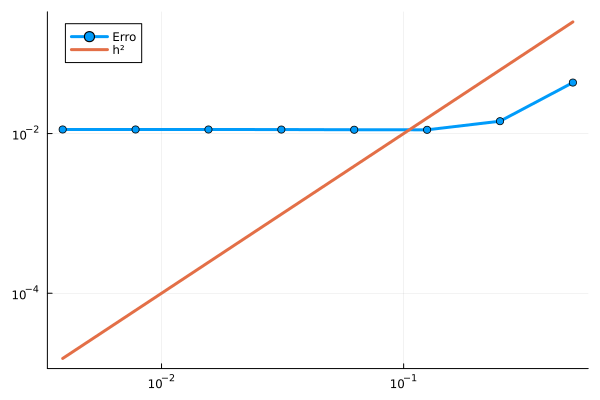

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.04348238097921159
 0.014275772748292599
 0.011134204032037522
 0.011155611631715035
 0.011217173872115292
 0.01123599300297027
 0.01124090976459371
 0.011242152139965112

In [14]:
display(solve_problem(get_test_data(1)...))

h_list, errors_list = convergencia(get_convergence_test_data(1, 8)...)
plot_error_curves(h_list, errors_list)

display(h_list)
display(errors_list)

In [21]:
display(solve_problem(get_test_data(2)...))

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26920572916666663
 -0.27701822916666663
 -0.28092447916666663
 -0.28092447916666663
 -0.27701822916666663
 -0.2692057291666666
 -0.25748697916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.26920572916666663
 -0.27701822916666663
 -0.28092447916666663
 -0.28092447916666663
 -0.27701822916666663
 -0.2692057291666666
 -0.25748697916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.005896107251615796
  0.0039032350910961633
  0.0019256143288704647
 -3.713878068364006e-5
 -0.001985175069569592
 -0.003918414819075438
 -0.005836546510916667

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.28092447916666663
 -0.28483072916666663
 -0.28483072916666663
 -0.2809244791666666
 -0.27311197916666663
 -0.26139322916666663
 -0.24576822916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.017776903322958955
  0.011685765533834443
  0.0056866576046455605
 -0.00022296337140783468
 -0.006044232135804482
 -0.011776898486733928
 -0.01741932879180005

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.29264322916666663
 -0.29264322916666663
 -0.28873697916666663
 -0.28092447916666663
 -0.26920572916666663
 -0.2535807291666666
 -0.23404947916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.029981398491495836
  0.019379425359434356
  0.009116511657287399
 -0.0008175016620067255
 -0.010427573761835313
 -0.01971357805862694
 -0.02867033638694793

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.30436197916666663
 -0.30045572916666663
 -0.29264322916666663
 -0.2809244791666666
 -0.26529947916666663
 -0.24576822916666663
 -0.22233072916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.04241175893988032
  0.0269959442849685
  0.01229750038041419
 -0.0017091606071426846
 -0.01503857855772854
 -0.027694619534686306
 -0.03967068076256596

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.31608072916666663
 -0.30826822916666663
 -0.29654947916666663
 -0.28092447916666663
 -0.26139322916666663
 -0.23795572916666663
 -0.21061197916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.055063954092413415
  0.0345303803184093
  0.015226705883449126
 -0.0028975477376452508
 -0.019873759615998632
 -0.03571506223814054
 -0.050416900359863945

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.32779947916666663
 -0.31608072916666663
 -0.30045572916666663
 -0.28092447916666663
 -0.25748697916666663
 -0.23014322916666663
 -0.19889322916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.06793307023208009
  0.04197665843687741
  0.017900502110776068
 -0.004382236544336754
 -0.024928872507621935
 -0.043768810834770966
 -0.06090469983523421

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.33951822916666663
 -0.32389322916666663
 -0.30436197916666663
 -0.28092447916666663
 -0.25358072916666663
 -0.22233072916666663
 -0.18717447916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.08101411277333159
  0.04932871449747803
  0.02031535503431864
 -0.006162681397871517
 -0.030199592113658524
 -0.05184977518046335
 -0.0711298756939917

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 -0.35123697916666663
 -0.33170572916666663
 -0.30826822916666663
 -0.2809244791666666
 -0.24967447916666663
 -0.21451822916666663
 -0.17545572916666663

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
  0.09430201577925024
  0.05658049792310832
  0.022467817203935786
 -0.008238227920103092
 -0.035681522207360566
 -0.059951873493093305
 -0.08108831077582544

0.011134204032037522

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

0.009182152348950274

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 4.405284732967738

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 0.0

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 4.405284732967738

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 0.0

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 4.405284732967738

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 0.0

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 1.8247286831731897
 2.5805560513947237
 1.8247286831731901

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 0.0
 0.0
 0.0

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 1.8247286831731897
 2.5805560513947237
 1.8247286831731901

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 0.0
 0.0
 0.0

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 1.8247286831731897
 2.5805560513947237
 1.8247286831731901

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 0.0
 0.0
 0.0

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 1.8247286831731897
 2.5805560513947237
 1.8247286831731901

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 0.0
 0.0
 0.0

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 1.8247286831731897
 2.5805560513947237
 1.8247286831731901

3-element view(::Vector{Float64}, 1:3) with eltype Float64:
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.5133045133389941
 0.9484630676391269
 1.239226717730321
 1.3413293336652432
 1.239226717730321
 0.9484630676391269
 0.5133045133389942

7-element view(::Vector{Float64}, 1:7) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.13210940843681987
 0.25914192639522254
 0.37621576545072344
 0.478831843624185
 0.5630466825791607
 0.6256239532828367
 0.6641588463158083
 0.6771704873494355
 0.6641588463158083
 0.6256239532828367
 0.5630466825791607
 0.47883184362418507
 0.37621576545072355
 0.25914192639522265
 0.13210940843681998

15-element view(::Vector{Float64}, 1:15) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.03326725280033264
 0.06621412377046783
 0.09852331653237145
 0.12988367589774502
 0.15999318446258368
 0.18856187119987644
 0.2153146040391104
 0.23999373953851227
 0.2623616041322351
 0.28220278305672275
 0.2993261949126408
 0.31356693188320744
 0.32478784788661763
 ⋮
 0.3135669318832075
 0.2993261949126408
 0.2822027830567228
 0.26236160413223514
 0.2399937395385123
 0.2153146040391104
 0.1885618711998765
 0.1599931844625837
 0.12988367589774505
 0.0985233165323715
 0.06621412377046787
 0.03326725280033268

31-element view(::Vector{Float64}, 1:31) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.008331861293357515
 0.016643650403074473
 0.024915343501158826
 0.03312701335442254
 0.04125887733093177
 0.04929134505809994
 0.05720506561761124
 0.06498097416347773
 0.07260033785092329
 0.08004480096544742
 0.08729642914334926
 0.09433775257718063
 0.10115180810204236
 ⋮
 0.09433775257718063
 0.08729642914334926
 0.08004480096544744
 0.07260033785092329
 0.06498097416347776
 0.05720506561761127
 0.04929134505809995
 0.041258877330931795
 0.03312701335442256
 0.024915343501158843
 0.01664365040307451
 0.00833186129335753

63-element view(::Vector{Float64}, 1:63) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0020839066794196503
 0.004166558091377908
 0.006246699724539562
 0.0083230785793663
 0.010394443922876782
 0.012459548042041416
 0.014517146995358034
 0.016566001362155736
 0.018604876989175567
 0.020632545733978276
 0.022647786204731415
 0.0246493844959301
 0.026636134919608284
 ⋮
 0.0246493844959301
 0.022647786204731422
 0.020632545733978293
 0.018604876989175588
 0.016566001362155747
 0.014517146995358035
 0.012459548042041422
 0.010394443922876796
 0.00832307857936632
 0.006246699724539581
 0.004166558091377908
 0.002083906679419654

127-element view(::Vector{Float64}, 1:127) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0005210355179021833
 0.0010419925697718897
 0.0015627927013933383
 0.00208335748218236
 0.0026036085169977574
 0.0031234674579473185
 0.0036428560161867298
 0.00416169597370958
 0.004679909195126711
 0.005197417639433115
 0.0057141433717606245
 0.006230008575114618
 0.006744935562092972
 ⋮
 0.006230008575114631
 0.005714143371760632
 0.005197417639433115
 0.004679909195126709
 0.00416169597370958
 0.0036428560161867315
 0.003123467457947323
 0.0026036085169977626
 0.002083357482182368
 0.0015627927013933478
 0.001041992569771901
 0.0005210355179021925

255-element view(::Vector{Float64}, 1:255) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

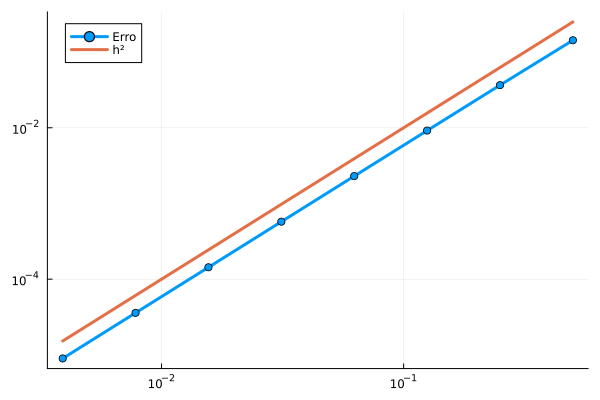

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.14306074758302456
 0.03654207308936446
 0.009182152348950274
 0.002298426253163585
 0.0005747866733774783
 0.00014370791757222827
 3.592769991013887e-5
 8.98198469368731e-6

In [16]:
display(solve_problem(get_test_data(4)...))

h_list, errors_list = convergencia(get_convergence_test_data(4, 8)...)
plot_error_curves(h_list, errors_list)

display(h_list)
display(errors_list)